In [1]:
import copy
import os
from pathlib import Path
import time
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sktime.utils.plotting import plot_series
from kerastuner.tuners import RandomSearch

simplefilter("ignore", FutureWarning)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

# 1. Load data

In [2]:
external_predictions = pd.read_csv('data/external_predictions.csv', index_col=0, parse_dates=True)
external_predictions

forecast_PLN
2019-09-02 00:00:00    231.081699
2019-09-02 01:00:00    224.702813
2019-09-02 02:00:00    220.945387
2019-09-02 03:00:00    220.071567
2019-09-02 04:00:00    219.678348
...                           ...
2021-04-01 19:00:00    303.956955
2021-04-01 20:00:00    298.518453
2021-04-01 21:00:00    278.561916
2021-04-01 22:00:00    267.961446
2021-04-01 23:00:00    246.253527

[13870 rows x 1 columns]

In [3]:
def load_prices():
    raw_data = pd.read_csv('data/prices.csv')
    dates = pd.to_datetime(raw_data['delivery_start_utc'], format='%d.%m.%Y %H:%M:%S')
    data = raw_data[['price']]
    data.index = dates
    data = data.sort_index()
    data.index.freq = 'H'
    return data
    
prices = load_prices()
index_copy = prices.index
prices_predictions = prices.merge(external_predictions, how='left', right_index=True, left_index=True)
prices_predictions.index = index_copy
prices_predictions

price  forecast_PLN
delivery_start_utc                       
2010-01-01 00:00:00  129.30           NaN
2010-01-01 01:00:00  110.17           NaN
2010-01-01 02:00:00  104.46           NaN
2010-01-01 03:00:00  105.00           NaN
2010-01-01 04:00:00  105.01           NaN
...                     ...           ...
2021-03-21 18:00:00  295.79      243.2430
2021-03-21 19:00:00  286.10      266.2044
2021-03-21 20:00:00  265.00      264.1716
2021-03-21 21:00:00  260.00      247.3548
2021-03-21 22:00:00  244.29      237.2832

[98351 rows x 2 columns]

In [4]:
years = [2018, 2019, 2020]
features_dict = dict()
raw_data_dict = dict()
for year in years:
    features_dict[year] = pd.read_csv(f'data/features_{str(year)}.csv', index_col=0, parse_dates=True)
    raw_data_dict[year] = prices_predictions[prices_predictions.index.year==year].merge(features_dict[year], how='left', right_index=True, left_index=True)
    
features = pd.concat(list(features_dict.values()), axis=0)
features

weekday  month  co2_price_pln_actual  \
2018-01-01 00:00:00        1      1                 34.05   
2018-01-01 01:00:00        1      1                 34.05   
2018-01-01 02:00:00        1      1                 34.05   
2018-01-01 03:00:00        1      1                 34.05   
2018-01-01 04:00:00        1      1                 34.05   
...                      ...    ...                   ...   
2020-12-31 19:00:00        4      1                150.58   
2020-12-31 20:00:00        4      1                150.58   
2020-12-31 21:00:00        4      1                150.58   
2020-12-31 22:00:00        4      1                150.58   
2020-12-31 23:00:00        4      1                150.58   

                     co2_price_eur_actual  load_forecast  \
2018-01-01 00:00:00                  8.16        15175.0   
2018-01-01 01:00:00                  8.16        14600.0   
2018-01-01 02:00:00                  8.16        14025.0   
2018-01-01 03:00:00                  8.16        13625.0   
2018-01-01 04:00:00                  8.16        13400.0   
...                                   ...            ...   
2020-12-31 19:00:00                 32.63        18675.0   
2020-12-31 20:00:00                 32.63        17550.0   
2020-12-31 21:00:00                 32.63        16675.0   
2020-12-31 22:00:00                 32.63        16250.0   
2020-12-31 23:00:00                 32.63        15650.0   

                     capacity_jwcd_forecast  capacity_njwcd_forecast  \
2018-01-01 00:00:00                 22312.0                   9327.0   
2018-01-01 01:00:00                 22312.0                   9272.0   
2018-01-01 02:00:00                 22312.0                   9263.0   
2018-01-01 03:00:00                 22312.0                   9296.0   
2018-01-01 04:00:00                 22312.0                   9402.0   
...                                     ...                      ...   
2020-12-31 19:00:00                 24999.0                   6902.0   
2020-12-31 20:00:00                 24999.0                   6881.0   
2020-12-31 21:00:00                 24999.0                   6837.0   
2020-12-31 22:00:00                 24999.0                   6779.0   
2020-12-31 23:00:00                 24999.0                   6745.0   

                     generation_jwcd_forecast  generation_njwcd_forecast  \
2018-01-01 00:00:00                    6835.0                     8340.0   
2018-01-01 01:00:00                    6315.0                     8285.0   
2018-01-01 02:00:00                    5749.0                     8276.0   
2018-01-01 03:00:00                    5316.0                     8309.0   
2018-01-01 04:00:00                    4985.0                     8415.0   
...                                       ...                        ...   
2020-12-31 19:00:00                   12623.0                     6052.0   
2020-12-31 20:00:00                   11510.0                     6040.0   
2020-12-31 21:00:00                   10679.0                     5996.0   
2020-12-31 22:00:00                   10372.0                     5878.0   
2020-12-31 23:00:00                    9839.0                     5811.0   

                     generation_wind_forecast  ...  Hard coal 500 available  \
2018-01-01 00:00:00                    3157.0  ...                    572.0   
2018-01-01 01:00:00                    3107.0  ...                    572.0   
2018-01-01 02:00:00                    3103.0  ...                    572.0   
2018-01-01 03:00:00                    3136.0  ...                    572.0   
2018-01-01 04:00:00                    3242.0  ...                    572.0   
...                                       ...  ...                      ...   
2020-12-31 19:00:00                     422.0  ...                   1592.0   
2020-12-31 20:00:00                     399.0  ...                   1592.0   
2020-12-31 21:00:00                     372.0  ...                   1592.0   

In [5]:
raw_data = pd.concat(list(raw_data_dict.values()), axis=0)
raw_data

price  forecast_PLN  weekday  month  \
delivery_start_utc                                          
2018-01-01 00:00:00  113.59           NaN        1      1   
2018-01-01 01:00:00   97.00           NaN        1      1   
2018-01-01 02:00:00   89.00           NaN        1      1   
2018-01-01 03:00:00   75.00           NaN        1      1   
2018-01-01 04:00:00   75.00           NaN        1      1   
...                     ...           ...      ...    ...   
2020-12-31 19:00:00  239.50    225.613956        4      1   
2020-12-31 20:00:00  227.00    220.507092        4      1   
2020-12-31 21:00:00  229.75    207.238365        4      1   
2020-12-31 22:00:00  215.42    206.645604        4      1   
2020-12-31 23:00:00  176.49    195.474339        4      1   

                     co2_price_pln_actual  co2_price_eur_actual  \
delivery_start_utc                                                
2018-01-01 00:00:00                 34.05                  8.16   
2018-01-01 01:00:00                 34.05                  8.16   
2018-01-01 02:00:00                 34.05                  8.16   
2018-01-01 03:00:00                 34.05                  8.16   
2018-01-01 04:00:00                 34.05                  8.16   
...                                   ...                   ...   
2020-12-31 19:00:00                150.58                 32.63   
2020-12-31 20:00:00                150.58                 32.63   
2020-12-31 21:00:00                150.58                 32.63   
2020-12-31 22:00:00                150.58                 32.63   
2020-12-31 23:00:00                150.58                 32.63   

                     load_forecast  capacity_jwcd_forecast  \
delivery_start_utc                                           
2018-01-01 00:00:00        15175.0                 22312.0   
2018-01-01 01:00:00        14600.0                 22312.0   
2018-01-01 02:00:00        14025.0                 22312.0   
2018-01-01 03:00:00        13625.0                 22312.0   
2018-01-01 04:00:00        13400.0                 22312.0   
...                            ...                     ...   
2020-12-31 19:00:00        18675.0                 24999.0   
2020-12-31 20:00:00        17550.0                 24999.0   
2020-12-31 21:00:00        16675.0                 24999.0   
2020-12-31 22:00:00        16250.0                 24999.0   
2020-12-31 23:00:00        15650.0                 24999.0   

                     capacity_njwcd_forecast  generation_jwcd_forecast  ...  \
delivery_start_utc                                                      ...   
2018-01-01 00:00:00                   9327.0                    6835.0  ...   
2018-01-01 01:00:00                   9272.0                    6315.0  ...   
2018-01-01 02:00:00                   9263.0                    5749.0  ...   
2018-01-01 03:00:00                   9296.0                    5316.0  ...   
2018-01-01 04:00:00                   9402.0                    4985.0  ...   
...                                      ...                       ...  ...   
2020-12-31 19:00:00                   6902.0                   12623.0  ...   
2020-12-31 20:00:00                   6881.0                   11510.0  ...   
2020-12-31 21:00:00                   6837.0                   10679.0  ...   
2020-12-31 22:00:00                   6779.0                   10372.0  ...   
2020-12-31 23:00:00                   6745.0                    9839.0  ...   

                     Hard coal 500 available  Lignite 200 available  \
delivery_start_utc                                                    
2018-01-01 00:00:00                    572.0                 2127.0   
2018-01-01 01:00:00                    572.0                 2127.0   
2018-01-01 02:00:00                    572.0                 2127.0   
2018-01-01 03:00:00                    572.0                 2127.0   
2018-01-01 04:00:00                    572.0                 2127.0   
...                     

# 2. Data preprocessing

In [6]:
def get_lags(df, columns, lags):
    df_copy = df.copy()
    for lag in lags:
        for column in columns:
            if column not in df.columns:
                print(f'Column {column} not found in given data frame columns')
                return df
            df_copy[f'{column}_lag_{lag}'] = df_copy[column].shift(lag)
    return df_copy

In [7]:
raw_data.columns

Index(['price', 'forecast_PLN', 'weekday', 'month', 'co2_price_pln_actual',
       'co2_price_eur_actual', 'load_forecast', 'capacity_jwcd_forecast',
       'capacity_njwcd_forecast', 'generation_jwcd_forecast',
       'generation_njwcd_forecast', 'generation_wind_forecast',
       'generation_solar_forecast', 'reserve1_forecast', 'reserve2_forecast',
       'load_actual', 'generation_jwcd_actual', 'generation_pi_actual',
       'generation_irz_actual', 'generation_njwcd_actual',
       'crossborder_sync_balance_actual', 'crossborder_async_balance_actual',
       'CEPS_EXP', 'CEPS_IMP', 'SEPS_EXP', 'SEPS_IMP', '50HzT_EXP',
       '50HzT_IMP', 'SVK_EXP', 'SVK_IMP', 'UA_EXP', 'UA_IMP', 'LIT_EXP',
       'LIT_IMP', 'generation_wind_actual', 'generation_solar_actual',
       'Biomass 200 generation', 'Gas 200 generation', 'Gas 500 generation',
       'HPS 100 generation', 'HPS 200 generation', 'Hard coal 100 generation',
       'Hard coal 1000 generation', 'Hard coal 200 generation',
     

In [8]:
fixed_columns =  ['forecast_PLN', 'weekday', 'month'] #Not to be lagged
columns_to_lag = [column for column in raw_data.columns if column not in fixed_columns]
data_lagged = get_lags(df=raw_data, columns=columns_to_lag, lags=[24, 7*24]) #lag for 1 day and 7 days
columns_to_drop = columns_to_lag
columns_to_drop.remove('price') #drop all not-lagged columns but `price` (`price` - target, `price_lagged` - feature)
data_lagged = data_lagged.drop(columns_to_lag, axis=1).iloc[7*24:,]
data_lagged

price  forecast_PLN  weekday  month  price_lag_24  \
delivery_start_utc                                                        
2018-01-08 00:00:00  118.90           NaN        1      1        119.00   
2018-01-08 01:00:00  118.90           NaN        1      1        118.90   
2018-01-08 02:00:00  118.90           NaN        1      1        117.98   
2018-01-08 03:00:00  118.90           NaN        1      1        117.98   
2018-01-08 04:00:00  135.00           NaN        1      1        117.98   
...                     ...           ...      ...    ...           ...   
2020-12-31 19:00:00  239.50    225.613956        4      1        244.58   
2020-12-31 20:00:00  227.00    220.507092        4      1        216.48   
2020-12-31 21:00:00  229.75    207.238365        4      1        215.00   
2020-12-31 22:00:00  215.42    206.645604        4      1        194.99   
2020-12-31 23:00:00  176.49    195.474339        4      1        227.56   

                     co2_price_pln_actual_lag_24  co2_price_eur_actual_lag_24  \
delivery_start_utc                                                              
2018-01-08 00:00:00                        32.28                         7.77   
2018-01-08 01:00:00                        32.28                         7.77   
2018-01-08 02:00:00                        32.28                         7.77   
2018-01-08 03:00:00                        32.28                         7.77   
2018-01-08 04:00:00                        32.28                         7.77   
...                                          ...                          ...   
2020-12-31 19:00:00                       145.47                        32.13   
2020-12-31 20:00:00                       145.47                        32.13   
2020-12-31 21:00:00                       145.47                        32.13   
2020-12-31 22:00:00                       145.47                        32.13   
2020-12-31 23:00:00                       145.47                        32.13   

                     load_forecast_lag_24  capacity_jwcd_forecast_lag_24  \
delivery_start_utc                                                         
2018-01-08 00:00:00               16125.0                        20575.0   
2018-01-08 01:00:00               15450.0                        20575.0   
2018-01-08 02:00:00               15100.0                        20575.0   
2018-01-08 03:00:00               14925.0                        20575.0   
2018-01-08 04:00:00               14925.0                        20575.0   
...                                   ...                            ...   
2020-12-31 19:00:00               22050.0                        24333.0   
2020-12-31 20:00:00               21450.0                        24333.0   
2020-12-31 21:00:00               20225.0                        24333.0   
2020-12-31 22:00:00               19025.0                        24333.0   
2020-12-31 23:00:00               17700.0                        24333.0   

                     capacity_njwcd_forecast_lag_24  ...  \
delivery_start_utc                                   ...   
2018-01-08 00:00:00                          6648.0  ...   
2018-01-08 01:00:00                          6686.0  ...   
2018-01-08 02:00:00                          6763.0  ...   
2018-01-08 03:00:00                          6861.0  ...   
2018-01-08 04:00:00                          6922.0  ...   
...                                             ...  ...   
2020-12-31 19:00:00                          7711.0  ...   
2020-12-31 20:00:00                          7682.0  ...   
2020-12-31 21:00:00                          7648.0  ...   
2020-12-31 22:00:00                          7584.0  ...   
2020-12-31 23:00:00                          7533.0  ...   

                     Hard coal 500 available_lag_168  \
delivery_start_utc                                     
2018-01-08 00:00:00                            572.0   
2018-01-08 01:00:00                            572.0  

### Drop noninformative columns

In [9]:
forecasts = raw_data['forecast_PLN']
columns_to_drop = [
    'forecast_PLN', 
    'generation_solar_forecast_lag_24',
    'generation_solar_forecast_lag_168',
    'generation_solar_actual_lag_24',
    'generation_solar_actual_lag_168',
    'reserve2_forecast_lag_24',
    'reserve2_forecast_lag_168',
    'UA_EXP_lag_24',
    'UA_EXP_lag_168',
    'Biomass 200 available_lag_24',
    'Biomass 200 available_lag_168',
    'Gas 200 available_lag_24',
    'Gas 200 available_lag_168',
    'HPS 100 available_lag_24',
    'HPS 100 available_lag_168',
    'HPS 200 available_lag_24',
    'HPS 200 available_lag_168',
]
data = data_lagged.drop(columns_to_drop, axis=1)
data

price  weekday  month  price_lag_24  \
delivery_start_utc                                          
2018-01-08 00:00:00  118.90        1      1        119.00   
2018-01-08 01:00:00  118.90        1      1        118.90   
2018-01-08 02:00:00  118.90        1      1        117.98   
2018-01-08 03:00:00  118.90        1      1        117.98   
2018-01-08 04:00:00  135.00        1      1        117.98   
...                     ...      ...    ...           ...   
2020-12-31 19:00:00  239.50        4      1        244.58   
2020-12-31 20:00:00  227.00        4      1        216.48   
2020-12-31 21:00:00  229.75        4      1        215.00   
2020-12-31 22:00:00  215.42        4      1        194.99   
2020-12-31 23:00:00  176.49        4      1        227.56   

                     co2_price_pln_actual_lag_24  co2_price_eur_actual_lag_24  \
delivery_start_utc                                                              
2018-01-08 00:00:00                        32.28                         7.77   
2018-01-08 01:00:00                        32.28                         7.77   
2018-01-08 02:00:00                        32.28                         7.77   
2018-01-08 03:00:00                        32.28                         7.77   
2018-01-08 04:00:00                        32.28                         7.77   
...                                          ...                          ...   
2020-12-31 19:00:00                       145.47                        32.13   
2020-12-31 20:00:00                       145.47                        32.13   
2020-12-31 21:00:00                       145.47                        32.13   
2020-12-31 22:00:00                       145.47                        32.13   
2020-12-31 23:00:00                       145.47                        32.13   

                     load_forecast_lag_24  capacity_jwcd_forecast_lag_24  \
delivery_start_utc                                                         
2018-01-08 00:00:00               16125.0                        20575.0   
2018-01-08 01:00:00               15450.0                        20575.0   
2018-01-08 02:00:00               15100.0                        20575.0   
2018-01-08 03:00:00               14925.0                        20575.0   
2018-01-08 04:00:00               14925.0                        20575.0   
...                                   ...                            ...   
2020-12-31 19:00:00               22050.0                        24333.0   
2020-12-31 20:00:00               21450.0                        24333.0   
2020-12-31 21:00:00               20225.0                        24333.0   
2020-12-31 22:00:00               19025.0                        24333.0   
2020-12-31 23:00:00               17700.0                        24333.0   

                     capacity_njwcd_forecast_lag_24  \
delivery_start_utc                                    
2018-01-08 00:00:00                          6648.0   
2018-01-08 01:00:00                          6686.0   
2018-01-08 02:00:00                          6763.0   
2018-01-08 03:00:00                          6861.0   
2018-01-08 04:00:00                          6922.0   
...                                             ...   
2020-12-31 19:00:00                          7711.0   
2020-12-31 20:00:00                          7682.0   
2020-12-31 21:00:00                          7648.0   
2020-12-31 22:00:00                          7584.0   
2020-12-31 23:00:00                          7533.0   

                     generation_jwcd_forecast_lag_24  ...  \
delivery_start_utc                                    ...   
2018-01-08 00:00:00                          10485.0  ...   
2018-01-08 01:00:00                           9772.0  ...   
2018-01-08 02:00:00                           9345.0  ...   
2018-01-08 03:00:00                           9072.0  ...   
2018-01-08 04:00:00                           9014.0  ...   
...                                       

### Handle missings

In [10]:
missings = data.isnull().sum()
missings[missings>0]

load_actual_lag_24                          4
generation_jwcd_actual_lag_24               4
generation_pi_actual_lag_24                 4
generation_irz_actual_lag_24                4
generation_njwcd_actual_lag_24              4
crossborder_sync_balance_actual_lag_24      4
crossborder_async_balance_actual_lag_24     4
generation_wind_actual_lag_24               6
load_actual_lag_168                         4
generation_jwcd_actual_lag_168              4
generation_pi_actual_lag_168                4
generation_irz_actual_lag_168               4
generation_njwcd_actual_lag_168             4
crossborder_sync_balance_actual_lag_168     4
crossborder_async_balance_actual_lag_168    4
generation_wind_actual_lag_168              6
dtype: int64

In [11]:
missing_columns = missings[missings>0].index
data[missing_columns] = data[missing_columns].fillna(data[missing_columns].median()) 
missings = data.isnull().sum()
missings[missings>0]

Series([], dtype: int64)

In [12]:
X_train_full, y_train_full = data.iloc[:,1:], data.iloc[:,0]

In [13]:
VALIDATION_SIZE = 30*24 #30 days * 24 hours (december 2020 for validation)

X_train, X_valid = X_train_full.iloc[:(-VALIDATION_SIZE), :], X_train_full.iloc[(-VALIDATION_SIZE):, :]
y_train, y_valid = y_train_full.iloc[:(-VALIDATION_SIZE)], y_train_full.iloc[(-VALIDATION_SIZE):]

### Scaling transformation

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

### Benchmark values

In [15]:
y_pred_external = pd.Series(external_predictions.loc[y_valid.index,:].iloc[:,0])
benchmark_valid_error = np.sqrt(mean_squared_error(y_pred=y_pred_external, y_true=y_valid))

# 3. Model samples

### Feed-forward shallow networks

In [16]:
def plot_results(model, history):
    y_valid_pred = pd.Series(model.predict(X_valid).flatten())
    y_valid_pred.index = y_valid.index
    valid_error = np.sqrt(mean_squared_error(y_pred=y_valid_pred, y_true=y_valid))
    print(f'Validation error: {valid_error}, Benchmark error: {benchmark_valid_error}')
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid()
    plot_series(y_valid_pred, y_valid, labels=['Predictions', 'Observed'])
    plt.grid()
    plot_series(y_valid_pred, y_valid, y_pred_external, labels=['Predictions', 'Observed', 'Benchmark'])
    plt.grid()

In [17]:
def create_dense_nn_model(n_units=[30], activation='relu', learning_rate=1e-3):
    layers = list()
    for n_unit in n_units:
        layers.append(keras.layers.Dense(n_unit, activation=activation))
    
    layers.append(keras.layers.Dense(1)) #Output layer
    model = keras.models.Sequential(layers)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=opt)
    return model

### 1 dense hidden layer - 30 unit

In [20]:
model = create_dense_nn_model(n_units=[30])
history = model.fit(X_train, y_train.values, epochs=1000, validation_data=(X_valid, y_valid.values))

Train on 25416 samples, validate on 720 samples
Epoch 1/1000
25416/25416 [==============================] - 2s 85us/sample - loss: 28226.1922 - val_loss: 11324.1286
Epoch 2/1000
25416/25416 [==============================] - 1s 59us/sample - loss: 4239.3629 - val_loss: 5030.5926
Epoch 3/1000
25416/25416 [==============================] - 1s 56us/sample - loss: 2534.2541 - val_loss: 5317.2745
Epoch 4/1000
25416/25416 [==============================] - ETA: 0s - loss: 1991.66 - 1s 57us/sample - loss: 1991.6997 - val_loss: 5796.0914
Epoch 5/1000
25416/25416 [==============================] - 1s 56us/sample - loss: 1714.6177 - val_loss: 6686.4853
Epoch 6/1000
25416/25416 [==============================] - 1s 56us/sample - loss: 1545.0827 - val_loss: 6611.6997
Epoch 7/1000
25416/25416 [==============================] - 2s 60us/sample - loss: 1428.4204 - val_loss: 6702.4459
Epoch 8/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 1340.6723 - val_loss: 6251.8854
Epoc

25416/25416 [==============================] - 1s 50us/sample - loss: 647.3866 - val_loss: 5044.2508
Epoch 72/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 643.8609 - val_loss: 4559.2956
Epoch 73/1000
25416/25416 [==============================] - 2s 62us/sample - loss: 640.1381 - val_loss: 4670.3114
Epoch 74/1000
25416/25416 [==============================] - 2s 64us/sample - loss: 637.2556 - val_loss: 4567.3086
Epoch 75/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 635.1265 - val_loss: 4801.5115
Epoch 76/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 632.5103 - val_loss: 4854.8930
Epoch 77/1000
25416/25416 [==============================] - 1s 58us/sample - loss: 630.9388 - val_loss: 4795.6914
Epoch 78/1000
25416/25416 [==============================] - 2s 68us/sample - loss: 629.4766 - val_loss: 4660.3394
Epoch 79/1000
25416/25416 [==============================] - 2s 64us/sample - loss: 627.0917 -

Epoch 142/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 528.9998 - val_loss: 4467.4173
Epoch 143/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 529.5592 - val_loss: 4876.7506
Epoch 144/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 527.1164 - val_loss: 4440.5817
Epoch 145/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 526.8645 - val_loss: 4453.5060
Epoch 146/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 524.9446 - val_loss: 4668.0977
Epoch 147/1000
25416/25416 [==============================] - 1s 58us/sample - loss: 525.7829 - val_loss: 4512.6445
Epoch 148/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 522.2295 - val_loss: 4671.6171
Epoch 149/1000
25416/25416 [==============================] - 1s 56us/sample - loss: 521.0126 - val_loss: 4731.3409
Epoch 150/1000
25416/25416 [==============================] - 1s 51us/sa

25416/25416 [==============================] - 1s 47us/sample - loss: 453.3045 - val_loss: 5451.5367
Epoch 283/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 452.3826 - val_loss: 5351.1506
Epoch 284/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 452.0087 - val_loss: 4833.6325
Epoch 285/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 452.5058 - val_loss: 4924.2170
Epoch 286/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 452.2986 - val_loss: 4877.0874
Epoch 287/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 451.2257 - val_loss: 5171.1358
Epoch 288/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 450.2705 - val_loss: 5484.0870
Epoch 289/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 450.5687 - val_loss: 5366.1885
Epoch 290/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 45

Epoch 353/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 432.5662 - val_loss: 5182.3978
Epoch 354/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 432.5516 - val_loss: 5352.6859
Epoch 355/1000
25416/25416 [==============================] - 1s 50us/sample - loss: 433.5338 - val_loss: 5113.3685
Epoch 356/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 431.7461 - val_loss: 5508.8994
Epoch 357/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 431.8820 - val_loss: 5525.3034
Epoch 358/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 432.1203 - val_loss: 5439.9570
Epoch 359/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 431.5928 - val_loss: 5773.0880
Epoch 360/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 431.4579 - val_loss: 5174.5982
Epoch 361/1000
25416/25416 [==============================] - 1s 47us/sa

25416/25416 [==============================] - 1s 47us/sample - loss: 411.1360 - val_loss: 5321.6488
Epoch 494/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 410.7833 - val_loss: 5526.4321
Epoch 495/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 410.7942 - val_loss: 5350.8107
Epoch 496/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 410.6552 - val_loss: 5343.6389
Epoch 497/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 409.1926 - val_loss: 5331.5577
Epoch 498/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 409.6757 - val_loss: 5406.7284
Epoch 499/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 409.8642 - val_loss: 5322.7719
Epoch 500/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 409.7146 - val_loss: 5196.4054
Epoch 501/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 40

Epoch 634/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 396.6018 - val_loss: 5559.1545
Epoch 635/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 395.6502 - val_loss: 5638.4992
Epoch 636/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 394.9475 - val_loss: 5492.6627
Epoch 637/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 396.4083 - val_loss: 5486.2995
Epoch 638/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 394.9926 - val_loss: 5672.4157
Epoch 639/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 395.1203 - val_loss: 5477.6435
Epoch 640/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 395.3637 - val_loss: 5447.9913
Epoch 641/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 394.8100 - val_loss: 5369.9357
Epoch 642/1000
25416/25416 [==============================] - 1s 56us/sa

Epoch 775/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 385.3631 - val_loss: 6121.0304
Epoch 776/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 384.9407 - val_loss: 5720.2496
Epoch 777/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 385.2732 - val_loss: 5736.1531- loss: 38
Epoch 778/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 384.2522 - val_loss: 6042.8909
Epoch 779/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 384.5242 - val_loss: 5596.4412
Epoch 780/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 385.3700 - val_loss: 5849.7410
Epoch 781/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 385.0402 - val_loss: 5543.8850
Epoch 782/1000
25416/25416 [==============================] - 1s 50us/sample - loss: 384.9564 - val_loss: 5795.7280
Epoch 783/1000
25416/25416 [==============================] - 

Epoch 916/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 376.3176 - val_loss: 6525.7192
Epoch 917/1000
25416/25416 [==============================] - 1s 59us/sample - loss: 376.6309 - val_loss: 5923.6124
Epoch 918/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 377.1917 - val_loss: 5975.9772
Epoch 919/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 375.4053 - val_loss: 6085.5138
Epoch 920/1000
25416/25416 [==============================] - ETA: 0s - loss: 375.615 - 1s 52us/sample - loss: 375.6022 - val_loss: 6190.7598
Epoch 921/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 376.7947 - val_loss: 6197.7116
Epoch 922/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 377.2281 - val_loss: 6006.0086
Epoch 923/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 375.0577 - val_loss: 5733.8090
Epoch 924/1000
25416/25416 [==================

25416/25416 [==============================] - 1s 47us/sample - loss: 372.3100 - val_loss: 6766.3425
Epoch 987/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 372.1985 - val_loss: 5919.7368
Epoch 988/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 372.4197 - val_loss: 6158.2309
Epoch 989/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 373.1425 - val_loss: 5714.4034
Epoch 990/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 372.5924 - val_loss: 6233.7367
Epoch 991/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 372.6453 - val_loss: 5799.3827
Epoch 992/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 372.6148 - val_loss: 6174.0872
Epoch 993/1000
25416/25416 [==============================] - 2s 68us/sample - loss: 372.7192 - val_loss: 6109.5700
Epoch 994/1000
25416/25416 [==============================] - 2s 68us/sample - loss: 37

Validation error: 76.89960656398573, Benchmark error: 34.117237015574034


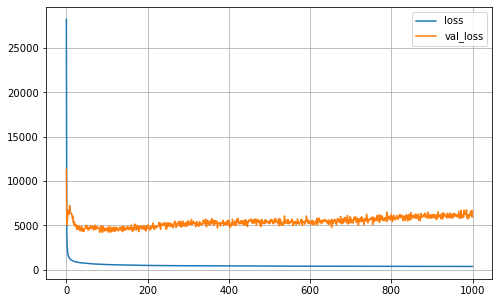

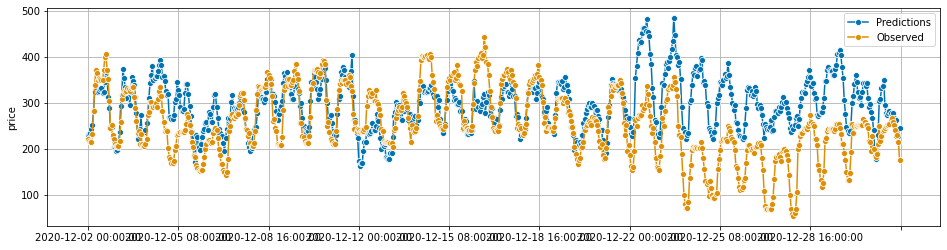

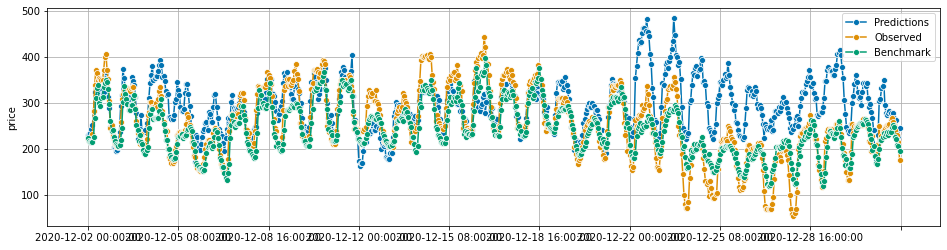

In [21]:
plot_results(model, history)

### 2 dense hidden layers - 64 units / 32 units

In [22]:
model = create_dense_nn_model(n_units=[64, 32])
history = model.fit(X_train, y_train.values, epochs=1000, validation_data=(X_valid, y_valid.values))

Train on 25416 samples, validate on 720 samples
Epoch 1/1000
25416/25416 [==============================] - 3s 107us/sample - loss: 8070.0935 - val_loss: 5262.9536
Epoch 2/1000
25416/25416 [==============================] - 2s 66us/sample - loss: 1324.7529 - val_loss: 5795.4903
Epoch 3/1000
25416/25416 [==============================] - ETA: 0s - loss: 1120.94 - 2s 64us/sample - loss: 1117.4029 - val_loss: 6204.3371
Epoch 4/1000
25416/25416 [==============================] - 2s 66us/sample - loss: 1007.3920 - val_loss: 5688.8521
Epoch 5/1000
25416/25416 [==============================] - 2s 60us/sample - loss: 939.5641 - val_loss: 4646.9869
Epoch 6/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 887.0964 - val_loss: 5239.2137
Epoch 7/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 846.5639 - val_loss: 4828.0799
Epoch 8/1000
25416/25416 [==============================] - 2s 66us/sample - loss: 812.7621 - val_loss: 5299.8915
Epoch 9/1

Epoch 142/1000
25416/25416 [==============================] - 1s 58us/sample - loss: 200.6182 - val_loss: 6356.3212
Epoch 143/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 201.8873 - val_loss: 5458.6029
Epoch 144/1000
25416/25416 [==============================] - 1s 58us/sample - loss: 198.2835 - val_loss: 6213.0224
Epoch 145/1000
25416/25416 [==============================] - 1s 56us/sample - loss: 202.3466 - val_loss: 6231.8637
Epoch 146/1000
25416/25416 [==============================] - 1s 57us/sample - loss: 199.9956 - val_loss: 6619.4709
Epoch 147/1000
25416/25416 [==============================] - 1s 55us/sample - loss: 199.0814 - val_loss: 6369.7335
Epoch 148/1000
25416/25416 [==============================] - 2s 61us/sample - loss: 199.9150 - val_loss: 6150.6658
Epoch 149/1000
25416/25416 [==============================] - 1s 56us/sample - loss: 196.8667 - val_loss: 6178.6537
Epoch 150/1000
25416/25416 [==============================] - 1s 53us/sa

25416/25416 [==============================] - 1s 49us/sample - loss: 155.4110 - val_loss: 6941.3469
Epoch 283/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 154.0880 - val_loss: 7216.5871
Epoch 284/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 153.9739 - val_loss: 7064.0392
Epoch 285/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 154.6018 - val_loss: 7092.1283
Epoch 286/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 155.7776 - val_loss: 7159.4318
Epoch 287/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 154.1945 - val_loss: 7116.5096
Epoch 288/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 153.4423 - val_loss: 7118.3561
Epoch 289/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 156.0131 - val_loss: 6341.5734
Epoch 290/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 15

Epoch 353/1000
25416/25416 [==============================] - 2s 98us/sample - loss: 142.3198 - val_loss: 7267.6786
Epoch 354/1000
25416/25416 [==============================] - 3s 109us/sample - loss: 141.3933 - val_loss: 7342.8443
Epoch 355/1000
25416/25416 [==============================] - 2s 87us/sample - loss: 144.2980 - val_loss: 7853.8016
Epoch 356/1000
25416/25416 [==============================] - 2s 96us/sample - loss: 141.5981 - val_loss: 7277.5767
Epoch 357/1000
25416/25416 [==============================] - 2s 96us/sample - loss: 140.4288 - val_loss: 7316.8441
Epoch 358/1000
25416/25416 [==============================] - 3s 113us/sample - loss: 142.5103 - val_loss: 7668.0379
Epoch 359/1000
25416/25416 [==============================] - 3s 106us/sample - loss: 140.7774 - val_loss: 7437.0817
Epoch 360/1000
25416/25416 [==============================] - 2s 71us/sample - loss: 143.2641 - val_loss: 7233.7704
Epoch 361/1000
25416/25416 [==============================] - 2s 77us

25416/25416 [==============================] - 1s 46us/sample - loss: 127.6876 - val_loss: 8015.7314
Epoch 494/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 124.8471 - val_loss: 7727.2652
Epoch 495/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 123.9722 - val_loss: 8002.6297
Epoch 496/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 124.9386 - val_loss: 7566.0829
Epoch 497/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 125.0722 - val_loss: 8107.8031
Epoch 498/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 124.8574 - val_loss: 7343.9301
Epoch 499/1000
25416/25416 [==============================] - 1s 41us/sample - loss: 125.2822 - val_loss: 7959.8051
Epoch 500/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 124.6910 - val_loss: 7986.4793
Epoch 501/1000
25416/25416 [==============================] - 1s 56us/sample - loss: 12

Epoch 564/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 119.2553 - val_loss: 7308.9438
Epoch 565/1000
25416/25416 [==============================] - 1s 55us/sample - loss: 118.1268 - val_loss: 7533.0328
Epoch 566/1000
25416/25416 [==============================] - 2s 88us/sample - loss: 118.9444 - val_loss: 7858.4905
Epoch 567/1000
25416/25416 [==============================] - 3s 100us/sample - loss: 118.0890 - val_loss: 7581.9341
Epoch 568/1000
25416/25416 [==============================] - 3s 110us/sample - loss: 120.8449 - val_loss: 7463.9596
Epoch 569/1000
25416/25416 [==============================] - 3s 105us/sample - loss: 118.6835 - val_loss: 8056.0319
Epoch 570/1000
25416/25416 [==============================] - 2s 92us/sample - loss: 118.8397 - val_loss: 7857.3328
Epoch 571/1000
25416/25416 [==============================] - 2s 76us/sample - loss: 120.1147 - val_loss: 8060.6993
Epoch 572/1000
25416/25416 [==============================] - 3s 110u

Epoch 705/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 108.8326 - val_loss: 7399.1132
Epoch 706/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 108.5395 - val_loss: 7326.7111
Epoch 707/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 108.6834 - val_loss: 7360.9490
Epoch 708/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 108.1043 - val_loss: 7333.6302
Epoch 709/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 108.9757 - val_loss: 7545.7071
Epoch 710/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 108.9529 - val_loss: 7931.1364
Epoch 711/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 110.1988 - val_loss: 7270.1597
Epoch 712/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 107.1110 - val_loss: 7081.6072
Epoch 713/1000
25416/25416 [==============================] - 1s 44us/sa

25416/25416 [==============================] - 2s 66us/sample - loss: 101.1414 - val_loss: 7249.1146
Epoch 846/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 100.7918 - val_loss: 7853.0936
Epoch 847/1000
25416/25416 [==============================] - 1s 57us/sample - loss: 99.8529 - val_loss: 7520.6839
Epoch 848/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 100.8558 - val_loss: 7507.5826
Epoch 849/1000
25416/25416 [==============================] - 2s 59us/sample - loss: 100.7180 - val_loss: 7677.2758
Epoch 850/1000
25416/25416 [==============================] - 2s 65us/sample - loss: 100.3910 - val_loss: 7237.9605
Epoch 851/1000
25416/25416 [==============================] - 2s 64us/sample - loss: 100.4500 - val_loss: 7315.9621
Epoch 852/1000
25416/25416 [==============================] - 1s 55us/sample - loss: 100.8819 - val_loss: 7186.2772
Epoch 853/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 99.

25416/25416 [==============================] - 1s 49us/sample - loss: 95.4799 - val_loss: 7164.9670
Epoch 988/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 96.1049 - val_loss: 7508.5554
Epoch 989/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 97.4657 - val_loss: 6915.0318
Epoch 990/1000
25416/25416 [==============================] - 2s 61us/sample - loss: 96.2235 - val_loss: 7470.9329
Epoch 991/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 94.9529 - val_loss: 7170.6792
Epoch 992/1000
25416/25416 [==============================] - 1s 57us/sample - loss: 95.3547 - val_loss: 6911.6874
Epoch 993/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 96.0531 - val_loss: 6818.4981
Epoch 994/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 95.9492 - val_loss: 6969.5673
Epoch 995/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 95.5538 - 

Validation error: 83.45483858090559, Benchmark error: 34.117237015574034


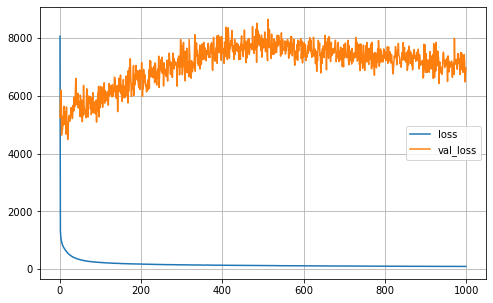

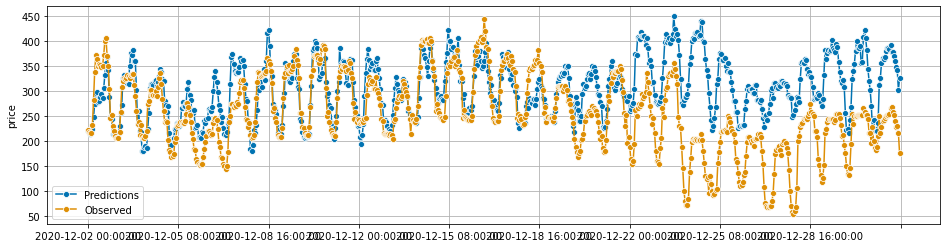

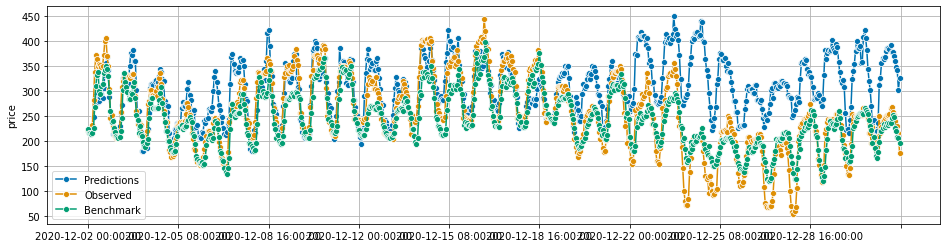

In [23]:
plot_results(model, history)

### 3 dense hidden layers - 64 units / 64 units / 32 units

In [24]:
model = create_dense_nn_model(n_units=[64, 64, 32])
history = model.fit(X_train, y_train.values, epochs=1000, validation_data=(X_valid, y_valid.values))

Train on 25416 samples, validate on 720 samples
Epoch 1/1000
25416/25416 [==============================] - 2s 86us/sample - loss: 4709.6710 - val_loss: 4638.1485
Epoch 2/1000
25416/25416 [==============================] - 2s 64us/sample - loss: 1067.2425 - val_loss: 4608.5141
Epoch 3/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 943.5587 - val_loss: 5025.1713
Epoch 4/1000
25416/25416 [==============================] - 2s 60us/sample - loss: 870.6707 - val_loss: 4662.1842
Epoch 5/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 822.5145 - val_loss: 4789.8257
Epoch 6/1000
25416/25416 [==============================] - 2s 69us/sample - loss: 773.7115 - val_loss: 5611.6057
Epoch 7/1000
25416/25416 [==============================] - 1s 58us/sample - loss: 739.2115 - val_loss: 4007.7224
Epoch 8/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 697.4713 - val_loss: 4558.7282
Epoch 9/1000
25416/25416 [============

Epoch 142/1000
25416/25416 [==============================] - 1s 58us/sample - loss: 141.6499 - val_loss: 4392.4317
Epoch 143/1000
25416/25416 [==============================] - 1s 55us/sample - loss: 140.8430 - val_loss: 4300.5470
Epoch 144/1000
25416/25416 [==============================] - 2s 61us/sample - loss: 131.2527 - val_loss: 4527.6572
Epoch 145/1000
25416/25416 [==============================] - 1s 55us/sample - loss: 134.0510 - val_loss: 4719.7000
Epoch 146/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 135.8558 - val_loss: 4263.5094
Epoch 147/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 137.6326 - val_loss: 4176.6792
Epoch 148/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 134.0391 - val_loss: 4516.8170
Epoch 149/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 133.1338 - val_loss: 4511.6183
Epoch 150/1000
25416/25416 [==============================] - 1s 51us/sa

25416/25416 [==============================] - 1s 44us/sample - loss: 88.1852 - val_loss: 4405.2793
Epoch 284/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 85.1468 - val_loss: 3989.3519
Epoch 285/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 88.0048 - val_loss: 3894.5524
Epoch 286/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 86.4356 - val_loss: 4237.6957
Epoch 287/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 83.6591 - val_loss: 4587.1933
Epoch 288/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 83.7624 - val_loss: 4051.4675
Epoch 289/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 86.4217 - val_loss: 4190.9288
Epoch 290/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 83.1316 - val_loss: 3782.4883
Epoch 291/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 88.4374 - 

25416/25416 [==============================] - 1s 44us/sample - loss: 70.2387 - val_loss: 3729.9238
Epoch 426/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 69.7523 - val_loss: 3541.0540
Epoch 427/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 70.0576 - val_loss: 3519.1085
Epoch 428/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 65.7464 - val_loss: 4077.5454
Epoch 429/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 71.2020 - val_loss: 3765.2587
Epoch 430/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 65.1979 - val_loss: 4134.4056
Epoch 431/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 72.0447 - val_loss: 4134.2899
Epoch 432/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 67.6595 - val_loss: 3800.5168
Epoch 433/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 69.0345 - 

25416/25416 [==============================] - 1s 44us/sample - loss: 58.5021 - val_loss: 3704.8377
Epoch 568/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 60.4392 - val_loss: 3870.9519
Epoch 569/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 59.5572 - val_loss: 3911.1280
Epoch 570/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 58.9007 - val_loss: 4058.9565
Epoch 571/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 61.3960 - val_loss: 3587.8605
Epoch 572/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 58.6952 - val_loss: 3694.8736
Epoch 573/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 59.4606 - val_loss: 3485.1496
Epoch 574/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 61.4379 - val_loss: 3698.8106
Epoch 575/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 59.4671 - 

25416/25416 [==============================] - 1s 42us/sample - loss: 52.8299 - val_loss: 3849.2778
Epoch 710/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 52.5347 - val_loss: 3962.5160
Epoch 711/1000
25416/25416 [==============================] - 2s 77us/sample - loss: 55.0468 - val_loss: 3739.2820
Epoch 712/1000
25416/25416 [==============================] - 2s 63us/sample - loss: 56.2869 - val_loss: 3807.5922
Epoch 713/1000
25416/25416 [==============================] - 1s 56us/sample - loss: 52.5264 - val_loss: 4016.0015
Epoch 714/1000
25416/25416 [==============================] - 1s 57us/sample - loss: 52.1843 - val_loss: 3705.5361
Epoch 715/1000
25416/25416 [==============================] - 2s 73us/sample - loss: 55.4665 - val_loss: 3561.8967
Epoch 716/1000
25416/25416 [==============================] - 2s 64us/sample - loss: 53.7014 - val_loss: 3804.7238
Epoch 717/1000
25416/25416 [==============================] - 2s 61us/sample - loss: 52.1187 - 

25416/25416 [==============================] - 1s 50us/sample - loss: 49.1496 - val_loss: 3991.2968
Epoch 852/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 47.9807 - val_loss: 4005.6807
Epoch 853/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 49.4922 - val_loss: 3882.5930
Epoch 854/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 51.7964 - val_loss: 3963.9425
Epoch 855/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 49.0708 - val_loss: 3785.8181
Epoch 856/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 49.2499 - val_loss: 4163.2560
Epoch 857/1000
25416/25416 [==============================] - 1s 50us/sample - loss: 50.0100 - val_loss: 3948.4692
Epoch 858/1000
25416/25416 [==============================] - 1s 50us/sample - loss: 49.6784 - val_loss: 3768.8391
Epoch 859/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 48.6945 - 

25416/25416 [==============================] - 1s 51us/sample - loss: 45.4246 - val_loss: 3797.6289
Epoch 994/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 48.0934 - val_loss: 4030.9042
Epoch 995/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 45.6250 - val_loss: 4198.0124
Epoch 996/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 47.2495 - val_loss: 4043.7077
Epoch 997/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 46.4618 - val_loss: 4290.2556
Epoch 998/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 45.0414 - val_loss: 4175.4509
Epoch 999/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 47.7566 - val_loss: 3995.8623
Epoch 1000/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 46.2889 - val_loss: 4225.0333


Validation error: 65.00025608804206, Benchmark error: 34.117237015574034


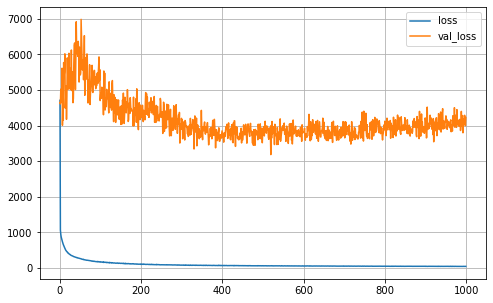

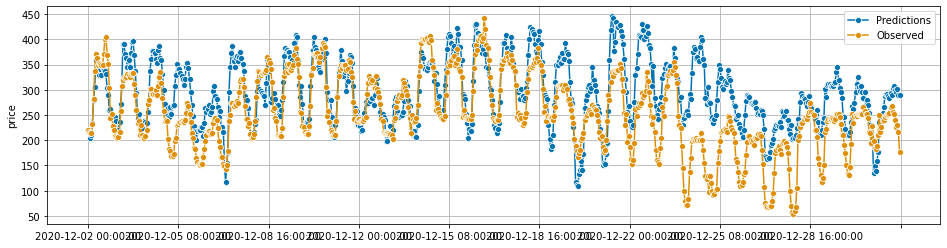

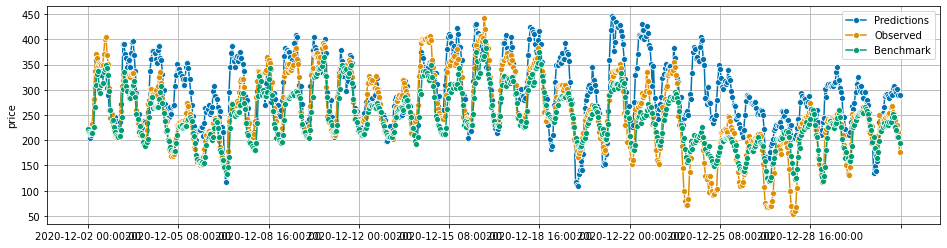

In [25]:
plot_results(model, history)

### Tuned feed-forward networks - keras-tuner

In [37]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                  min_value=32,
                                                  max_value=512,
                                                  step=32),
                               activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse')
    return model

In [38]:
N_TRIALS = 20

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=N_TRIALS,
    executions_per_trial=1,
    directory=os.path.normpath('C:/'),
    project_name='FF_NN',
)

tuner.search_space_summary()

In [39]:
tuner.search(
    X_train, 
    y_train.values, 
    epochs=500, 
    validation_data=(X_valid, y_valid.values),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)]
)

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 11:03 - loss: 45669.64 - ETA: 31s - loss: 16080.5486 - ETA: 18s - loss: 10515.56 - ETA: 12s - loss: 7966.3622 - ETA: 10s - loss: 6638.356 - ETA: 8s - loss: 5798.395 - ETA: 7s - loss: 5102.93 - ETA: 6s - loss: 4630.54 - ETA: 5s - loss: 4304.64 - ETA: 5s - loss: 4015.86 - ETA: 4s - loss: 3809.86 - ETA: 4s - loss: 3565.32 - ETA: 3s - loss: 3345.90 - ETA: 3s - loss: 3189.87 - ETA: 3s - loss: 3137.75 - ETA: 3s - loss: 3008.72 - ETA: 2s - loss: 2892.02 - ETA: 2s - loss: 2816.67 - ETA: 2s - loss: 2737.35 - ETA: 2s - loss: 2677.06 - ETA: 2s - loss: 2627.86 - ETA: 2s - loss: 2572.41 - ETA: 2s - loss: 2528.21 - ETA: 1s - loss: 2493.92 - ETA: 1s - loss: 2465.51 - ETA: 1s - loss: 2432.38 - ETA: 1s - loss: 2412.90 - ETA: 1s - loss: 2390.35 - ETA: 1s - loss: 2352.78 - ETA: 1s - loss: 2313.10 - ETA: 1s - loss: 2269.64 - ETA: 1s - loss: 2263.50 - ETA: 1s - loss: 2256.99 - ETA: 1s - loss: 224

25416/25416 [==============================] - ETA: 3s - loss: 253.057 - ETA: 1s - loss: 534.565 - ETA: 1s - loss: 682.699 - ETA: 1s - loss: 608.834 - ETA: 1s - loss: 589.263 - ETA: 1s - loss: 572.921 - ETA: 1s - loss: 618.992 - ETA: 1s - loss: 606.690 - ETA: 1s - loss: 591.955 - ETA: 1s - loss: 587.471 - ETA: 1s - loss: 570.116 - ETA: 1s - loss: 571.853 - ETA: 1s - loss: 563.035 - ETA: 1s - loss: 579.093 - ETA: 1s - loss: 597.211 - ETA: 1s - loss: 594.891 - ETA: 1s - loss: 622.679 - ETA: 1s - loss: 641.517 - ETA: 1s - loss: 636.401 - ETA: 1s - loss: 627.189 - ETA: 1s - loss: 628.796 - ETA: 1s - loss: 630.116 - ETA: 1s - loss: 628.266 - ETA: 1s - loss: 632.660 - ETA: 1s - loss: 632.597 - ETA: 1s - loss: 644.506 - ETA: 0s - loss: 642.999 - ETA: 0s - loss: 637.984 - ETA: 0s - loss: 635.354 - ETA: 0s - loss: 632.127 - ETA: 0s - loss: 635.969 - ETA: 0s - loss: 631.755 - ETA: 0s - loss: 638.488 - ETA: 0s - loss: 639.366 - ETA: 0s - loss: 639.522 - ETA: 0s - loss: 632.764 - ETA: 0s - loss: 6

25416/25416 [==============================] - ETA: 3s - loss: 234.444 - ETA: 2s - loss: 316.251 - ETA: 2s - loss: 397.630 - ETA: 2s - loss: 373.731 - ETA: 1s - loss: 359.191 - ETA: 1s - loss: 343.082 - ETA: 1s - loss: 336.252 - ETA: 1s - loss: 328.945 - ETA: 1s - loss: 334.086 - ETA: 1s - loss: 333.769 - ETA: 1s - loss: 341.057 - ETA: 1s - loss: 352.126 - ETA: 1s - loss: 364.144 - ETA: 1s - loss: 365.742 - ETA: 1s - loss: 359.551 - ETA: 1s - loss: 364.494 - ETA: 1s - loss: 365.022 - ETA: 1s - loss: 372.989 - ETA: 1s - loss: 368.736 - ETA: 1s - loss: 367.715 - ETA: 1s - loss: 363.669 - ETA: 1s - loss: 362.941 - ETA: 1s - loss: 363.788 - ETA: 1s - loss: 374.145 - ETA: 1s - loss: 374.926 - ETA: 1s - loss: 374.151 - ETA: 1s - loss: 372.633 - ETA: 0s - loss: 373.307 - ETA: 0s - loss: 372.766 - ETA: 0s - loss: 373.448 - ETA: 0s - loss: 376.176 - ETA: 0s - loss: 376.271 - ETA: 0s - loss: 372.719 - ETA: 0s - loss: 372.661 - ETA: 0s - loss: 371.313 - ETA: 0s - loss: 368.535 - ETA: 0s - loss: 3

25416/25416 [==============================] - ETA: 2s - loss: 350.995 - ETA: 1s - loss: 200.264 - ETA: 1s - loss: 202.079 - ETA: 1s - loss: 196.948 - ETA: 1s - loss: 202.272 - ETA: 1s - loss: 201.158 - ETA: 1s - loss: 204.706 - ETA: 1s - loss: 207.813 - ETA: 1s - loss: 213.936 - ETA: 1s - loss: 220.463 - ETA: 1s - loss: 224.272 - ETA: 1s - loss: 221.777 - ETA: 1s - loss: 222.047 - ETA: 1s - loss: 222.598 - ETA: 1s - loss: 228.333 - ETA: 1s - loss: 225.419 - ETA: 1s - loss: 224.758 - ETA: 1s - loss: 229.134 - ETA: 1s - loss: 231.632 - ETA: 1s - loss: 234.379 - ETA: 1s - loss: 234.624 - ETA: 0s - loss: 240.452 - ETA: 0s - loss: 245.434 - ETA: 0s - loss: 250.426 - ETA: 0s - loss: 252.807 - ETA: 0s - loss: 251.850 - ETA: 0s - loss: 249.999 - ETA: 0s - loss: 252.057 - ETA: 0s - loss: 253.593 - ETA: 0s - loss: 253.290 - ETA: 0s - loss: 254.579 - ETA: 0s - loss: 255.805 - ETA: 0s - loss: 256.066 - ETA: 0s - loss: 256.449 - ETA: 0s - loss: 255.471 - ETA: 0s - loss: 257.563 - ETA: 0s - loss: 2

25416/25416 [==============================] - ETA: 2s - loss: 184.354 - ETA: 2s - loss: 226.455 - ETA: 2s - loss: 219.585 - ETA: 2s - loss: 206.759 - ETA: 1s - loss: 207.893 - ETA: 1s - loss: 203.344 - ETA: 1s - loss: 191.365 - ETA: 1s - loss: 197.851 - ETA: 1s - loss: 193.081 - ETA: 1s - loss: 195.280 - ETA: 1s - loss: 190.987 - ETA: 1s - loss: 188.269 - ETA: 1s - loss: 192.944 - ETA: 1s - loss: 193.245 - ETA: 1s - loss: 192.150 - ETA: 1s - loss: 192.736 - ETA: 1s - loss: 197.001 - ETA: 1s - loss: 198.803 - ETA: 1s - loss: 198.413 - ETA: 1s - loss: 198.248 - ETA: 1s - loss: 196.874 - ETA: 1s - loss: 198.951 - ETA: 0s - loss: 197.034 - ETA: 0s - loss: 196.046 - ETA: 0s - loss: 194.377 - ETA: 0s - loss: 194.877 - ETA: 0s - loss: 202.387 - ETA: 0s - loss: 204.893 - ETA: 0s - loss: 205.294 - ETA: 0s - loss: 205.520 - ETA: 0s - loss: 206.081 - ETA: 0s - loss: 207.013 - ETA: 0s - loss: 206.254 - ETA: 0s - loss: 205.159 - ETA: 0s - loss: 204.336 - ETA: 0s - loss: 204.553 - ETA: 0s - loss: 2

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 10:04 - loss: 55548.19 - ETA: 1:10 - loss: 292384.69 - ETA: 39s - loss: 179074.2606 - ETA: 29s - loss: 129599.279 - ETA: 25s - loss: 108161.080 - ETA: 21s - loss: 88049.378 - ETA: 19s - loss: 76002.04 - ETA: 16s - loss: 64217.44 - ETA: 14s - loss: 54800.97 - ETA: 13s - loss: 48512.25 - ETA: 12s - loss: 42499.25 - ETA: 10s - loss: 37895.95 - ETA: 10s - loss: 34571.70 - ETA: 9s - loss: 31751.2332 - ETA: 9s - loss: 29592.337 - ETA: 8s - loss: 27940.693 - ETA: 8s - loss: 26656.309 - ETA: 8s - loss: 25128.877 - ETA: 7s - loss: 23878.883 - ETA: 7s - loss: 22714.097 - ETA: 7s - loss: 21674.656 - ETA: 7s - loss: 20622.621 - ETA: 6s - loss: 19753.025 - ETA: 6s - loss: 18938.233 - ETA: 6s - loss: 18194.343 - ETA: 6s - loss: 17505.185 - ETA: 6s - loss: 16801.852 - ETA: 5s - loss: 16186.564 - ETA: 5s - loss: 15715.438 - ETA: 5s - loss: 15334.262 - ETA: 5s - loss: 14871.400 - ETA: 5s - lo

25416/25416 [==============================] - ETA: 7s - loss: 573.538 - ETA: 5s - loss: 1205.35 - ETA: 6s - loss: 1241.22 - ETA: 5s - loss: 1509.26 - ETA: 5s - loss: 1368.93 - ETA: 5s - loss: 1303.78 - ETA: 5s - loss: 1223.31 - ETA: 5s - loss: 1189.59 - ETA: 5s - loss: 1280.80 - ETA: 4s - loss: 1263.77 - ETA: 4s - loss: 1232.29 - ETA: 4s - loss: 1187.10 - ETA: 4s - loss: 1158.61 - ETA: 4s - loss: 1150.18 - ETA: 4s - loss: 1140.58 - ETA: 4s - loss: 1128.42 - ETA: 4s - loss: 1120.63 - ETA: 4s - loss: 1122.85 - ETA: 4s - loss: 1095.57 - ETA: 4s - loss: 1106.57 - ETA: 4s - loss: 1082.31 - ETA: 4s - loss: 1054.83 - ETA: 4s - loss: 1031.94 - ETA: 4s - loss: 1036.33 - ETA: 3s - loss: 1035.56 - ETA: 3s - loss: 1060.28 - ETA: 3s - loss: 1065.49 - ETA: 3s - loss: 1057.01 - ETA: 3s - loss: 1076.93 - ETA: 3s - loss: 1062.84 - ETA: 3s - loss: 1052.40 - ETA: 3s - loss: 1048.22 - ETA: 3s - loss: 1050.70 - ETA: 3s - loss: 1039.90 - ETA: 3s - loss: 1031.14 - ETA: 3s - loss: 1035.07 - ETA: 3s - loss: 1

25416/25416 [==============================] - ETA: 7s - loss: 682.246 - ETA: 5s - loss: 1737.94 - ETA: 5s - loss: 2163.76 - ETA: 5s - loss: 1825.53 - ETA: 5s - loss: 1713.78 - ETA: 6s - loss: 1630.07 - ETA: 6s - loss: 1544.84 - ETA: 6s - loss: 1442.35 - ETA: 6s - loss: 1390.01 - ETA: 6s - loss: 1324.82 - ETA: 6s - loss: 1266.31 - ETA: 5s - loss: 1258.55 - ETA: 5s - loss: 1215.63 - ETA: 5s - loss: 1168.62 - ETA: 5s - loss: 1135.76 - ETA: 5s - loss: 1130.29 - ETA: 5s - loss: 1094.58 - ETA: 5s - loss: 1077.68 - ETA: 4s - loss: 1037.42 - ETA: 4s - loss: 1034.72 - ETA: 4s - loss: 1013.83 - ETA: 4s - loss: 1005.86 - ETA: 4s - loss: 1024.24 - ETA: 4s - loss: 1003.09 - ETA: 4s - loss: 1001.04 - ETA: 4s - loss: 991.8691 - ETA: 4s - loss: 980.546 - ETA: 4s - loss: 973.357 - ETA: 4s - loss: 960.952 - ETA: 4s - loss: 953.681 - ETA: 4s - loss: 948.051 - ETA: 4s - loss: 940.060 - ETA: 3s - loss: 936.708 - ETA: 3s - loss: 944.000 - ETA: 3s - loss: 938.571 - ETA: 3s - loss: 934.409 - ETA: 3s - loss: 

25416/25416 [==============================] - ETA: 9s - loss: 648.268 - ETA: 9s - loss: 406.767 - ETA: 7s - loss: 390.550 - ETA: 7s - loss: 465.759 - ETA: 6s - loss: 450.455 - ETA: 6s - loss: 530.631 - ETA: 6s - loss: 533.005 - ETA: 6s - loss: 556.693 - ETA: 5s - loss: 625.067 - ETA: 5s - loss: 677.534 - ETA: 5s - loss: 698.179 - ETA: 5s - loss: 741.235 - ETA: 5s - loss: 768.638 - ETA: 5s - loss: 815.008 - ETA: 4s - loss: 868.873 - ETA: 4s - loss: 854.229 - ETA: 4s - loss: 855.106 - ETA: 4s - loss: 842.624 - ETA: 4s - loss: 850.135 - ETA: 4s - loss: 843.239 - ETA: 4s - loss: 880.744 - ETA: 4s - loss: 877.303 - ETA: 4s - loss: 879.576 - ETA: 4s - loss: 877.566 - ETA: 4s - loss: 879.423 - ETA: 4s - loss: 866.715 - ETA: 4s - loss: 861.035 - ETA: 4s - loss: 862.256 - ETA: 4s - loss: 861.140 - ETA: 4s - loss: 866.843 - ETA: 4s - loss: 858.618 - ETA: 4s - loss: 859.162 - ETA: 4s - loss: 857.618 - ETA: 3s - loss: 843.144 - ETA: 3s - loss: 833.680 - ETA: 3s - loss: 823.046 - ETA: 3s - loss: 8

25416/25416 [==============================] - ETA: 5s - loss: 278.447 - ETA: 4s - loss: 501.372 - ETA: 4s - loss: 669.484 - ETA: 4s - loss: 719.463 - ETA: 4s - loss: 871.213 - ETA: 4s - loss: 870.102 - ETA: 4s - loss: 819.165 - ETA: 4s - loss: 809.105 - ETA: 4s - loss: 822.990 - ETA: 4s - loss: 808.572 - ETA: 4s - loss: 781.302 - ETA: 4s - loss: 761.689 - ETA: 4s - loss: 770.150 - ETA: 3s - loss: 754.847 - ETA: 3s - loss: 799.073 - ETA: 3s - loss: 789.875 - ETA: 3s - loss: 776.130 - ETA: 3s - loss: 768.979 - ETA: 3s - loss: 759.946 - ETA: 3s - loss: 790.201 - ETA: 3s - loss: 779.783 - ETA: 3s - loss: 775.542 - ETA: 3s - loss: 769.167 - ETA: 3s - loss: 764.151 - ETA: 3s - loss: 755.248 - ETA: 3s - loss: 755.869 - ETA: 3s - loss: 750.557 - ETA: 3s - loss: 739.442 - ETA: 3s - loss: 733.937 - ETA: 3s - loss: 735.060 - ETA: 2s - loss: 729.343 - ETA: 2s - loss: 726.380 - ETA: 2s - loss: 719.190 - ETA: 2s - loss: 711.279 - ETA: 2s - loss: 710.411 - ETA: 2s - loss: 712.900 - ETA: 2s - loss: 7

25416/25416 [==============================] - ETA: 4s - loss: 2844.50 - ETA: 4s - loss: 1602.11 - ETA: 4s - loss: 1791.97 - ETA: 4s - loss: 1764.90 - ETA: 4s - loss: 1869.80 - ETA: 4s - loss: 1814.43 - ETA: 4s - loss: 1732.56 - ETA: 4s - loss: 1699.63 - ETA: 3s - loss: 1724.08 - ETA: 3s - loss: 1703.76 - ETA: 3s - loss: 1672.88 - ETA: 3s - loss: 1664.97 - ETA: 3s - loss: 1632.37 - ETA: 3s - loss: 1604.68 - ETA: 3s - loss: 1580.36 - ETA: 3s - loss: 1565.08 - ETA: 3s - loss: 1543.24 - ETA: 3s - loss: 1523.89 - ETA: 3s - loss: 1498.90 - ETA: 3s - loss: 1517.23 - ETA: 3s - loss: 1502.51 - ETA: 3s - loss: 1488.37 - ETA: 3s - loss: 1479.92 - ETA: 3s - loss: 1479.87 - ETA: 3s - loss: 1471.78 - ETA: 2s - loss: 1503.07 - ETA: 2s - loss: 1533.97 - ETA: 2s - loss: 1554.81 - ETA: 2s - loss: 1538.35 - ETA: 2s - loss: 1534.83 - ETA: 2s - loss: 1522.88 - ETA: 2s - loss: 1513.30 - ETA: 2s - loss: 1494.94 - ETA: 2s - loss: 1483.06 - ETA: 2s - loss: 1472.48 - ETA: 2s - loss: 1463.09 - ETA: 2s - loss: 1

25416/25416 [==============================] - ETA: 5s - loss: 5684.35 - ETA: 5s - loss: 1295.49 - ETA: 4s - loss: 897.2400 - ETA: 4s - loss: 804.762 - ETA: 4s - loss: 837.328 - ETA: 4s - loss: 755.109 - ETA: 4s - loss: 703.508 - ETA: 4s - loss: 678.783 - ETA: 4s - loss: 665.226 - ETA: 4s - loss: 671.488 - ETA: 4s - loss: 665.915 - ETA: 4s - loss: 657.482 - ETA: 3s - loss: 672.312 - ETA: 3s - loss: 685.892 - ETA: 3s - loss: 702.011 - ETA: 3s - loss: 696.606 - ETA: 3s - loss: 712.029 - ETA: 3s - loss: 713.417 - ETA: 3s - loss: 728.288 - ETA: 3s - loss: 717.932 - ETA: 3s - loss: 710.259 - ETA: 3s - loss: 706.396 - ETA: 3s - loss: 709.980 - ETA: 3s - loss: 710.046 - ETA: 3s - loss: 705.208 - ETA: 3s - loss: 707.574 - ETA: 3s - loss: 706.034 - ETA: 2s - loss: 700.417 - ETA: 2s - loss: 727.846 - ETA: 2s - loss: 721.098 - ETA: 2s - loss: 729.111 - ETA: 2s - loss: 726.769 - ETA: 2s - loss: 733.218 - ETA: 2s - loss: 733.203 - ETA: 2s - loss: 729.047 - ETA: 2s - loss: 722.633 - ETA: 2s - loss: 

25416/25416 [==============================] - ETA: 5s - loss: 559.939 - ETA: 3s - loss: 716.229 - ETA: 3s - loss: 762.165 - ETA: 3s - loss: 967.131 - ETA: 3s - loss: 920.383 - ETA: 3s - loss: 862.481 - ETA: 3s - loss: 827.445 - ETA: 3s - loss: 824.347 - ETA: 3s - loss: 794.429 - ETA: 3s - loss: 796.725 - ETA: 3s - loss: 809.142 - ETA: 3s - loss: 836.454 - ETA: 3s - loss: 846.844 - ETA: 3s - loss: 834.714 - ETA: 3s - loss: 811.297 - ETA: 3s - loss: 792.025 - ETA: 3s - loss: 789.322 - ETA: 3s - loss: 772.396 - ETA: 3s - loss: 759.744 - ETA: 3s - loss: 742.376 - ETA: 3s - loss: 732.648 - ETA: 2s - loss: 751.573 - ETA: 2s - loss: 749.456 - ETA: 2s - loss: 737.845 - ETA: 2s - loss: 734.450 - ETA: 2s - loss: 723.866 - ETA: 2s - loss: 710.705 - ETA: 2s - loss: 699.860 - ETA: 2s - loss: 696.954 - ETA: 2s - loss: 690.226 - ETA: 2s - loss: 703.708 - ETA: 2s - loss: 708.135 - ETA: 2s - loss: 709.850 - ETA: 2s - loss: 705.019 - ETA: 2s - loss: 704.786 - ETA: 2s - loss: 696.722 - ETA: 2s - loss: 7

25416/25416 [==============================] - ETA: 3s - loss: 366.721 - ETA: 3s - loss: 593.697 - ETA: 3s - loss: 548.811 - ETA: 3s - loss: 508.643 - ETA: 3s - loss: 495.317 - ETA: 3s - loss: 471.258 - ETA: 3s - loss: 501.936 - ETA: 3s - loss: 528.193 - ETA: 3s - loss: 542.249 - ETA: 3s - loss: 529.516 - ETA: 3s - loss: 523.028 - ETA: 3s - loss: 508.403 - ETA: 3s - loss: 504.025 - ETA: 3s - loss: 489.990 - ETA: 2s - loss: 495.124 - ETA: 2s - loss: 485.561 - ETA: 2s - loss: 484.937 - ETA: 2s - loss: 488.191 - ETA: 2s - loss: 487.002 - ETA: 2s - loss: 485.878 - ETA: 2s - loss: 483.994 - ETA: 2s - loss: 485.632 - ETA: 2s - loss: 482.826 - ETA: 2s - loss: 487.473 - ETA: 2s - loss: 485.343 - ETA: 2s - loss: 487.359 - ETA: 2s - loss: 482.725 - ETA: 2s - loss: 481.437 - ETA: 2s - loss: 481.095 - ETA: 2s - loss: 490.188 - ETA: 2s - loss: 494.779 - ETA: 2s - loss: 496.290 - ETA: 2s - loss: 495.026 - ETA: 1s - loss: 496.358 - ETA: 1s - loss: 493.413 - ETA: 1s - loss: 494.528 - ETA: 1s - loss: 4

25416/25416 [==============================] - ETA: 5s - loss: 465.036 - ETA: 3s - loss: 333.716 - ETA: 3s - loss: 391.974 - ETA: 3s - loss: 362.585 - ETA: 3s - loss: 408.778 - ETA: 4s - loss: 448.463 - ETA: 4s - loss: 467.922 - ETA: 4s - loss: 500.939 - ETA: 4s - loss: 524.732 - ETA: 4s - loss: 536.761 - ETA: 4s - loss: 548.571 - ETA: 4s - loss: 542.694 - ETA: 4s - loss: 546.243 - ETA: 4s - loss: 549.651 - ETA: 3s - loss: 541.849 - ETA: 3s - loss: 528.892 - ETA: 3s - loss: 531.546 - ETA: 3s - loss: 552.097 - ETA: 3s - loss: 545.040 - ETA: 3s - loss: 536.288 - ETA: 3s - loss: 526.454 - ETA: 3s - loss: 518.698 - ETA: 3s - loss: 515.074 - ETA: 3s - loss: 508.586 - ETA: 3s - loss: 528.623 - ETA: 2s - loss: 534.895 - ETA: 2s - loss: 538.948 - ETA: 2s - loss: 535.792 - ETA: 2s - loss: 539.492 - ETA: 2s - loss: 536.516 - ETA: 2s - loss: 536.085 - ETA: 2s - loss: 536.252 - ETA: 2s - loss: 538.803 - ETA: 2s - loss: 534.490 - ETA: 2s - loss: 534.981 - ETA: 2s - loss: 535.967 - ETA: 2s - loss: 5

Epoch 57/500
25416/25416 [==============================] - ETA: 5s - loss: 444.363 - ETA: 3s - loss: 387.224 - ETA: 3s - loss: 500.928 - ETA: 3s - loss: 459.219 - ETA: 3s - loss: 451.527 - ETA: 3s - loss: 465.499 - ETA: 3s - loss: 440.928 - ETA: 3s - loss: 469.540 - ETA: 3s - loss: 478.841 - ETA: 3s - loss: 495.529 - ETA: 3s - loss: 485.888 - ETA: 3s - loss: 512.154 - ETA: 3s - loss: 498.705 - ETA: 3s - loss: 511.615 - ETA: 3s - loss: 515.202 - ETA: 3s - loss: 506.640 - ETA: 3s - loss: 516.146 - ETA: 3s - loss: 508.679 - ETA: 3s - loss: 505.544 - ETA: 2s - loss: 502.831 - ETA: 2s - loss: 499.693 - ETA: 2s - loss: 495.973 - ETA: 2s - loss: 499.011 - ETA: 2s - loss: 494.712 - ETA: 2s - loss: 490.184 - ETA: 2s - loss: 492.493 - ETA: 2s - loss: 486.542 - ETA: 2s - loss: 485.180 - ETA: 2s - loss: 494.891 - ETA: 2s - loss: 489.571 - ETA: 2s - loss: 491.224 - ETA: 2s - loss: 487.901 - ETA: 2s - loss: 491.443 - ETA: 2s - loss: 488.606 - ETA: 2s - loss: 488.740 - ETA: 2s - loss: 487.577 - ETA:

25416/25416 [==============================] - ETA: 5s - loss: 140.219 - ETA: 4s - loss: 346.000 - ETA: 4s - loss: 363.073 - ETA: 3s - loss: 360.641 - ETA: 3s - loss: 387.267 - ETA: 3s - loss: 406.367 - ETA: 3s - loss: 405.861 - ETA: 3s - loss: 393.712 - ETA: 3s - loss: 383.573 - ETA: 3s - loss: 372.537 - ETA: 3s - loss: 377.766 - ETA: 3s - loss: 382.190 - ETA: 3s - loss: 371.343 - ETA: 3s - loss: 368.651 - ETA: 3s - loss: 372.774 - ETA: 3s - loss: 369.013 - ETA: 3s - loss: 369.370 - ETA: 3s - loss: 367.760 - ETA: 3s - loss: 365.624 - ETA: 3s - loss: 372.693 - ETA: 3s - loss: 367.838 - ETA: 2s - loss: 364.595 - ETA: 2s - loss: 362.044 - ETA: 2s - loss: 358.652 - ETA: 2s - loss: 354.281 - ETA: 2s - loss: 354.071 - ETA: 2s - loss: 365.793 - ETA: 2s - loss: 364.055 - ETA: 2s - loss: 367.714 - ETA: 2s - loss: 368.045 - ETA: 2s - loss: 364.909 - ETA: 2s - loss: 362.459 - ETA: 2s - loss: 362.536 - ETA: 2s - loss: 360.735 - ETA: 2s - loss: 358.541 - ETA: 2s - loss: 356.243 - ETA: 2s - loss: 3

25416/25416 [==============================] - ETA: 5s - loss: 2764.93 - ETA: 4s - loss: 2991.82 - ETA: 4s - loss: 3283.45 - ETA: 4s - loss: 3438.75 - ETA: 3s - loss: 3428.02 - ETA: 3s - loss: 3551.19 - ETA: 3s - loss: 3571.20 - ETA: 3s - loss: 3559.39 - ETA: 3s - loss: 3515.13 - ETA: 3s - loss: 3466.82 - ETA: 3s - loss: 3413.33 - ETA: 3s - loss: 3430.01 - ETA: 3s - loss: 3479.87 - ETA: 3s - loss: 3520.69 - ETA: 3s - loss: 3511.15 - ETA: 3s - loss: 3502.47 - ETA: 3s - loss: 3497.05 - ETA: 3s - loss: 3564.18 - ETA: 3s - loss: 3560.60 - ETA: 3s - loss: 3537.31 - ETA: 3s - loss: 3549.21 - ETA: 3s - loss: 3531.66 - ETA: 3s - loss: 3522.96 - ETA: 2s - loss: 3491.39 - ETA: 2s - loss: 3523.87 - ETA: 2s - loss: 3558.34 - ETA: 2s - loss: 3554.60 - ETA: 2s - loss: 3551.20 - ETA: 2s - loss: 3527.42 - ETA: 2s - loss: 3519.90 - ETA: 2s - loss: 3521.92 - ETA: 2s - loss: 3560.57 - ETA: 2s - loss: 3546.76 - ETA: 2s - loss: 3550.63 - ETA: 2s - loss: 3534.42 - ETA: 2s - loss: 3535.29 - ETA: 2s - loss: 3

25416/25416 [==============================] - ETA: 5s - loss: 3148.66 - ETA: 4s - loss: 2787.38 - ETA: 4s - loss: 3223.39 - ETA: 4s - loss: 3342.22 - ETA: 4s - loss: 3369.30 - ETA: 4s - loss: 3465.05 - ETA: 4s - loss: 3375.72 - ETA: 3s - loss: 3459.34 - ETA: 3s - loss: 3467.71 - ETA: 3s - loss: 3479.85 - ETA: 3s - loss: 3518.26 - ETA: 3s - loss: 3585.09 - ETA: 3s - loss: 3629.87 - ETA: 3s - loss: 3611.24 - ETA: 3s - loss: 3568.24 - ETA: 3s - loss: 3547.71 - ETA: 3s - loss: 3559.49 - ETA: 3s - loss: 3597.08 - ETA: 3s - loss: 3594.05 - ETA: 3s - loss: 3586.40 - ETA: 3s - loss: 3555.81 - ETA: 3s - loss: 3567.97 - ETA: 3s - loss: 3608.06 - ETA: 3s - loss: 3608.72 - ETA: 3s - loss: 3617.96 - ETA: 3s - loss: 3604.27 - ETA: 3s - loss: 3576.41 - ETA: 3s - loss: 3594.04 - ETA: 3s - loss: 3599.04 - ETA: 3s - loss: 3574.60 - ETA: 3s - loss: 3561.84 - ETA: 3s - loss: 3555.56 - ETA: 3s - loss: 3549.63 - ETA: 3s - loss: 3540.69 - ETA: 3s - loss: 3540.78 - ETA: 3s - loss: 3536.35 - ETA: 3s - loss: 3

25416/25416 [==============================] - ETA: 6s - loss: 1050.51 - ETA: 7s - loss: 1007.67 - ETA: 6s - loss: 939.9341 - ETA: 5s - loss: 916.772 - ETA: 5s - loss: 1061.61 - ETA: 5s - loss: 1070.73 - ETA: 5s - loss: 1038.59 - ETA: 5s - loss: 1049.81 - ETA: 5s - loss: 1051.59 - ETA: 5s - loss: 1067.28 - ETA: 5s - loss: 1106.03 - ETA: 5s - loss: 1160.36 - ETA: 5s - loss: 1218.34 - ETA: 5s - loss: 1349.24 - ETA: 4s - loss: 1389.46 - ETA: 4s - loss: 1368.05 - ETA: 4s - loss: 1382.22 - ETA: 4s - loss: 1386.89 - ETA: 4s - loss: 1382.83 - ETA: 4s - loss: 1380.23 - ETA: 4s - loss: 1390.78 - ETA: 4s - loss: 1380.50 - ETA: 4s - loss: 1375.03 - ETA: 4s - loss: 1373.39 - ETA: 4s - loss: 1380.62 - ETA: 4s - loss: 1378.64 - ETA: 4s - loss: 1368.52 - ETA: 4s - loss: 1380.05 - ETA: 4s - loss: 1377.75 - ETA: 3s - loss: 1367.78 - ETA: 3s - loss: 1360.21 - ETA: 3s - loss: 1355.29 - ETA: 3s - loss: 1341.04 - ETA: 3s - loss: 1328.11 - ETA: 3s - loss: 1323.18 - ETA: 3s - loss: 1320.71 - ETA: 3s - loss: 

25416/25416 [==============================] - ETA: 5s - loss: 866.270 - ETA: 4s - loss: 827.231 - ETA: 5s - loss: 1025.98 - ETA: 5s - loss: 935.5846 - ETA: 5s - loss: 972.477 - ETA: 5s - loss: 959.131 - ETA: 5s - loss: 919.761 - ETA: 5s - loss: 881.732 - ETA: 4s - loss: 855.436 - ETA: 4s - loss: 851.190 - ETA: 4s - loss: 874.985 - ETA: 4s - loss: 933.439 - ETA: 4s - loss: 940.480 - ETA: 4s - loss: 981.943 - ETA: 4s - loss: 970.317 - ETA: 4s - loss: 960.539 - ETA: 4s - loss: 952.010 - ETA: 4s - loss: 928.138 - ETA: 4s - loss: 919.886 - ETA: 4s - loss: 908.090 - ETA: 4s - loss: 921.903 - ETA: 4s - loss: 907.326 - ETA: 4s - loss: 894.860 - ETA: 4s - loss: 893.490 - ETA: 4s - loss: 885.074 - ETA: 4s - loss: 882.784 - ETA: 3s - loss: 879.969 - ETA: 3s - loss: 879.322 - ETA: 3s - loss: 874.822 - ETA: 3s - loss: 869.240 - ETA: 3s - loss: 873.653 - ETA: 3s - loss: 877.549 - ETA: 3s - loss: 872.884 - ETA: 3s - loss: 864.562 - ETA: 3s - loss: 858.887 - ETA: 3s - loss: 856.262 - ETA: 3s - loss: 

25416/25416 [==============================] - ETA: 6s - loss: 398.225 - ETA: 5s - loss: 571.765 - ETA: 5s - loss: 900.061 - ETA: 5s - loss: 843.484 - ETA: 5s - loss: 819.295 - ETA: 5s - loss: 781.742 - ETA: 5s - loss: 841.797 - ETA: 5s - loss: 806.610 - ETA: 5s - loss: 775.347 - ETA: 4s - loss: 762.777 - ETA: 4s - loss: 761.205 - ETA: 4s - loss: 736.760 - ETA: 4s - loss: 748.146 - ETA: 4s - loss: 739.661 - ETA: 4s - loss: 767.553 - ETA: 4s - loss: 776.548 - ETA: 4s - loss: 765.280 - ETA: 4s - loss: 764.650 - ETA: 4s - loss: 770.208 - ETA: 4s - loss: 787.008 - ETA: 4s - loss: 791.573 - ETA: 4s - loss: 822.952 - ETA: 4s - loss: 819.257 - ETA: 4s - loss: 816.920 - ETA: 4s - loss: 813.813 - ETA: 4s - loss: 813.955 - ETA: 4s - loss: 808.366 - ETA: 3s - loss: 811.586 - ETA: 3s - loss: 809.929 - ETA: 3s - loss: 810.446 - ETA: 3s - loss: 810.618 - ETA: 3s - loss: 801.627 - ETA: 3s - loss: 792.600 - ETA: 3s - loss: 789.284 - ETA: 3s - loss: 786.689 - ETA: 3s - loss: 801.531 - ETA: 3s - loss: 7

25416/25416 [==============================] - ETA: 5s - loss: 668.492 - ETA: 5s - loss: 471.487 - ETA: 5s - loss: 768.234 - ETA: 5s - loss: 728.815 - ETA: 5s - loss: 708.839 - ETA: 5s - loss: 765.281 - ETA: 5s - loss: 748.700 - ETA: 5s - loss: 709.222 - ETA: 4s - loss: 705.370 - ETA: 4s - loss: 709.128 - ETA: 4s - loss: 716.335 - ETA: 4s - loss: 704.935 - ETA: 4s - loss: 708.905 - ETA: 4s - loss: 686.265 - ETA: 4s - loss: 717.383 - ETA: 4s - loss: 717.084 - ETA: 4s - loss: 708.650 - ETA: 4s - loss: 699.832 - ETA: 4s - loss: 697.701 - ETA: 4s - loss: 692.924 - ETA: 4s - loss: 684.579 - ETA: 4s - loss: 684.352 - ETA: 4s - loss: 677.085 - ETA: 4s - loss: 674.293 - ETA: 4s - loss: 667.310 - ETA: 4s - loss: 669.465 - ETA: 3s - loss: 668.637 - ETA: 3s - loss: 663.981 - ETA: 3s - loss: 660.187 - ETA: 3s - loss: 665.350 - ETA: 3s - loss: 666.794 - ETA: 3s - loss: 666.857 - ETA: 3s - loss: 664.518 - ETA: 3s - loss: 657.709 - ETA: 3s - loss: 673.947 - ETA: 3s - loss: 674.740 - ETA: 3s - loss: 6

25416/25416 [==============================] - ETA: 7s - loss: 687.334 - ETA: 5s - loss: 903.479 - ETA: 5s - loss: 723.994 - ETA: 5s - loss: 792.356 - ETA: 5s - loss: 742.547 - ETA: 5s - loss: 718.709 - ETA: 5s - loss: 704.652 - ETA: 5s - loss: 695.091 - ETA: 5s - loss: 668.757 - ETA: 4s - loss: 650.246 - ETA: 4s - loss: 637.541 - ETA: 4s - loss: 608.590 - ETA: 4s - loss: 621.197 - ETA: 4s - loss: 610.140 - ETA: 4s - loss: 601.254 - ETA: 4s - loss: 606.046 - ETA: 4s - loss: 606.776 - ETA: 4s - loss: 597.346 - ETA: 4s - loss: 584.953 - ETA: 4s - loss: 578.014 - ETA: 4s - loss: 590.664 - ETA: 4s - loss: 590.048 - ETA: 4s - loss: 593.593 - ETA: 4s - loss: 616.285 - ETA: 4s - loss: 627.364 - ETA: 4s - loss: 624.565 - ETA: 4s - loss: 621.040 - ETA: 3s - loss: 626.582 - ETA: 3s - loss: 631.602 - ETA: 3s - loss: 636.762 - ETA: 3s - loss: 635.269 - ETA: 3s - loss: 643.376 - ETA: 3s - loss: 643.730 - ETA: 3s - loss: 647.228 - ETA: 3s - loss: 650.327 - ETA: 3s - loss: 641.892 - ETA: 3s - loss: 6

25416/25416 [==============================] - ETA: 5s - loss: 342.492 - ETA: 5s - loss: 398.021 - ETA: 5s - loss: 475.356 - ETA: 5s - loss: 512.478 - ETA: 5s - loss: 518.665 - ETA: 5s - loss: 514.923 - ETA: 5s - loss: 497.324 - ETA: 5s - loss: 546.051 - ETA: 5s - loss: 539.198 - ETA: 4s - loss: 540.497 - ETA: 4s - loss: 546.022 - ETA: 4s - loss: 573.059 - ETA: 4s - loss: 579.071 - ETA: 4s - loss: 574.430 - ETA: 4s - loss: 589.237 - ETA: 4s - loss: 587.167 - ETA: 4s - loss: 585.557 - ETA: 4s - loss: 583.152 - ETA: 4s - loss: 574.351 - ETA: 4s - loss: 592.998 - ETA: 4s - loss: 584.911 - ETA: 4s - loss: 581.990 - ETA: 4s - loss: 579.006 - ETA: 4s - loss: 584.527 - ETA: 4s - loss: 584.560 - ETA: 4s - loss: 580.364 - ETA: 3s - loss: 579.241 - ETA: 3s - loss: 572.270 - ETA: 3s - loss: 566.174 - ETA: 3s - loss: 569.322 - ETA: 3s - loss: 583.604 - ETA: 3s - loss: 603.930 - ETA: 3s - loss: 607.140 - ETA: 3s - loss: 610.664 - ETA: 3s - loss: 614.861 - ETA: 3s - loss: 616.784 - ETA: 3s - loss: 6

25416/25416 [==============================] - ETA: 7s - loss: 521.598 - ETA: 6s - loss: 351.017 - ETA: 5s - loss: 372.974 - ETA: 5s - loss: 384.130 - ETA: 5s - loss: 374.634 - ETA: 5s - loss: 387.422 - ETA: 5s - loss: 387.604 - ETA: 5s - loss: 378.892 - ETA: 5s - loss: 377.056 - ETA: 5s - loss: 370.669 - ETA: 5s - loss: 378.937 - ETA: 5s - loss: 382.281 - ETA: 5s - loss: 390.830 - ETA: 5s - loss: 411.011 - ETA: 5s - loss: 413.245 - ETA: 5s - loss: 412.603 - ETA: 5s - loss: 405.314 - ETA: 5s - loss: 397.600 - ETA: 5s - loss: 396.949 - ETA: 5s - loss: 394.682 - ETA: 5s - loss: 391.426 - ETA: 5s - loss: 413.438 - ETA: 5s - loss: 458.115 - ETA: 5s - loss: 481.461 - ETA: 5s - loss: 509.504 - ETA: 4s - loss: 531.397 - ETA: 4s - loss: 540.626 - ETA: 4s - loss: 549.424 - ETA: 4s - loss: 574.509 - ETA: 4s - loss: 582.041 - ETA: 4s - loss: 603.872 - ETA: 4s - loss: 614.946 - ETA: 4s - loss: 622.115 - ETA: 4s - loss: 624.998 - ETA: 4s - loss: 632.992 - ETA: 4s - loss: 641.850 - ETA: 4s - loss: 6

25416/25416 [==============================] - ETA: 6s - loss: 335.363 - ETA: 5s - loss: 376.292 - ETA: 5s - loss: 409.764 - ETA: 5s - loss: 410.897 - ETA: 5s - loss: 397.211 - ETA: 5s - loss: 383.516 - ETA: 5s - loss: 413.680 - ETA: 5s - loss: 413.293 - ETA: 5s - loss: 431.084 - ETA: 5s - loss: 431.700 - ETA: 5s - loss: 446.795 - ETA: 4s - loss: 445.720 - ETA: 4s - loss: 433.916 - ETA: 4s - loss: 433.468 - ETA: 4s - loss: 432.431 - ETA: 4s - loss: 426.977 - ETA: 4s - loss: 446.594 - ETA: 4s - loss: 443.219 - ETA: 4s - loss: 446.218 - ETA: 4s - loss: 442.408 - ETA: 4s - loss: 437.039 - ETA: 4s - loss: 439.589 - ETA: 4s - loss: 443.299 - ETA: 4s - loss: 445.989 - ETA: 4s - loss: 444.030 - ETA: 4s - loss: 446.718 - ETA: 4s - loss: 442.354 - ETA: 4s - loss: 438.277 - ETA: 4s - loss: 433.377 - ETA: 4s - loss: 448.834 - ETA: 3s - loss: 456.647 - ETA: 3s - loss: 455.560 - ETA: 3s - loss: 452.393 - ETA: 3s - loss: 453.340 - ETA: 3s - loss: 459.291 - ETA: 3s - loss: 467.446 - ETA: 3s - loss: 4

25416/25416 [==============================] - ETA: 5s - loss: 394.335 - ETA: 5s - loss: 443.442 - ETA: 5s - loss: 404.922 - ETA: 5s - loss: 420.043 - ETA: 5s - loss: 420.759 - ETA: 5s - loss: 402.759 - ETA: 5s - loss: 392.037 - ETA: 5s - loss: 394.843 - ETA: 5s - loss: 392.017 - ETA: 5s - loss: 387.923 - ETA: 5s - loss: 392.534 - ETA: 5s - loss: 407.474 - ETA: 5s - loss: 426.175 - ETA: 5s - loss: 429.653 - ETA: 5s - loss: 429.047 - ETA: 5s - loss: 425.269 - ETA: 5s - loss: 422.389 - ETA: 5s - loss: 421.231 - ETA: 5s - loss: 422.400 - ETA: 4s - loss: 424.179 - ETA: 4s - loss: 423.554 - ETA: 4s - loss: 430.065 - ETA: 4s - loss: 436.720 - ETA: 4s - loss: 449.174 - ETA: 4s - loss: 449.860 - ETA: 4s - loss: 453.965 - ETA: 4s - loss: 450.587 - ETA: 4s - loss: 454.016 - ETA: 4s - loss: 450.971 - ETA: 4s - loss: 447.785 - ETA: 4s - loss: 448.758 - ETA: 4s - loss: 447.126 - ETA: 4s - loss: 449.124 - ETA: 4s - loss: 447.876 - ETA: 4s - loss: 443.993 - ETA: 3s - loss: 440.890 - ETA: 3s - loss: 4

25416/25416 [==============================] - ETA: 5s - loss: 532.096 - ETA: 5s - loss: 577.913 - ETA: 5s - loss: 497.894 - ETA: 5s - loss: 509.221 - ETA: 5s - loss: 547.239 - ETA: 5s - loss: 597.291 - ETA: 5s - loss: 593.589 - ETA: 5s - loss: 611.867 - ETA: 5s - loss: 625.805 - ETA: 5s - loss: 638.234 - ETA: 5s - loss: 624.517 - ETA: 5s - loss: 609.273 - ETA: 4s - loss: 605.307 - ETA: 4s - loss: 629.479 - ETA: 4s - loss: 612.755 - ETA: 4s - loss: 599.593 - ETA: 4s - loss: 589.137 - ETA: 4s - loss: 575.120 - ETA: 4s - loss: 562.151 - ETA: 4s - loss: 555.550 - ETA: 4s - loss: 542.537 - ETA: 4s - loss: 534.866 - ETA: 4s - loss: 533.406 - ETA: 4s - loss: 528.476 - ETA: 4s - loss: 523.167 - ETA: 4s - loss: 517.535 - ETA: 4s - loss: 513.570 - ETA: 4s - loss: 515.659 - ETA: 4s - loss: 514.995 - ETA: 4s - loss: 513.567 - ETA: 4s - loss: 509.294 - ETA: 3s - loss: 508.032 - ETA: 3s - loss: 509.579 - ETA: 3s - loss: 507.918 - ETA: 3s - loss: 501.648 - ETA: 3s - loss: 501.728 - ETA: 3s - loss: 5

25416/25416 [==============================] - ETA: 5s - loss: 461.454 - ETA: 5s - loss: 591.904 - ETA: 5s - loss: 641.408 - ETA: 5s - loss: 688.752 - ETA: 5s - loss: 705.139 - ETA: 5s - loss: 685.479 - ETA: 5s - loss: 692.072 - ETA: 5s - loss: 665.143 - ETA: 5s - loss: 651.205 - ETA: 5s - loss: 655.423 - ETA: 5s - loss: 650.711 - ETA: 5s - loss: 638.387 - ETA: 5s - loss: 624.422 - ETA: 5s - loss: 600.327 - ETA: 5s - loss: 588.619 - ETA: 4s - loss: 582.481 - ETA: 4s - loss: 576.554 - ETA: 4s - loss: 571.176 - ETA: 4s - loss: 563.340 - ETA: 4s - loss: 553.557 - ETA: 4s - loss: 548.837 - ETA: 4s - loss: 544.730 - ETA: 4s - loss: 541.483 - ETA: 4s - loss: 536.950 - ETA: 4s - loss: 534.287 - ETA: 4s - loss: 532.989 - ETA: 4s - loss: 528.824 - ETA: 4s - loss: 524.478 - ETA: 4s - loss: 519.057 - ETA: 4s - loss: 513.992 - ETA: 4s - loss: 519.941 - ETA: 4s - loss: 516.071 - ETA: 3s - loss: 512.680 - ETA: 3s - loss: 509.840 - ETA: 3s - loss: 508.294 - ETA: 3s - loss: 503.141 - ETA: 3s - loss: 5

25416/25416 [==============================] - ETA: 5s - loss: 592.831 - ETA: 5s - loss: 496.999 - ETA: 5s - loss: 500.695 - ETA: 5s - loss: 434.873 - ETA: 5s - loss: 470.785 - ETA: 5s - loss: 444.060 - ETA: 5s - loss: 428.147 - ETA: 5s - loss: 417.291 - ETA: 5s - loss: 396.941 - ETA: 5s - loss: 397.052 - ETA: 5s - loss: 407.076 - ETA: 5s - loss: 399.752 - ETA: 5s - loss: 394.362 - ETA: 4s - loss: 400.403 - ETA: 4s - loss: 396.657 - ETA: 4s - loss: 396.181 - ETA: 4s - loss: 394.922 - ETA: 4s - loss: 392.389 - ETA: 4s - loss: 390.426 - ETA: 4s - loss: 395.807 - ETA: 4s - loss: 393.138 - ETA: 4s - loss: 387.655 - ETA: 4s - loss: 388.049 - ETA: 4s - loss: 385.597 - ETA: 4s - loss: 382.294 - ETA: 4s - loss: 380.303 - ETA: 4s - loss: 376.963 - ETA: 4s - loss: 370.945 - ETA: 4s - loss: 366.839 - ETA: 4s - loss: 378.835 - ETA: 3s - loss: 383.831 - ETA: 3s - loss: 382.561 - ETA: 3s - loss: 383.353 - ETA: 3s - loss: 390.990 - ETA: 3s - loss: 392.044 - ETA: 3s - loss: 394.550 - ETA: 3s - loss: 3

25416/25416 [==============================] - ETA: 5s - loss: 173.712 - ETA: 5s - loss: 278.769 - ETA: 5s - loss: 309.235 - ETA: 5s - loss: 337.393 - ETA: 5s - loss: 351.420 - ETA: 5s - loss: 329.712 - ETA: 5s - loss: 313.266 - ETA: 5s - loss: 303.981 - ETA: 5s - loss: 306.601 - ETA: 5s - loss: 301.290 - ETA: 4s - loss: 298.757 - ETA: 4s - loss: 299.165 - ETA: 4s - loss: 301.685 - ETA: 4s - loss: 302.907 - ETA: 4s - loss: 306.946 - ETA: 4s - loss: 309.566 - ETA: 4s - loss: 310.583 - ETA: 4s - loss: 309.884 - ETA: 4s - loss: 304.626 - ETA: 4s - loss: 304.962 - ETA: 4s - loss: 303.956 - ETA: 4s - loss: 305.877 - ETA: 4s - loss: 306.417 - ETA: 4s - loss: 307.304 - ETA: 4s - loss: 304.345 - ETA: 4s - loss: 305.349 - ETA: 4s - loss: 303.687 - ETA: 4s - loss: 304.091 - ETA: 4s - loss: 302.059 - ETA: 4s - loss: 300.431 - ETA: 4s - loss: 304.432 - ETA: 3s - loss: 312.184 - ETA: 3s - loss: 313.562 - ETA: 3s - loss: 318.132 - ETA: 3s - loss: 317.272 - ETA: 3s - loss: 316.468 - ETA: 3s - loss: 3

25416/25416 [==============================] - ETA: 6s - loss: 810.369 - ETA: 5s - loss: 552.321 - ETA: 5s - loss: 951.837 - ETA: 5s - loss: 819.217 - ETA: 5s - loss: 731.073 - ETA: 5s - loss: 704.753 - ETA: 5s - loss: 676.060 - ETA: 5s - loss: 666.596 - ETA: 5s - loss: 649.599 - ETA: 5s - loss: 628.975 - ETA: 5s - loss: 624.168 - ETA: 5s - loss: 617.227 - ETA: 4s - loss: 599.889 - ETA: 4s - loss: 587.916 - ETA: 4s - loss: 581.813 - ETA: 4s - loss: 587.227 - ETA: 4s - loss: 617.698 - ETA: 4s - loss: 630.296 - ETA: 4s - loss: 646.129 - ETA: 4s - loss: 656.040 - ETA: 4s - loss: 649.203 - ETA: 4s - loss: 636.200 - ETA: 4s - loss: 626.382 - ETA: 4s - loss: 618.769 - ETA: 4s - loss: 610.609 - ETA: 4s - loss: 625.714 - ETA: 4s - loss: 623.637 - ETA: 4s - loss: 615.732 - ETA: 4s - loss: 623.648 - ETA: 3s - loss: 616.565 - ETA: 3s - loss: 611.253 - ETA: 3s - loss: 608.243 - ETA: 3s - loss: 600.593 - ETA: 3s - loss: 601.348 - ETA: 3s - loss: 599.527 - ETA: 3s - loss: 590.984 - ETA: 3s - loss: 5

25416/25416 [==============================] - ETA: 5s - loss: 587.955 - ETA: 5s - loss: 524.379 - ETA: 5s - loss: 520.556 - ETA: 5s - loss: 512.721 - ETA: 5s - loss: 524.211 - ETA: 5s - loss: 513.313 - ETA: 5s - loss: 557.545 - ETA: 5s - loss: 564.575 - ETA: 5s - loss: 578.484 - ETA: 5s - loss: 565.813 - ETA: 5s - loss: 553.770 - ETA: 4s - loss: 548.670 - ETA: 4s - loss: 544.115 - ETA: 4s - loss: 537.992 - ETA: 4s - loss: 532.108 - ETA: 4s - loss: 521.854 - ETA: 4s - loss: 517.054 - ETA: 4s - loss: 516.846 - ETA: 4s - loss: 509.875 - ETA: 4s - loss: 511.591 - ETA: 4s - loss: 513.360 - ETA: 4s - loss: 514.101 - ETA: 4s - loss: 521.955 - ETA: 4s - loss: 527.837 - ETA: 4s - loss: 537.662 - ETA: 4s - loss: 535.209 - ETA: 4s - loss: 530.959 - ETA: 4s - loss: 530.699 - ETA: 4s - loss: 530.305 - ETA: 4s - loss: 528.000 - ETA: 3s - loss: 523.040 - ETA: 3s - loss: 517.850 - ETA: 3s - loss: 520.986 - ETA: 3s - loss: 545.962 - ETA: 3s - loss: 566.814 - ETA: 3s - loss: 589.512 - ETA: 3s - loss: 5

25416/25416 [==============================] - ETA: 5s - loss: 502.753 - ETA: 5s - loss: 579.627 - ETA: 5s - loss: 441.998 - ETA: 5s - loss: 405.387 - ETA: 5s - loss: 410.447 - ETA: 5s - loss: 403.368 - ETA: 5s - loss: 396.001 - ETA: 5s - loss: 379.283 - ETA: 5s - loss: 369.324 - ETA: 5s - loss: 364.822 - ETA: 4s - loss: 367.858 - ETA: 4s - loss: 366.064 - ETA: 4s - loss: 362.296 - ETA: 4s - loss: 375.712 - ETA: 4s - loss: 371.796 - ETA: 4s - loss: 379.981 - ETA: 4s - loss: 381.508 - ETA: 4s - loss: 382.763 - ETA: 4s - loss: 383.119 - ETA: 4s - loss: 387.070 - ETA: 4s - loss: 384.202 - ETA: 4s - loss: 383.771 - ETA: 4s - loss: 383.033 - ETA: 4s - loss: 382.448 - ETA: 4s - loss: 385.676 - ETA: 4s - loss: 384.262 - ETA: 4s - loss: 381.447 - ETA: 4s - loss: 380.137 - ETA: 4s - loss: 384.701 - ETA: 4s - loss: 383.904 - ETA: 4s - loss: 385.533 - ETA: 3s - loss: 386.551 - ETA: 3s - loss: 386.759 - ETA: 3s - loss: 384.339 - ETA: 3s - loss: 383.155 - ETA: 3s - loss: 386.911 - ETA: 3s - loss: 3

25416/25416 [==============================] - ETA: 5s - loss: 193.047 - ETA: 5s - loss: 280.175 - ETA: 5s - loss: 301.094 - ETA: 5s - loss: 432.894 - ETA: 5s - loss: 556.123 - ETA: 5s - loss: 558.006 - ETA: 5s - loss: 582.630 - ETA: 5s - loss: 597.095 - ETA: 5s - loss: 635.970 - ETA: 5s - loss: 625.980 - ETA: 5s - loss: 614.616 - ETA: 4s - loss: 605.856 - ETA: 4s - loss: 592.923 - ETA: 4s - loss: 602.720 - ETA: 4s - loss: 589.364 - ETA: 4s - loss: 577.710 - ETA: 4s - loss: 564.179 - ETA: 4s - loss: 550.692 - ETA: 4s - loss: 539.599 - ETA: 4s - loss: 529.260 - ETA: 4s - loss: 525.898 - ETA: 4s - loss: 514.447 - ETA: 4s - loss: 514.743 - ETA: 4s - loss: 510.841 - ETA: 4s - loss: 505.125 - ETA: 4s - loss: 503.984 - ETA: 4s - loss: 502.685 - ETA: 4s - loss: 498.334 - ETA: 4s - loss: 491.449 - ETA: 4s - loss: 489.264 - ETA: 3s - loss: 488.521 - ETA: 3s - loss: 497.402 - ETA: 3s - loss: 519.443 - ETA: 3s - loss: 527.371 - ETA: 3s - loss: 535.145 - ETA: 3s - loss: 557.552 - ETA: 3s - loss: 5

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 13:12 - loss: 50617.94 - ETA: 1:15 - loss: 102328.32 - ETA: 42s - loss: 68875.4749 - ETA: 30s - loss: 49951.35 - ETA: 24s - loss: 39284.95 - ETA: 20s - loss: 32323.66 - ETA: 17s - loss: 27439.36 - ETA: 15s - loss: 23898.26 - ETA: 13s - loss: 21216.19 - ETA: 12s - loss: 19127.67 - ETA: 11s - loss: 17420.98 - ETA: 10s - loss: 16001.44 - ETA: 10s - loss: 14947.54 - ETA: 9s - loss: 13953.2075 - ETA: 9s - loss: 13108.157 - ETA: 8s - loss: 12241.713 - ETA: 8s - loss: 11580.974 - ETA: 7s - loss: 11013.561 - ETA: 7s - loss: 10498.527 - ETA: 7s - loss: 10059.158 - ETA: 6s - loss: 9649.243 - ETA: 6s - loss: 9259.24 - ETA: 6s - loss: 8889.20 - ETA: 6s - loss: 8553.08 - ETA: 5s - loss: 8252.97 - ETA: 5s - loss: 7984.50 - ETA: 5s - loss: 7763.27 - ETA: 5s - loss: 7510.27 - ETA: 5s - loss: 7280.55 - ETA: 5s - loss: 7077.38 - ETA: 4s - loss: 6893.54 - ETA: 4s - loss: 6727.68 - ETA: 4s - los

25416/25416 [==============================] - ETA: 4s - loss: 578.708 - ETA: 4s - loss: 694.456 - ETA: 4s - loss: 794.424 - ETA: 4s - loss: 791.132 - ETA: 4s - loss: 732.571 - ETA: 4s - loss: 744.890 - ETA: 4s - loss: 719.554 - ETA: 4s - loss: 721.079 - ETA: 4s - loss: 706.880 - ETA: 4s - loss: 727.735 - ETA: 4s - loss: 764.170 - ETA: 4s - loss: 740.066 - ETA: 4s - loss: 720.477 - ETA: 3s - loss: 716.908 - ETA: 3s - loss: 726.353 - ETA: 3s - loss: 725.204 - ETA: 3s - loss: 714.733 - ETA: 3s - loss: 718.124 - ETA: 3s - loss: 705.333 - ETA: 3s - loss: 695.444 - ETA: 3s - loss: 690.220 - ETA: 3s - loss: 681.722 - ETA: 3s - loss: 697.965 - ETA: 3s - loss: 738.142 - ETA: 3s - loss: 777.442 - ETA: 3s - loss: 786.102 - ETA: 3s - loss: 784.322 - ETA: 3s - loss: 785.972 - ETA: 3s - loss: 780.853 - ETA: 3s - loss: 780.937 - ETA: 3s - loss: 808.894 - ETA: 3s - loss: 808.014 - ETA: 2s - loss: 812.898 - ETA: 2s - loss: 813.185 - ETA: 2s - loss: 804.469 - ETA: 2s - loss: 805.759 - ETA: 2s - loss: 8

25416/25416 [==============================] - ETA: 4s - loss: 460.739 - ETA: 5s - loss: 856.367 - ETA: 5s - loss: 817.073 - ETA: 5s - loss: 774.947 - ETA: 4s - loss: 740.112 - ETA: 4s - loss: 946.708 - ETA: 4s - loss: 952.473 - ETA: 4s - loss: 906.126 - ETA: 4s - loss: 952.321 - ETA: 4s - loss: 943.419 - ETA: 4s - loss: 933.463 - ETA: 4s - loss: 906.117 - ETA: 4s - loss: 922.163 - ETA: 4s - loss: 908.609 - ETA: 4s - loss: 895.953 - ETA: 4s - loss: 878.871 - ETA: 4s - loss: 880.156 - ETA: 4s - loss: 861.390 - ETA: 4s - loss: 843.881 - ETA: 4s - loss: 825.781 - ETA: 4s - loss: 815.425 - ETA: 4s - loss: 805.102 - ETA: 4s - loss: 834.450 - ETA: 4s - loss: 854.924 - ETA: 4s - loss: 849.787 - ETA: 4s - loss: 858.835 - ETA: 4s - loss: 861.008 - ETA: 4s - loss: 857.958 - ETA: 4s - loss: 847.454 - ETA: 4s - loss: 836.969 - ETA: 4s - loss: 831.369 - ETA: 4s - loss: 831.253 - ETA: 4s - loss: 825.406 - ETA: 4s - loss: 821.903 - ETA: 4s - loss: 821.533 - ETA: 3s - loss: 820.071 - ETA: 3s - loss: 8

25416/25416 [==============================] - ETA: 12s - loss: 540.54 - ETA: 6s - loss: 499.4700 - ETA: 6s - loss: 538.634 - ETA: 5s - loss: 503.311 - ETA: 5s - loss: 517.685 - ETA: 5s - loss: 522.539 - ETA: 5s - loss: 549.287 - ETA: 5s - loss: 537.712 - ETA: 5s - loss: 562.703 - ETA: 5s - loss: 609.794 - ETA: 5s - loss: 600.997 - ETA: 5s - loss: 585.289 - ETA: 5s - loss: 571.921 - ETA: 5s - loss: 560.238 - ETA: 5s - loss: 576.733 - ETA: 5s - loss: 613.523 - ETA: 5s - loss: 610.537 - ETA: 5s - loss: 604.027 - ETA: 4s - loss: 604.563 - ETA: 5s - loss: 599.478 - ETA: 4s - loss: 592.202 - ETA: 4s - loss: 592.198 - ETA: 4s - loss: 589.110 - ETA: 4s - loss: 578.514 - ETA: 4s - loss: 572.669 - ETA: 4s - loss: 571.802 - ETA: 4s - loss: 573.421 - ETA: 4s - loss: 573.969 - ETA: 4s - loss: 573.163 - ETA: 4s - loss: 580.844 - ETA: 4s - loss: 591.013 - ETA: 4s - loss: 590.461 - ETA: 4s - loss: 589.434 - ETA: 4s - loss: 589.604 - ETA: 4s - loss: 583.981 - ETA: 4s - loss: 578.981 - ETA: 4s - loss: 

25416/25416 [==============================] - ETA: 6s - loss: 519.105 - ETA: 5s - loss: 533.023 - ETA: 5s - loss: 529.491 - ETA: 5s - loss: 480.342 - ETA: 5s - loss: 593.450 - ETA: 6s - loss: 574.510 - ETA: 5s - loss: 566.844 - ETA: 6s - loss: 565.821 - ETA: 6s - loss: 546.518 - ETA: 6s - loss: 590.930 - ETA: 5s - loss: 579.732 - ETA: 5s - loss: 573.519 - ETA: 5s - loss: 567.533 - ETA: 5s - loss: 559.165 - ETA: 5s - loss: 549.857 - ETA: 5s - loss: 557.296 - ETA: 5s - loss: 552.547 - ETA: 5s - loss: 565.568 - ETA: 5s - loss: 558.612 - ETA: 5s - loss: 549.976 - ETA: 5s - loss: 542.885 - ETA: 5s - loss: 532.642 - ETA: 5s - loss: 534.411 - ETA: 5s - loss: 530.010 - ETA: 5s - loss: 528.700 - ETA: 5s - loss: 520.592 - ETA: 5s - loss: 516.534 - ETA: 5s - loss: 512.832 - ETA: 5s - loss: 505.225 - ETA: 5s - loss: 501.979 - ETA: 5s - loss: 500.833 - ETA: 5s - loss: 500.370 - ETA: 5s - loss: 494.240 - ETA: 5s - loss: 498.535 - ETA: 5s - loss: 497.097 - ETA: 4s - loss: 496.382 - ETA: 4s - loss: 4

25416/25416 [==============================] - ETA: 5s - loss: 514.130 - ETA: 8s - loss: 660.937 - ETA: 7s - loss: 582.531 - ETA: 6s - loss: 569.632 - ETA: 6s - loss: 596.630 - ETA: 6s - loss: 616.301 - ETA: 6s - loss: 610.128 - ETA: 6s - loss: 628.353 - ETA: 6s - loss: 637.692 - ETA: 6s - loss: 633.116 - ETA: 6s - loss: 621.081 - ETA: 6s - loss: 631.974 - ETA: 6s - loss: 626.564 - ETA: 6s - loss: 629.880 - ETA: 5s - loss: 627.858 - ETA: 5s - loss: 626.532 - ETA: 5s - loss: 648.247 - ETA: 5s - loss: 650.295 - ETA: 5s - loss: 648.572 - ETA: 5s - loss: 634.699 - ETA: 5s - loss: 625.829 - ETA: 5s - loss: 622.593 - ETA: 5s - loss: 619.197 - ETA: 5s - loss: 621.562 - ETA: 5s - loss: 611.525 - ETA: 5s - loss: 610.884 - ETA: 5s - loss: 607.623 - ETA: 5s - loss: 598.786 - ETA: 5s - loss: 594.589 - ETA: 5s - loss: 588.624 - ETA: 5s - loss: 583.491 - ETA: 4s - loss: 576.546 - ETA: 4s - loss: 571.939 - ETA: 4s - loss: 571.542 - ETA: 4s - loss: 569.592 - ETA: 4s - loss: 565.661 - ETA: 4s - loss: 5

25416/25416 [==============================] - ETA: 11s - loss: 573.04 - ETA: 9s - loss: 581.9994 - ETA: 8s - loss: 549.164 - ETA: 9s - loss: 541.134 - ETA: 8s - loss: 508.901 - ETA: 7s - loss: 532.104 - ETA: 7s - loss: 513.667 - ETA: 7s - loss: 541.969 - ETA: 6s - loss: 543.148 - ETA: 6s - loss: 542.942 - ETA: 6s - loss: 536.151 - ETA: 6s - loss: 528.118 - ETA: 6s - loss: 513.126 - ETA: 6s - loss: 512.671 - ETA: 6s - loss: 520.160 - ETA: 6s - loss: 520.099 - ETA: 5s - loss: 518.521 - ETA: 5s - loss: 511.979 - ETA: 5s - loss: 518.750 - ETA: 5s - loss: 525.769 - ETA: 5s - loss: 530.827 - ETA: 5s - loss: 527.342 - ETA: 5s - loss: 519.920 - ETA: 5s - loss: 524.080 - ETA: 5s - loss: 529.414 - ETA: 5s - loss: 526.968 - ETA: 5s - loss: 527.065 - ETA: 5s - loss: 528.180 - ETA: 5s - loss: 525.876 - ETA: 5s - loss: 524.767 - ETA: 5s - loss: 524.817 - ETA: 5s - loss: 531.718 - ETA: 5s - loss: 529.312 - ETA: 5s - loss: 526.739 - ETA: 5s - loss: 526.871 - ETA: 5s - loss: 526.070 - ETA: 5s - loss: 

25416/25416 [==============================] - ETA: 5s - loss: 402.192 - ETA: 5s - loss: 588.824 - ETA: 5s - loss: 647.668 - ETA: 5s - loss: 613.781 - ETA: 5s - loss: 566.858 - ETA: 5s - loss: 553.028 - ETA: 5s - loss: 537.170 - ETA: 5s - loss: 507.829 - ETA: 5s - loss: 504.981 - ETA: 5s - loss: 515.457 - ETA: 5s - loss: 504.296 - ETA: 5s - loss: 494.249 - ETA: 5s - loss: 505.769 - ETA: 5s - loss: 504.875 - ETA: 5s - loss: 501.241 - ETA: 5s - loss: 491.606 - ETA: 5s - loss: 493.524 - ETA: 5s - loss: 491.831 - ETA: 4s - loss: 494.424 - ETA: 4s - loss: 489.084 - ETA: 4s - loss: 489.794 - ETA: 4s - loss: 487.433 - ETA: 4s - loss: 483.773 - ETA: 4s - loss: 485.694 - ETA: 4s - loss: 485.456 - ETA: 4s - loss: 483.058 - ETA: 4s - loss: 482.655 - ETA: 4s - loss: 483.494 - ETA: 4s - loss: 480.690 - ETA: 4s - loss: 477.431 - ETA: 4s - loss: 471.565 - ETA: 4s - loss: 471.221 - ETA: 4s - loss: 470.065 - ETA: 4s - loss: 474.086 - ETA: 4s - loss: 472.469 - ETA: 4s - loss: 471.253 - ETA: 4s - loss: 4

25416/25416 [==============================] - ETA: 4s - loss: 326.570 - ETA: 6s - loss: 591.925 - ETA: 6s - loss: 494.794 - ETA: 6s - loss: 458.847 - ETA: 6s - loss: 472.317 - ETA: 6s - loss: 446.101 - ETA: 6s - loss: 452.694 - ETA: 6s - loss: 452.574 - ETA: 6s - loss: 462.398 - ETA: 6s - loss: 455.762 - ETA: 6s - loss: 464.705 - ETA: 6s - loss: 456.711 - ETA: 6s - loss: 448.674 - ETA: 6s - loss: 446.986 - ETA: 5s - loss: 445.590 - ETA: 5s - loss: 442.451 - ETA: 5s - loss: 435.854 - ETA: 5s - loss: 426.509 - ETA: 5s - loss: 428.342 - ETA: 5s - loss: 423.374 - ETA: 5s - loss: 428.130 - ETA: 5s - loss: 424.191 - ETA: 5s - loss: 421.417 - ETA: 5s - loss: 420.641 - ETA: 5s - loss: 418.861 - ETA: 5s - loss: 415.909 - ETA: 5s - loss: 414.867 - ETA: 5s - loss: 414.644 - ETA: 5s - loss: 414.331 - ETA: 5s - loss: 412.823 - ETA: 4s - loss: 411.944 - ETA: 4s - loss: 410.408 - ETA: 4s - loss: 411.311 - ETA: 4s - loss: 419.570 - ETA: 4s - loss: 435.206 - ETA: 4s - loss: 440.334 - ETA: 4s - loss: 4

25416/25416 [==============================] - ETA: 7s - loss: 593.505 - ETA: 5s - loss: 597.938 - ETA: 5s - loss: 559.071 - ETA: 5s - loss: 659.173 - ETA: 5s - loss: 735.901 - ETA: 5s - loss: 736.032 - ETA: 5s - loss: 751.979 - ETA: 5s - loss: 752.291 - ETA: 5s - loss: 742.303 - ETA: 5s - loss: 762.194 - ETA: 5s - loss: 749.856 - ETA: 5s - loss: 742.790 - ETA: 5s - loss: 734.085 - ETA: 5s - loss: 731.581 - ETA: 5s - loss: 721.152 - ETA: 5s - loss: 735.017 - ETA: 5s - loss: 733.759 - ETA: 5s - loss: 727.431 - ETA: 5s - loss: 723.418 - ETA: 5s - loss: 721.443 - ETA: 5s - loss: 716.783 - ETA: 5s - loss: 712.355 - ETA: 5s - loss: 710.965 - ETA: 4s - loss: 706.793 - ETA: 4s - loss: 704.401 - ETA: 4s - loss: 703.706 - ETA: 4s - loss: 710.978 - ETA: 4s - loss: 708.184 - ETA: 4s - loss: 710.619 - ETA: 4s - loss: 712.835 - ETA: 4s - loss: 704.302 - ETA: 4s - loss: 704.982 - ETA: 4s - loss: 702.044 - ETA: 4s - loss: 701.619 - ETA: 4s - loss: 703.940 - ETA: 4s - loss: 710.287 - ETA: 4s - loss: 7

25416/25416 [==============================] - ETA: 4s - loss: 431.771 - ETA: 5s - loss: 381.055 - ETA: 6s - loss: 337.626 - ETA: 6s - loss: 347.578 - ETA: 6s - loss: 349.644 - ETA: 6s - loss: 366.157 - ETA: 5s - loss: 372.573 - ETA: 5s - loss: 370.614 - ETA: 5s - loss: 378.432 - ETA: 5s - loss: 381.043 - ETA: 5s - loss: 393.339 - ETA: 5s - loss: 402.448 - ETA: 5s - loss: 391.755 - ETA: 5s - loss: 410.430 - ETA: 5s - loss: 420.103 - ETA: 5s - loss: 435.667 - ETA: 5s - loss: 436.200 - ETA: 5s - loss: 439.155 - ETA: 5s - loss: 443.509 - ETA: 5s - loss: 454.075 - ETA: 5s - loss: 475.318 - ETA: 4s - loss: 489.308 - ETA: 4s - loss: 489.652 - ETA: 4s - loss: 497.641 - ETA: 4s - loss: 504.695 - ETA: 4s - loss: 512.459 - ETA: 4s - loss: 521.594 - ETA: 4s - loss: 523.710 - ETA: 4s - loss: 534.811 - ETA: 4s - loss: 539.184 - ETA: 4s - loss: 547.226 - ETA: 4s - loss: 547.988 - ETA: 4s - loss: 546.142 - ETA: 4s - loss: 540.661 - ETA: 4s - loss: 536.551 - ETA: 4s - loss: 534.665 - ETA: 3s - loss: 5

25416/25416 [==============================] - ETA: 8s - loss: 361.338 - ETA: 8s - loss: 388.303 - ETA: 7s - loss: 412.974 - ETA: 7s - loss: 397.936 - ETA: 6s - loss: 382.467 - ETA: 6s - loss: 389.615 - ETA: 6s - loss: 390.911 - ETA: 6s - loss: 395.164 - ETA: 6s - loss: 394.275 - ETA: 6s - loss: 392.298 - ETA: 6s - loss: 403.856 - ETA: 6s - loss: 399.064 - ETA: 6s - loss: 393.034 - ETA: 6s - loss: 387.141 - ETA: 6s - loss: 385.444 - ETA: 6s - loss: 380.235 - ETA: 6s - loss: 384.623 - ETA: 6s - loss: 397.180 - ETA: 6s - loss: 402.872 - ETA: 6s - loss: 399.027 - ETA: 5s - loss: 400.894 - ETA: 5s - loss: 398.268 - ETA: 5s - loss: 394.178 - ETA: 5s - loss: 394.462 - ETA: 5s - loss: 395.127 - ETA: 5s - loss: 392.974 - ETA: 5s - loss: 390.591 - ETA: 5s - loss: 394.518 - ETA: 5s - loss: 399.131 - ETA: 5s - loss: 398.558 - ETA: 5s - loss: 393.879 - ETA: 5s - loss: 393.594 - ETA: 5s - loss: 390.940 - ETA: 5s - loss: 390.006 - ETA: 4s - loss: 391.362 - ETA: 4s - loss: 392.146 - ETA: 4s - loss: 3

25416/25416 [==============================] - ETA: 7s - loss: 523.501 - ETA: 6s - loss: 461.605 - ETA: 5s - loss: 382.092 - ETA: 5s - loss: 404.615 - ETA: 5s - loss: 384.028 - ETA: 5s - loss: 361.642 - ETA: 5s - loss: 347.713 - ETA: 5s - loss: 332.726 - ETA: 5s - loss: 353.689 - ETA: 5s - loss: 351.554 - ETA: 5s - loss: 349.663 - ETA: 5s - loss: 347.776 - ETA: 5s - loss: 345.210 - ETA: 5s - loss: 338.574 - ETA: 5s - loss: 337.379 - ETA: 5s - loss: 336.500 - ETA: 5s - loss: 334.526 - ETA: 5s - loss: 331.129 - ETA: 5s - loss: 330.719 - ETA: 4s - loss: 332.288 - ETA: 4s - loss: 335.353 - ETA: 4s - loss: 338.147 - ETA: 4s - loss: 338.980 - ETA: 4s - loss: 337.195 - ETA: 4s - loss: 332.528 - ETA: 4s - loss: 333.830 - ETA: 4s - loss: 332.925 - ETA: 4s - loss: 332.142 - ETA: 4s - loss: 330.205 - ETA: 4s - loss: 327.576 - ETA: 4s - loss: 327.430 - ETA: 4s - loss: 328.863 - ETA: 4s - loss: 332.014 - ETA: 4s - loss: 333.162 - ETA: 4s - loss: 334.894 - ETA: 4s - loss: 333.750 - ETA: 4s - loss: 3

25416/25416 [==============================] - ETA: 11s - loss: 269.31 - ETA: 6s - loss: 260.5027 - ETA: 5s - loss: 285.629 - ETA: 6s - loss: 312.288 - ETA: 6s - loss: 320.717 - ETA: 5s - loss: 337.860 - ETA: 5s - loss: 340.483 - ETA: 5s - loss: 327.520 - ETA: 5s - loss: 336.181 - ETA: 5s - loss: 332.784 - ETA: 5s - loss: 328.858 - ETA: 5s - loss: 334.231 - ETA: 5s - loss: 331.991 - ETA: 5s - loss: 333.063 - ETA: 5s - loss: 337.771 - ETA: 5s - loss: 340.879 - ETA: 5s - loss: 343.496 - ETA: 5s - loss: 345.327 - ETA: 5s - loss: 345.330 - ETA: 5s - loss: 342.269 - ETA: 5s - loss: 342.952 - ETA: 5s - loss: 342.647 - ETA: 5s - loss: 336.878 - ETA: 5s - loss: 340.024 - ETA: 4s - loss: 334.512 - ETA: 4s - loss: 339.059 - ETA: 4s - loss: 339.181 - ETA: 4s - loss: 338.882 - ETA: 4s - loss: 338.379 - ETA: 4s - loss: 335.623 - ETA: 4s - loss: 334.324 - ETA: 4s - loss: 333.634 - ETA: 4s - loss: 334.234 - ETA: 4s - loss: 332.042 - ETA: 4s - loss: 330.336 - ETA: 4s - loss: 328.733 - ETA: 4s - loss: 

25416/25416 [==============================] - ETA: 7s - loss: 326.883 - ETA: 5s - loss: 264.280 - ETA: 5s - loss: 308.721 - ETA: 5s - loss: 334.476 - ETA: 5s - loss: 332.987 - ETA: 5s - loss: 312.612 - ETA: 5s - loss: 304.599 - ETA: 5s - loss: 341.503 - ETA: 5s - loss: 340.985 - ETA: 5s - loss: 337.468 - ETA: 5s - loss: 330.882 - ETA: 5s - loss: 324.066 - ETA: 5s - loss: 322.247 - ETA: 5s - loss: 321.563 - ETA: 5s - loss: 317.567 - ETA: 5s - loss: 313.554 - ETA: 5s - loss: 307.878 - ETA: 5s - loss: 305.626 - ETA: 4s - loss: 302.714 - ETA: 4s - loss: 297.563 - ETA: 4s - loss: 292.306 - ETA: 4s - loss: 288.237 - ETA: 4s - loss: 287.515 - ETA: 4s - loss: 287.905 - ETA: 4s - loss: 289.902 - ETA: 4s - loss: 290.370 - ETA: 4s - loss: 289.065 - ETA: 4s - loss: 288.713 - ETA: 4s - loss: 291.310 - ETA: 4s - loss: 292.514 - ETA: 4s - loss: 298.606 - ETA: 4s - loss: 299.302 - ETA: 4s - loss: 296.878 - ETA: 4s - loss: 295.156 - ETA: 4s - loss: 292.828 - ETA: 4s - loss: 291.581 - ETA: 4s - loss: 2

25416/25416 [==============================] - ETA: 8s - loss: 332.938 - ETA: 6s - loss: 289.954 - ETA: 5s - loss: 259.956 - ETA: 5s - loss: 265.445 - ETA: 5s - loss: 262.925 - ETA: 5s - loss: 265.576 - ETA: 5s - loss: 258.985 - ETA: 5s - loss: 248.178 - ETA: 5s - loss: 240.448 - ETA: 5s - loss: 250.957 - ETA: 5s - loss: 255.118 - ETA: 5s - loss: 266.835 - ETA: 5s - loss: 268.541 - ETA: 5s - loss: 266.699 - ETA: 5s - loss: 266.723 - ETA: 5s - loss: 261.361 - ETA: 5s - loss: 266.400 - ETA: 5s - loss: 267.739 - ETA: 5s - loss: 264.791 - ETA: 4s - loss: 262.682 - ETA: 4s - loss: 259.972 - ETA: 4s - loss: 255.408 - ETA: 4s - loss: 255.053 - ETA: 4s - loss: 254.601 - ETA: 4s - loss: 252.765 - ETA: 4s - loss: 254.083 - ETA: 4s - loss: 252.596 - ETA: 4s - loss: 254.385 - ETA: 4s - loss: 254.171 - ETA: 4s - loss: 254.258 - ETA: 4s - loss: 254.451 - ETA: 4s - loss: 253.014 - ETA: 4s - loss: 252.904 - ETA: 4s - loss: 252.098 - ETA: 4s - loss: 254.565 - ETA: 4s - loss: 254.051 - ETA: 4s - loss: 2

25416/25416 [==============================] - ETA: 9s - loss: 674.218 - ETA: 6s - loss: 460.198 - ETA: 6s - loss: 405.753 - ETA: 5s - loss: 404.479 - ETA: 6s - loss: 407.149 - ETA: 6s - loss: 391.996 - ETA: 6s - loss: 395.763 - ETA: 6s - loss: 395.427 - ETA: 5s - loss: 380.064 - ETA: 5s - loss: 369.690 - ETA: 5s - loss: 366.514 - ETA: 5s - loss: 353.011 - ETA: 5s - loss: 348.250 - ETA: 5s - loss: 345.309 - ETA: 5s - loss: 352.567 - ETA: 5s - loss: 349.326 - ETA: 5s - loss: 347.410 - ETA: 5s - loss: 342.765 - ETA: 5s - loss: 352.532 - ETA: 5s - loss: 351.111 - ETA: 5s - loss: 353.862 - ETA: 5s - loss: 354.866 - ETA: 5s - loss: 360.225 - ETA: 5s - loss: 361.859 - ETA: 5s - loss: 362.531 - ETA: 4s - loss: 359.230 - ETA: 4s - loss: 354.785 - ETA: 4s - loss: 351.770 - ETA: 4s - loss: 351.200 - ETA: 4s - loss: 347.816 - ETA: 4s - loss: 347.170 - ETA: 4s - loss: 343.731 - ETA: 4s - loss: 342.754 - ETA: 4s - loss: 339.450 - ETA: 4s - loss: 340.509 - ETA: 4s - loss: 339.479 - ETA: 4s - loss: 3

25416/25416 [==============================] - ETA: 7s - loss: 162.005 - ETA: 5s - loss: 244.078 - ETA: 6s - loss: 225.662 - ETA: 5s - loss: 252.016 - ETA: 5s - loss: 249.160 - ETA: 5s - loss: 251.522 - ETA: 5s - loss: 245.858 - ETA: 5s - loss: 250.558 - ETA: 5s - loss: 257.095 - ETA: 5s - loss: 252.633 - ETA: 5s - loss: 266.776 - ETA: 5s - loss: 266.100 - ETA: 5s - loss: 277.536 - ETA: 5s - loss: 277.798 - ETA: 5s - loss: 283.517 - ETA: 5s - loss: 283.680 - ETA: 5s - loss: 278.389 - ETA: 5s - loss: 276.016 - ETA: 5s - loss: 275.106 - ETA: 5s - loss: 272.535 - ETA: 5s - loss: 272.004 - ETA: 5s - loss: 267.747 - ETA: 5s - loss: 264.218 - ETA: 4s - loss: 264.581 - ETA: 4s - loss: 261.190 - ETA: 4s - loss: 258.690 - ETA: 4s - loss: 259.162 - ETA: 4s - loss: 256.864 - ETA: 4s - loss: 256.536 - ETA: 4s - loss: 256.203 - ETA: 4s - loss: 255.512 - ETA: 4s - loss: 252.717 - ETA: 4s - loss: 252.399 - ETA: 4s - loss: 252.292 - ETA: 4s - loss: 251.461 - ETA: 4s - loss: 250.214 - ETA: 4s - loss: 2

25416/25416 [==============================] - ETA: 7s - loss: 234.497 - ETA: 6s - loss: 253.049 - ETA: 5s - loss: 265.984 - ETA: 5s - loss: 264.244 - ETA: 5s - loss: 262.251 - ETA: 5s - loss: 258.101 - ETA: 5s - loss: 254.988 - ETA: 5s - loss: 268.245 - ETA: 5s - loss: 268.022 - ETA: 5s - loss: 273.556 - ETA: 5s - loss: 275.195 - ETA: 5s - loss: 269.856 - ETA: 5s - loss: 266.974 - ETA: 5s - loss: 274.555 - ETA: 5s - loss: 273.940 - ETA: 5s - loss: 281.291 - ETA: 5s - loss: 278.488 - ETA: 4s - loss: 285.538 - ETA: 4s - loss: 287.364 - ETA: 4s - loss: 288.420 - ETA: 4s - loss: 289.143 - ETA: 4s - loss: 287.024 - ETA: 4s - loss: 283.947 - ETA: 4s - loss: 282.913 - ETA: 4s - loss: 284.335 - ETA: 4s - loss: 301.664 - ETA: 4s - loss: 302.188 - ETA: 4s - loss: 300.719 - ETA: 4s - loss: 297.685 - ETA: 4s - loss: 297.497 - ETA: 4s - loss: 298.493 - ETA: 4s - loss: 299.283 - ETA: 4s - loss: 296.799 - ETA: 4s - loss: 294.627 - ETA: 4s - loss: 292.173 - ETA: 4s - loss: 288.911 - ETA: 3s - loss: 2

25416/25416 [==============================] - ETA: 7s - loss: 606.616 - ETA: 6s - loss: 248.959 - ETA: 6s - loss: 242.537 - ETA: 6s - loss: 226.319 - ETA: 6s - loss: 220.188 - ETA: 6s - loss: 222.423 - ETA: 6s - loss: 215.384 - ETA: 6s - loss: 210.709 - ETA: 6s - loss: 213.187 - ETA: 6s - loss: 215.987 - ETA: 5s - loss: 218.790 - ETA: 5s - loss: 223.118 - ETA: 5s - loss: 222.250 - ETA: 5s - loss: 222.192 - ETA: 5s - loss: 221.120 - ETA: 5s - loss: 220.180 - ETA: 5s - loss: 222.333 - ETA: 5s - loss: 224.730 - ETA: 5s - loss: 228.650 - ETA: 5s - loss: 226.836 - ETA: 5s - loss: 224.991 - ETA: 4s - loss: 225.675 - ETA: 4s - loss: 225.469 - ETA: 4s - loss: 229.107 - ETA: 4s - loss: 231.638 - ETA: 4s - loss: 231.951 - ETA: 4s - loss: 232.378 - ETA: 4s - loss: 234.177 - ETA: 4s - loss: 233.660 - ETA: 4s - loss: 234.781 - ETA: 4s - loss: 236.364 - ETA: 4s - loss: 236.189 - ETA: 4s - loss: 238.404 - ETA: 4s - loss: 238.314 - ETA: 4s - loss: 238.204 - ETA: 4s - loss: 237.959 - ETA: 4s - loss: 2

25416/25416 [==============================] - ETA: 7s - loss: 210.682 - ETA: 5s - loss: 262.605 - ETA: 5s - loss: 246.159 - ETA: 6s - loss: 267.579 - ETA: 6s - loss: 271.876 - ETA: 6s - loss: 278.664 - ETA: 5s - loss: 274.354 - ETA: 5s - loss: 268.388 - ETA: 5s - loss: 265.680 - ETA: 5s - loss: 264.133 - ETA: 5s - loss: 275.508 - ETA: 5s - loss: 275.291 - ETA: 5s - loss: 267.546 - ETA: 5s - loss: 268.948 - ETA: 5s - loss: 272.163 - ETA: 5s - loss: 271.794 - ETA: 5s - loss: 270.475 - ETA: 5s - loss: 266.851 - ETA: 5s - loss: 263.695 - ETA: 4s - loss: 261.981 - ETA: 4s - loss: 259.618 - ETA: 4s - loss: 258.624 - ETA: 4s - loss: 256.663 - ETA: 4s - loss: 259.486 - ETA: 4s - loss: 258.682 - ETA: 4s - loss: 257.668 - ETA: 4s - loss: 259.154 - ETA: 4s - loss: 262.629 - ETA: 4s - loss: 262.698 - ETA: 4s - loss: 261.673 - ETA: 4s - loss: 259.969 - ETA: 4s - loss: 259.143 - ETA: 4s - loss: 258.565 - ETA: 4s - loss: 257.925 - ETA: 4s - loss: 258.108 - ETA: 4s - loss: 255.873 - ETA: 4s - loss: 2

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 15:43 - loss: 50579.42 - ETA: 2:44 - loss: 53440.7480 - ETA: 1:32 - loss: 36417.943 - ETA: 1:06 - loss: 26382.145 - ETA: 54s - loss: 21848.734 - ETA: 47s - loss: 18999.18 - ETA: 41s - loss: 16624.58 - ETA: 36s - loss: 14546.74 - ETA: 32s - loss: 12898.67 - ETA: 29s - loss: 11578.10 - ETA: 27s - loss: 10599.61 - ETA: 25s - loss: 9737.8127 - ETA: 24s - loss: 9184.723 - ETA: 22s - loss: 8489.829 - ETA: 21s - loss: 7975.160 - ETA: 20s - loss: 7553.282 - ETA: 19s - loss: 7258.408 - ETA: 18s - loss: 6930.725 - ETA: 17s - loss: 6615.447 - ETA: 17s - loss: 6334.241 - ETA: 16s - loss: 6203.831 - ETA: 16s - loss: 6069.448 - ETA: 15s - loss: 5865.015 - ETA: 15s - loss: 5706.385 - ETA: 15s - loss: 5501.464 - ETA: 14s - loss: 5323.105 - ETA: 14s - loss: 5196.555 - ETA: 13s - loss: 5058.238 - ETA: 13s - loss: 4949.944 - ETA: 13s - loss: 4870.428 - ETA: 13s - loss: 4765.383 - ETA: 12s - los

25416/25416 [==============================] - ETA: 9s - loss: 884.812 - ETA: 8s - loss: 674.416 - ETA: 8s - loss: 763.310 - ETA: 8s - loss: 645.587 - ETA: 7s - loss: 676.363 - ETA: 7s - loss: 655.840 - ETA: 8s - loss: 653.959 - ETA: 8s - loss: 769.697 - ETA: 8s - loss: 764.864 - ETA: 8s - loss: 807.744 - ETA: 8s - loss: 795.105 - ETA: 8s - loss: 776.593 - ETA: 8s - loss: 767.947 - ETA: 7s - loss: 769.101 - ETA: 7s - loss: 761.777 - ETA: 7s - loss: 756.554 - ETA: 7s - loss: 775.137 - ETA: 7s - loss: 769.100 - ETA: 7s - loss: 764.891 - ETA: 7s - loss: 756.975 - ETA: 7s - loss: 749.313 - ETA: 7s - loss: 731.632 - ETA: 7s - loss: 727.652 - ETA: 7s - loss: 720.701 - ETA: 7s - loss: 717.753 - ETA: 7s - loss: 733.488 - ETA: 7s - loss: 725.044 - ETA: 7s - loss: 719.043 - ETA: 6s - loss: 711.373 - ETA: 6s - loss: 712.249 - ETA: 6s - loss: 713.345 - ETA: 6s - loss: 715.462 - ETA: 6s - loss: 710.752 - ETA: 6s - loss: 704.706 - ETA: 6s - loss: 697.075 - ETA: 6s - loss: 700.148 - ETA: 6s - loss: 7

25416/25416 [==============================] - ETA: 11s - loss: 860.33 - ETA: 9s - loss: 944.6681 - ETA: 9s - loss: 924.277 - ETA: 9s - loss: 804.502 - ETA: 9s - loss: 751.603 - ETA: 8s - loss: 696.060 - ETA: 9s - loss: 664.660 - ETA: 9s - loss: 641.234 - ETA: 9s - loss: 612.564 - ETA: 8s - loss: 602.976 - ETA: 8s - loss: 621.915 - ETA: 8s - loss: 616.286 - ETA: 8s - loss: 628.785 - ETA: 8s - loss: 607.714 - ETA: 8s - loss: 597.142 - ETA: 8s - loss: 602.332 - ETA: 8s - loss: 589.153 - ETA: 8s - loss: 582.278 - ETA: 8s - loss: 568.686 - ETA: 8s - loss: 558.393 - ETA: 7s - loss: 551.901 - ETA: 7s - loss: 542.462 - ETA: 7s - loss: 533.070 - ETA: 7s - loss: 535.910 - ETA: 7s - loss: 535.164 - ETA: 7s - loss: 534.264 - ETA: 7s - loss: 532.818 - ETA: 7s - loss: 534.647 - ETA: 7s - loss: 529.149 - ETA: 7s - loss: 561.643 - ETA: 7s - loss: 580.147 - ETA: 7s - loss: 580.049 - ETA: 7s - loss: 574.196 - ETA: 7s - loss: 582.818 - ETA: 6s - loss: 580.832 - ETA: 6s - loss: 588.960 - ETA: 6s - loss: 

25416/25416 [==============================] - ETA: 11s - loss: 237.27 - ETA: 7s - loss: 252.7490 - ETA: 8s - loss: 350.477 - ETA: 8s - loss: 338.241 - ETA: 8s - loss: 351.605 - ETA: 8s - loss: 340.645 - ETA: 8s - loss: 344.618 - ETA: 8s - loss: 334.734 - ETA: 8s - loss: 335.692 - ETA: 8s - loss: 337.472 - ETA: 8s - loss: 333.624 - ETA: 8s - loss: 333.876 - ETA: 8s - loss: 330.631 - ETA: 8s - loss: 330.539 - ETA: 8s - loss: 326.822 - ETA: 8s - loss: 334.263 - ETA: 7s - loss: 365.126 - ETA: 7s - loss: 358.769 - ETA: 8s - loss: 355.584 - ETA: 8s - loss: 353.606 - ETA: 8s - loss: 358.550 - ETA: 8s - loss: 359.738 - ETA: 7s - loss: 353.743 - ETA: 7s - loss: 353.008 - ETA: 7s - loss: 360.893 - ETA: 7s - loss: 361.496 - ETA: 7s - loss: 358.191 - ETA: 7s - loss: 354.962 - ETA: 7s - loss: 359.569 - ETA: 7s - loss: 365.693 - ETA: 7s - loss: 368.951 - ETA: 7s - loss: 367.948 - ETA: 7s - loss: 365.752 - ETA: 7s - loss: 362.339 - ETA: 7s - loss: 363.511 - ETA: 6s - loss: 370.294 - ETA: 6s - loss: 

25416/25416 [==============================] - ETA: 10s - loss: 249.45 - ETA: 8s - loss: 267.7053 - ETA: 8s - loss: 266.454 - ETA: 8s - loss: 264.428 - ETA: 8s - loss: 391.293 - ETA: 8s - loss: 372.624 - ETA: 8s - loss: 370.228 - ETA: 8s - loss: 361.660 - ETA: 8s - loss: 373.483 - ETA: 8s - loss: 356.668 - ETA: 8s - loss: 353.772 - ETA: 7s - loss: 336.416 - ETA: 7s - loss: 327.615 - ETA: 7s - loss: 322.662 - ETA: 7s - loss: 310.810 - ETA: 7s - loss: 309.488 - ETA: 7s - loss: 304.025 - ETA: 7s - loss: 299.348 - ETA: 7s - loss: 297.880 - ETA: 7s - loss: 293.747 - ETA: 7s - loss: 290.345 - ETA: 7s - loss: 288.173 - ETA: 7s - loss: 286.188 - ETA: 7s - loss: 285.087 - ETA: 7s - loss: 280.519 - ETA: 7s - loss: 280.987 - ETA: 7s - loss: 278.330 - ETA: 7s - loss: 274.158 - ETA: 7s - loss: 272.771 - ETA: 7s - loss: 270.688 - ETA: 7s - loss: 271.869 - ETA: 7s - loss: 270.283 - ETA: 7s - loss: 275.544 - ETA: 6s - loss: 278.015 - ETA: 6s - loss: 279.860 - ETA: 6s - loss: 281.339 - ETA: 6s - loss: 

25416/25416 [==============================] - ETA: 9s - loss: 277.988 - ETA: 8s - loss: 285.108 - ETA: 10s - loss: 310.92 - ETA: 10s - loss: 372.80 - ETA: 9s - loss: 325.9181 - ETA: 9s - loss: 318.348 - ETA: 8s - loss: 303.759 - ETA: 8s - loss: 292.549 - ETA: 9s - loss: 281.650 - ETA: 9s - loss: 273.625 - ETA: 8s - loss: 320.379 - ETA: 8s - loss: 330.854 - ETA: 8s - loss: 340.523 - ETA: 9s - loss: 339.852 - ETA: 9s - loss: 344.978 - ETA: 8s - loss: 345.682 - ETA: 8s - loss: 346.435 - ETA: 8s - loss: 339.086 - ETA: 8s - loss: 335.503 - ETA: 8s - loss: 333.545 - ETA: 8s - loss: 326.583 - ETA: 8s - loss: 324.497 - ETA: 8s - loss: 316.892 - ETA: 8s - loss: 312.992 - ETA: 8s - loss: 310.947 - ETA: 8s - loss: 307.462 - ETA: 7s - loss: 302.338 - ETA: 7s - loss: 298.248 - ETA: 7s - loss: 307.280 - ETA: 7s - loss: 302.602 - ETA: 7s - loss: 301.488 - ETA: 7s - loss: 297.876 - ETA: 7s - loss: 295.029 - ETA: 7s - loss: 290.538 - ETA: 7s - loss: 286.125 - ETA: 7s - loss: 283.144 - ETA: 7s - loss: 

25416/25416 [==============================] - ETA: 9s - loss: 164.168 - ETA: 8s - loss: 385.551 - ETA: 8s - loss: 299.589 - ETA: 8s - loss: 260.017 - ETA: 9s - loss: 265.844 - ETA: 8s - loss: 243.773 - ETA: 8s - loss: 242.555 - ETA: 8s - loss: 242.263 - ETA: 8s - loss: 246.280 - ETA: 8s - loss: 256.621 - ETA: 8s - loss: 251.044 - ETA: 8s - loss: 246.600 - ETA: 8s - loss: 241.094 - ETA: 8s - loss: 239.691 - ETA: 8s - loss: 242.008 - ETA: 8s - loss: 247.731 - ETA: 8s - loss: 244.288 - ETA: 8s - loss: 244.778 - ETA: 7s - loss: 248.448 - ETA: 7s - loss: 246.140 - ETA: 7s - loss: 244.964 - ETA: 7s - loss: 252.285 - ETA: 7s - loss: 251.626 - ETA: 7s - loss: 253.416 - ETA: 7s - loss: 254.124 - ETA: 7s - loss: 251.212 - ETA: 7s - loss: 251.144 - ETA: 7s - loss: 246.012 - ETA: 7s - loss: 242.534 - ETA: 7s - loss: 240.528 - ETA: 6s - loss: 237.869 - ETA: 6s - loss: 235.156 - ETA: 6s - loss: 232.952 - ETA: 6s - loss: 233.311 - ETA: 6s - loss: 231.104 - ETA: 6s - loss: 229.977 - ETA: 6s - loss: 2

25416/25416 [==============================] - ETA: 9s - loss: 455.973 - ETA: 7s - loss: 326.261 - ETA: 8s - loss: 279.818 - ETA: 8s - loss: 250.709 - ETA: 8s - loss: 248.906 - ETA: 8s - loss: 232.052 - ETA: 8s - loss: 234.671 - ETA: 8s - loss: 223.233 - ETA: 8s - loss: 233.951 - ETA: 8s - loss: 226.407 - ETA: 8s - loss: 222.955 - ETA: 8s - loss: 249.054 - ETA: 8s - loss: 245.946 - ETA: 8s - loss: 259.454 - ETA: 7s - loss: 254.622 - ETA: 7s - loss: 256.942 - ETA: 7s - loss: 260.513 - ETA: 7s - loss: 260.592 - ETA: 7s - loss: 256.662 - ETA: 7s - loss: 258.189 - ETA: 7s - loss: 254.290 - ETA: 7s - loss: 257.576 - ETA: 7s - loss: 259.937 - ETA: 7s - loss: 255.135 - ETA: 7s - loss: 250.234 - ETA: 7s - loss: 248.649 - ETA: 7s - loss: 246.672 - ETA: 7s - loss: 242.763 - ETA: 6s - loss: 237.437 - ETA: 6s - loss: 234.563 - ETA: 6s - loss: 231.679 - ETA: 6s - loss: 231.012 - ETA: 6s - loss: 227.999 - ETA: 6s - loss: 225.327 - ETA: 6s - loss: 222.424 - ETA: 6s - loss: 222.725 - ETA: 6s - loss: 2

25416/25416 [==============================] - ETA: 10s - loss: 98.549 - ETA: 9s - loss: 165.683 - ETA: 7s - loss: 396.384 - ETA: 8s - loss: 351.521 - ETA: 8s - loss: 370.591 - ETA: 8s - loss: 366.057 - ETA: 7s - loss: 339.937 - ETA: 8s - loss: 315.138 - ETA: 8s - loss: 302.851 - ETA: 8s - loss: 291.106 - ETA: 8s - loss: 282.545 - ETA: 8s - loss: 277.645 - ETA: 8s - loss: 272.112 - ETA: 8s - loss: 267.037 - ETA: 8s - loss: 261.325 - ETA: 8s - loss: 255.527 - ETA: 8s - loss: 251.984 - ETA: 7s - loss: 245.234 - ETA: 7s - loss: 251.204 - ETA: 7s - loss: 247.161 - ETA: 7s - loss: 243.145 - ETA: 7s - loss: 239.238 - ETA: 7s - loss: 238.056 - ETA: 7s - loss: 236.711 - ETA: 7s - loss: 232.034 - ETA: 7s - loss: 237.288 - ETA: 7s - loss: 233.810 - ETA: 7s - loss: 230.714 - ETA: 7s - loss: 228.340 - ETA: 7s - loss: 226.372 - ETA: 7s - loss: 224.662 - ETA: 7s - loss: 222.006 - ETA: 7s - loss: 218.794 - ETA: 7s - loss: 215.837 - ETA: 7s - loss: 212.499 - ETA: 6s - loss: 210.435 - ETA: 6s - loss: 2

25416/25416 [==============================] - ETA: 8s - loss: 406.680 - ETA: 7s - loss: 358.154 - ETA: 10s - loss: 333.41 - ETA: 10s - loss: 345.73 - ETA: 9s - loss: 365.5797 - ETA: 9s - loss: 355.857 - ETA: 9s - loss: 336.575 - ETA: 9s - loss: 327.500 - ETA: 9s - loss: 304.407 - ETA: 8s - loss: 323.047 - ETA: 8s - loss: 328.545 - ETA: 8s - loss: 331.429 - ETA: 8s - loss: 372.049 - ETA: 8s - loss: 360.046 - ETA: 8s - loss: 347.744 - ETA: 8s - loss: 342.036 - ETA: 8s - loss: 337.465 - ETA: 8s - loss: 332.437 - ETA: 8s - loss: 323.220 - ETA: 8s - loss: 315.646 - ETA: 8s - loss: 309.160 - ETA: 8s - loss: 302.137 - ETA: 7s - loss: 294.266 - ETA: 8s - loss: 289.761 - ETA: 8s - loss: 285.709 - ETA: 8s - loss: 284.001 - ETA: 8s - loss: 279.896 - ETA: 8s - loss: 273.759 - ETA: 7s - loss: 271.376 - ETA: 7s - loss: 265.951 - ETA: 7s - loss: 262.453 - ETA: 7s - loss: 261.576 - ETA: 7s - loss: 256.020 - ETA: 7s - loss: 252.455 - ETA: 7s - loss: 250.875 - ETA: 7s - loss: 249.100 - ETA: 7s - loss: 

25416/25416 [==============================] - ETA: 10s - loss: 151.55 - ETA: 8s - loss: 327.4484 - ETA: 7s - loss: 227.958 - ETA: 7s - loss: 198.597 - ETA: 7s - loss: 178.662 - ETA: 7s - loss: 165.560 - ETA: 7s - loss: 154.908 - ETA: 7s - loss: 145.814 - ETA: 7s - loss: 143.278 - ETA: 7s - loss: 141.245 - ETA: 7s - loss: 140.010 - ETA: 7s - loss: 137.851 - ETA: 7s - loss: 135.715 - ETA: 7s - loss: 135.200 - ETA: 7s - loss: 134.420 - ETA: 7s - loss: 135.518 - ETA: 7s - loss: 135.831 - ETA: 7s - loss: 134.706 - ETA: 7s - loss: 134.182 - ETA: 7s - loss: 134.133 - ETA: 7s - loss: 141.392 - ETA: 6s - loss: 145.287 - ETA: 6s - loss: 146.774 - ETA: 6s - loss: 145.274 - ETA: 6s - loss: 145.421 - ETA: 6s - loss: 146.371 - ETA: 6s - loss: 148.366 - ETA: 6s - loss: 149.270 - ETA: 6s - loss: 148.020 - ETA: 6s - loss: 147.460 - ETA: 6s - loss: 146.685 - ETA: 6s - loss: 145.608 - ETA: 6s - loss: 145.249 - ETA: 6s - loss: 145.471 - ETA: 6s - loss: 144.337 - ETA: 6s - loss: 144.147 - ETA: 6s - loss: 

25416/25416 [==============================] - ETA: 9s - loss: 135.203 - ETA: 7s - loss: 192.734 - ETA: 7s - loss: 183.469 - ETA: 7s - loss: 241.494 - ETA: 7s - loss: 264.208 - ETA: 7s - loss: 239.896 - ETA: 8s - loss: 225.352 - ETA: 8s - loss: 215.779 - ETA: 7s - loss: 201.831 - ETA: 7s - loss: 189.804 - ETA: 7s - loss: 181.992 - ETA: 7s - loss: 175.607 - ETA: 7s - loss: 169.890 - ETA: 7s - loss: 165.360 - ETA: 7s - loss: 161.324 - ETA: 8s - loss: 159.882 - ETA: 7s - loss: 156.096 - ETA: 7s - loss: 155.305 - ETA: 7s - loss: 155.159 - ETA: 7s - loss: 156.068 - ETA: 7s - loss: 159.144 - ETA: 7s - loss: 157.386 - ETA: 7s - loss: 156.395 - ETA: 7s - loss: 154.246 - ETA: 7s - loss: 155.674 - ETA: 7s - loss: 160.231 - ETA: 7s - loss: 160.407 - ETA: 7s - loss: 160.682 - ETA: 7s - loss: 159.572 - ETA: 7s - loss: 159.567 - ETA: 6s - loss: 159.286 - ETA: 6s - loss: 163.894 - ETA: 6s - loss: 165.338 - ETA: 6s - loss: 169.284 - ETA: 6s - loss: 172.917 - ETA: 6s - loss: 173.711 - ETA: 6s - loss: 1

25416/25416 [==============================] - ETA: 9s - loss: 160.317 - ETA: 7s - loss: 97.456 - ETA: 7s - loss: 100.830 - ETA: 8s - loss: 102.320 - ETA: 8s - loss: 180.890 - ETA: 8s - loss: 170.216 - ETA: 8s - loss: 159.543 - ETA: 8s - loss: 157.924 - ETA: 8s - loss: 159.675 - ETA: 8s - loss: 152.317 - ETA: 8s - loss: 147.856 - ETA: 8s - loss: 144.129 - ETA: 8s - loss: 141.196 - ETA: 8s - loss: 137.623 - ETA: 8s - loss: 133.960 - ETA: 7s - loss: 129.806 - ETA: 7s - loss: 148.119 - ETA: 7s - loss: 146.124 - ETA: 7s - loss: 142.224 - ETA: 7s - loss: 140.617 - ETA: 7s - loss: 138.704 - ETA: 7s - loss: 136.041 - ETA: 7s - loss: 133.773 - ETA: 7s - loss: 132.902 - ETA: 7s - loss: 134.971 - ETA: 7s - loss: 134.284 - ETA: 7s - loss: 132.971 - ETA: 7s - loss: 131.750 - ETA: 7s - loss: 130.718 - ETA: 6s - loss: 129.442 - ETA: 6s - loss: 127.690 - ETA: 6s - loss: 126.406 - ETA: 6s - loss: 124.838 - ETA: 6s - loss: 124.334 - ETA: 6s - loss: 123.334 - ETA: 6s - loss: 123.212 - ETA: 6s - loss: 12

25416/25416 [==============================] - ETA: 8s - loss: 97.97 - ETA: 8s - loss: 119.565 - ETA: 8s - loss: 140.622 - ETA: 7s - loss: 152.595 - ETA: 8s - loss: 146.705 - ETA: 8s - loss: 139.497 - ETA: 7s - loss: 136.164 - ETA: 7s - loss: 128.682 - ETA: 7s - loss: 124.110 - ETA: 7s - loss: 123.047 - ETA: 7s - loss: 117.422 - ETA: 7s - loss: 113.812 - ETA: 7s - loss: 112.404 - ETA: 7s - loss: 112.466 - ETA: 7s - loss: 112.127 - ETA: 7s - loss: 112.056 - ETA: 7s - loss: 111.876 - ETA: 7s - loss: 111.515 - ETA: 7s - loss: 110.217 - ETA: 7s - loss: 111.336 - ETA: 7s - loss: 113.208 - ETA: 7s - loss: 111.476 - ETA: 7s - loss: 110.832 - ETA: 7s - loss: 110.010 - ETA: 7s - loss: 111.929 - ETA: 7s - loss: 112.856 - ETA: 6s - loss: 112.368 - ETA: 6s - loss: 111.050 - ETA: 6s - loss: 110.249 - ETA: 6s - loss: 109.149 - ETA: 6s - loss: 109.516 - ETA: 6s - loss: 109.267 - ETA: 6s - loss: 108.317 - ETA: 6s - loss: 108.902 - ETA: 6s - loss: 108.192 - ETA: 6s - loss: 107.579 - ETA: 6s - loss: 106

25416/25416 [==============================] - ETA: 8s - loss: 93.07 - ETA: 7s - loss: 155.368 - ETA: 8s - loss: 167.632 - ETA: 8s - loss: 147.436 - ETA: 8s - loss: 161.176 - ETA: 8s - loss: 165.553 - ETA: 8s - loss: 158.646 - ETA: 8s - loss: 155.806 - ETA: 8s - loss: 152.642 - ETA: 8s - loss: 150.569 - ETA: 7s - loss: 148.299 - ETA: 8s - loss: 146.103 - ETA: 8s - loss: 177.085 - ETA: 8s - loss: 177.519 - ETA: 7s - loss: 177.063 - ETA: 7s - loss: 173.933 - ETA: 7s - loss: 173.899 - ETA: 7s - loss: 178.779 - ETA: 7s - loss: 175.787 - ETA: 7s - loss: 170.928 - ETA: 7s - loss: 218.923 - ETA: 7s - loss: 215.438 - ETA: 7s - loss: 214.566 - ETA: 7s - loss: 209.824 - ETA: 7s - loss: 207.682 - ETA: 7s - loss: 205.543 - ETA: 7s - loss: 202.819 - ETA: 7s - loss: 200.292 - ETA: 7s - loss: 197.043 - ETA: 7s - loss: 194.196 - ETA: 6s - loss: 191.399 - ETA: 6s - loss: 188.130 - ETA: 6s - loss: 187.821 - ETA: 6s - loss: 186.181 - ETA: 6s - loss: 184.603 - ETA: 6s - loss: 183.346 - ETA: 6s - loss: 182

25416/25416 [==============================] - ETA: 9s - loss: 155.336 - ETA: 8s - loss: 127.120 - ETA: 8s - loss: 122.146 - ETA: 8s - loss: 113.988 - ETA: 9s - loss: 108.507 - ETA: 9s - loss: 122.575 - ETA: 9s - loss: 165.819 - ETA: 8s - loss: 170.057 - ETA: 8s - loss: 169.265 - ETA: 8s - loss: 163.075 - ETA: 8s - loss: 159.153 - ETA: 8s - loss: 153.351 - ETA: 8s - loss: 148.335 - ETA: 8s - loss: 148.467 - ETA: 7s - loss: 142.927 - ETA: 7s - loss: 141.077 - ETA: 7s - loss: 138.615 - ETA: 7s - loss: 135.245 - ETA: 7s - loss: 133.950 - ETA: 7s - loss: 130.978 - ETA: 7s - loss: 129.065 - ETA: 7s - loss: 127.321 - ETA: 7s - loss: 125.998 - ETA: 7s - loss: 124.648 - ETA: 7s - loss: 122.543 - ETA: 7s - loss: 120.810 - ETA: 7s - loss: 119.736 - ETA: 7s - loss: 118.415 - ETA: 7s - loss: 116.743 - ETA: 7s - loss: 116.808 - ETA: 7s - loss: 116.216 - ETA: 6s - loss: 116.070 - ETA: 6s - loss: 121.021 - ETA: 6s - loss: 121.354 - ETA: 6s - loss: 121.479 - ETA: 6s - loss: 122.989 - ETA: 6s - loss: 1

25416/25416 [==============================] - ETA: 10s - loss: 68.407 - ETA: 8s - loss: 164.494 - ETA: 8s - loss: 258.641 - ETA: 10s - loss: 246.08 - ETA: 9s - loss: 258.0098 - ETA: 9s - loss: 239.774 - ETA: 8s - loss: 229.281 - ETA: 8s - loss: 209.890 - ETA: 8s - loss: 196.291 - ETA: 8s - loss: 190.286 - ETA: 8s - loss: 175.778 - ETA: 8s - loss: 170.032 - ETA: 8s - loss: 166.833 - ETA: 8s - loss: 164.878 - ETA: 8s - loss: 168.842 - ETA: 8s - loss: 163.878 - ETA: 8s - loss: 160.218 - ETA: 8s - loss: 158.183 - ETA: 8s - loss: 154.230 - ETA: 8s - loss: 151.207 - ETA: 7s - loss: 147.233 - ETA: 7s - loss: 142.981 - ETA: 7s - loss: 140.468 - ETA: 7s - loss: 137.470 - ETA: 7s - loss: 134.692 - ETA: 7s - loss: 132.735 - ETA: 7s - loss: 130.538 - ETA: 7s - loss: 127.880 - ETA: 7s - loss: 125.835 - ETA: 7s - loss: 124.588 - ETA: 7s - loss: 122.952 - ETA: 7s - loss: 122.052 - ETA: 7s - loss: 120.889 - ETA: 7s - loss: 118.371 - ETA: 7s - loss: 116.647 - ETA: 7s - loss: 115.594 - ETA: 7s - loss: 

25416/25416 [==============================] - ETA: 15s - loss: 206.73 - ETA: 9s - loss: 160.3403 - ETA: 9s - loss: 218.929 - ETA: 8s - loss: 976.314 - ETA: 8s - loss: 897.232 - ETA: 8s - loss: 859.511 - ETA: 8s - loss: 810.731 - ETA: 8s - loss: 741.363 - ETA: 7s - loss: 682.090 - ETA: 7s - loss: 633.538 - ETA: 7s - loss: 589.989 - ETA: 7s - loss: 547.728 - ETA: 7s - loss: 524.273 - ETA: 7s - loss: 507.145 - ETA: 7s - loss: 495.117 - ETA: 7s - loss: 475.091 - ETA: 7s - loss: 460.200 - ETA: 7s - loss: 538.487 - ETA: 7s - loss: 529.719 - ETA: 7s - loss: 541.614 - ETA: 7s - loss: 521.993 - ETA: 7s - loss: 506.189 - ETA: 7s - loss: 500.374 - ETA: 7s - loss: 487.832 - ETA: 7s - loss: 474.869 - ETA: 6s - loss: 459.708 - ETA: 6s - loss: 450.763 - ETA: 6s - loss: 482.019 - ETA: 6s - loss: 472.740 - ETA: 6s - loss: 463.160 - ETA: 6s - loss: 452.753 - ETA: 6s - loss: 444.054 - ETA: 6s - loss: 435.655 - ETA: 6s - loss: 426.794 - ETA: 6s - loss: 416.498 - ETA: 6s - loss: 407.689 - ETA: 6s - loss: 

25416/25416 [==============================] - ETA: 11s - loss: 74.620 - ETA: 9s - loss: 53.140 - ETA: 9s - loss: 59.64 - ETA: 8s - loss: 61.92 - ETA: 8s - loss: 73.19 - ETA: 8s - loss: 71.76 - ETA: 8s - loss: 72.62 - ETA: 8s - loss: 73.37 - ETA: 8s - loss: 72.00 - ETA: 8s - loss: 73.30 - ETA: 8s - loss: 78.06 - ETA: 8s - loss: 78.79 - ETA: 8s - loss: 75.41 - ETA: 8s - loss: 74.69 - ETA: 7s - loss: 73.36 - ETA: 7s - loss: 75.40 - ETA: 7s - loss: 82.70 - ETA: 7s - loss: 83.17 - ETA: 7s - loss: 86.73 - ETA: 7s - loss: 85.72 - ETA: 7s - loss: 84.34 - ETA: 7s - loss: 88.44 - ETA: 7s - loss: 89.33 - ETA: 7s - loss: 89.22 - ETA: 7s - loss: 98.57 - ETA: 7s - loss: 99.62 - ETA: 7s - loss: 98.83 - ETA: 7s - loss: 98.84 - ETA: 7s - loss: 100.939 - ETA: 7s - loss: 101.381 - ETA: 7s - loss: 101.839 - ETA: 7s - loss: 100.579 - ETA: 7s - loss: 100.008 - ETA: 7s - loss: 98.887 - ETA: 7s - loss: 98.75 - ETA: 6s - loss: 97.64 - ETA: 6s - loss: 96.49 - ETA: 6s - loss: 95.85 - ETA: 6s - loss: 94.71 - ETA

25416/25416 [==============================] - ETA: 11s - loss: 48.380 - ETA: 8s - loss: 103.647 - ETA: 8s - loss: 90.838 - ETA: 8s - loss: 86.12 - ETA: 8s - loss: 88.12 - ETA: 9s - loss: 81.19 - ETA: 9s - loss: 78.99 - ETA: 8s - loss: 77.15 - ETA: 8s - loss: 95.66 - ETA: 8s - loss: 101.089 - ETA: 8s - loss: 108.350 - ETA: 8s - loss: 107.665 - ETA: 8s - loss: 106.684 - ETA: 8s - loss: 103.999 - ETA: 8s - loss: 103.324 - ETA: 8s - loss: 100.721 - ETA: 8s - loss: 100.569 - ETA: 8s - loss: 99.002 - ETA: 8s - loss: 96.67 - ETA: 8s - loss: 102.070 - ETA: 8s - loss: 100.420 - ETA: 8s - loss: 99.866 - ETA: 7s - loss: 98.99 - ETA: 7s - loss: 98.00 - ETA: 7s - loss: 96.56 - ETA: 7s - loss: 95.82 - ETA: 7s - loss: 96.04 - ETA: 7s - loss: 95.74 - ETA: 7s - loss: 95.02 - ETA: 7s - loss: 93.98 - ETA: 7s - loss: 92.68 - ETA: 7s - loss: 91.63 - ETA: 7s - loss: 90.91 - ETA: 7s - loss: 90.97 - ETA: 7s - loss: 90.58 - ETA: 7s - loss: 90.77 - ETA: 6s - loss: 90.29 - ETA: 6s - loss: 91.37 - ETA: 6s - loss

25416/25416 [==============================] - ETA: 6s - loss: 68.98 - ETA: 6s - loss: 82.24 - ETA: 6s - loss: 65.23 - ETA: 6s - loss: 58.81 - ETA: 6s - loss: 74.00 - ETA: 6s - loss: 71.24 - ETA: 6s - loss: 69.74 - ETA: 6s - loss: 69.06 - ETA: 6s - loss: 67.69 - ETA: 6s - loss: 66.54 - ETA: 6s - loss: 64.48 - ETA: 6s - loss: 69.53 - ETA: 6s - loss: 68.16 - ETA: 6s - loss: 65.45 - ETA: 6s - loss: 65.90 - ETA: 6s - loss: 64.61 - ETA: 6s - loss: 63.64 - ETA: 6s - loss: 62.49 - ETA: 5s - loss: 61.95 - ETA: 5s - loss: 62.65 - ETA: 5s - loss: 63.09 - ETA: 5s - loss: 63.64 - ETA: 5s - loss: 64.48 - ETA: 5s - loss: 64.89 - ETA: 5s - loss: 64.65 - ETA: 5s - loss: 64.25 - ETA: 5s - loss: 63.62 - ETA: 5s - loss: 63.79 - ETA: 5s - loss: 64.05 - ETA: 5s - loss: 64.89 - ETA: 5s - loss: 64.19 - ETA: 5s - loss: 64.43 - ETA: 5s - loss: 65.57 - ETA: 5s - loss: 66.07 - ETA: 5s - loss: 66.23 - ETA: 4s - loss: 66.73 - ETA: 4s - loss: 66.40 - ETA: 4s - loss: 65.83 - ETA: 4s - loss: 65.42 - ETA: 4s - loss: 6

25416/25416 [==============================] - ETA: 8s - loss: 240.663 - ETA: 7s - loss: 103.370 - ETA: 8s - loss: 96.013 - ETA: 8s - loss: 86.67 - ETA: 8s - loss: 83.20 - ETA: 7s - loss: 79.83 - ETA: 8s - loss: 82.34 - ETA: 8s - loss: 79.80 - ETA: 9s - loss: 79.87 - ETA: 9s - loss: 78.31 - ETA: 9s - loss: 76.99 - ETA: 9s - loss: 76.73 - ETA: 9s - loss: 75.80 - ETA: 9s - loss: 74.72 - ETA: 9s - loss: 75.47 - ETA: 9s - loss: 74.00 - ETA: 9s - loss: 72.35 - ETA: 9s - loss: 70.17 - ETA: 9s - loss: 75.49 - ETA: 9s - loss: 81.72 - ETA: 9s - loss: 81.52 - ETA: 8s - loss: 82.76 - ETA: 8s - loss: 83.19 - ETA: 8s - loss: 83.59 - ETA: 8s - loss: 84.57 - ETA: 8s - loss: 84.30 - ETA: 8s - loss: 85.54 - ETA: 8s - loss: 84.44 - ETA: 8s - loss: 83.89 - ETA: 8s - loss: 83.61 - ETA: 8s - loss: 84.39 - ETA: 8s - loss: 84.05 - ETA: 8s - loss: 90.17 - ETA: 8s - loss: 91.33 - ETA: 8s - loss: 93.55 - ETA: 8s - loss: 93.15 - ETA: 8s - loss: 93.33 - ETA: 8s - loss: 94.01 - ETA: 8s - loss: 93.35 - ETA: 8s - lo

25416/25416 [==============================] - ETA: 7s - loss: 22.83 - ETA: 8s - loss: 34.08 - ETA: 8s - loss: 35.59 - ETA: 7s - loss: 33.73 - ETA: 8s - loss: 36.01 - ETA: 8s - loss: 36.73 - ETA: 8s - loss: 37.87 - ETA: 8s - loss: 37.72 - ETA: 8s - loss: 40.99 - ETA: 8s - loss: 39.92 - ETA: 8s - loss: 39.65 - ETA: 8s - loss: 39.39 - ETA: 7s - loss: 48.34 - ETA: 8s - loss: 47.71 - ETA: 8s - loss: 49.69 - ETA: 8s - loss: 57.65 - ETA: 8s - loss: 57.52 - ETA: 8s - loss: 57.31 - ETA: 8s - loss: 57.45 - ETA: 8s - loss: 57.32 - ETA: 8s - loss: 57.01 - ETA: 8s - loss: 58.05 - ETA: 8s - loss: 59.09 - ETA: 7s - loss: 58.89 - ETA: 7s - loss: 58.58 - ETA: 7s - loss: 58.45 - ETA: 7s - loss: 57.82 - ETA: 7s - loss: 57.10 - ETA: 7s - loss: 56.34 - ETA: 7s - loss: 56.17 - ETA: 7s - loss: 55.85 - ETA: 7s - loss: 55.59 - ETA: 7s - loss: 55.41 - ETA: 7s - loss: 56.22 - ETA: 7s - loss: 56.62 - ETA: 7s - loss: 56.44 - ETA: 7s - loss: 56.49 - ETA: 6s - loss: 56.66 - ETA: 6s - loss: 56.39 - ETA: 6s - loss: 5

25416/25416 [==============================] - ETA: 7s - loss: 79.30 - ETA: 7s - loss: 54.04 - ETA: 7s - loss: 67.24 - ETA: 7s - loss: 57.46 - ETA: 7s - loss: 60.32 - ETA: 7s - loss: 56.56 - ETA: 6s - loss: 52.37 - ETA: 7s - loss: 54.40 - ETA: 6s - loss: 53.89 - ETA: 6s - loss: 52.50 - ETA: 6s - loss: 51.00 - ETA: 6s - loss: 53.29 - ETA: 6s - loss: 52.65 - ETA: 6s - loss: 52.09 - ETA: 6s - loss: 53.73 - ETA: 6s - loss: 52.73 - ETA: 6s - loss: 54.63 - ETA: 6s - loss: 54.98 - ETA: 6s - loss: 55.66 - ETA: 6s - loss: 54.66 - ETA: 6s - loss: 54.03 - ETA: 6s - loss: 54.77 - ETA: 6s - loss: 54.20 - ETA: 6s - loss: 55.52 - ETA: 5s - loss: 55.80 - ETA: 5s - loss: 55.54 - ETA: 5s - loss: 55.33 - ETA: 5s - loss: 56.28 - ETA: 5s - loss: 55.90 - ETA: 5s - loss: 56.69 - ETA: 5s - loss: 56.10 - ETA: 5s - loss: 55.56 - ETA: 5s - loss: 55.39 - ETA: 5s - loss: 55.27 - ETA: 5s - loss: 55.23 - ETA: 5s - loss: 55.21 - ETA: 5s - loss: 55.60 - ETA: 5s - loss: 55.06 - ETA: 5s - loss: 54.86 - ETA: 5s - loss: 5

25416/25416 [==============================] - ETA: 7s - loss: 68.10 - ETA: 6s - loss: 86.88 - ETA: 6s - loss: 84.18 - ETA: 6s - loss: 84.69 - ETA: 6s - loss: 118.220 - ETA: 6s - loss: 119.760 - ETA: 6s - loss: 114.223 - ETA: 6s - loss: 103.680 - ETA: 6s - loss: 97.837 - ETA: 6s - loss: 92.20 - ETA: 6s - loss: 88.58 - ETA: 6s - loss: 89.94 - ETA: 6s - loss: 87.93 - ETA: 6s - loss: 86.27 - ETA: 6s - loss: 84.12 - ETA: 6s - loss: 84.24 - ETA: 6s - loss: 82.56 - ETA: 6s - loss: 80.74 - ETA: 6s - loss: 79.05 - ETA: 6s - loss: 77.26 - ETA: 6s - loss: 75.64 - ETA: 6s - loss: 73.70 - ETA: 6s - loss: 72.03 - ETA: 6s - loss: 71.01 - ETA: 6s - loss: 69.84 - ETA: 5s - loss: 73.10 - ETA: 5s - loss: 72.31 - ETA: 5s - loss: 71.72 - ETA: 5s - loss: 70.61 - ETA: 5s - loss: 70.24 - ETA: 5s - loss: 69.31 - ETA: 5s - loss: 68.12 - ETA: 5s - loss: 67.63 - ETA: 5s - loss: 66.82 - ETA: 5s - loss: 66.25 - ETA: 5s - loss: 65.76 - ETA: 5s - loss: 64.80 - ETA: 5s - loss: 66.93 - ETA: 5s - loss: 66.78 - ETA: 5s 

25416/25416 [==============================] - ETA: 7s - loss: 18.90 - ETA: 7s - loss: 27.80 - ETA: 7s - loss: 28.08 - ETA: 7s - loss: 27.47 - ETA: 6s - loss: 26.57 - ETA: 6s - loss: 29.98 - ETA: 6s - loss: 31.48 - ETA: 6s - loss: 43.18 - ETA: 6s - loss: 43.47 - ETA: 6s - loss: 43.05 - ETA: 6s - loss: 43.93 - ETA: 6s - loss: 47.92 - ETA: 7s - loss: 47.58 - ETA: 6s - loss: 47.95 - ETA: 6s - loss: 52.17 - ETA: 6s - loss: 51.66 - ETA: 6s - loss: 50.75 - ETA: 6s - loss: 50.36 - ETA: 6s - loss: 57.05 - ETA: 6s - loss: 58.04 - ETA: 6s - loss: 59.93 - ETA: 6s - loss: 59.85 - ETA: 6s - loss: 59.09 - ETA: 6s - loss: 59.92 - ETA: 6s - loss: 61.60 - ETA: 6s - loss: 62.17 - ETA: 6s - loss: 61.62 - ETA: 5s - loss: 63.16 - ETA: 5s - loss: 63.25 - ETA: 5s - loss: 62.44 - ETA: 5s - loss: 61.69 - ETA: 5s - loss: 60.93 - ETA: 5s - loss: 60.07 - ETA: 5s - loss: 60.01 - ETA: 5s - loss: 59.76 - ETA: 5s - loss: 59.39 - ETA: 5s - loss: 58.95 - ETA: 5s - loss: 58.68 - ETA: 5s - loss: 58.00 - ETA: 5s - loss: 5

25416/25416 [==============================] - ETA: 7s - loss: 59.61 - ETA: 6s - loss: 52.55 - ETA: 6s - loss: 56.98 - ETA: 6s - loss: 70.65 - ETA: 7s - loss: 66.05 - ETA: 6s - loss: 71.60 - ETA: 6s - loss: 68.77 - ETA: 6s - loss: 63.56 - ETA: 6s - loss: 60.46 - ETA: 6s - loss: 59.05 - ETA: 6s - loss: 58.00 - ETA: 6s - loss: 56.25 - ETA: 6s - loss: 54.98 - ETA: 6s - loss: 67.55 - ETA: 6s - loss: 69.46 - ETA: 6s - loss: 68.43 - ETA: 6s - loss: 66.43 - ETA: 6s - loss: 65.54 - ETA: 6s - loss: 63.76 - ETA: 6s - loss: 62.28 - ETA: 6s - loss: 63.18 - ETA: 6s - loss: 61.89 - ETA: 6s - loss: 61.19 - ETA: 6s - loss: 60.13 - ETA: 6s - loss: 59.35 - ETA: 5s - loss: 63.58 - ETA: 5s - loss: 63.46 - ETA: 5s - loss: 62.82 - ETA: 5s - loss: 61.89 - ETA: 5s - loss: 61.55 - ETA: 5s - loss: 60.46 - ETA: 5s - loss: 60.24 - ETA: 5s - loss: 59.81 - ETA: 5s - loss: 60.54 - ETA: 5s - loss: 59.83 - ETA: 5s - loss: 59.15 - ETA: 5s - loss: 58.51 - ETA: 5s - loss: 57.97 - ETA: 5s - loss: 57.44 - ETA: 5s - loss: 5

25416/25416 [==============================] - ETA: 6s - loss: 70.48 - ETA: 6s - loss: 52.49 - ETA: 6s - loss: 77.62 - ETA: 6s - loss: 78.84 - ETA: 6s - loss: 70.41 - ETA: 6s - loss: 64.23 - ETA: 6s - loss: 67.49 - ETA: 6s - loss: 62.54 - ETA: 6s - loss: 62.55 - ETA: 6s - loss: 65.28 - ETA: 6s - loss: 64.01 - ETA: 6s - loss: 63.12 - ETA: 6s - loss: 74.46 - ETA: 6s - loss: 76.63 - ETA: 6s - loss: 85.76 - ETA: 6s - loss: 85.05 - ETA: 6s - loss: 82.62 - ETA: 6s - loss: 80.59 - ETA: 6s - loss: 78.42 - ETA: 6s - loss: 79.14 - ETA: 6s - loss: 78.30 - ETA: 5s - loss: 76.23 - ETA: 6s - loss: 75.52 - ETA: 6s - loss: 74.94 - ETA: 6s - loss: 74.19 - ETA: 6s - loss: 73.11 - ETA: 6s - loss: 72.11 - ETA: 6s - loss: 71.85 - ETA: 6s - loss: 70.65 - ETA: 6s - loss: 69.43 - ETA: 6s - loss: 68.15 - ETA: 6s - loss: 66.95 - ETA: 5s - loss: 65.83 - ETA: 5s - loss: 64.63 - ETA: 5s - loss: 63.59 - ETA: 5s - loss: 62.51 - ETA: 5s - loss: 61.43 - ETA: 5s - loss: 61.48 - ETA: 5s - loss: 60.61 - ETA: 5s - loss: 5

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 12:10 - loss: 60883.28 - ETA: 1:16 - loss: 55782.6672 - ETA: 39s - loss: 52084.256 - ETA: 27s - loss: 51998.17 - ETA: 21s - loss: 51778.72 - ETA: 18s - loss: 50981.79 - ETA: 16s - loss: 49873.13 - ETA: 14s - loss: 48874.84 - ETA: 12s - loss: 47379.32 - ETA: 11s - loss: 45535.99 - ETA: 10s - loss: 43186.23 - ETA: 9s - loss: 40881.0021 - ETA: 9s - loss: 38192.070 - ETA: 8s - loss: 35636.040 - ETA: 8s - loss: 33272.334 - ETA: 7s - loss: 31195.330 - ETA: 7s - loss: 29325.311 - ETA: 6s - loss: 27710.436 - ETA: 6s - loss: 26245.436 - ETA: 6s - loss: 25089.878 - ETA: 6s - loss: 24141.554 - ETA: 6s - loss: 23262.754 - ETA: 5s - loss: 22432.083 - ETA: 5s - loss: 21676.648 - ETA: 5s - loss: 20985.735 - ETA: 5s - loss: 20331.141 - ETA: 5s - loss: 19730.033 - ETA: 5s - loss: 19082.517 - ETA: 4s - loss: 18524.126 - ETA: 4s - loss: 17956.778 - ETA: 4s - loss: 17378.590 - ETA: 4s - loss: 16

25416/25416 [==============================] - ETA: 4s - loss: 1470.30 - ETA: 4s - loss: 974.1400 - ETA: 4s - loss: 815.788 - ETA: 4s - loss: 741.090 - ETA: 4s - loss: 764.652 - ETA: 4s - loss: 815.575 - ETA: 4s - loss: 795.955 - ETA: 4s - loss: 782.727 - ETA: 4s - loss: 863.144 - ETA: 4s - loss: 838.423 - ETA: 4s - loss: 825.863 - ETA: 3s - loss: 804.005 - ETA: 3s - loss: 859.909 - ETA: 3s - loss: 847.406 - ETA: 3s - loss: 861.560 - ETA: 3s - loss: 850.314 - ETA: 3s - loss: 849.387 - ETA: 3s - loss: 840.174 - ETA: 3s - loss: 834.274 - ETA: 3s - loss: 850.377 - ETA: 3s - loss: 845.369 - ETA: 3s - loss: 840.413 - ETA: 3s - loss: 831.468 - ETA: 3s - loss: 830.648 - ETA: 3s - loss: 835.383 - ETA: 3s - loss: 830.372 - ETA: 3s - loss: 824.135 - ETA: 2s - loss: 824.378 - ETA: 2s - loss: 819.542 - ETA: 2s - loss: 813.315 - ETA: 2s - loss: 811.731 - ETA: 2s - loss: 809.197 - ETA: 2s - loss: 805.081 - ETA: 2s - loss: 805.656 - ETA: 2s - loss: 804.383 - ETA: 2s - loss: 797.901 - ETA: 2s - loss: 

25416/25416 [==============================] - ETA: 6s - loss: 191.471 - ETA: 4s - loss: 399.518 - ETA: 4s - loss: 452.127 - ETA: 4s - loss: 476.493 - ETA: 4s - loss: 500.720 - ETA: 3s - loss: 555.628 - ETA: 3s - loss: 533.579 - ETA: 3s - loss: 528.800 - ETA: 3s - loss: 523.973 - ETA: 3s - loss: 532.509 - ETA: 3s - loss: 517.057 - ETA: 3s - loss: 525.881 - ETA: 3s - loss: 524.887 - ETA: 3s - loss: 515.292 - ETA: 3s - loss: 531.996 - ETA: 3s - loss: 546.718 - ETA: 3s - loss: 543.398 - ETA: 3s - loss: 539.399 - ETA: 3s - loss: 531.298 - ETA: 3s - loss: 542.924 - ETA: 3s - loss: 531.437 - ETA: 3s - loss: 543.492 - ETA: 3s - loss: 535.540 - ETA: 3s - loss: 538.353 - ETA: 2s - loss: 537.029 - ETA: 2s - loss: 531.199 - ETA: 2s - loss: 529.267 - ETA: 2s - loss: 544.216 - ETA: 2s - loss: 548.792 - ETA: 2s - loss: 545.753 - ETA: 2s - loss: 540.659 - ETA: 2s - loss: 541.031 - ETA: 2s - loss: 540.561 - ETA: 2s - loss: 537.660 - ETA: 2s - loss: 534.274 - ETA: 2s - loss: 527.632 - ETA: 2s - loss: 5

25416/25416 [==============================] - ETA: 5s - loss: 507.985 - ETA: 4s - loss: 269.469 - ETA: 4s - loss: 280.281 - ETA: 4s - loss: 274.238 - ETA: 3s - loss: 271.099 - ETA: 3s - loss: 275.726 - ETA: 3s - loss: 296.953 - ETA: 3s - loss: 303.414 - ETA: 3s - loss: 305.132 - ETA: 3s - loss: 311.253 - ETA: 3s - loss: 316.190 - ETA: 3s - loss: 325.552 - ETA: 3s - loss: 322.937 - ETA: 3s - loss: 320.285 - ETA: 3s - loss: 317.175 - ETA: 3s - loss: 335.679 - ETA: 3s - loss: 330.199 - ETA: 3s - loss: 330.336 - ETA: 3s - loss: 339.514 - ETA: 3s - loss: 338.036 - ETA: 3s - loss: 332.008 - ETA: 3s - loss: 324.918 - ETA: 3s - loss: 323.727 - ETA: 2s - loss: 332.200 - ETA: 2s - loss: 331.332 - ETA: 2s - loss: 328.960 - ETA: 2s - loss: 331.139 - ETA: 2s - loss: 350.657 - ETA: 2s - loss: 347.992 - ETA: 2s - loss: 352.096 - ETA: 2s - loss: 349.661 - ETA: 2s - loss: 351.177 - ETA: 2s - loss: 356.236 - ETA: 2s - loss: 356.251 - ETA: 2s - loss: 352.310 - ETA: 2s - loss: 349.298 - ETA: 2s - loss: 3

25416/25416 [==============================] - ETA: 4s - loss: 222.676 - ETA: 4s - loss: 212.034 - ETA: 4s - loss: 214.850 - ETA: 4s - loss: 248.274 - ETA: 4s - loss: 240.079 - ETA: 4s - loss: 235.766 - ETA: 4s - loss: 232.896 - ETA: 3s - loss: 234.079 - ETA: 3s - loss: 235.052 - ETA: 3s - loss: 239.043 - ETA: 3s - loss: 237.752 - ETA: 3s - loss: 239.874 - ETA: 3s - loss: 235.455 - ETA: 3s - loss: 240.963 - ETA: 3s - loss: 236.005 - ETA: 3s - loss: 231.412 - ETA: 3s - loss: 225.347 - ETA: 3s - loss: 225.965 - ETA: 3s - loss: 225.347 - ETA: 3s - loss: 224.808 - ETA: 3s - loss: 221.713 - ETA: 3s - loss: 232.889 - ETA: 3s - loss: 233.806 - ETA: 3s - loss: 233.225 - ETA: 3s - loss: 242.155 - ETA: 3s - loss: 244.160 - ETA: 3s - loss: 242.515 - ETA: 2s - loss: 244.481 - ETA: 2s - loss: 243.860 - ETA: 2s - loss: 241.355 - ETA: 2s - loss: 244.974 - ETA: 2s - loss: 244.098 - ETA: 2s - loss: 242.632 - ETA: 2s - loss: 245.231 - ETA: 2s - loss: 246.185 - ETA: 2s - loss: 244.355 - ETA: 2s - loss: 2

25416/25416 [==============================] - ETA: 5s - loss: 108.191 - ETA: 4s - loss: 212.521 - ETA: 4s - loss: 188.323 - ETA: 4s - loss: 196.203 - ETA: 4s - loss: 184.510 - ETA: 3s - loss: 178.459 - ETA: 3s - loss: 175.404 - ETA: 3s - loss: 179.609 - ETA: 3s - loss: 176.060 - ETA: 3s - loss: 172.568 - ETA: 3s - loss: 168.252 - ETA: 3s - loss: 162.340 - ETA: 3s - loss: 165.007 - ETA: 3s - loss: 164.140 - ETA: 3s - loss: 162.648 - ETA: 3s - loss: 166.019 - ETA: 3s - loss: 164.966 - ETA: 3s - loss: 163.642 - ETA: 3s - loss: 172.062 - ETA: 3s - loss: 170.909 - ETA: 3s - loss: 179.694 - ETA: 3s - loss: 178.639 - ETA: 3s - loss: 178.146 - ETA: 2s - loss: 175.342 - ETA: 2s - loss: 182.431 - ETA: 2s - loss: 182.991 - ETA: 2s - loss: 183.751 - ETA: 2s - loss: 183.732 - ETA: 2s - loss: 185.105 - ETA: 2s - loss: 187.844 - ETA: 2s - loss: 187.454 - ETA: 2s - loss: 187.060 - ETA: 2s - loss: 185.552 - ETA: 2s - loss: 184.819 - ETA: 2s - loss: 182.958 - ETA: 2s - loss: 185.195 - ETA: 2s - loss: 1

25416/25416 [==============================] - ETA: 3s - loss: 216.260 - ETA: 4s - loss: 132.233 - ETA: 4s - loss: 126.837 - ETA: 4s - loss: 182.367 - ETA: 4s - loss: 175.229 - ETA: 4s - loss: 166.802 - ETA: 4s - loss: 162.343 - ETA: 4s - loss: 161.369 - ETA: 4s - loss: 164.249 - ETA: 4s - loss: 169.634 - ETA: 4s - loss: 161.631 - ETA: 3s - loss: 154.400 - ETA: 3s - loss: 153.484 - ETA: 3s - loss: 165.714 - ETA: 3s - loss: 164.916 - ETA: 3s - loss: 164.749 - ETA: 3s - loss: 164.772 - ETA: 3s - loss: 165.264 - ETA: 3s - loss: 163.045 - ETA: 3s - loss: 160.400 - ETA: 3s - loss: 157.682 - ETA: 3s - loss: 154.935 - ETA: 3s - loss: 154.269 - ETA: 3s - loss: 153.860 - ETA: 3s - loss: 154.351 - ETA: 3s - loss: 152.436 - ETA: 2s - loss: 151.414 - ETA: 2s - loss: 150.260 - ETA: 2s - loss: 148.827 - ETA: 2s - loss: 148.291 - ETA: 2s - loss: 147.253 - ETA: 2s - loss: 147.109 - ETA: 2s - loss: 146.014 - ETA: 2s - loss: 146.242 - ETA: 2s - loss: 145.054 - ETA: 2s - loss: 144.357 - ETA: 2s - loss: 1

25416/25416 [==============================] - ETA: 4s - loss: 124.348 - ETA: 4s - loss: 118.738 - ETA: 4s - loss: 121.353 - ETA: 4s - loss: 117.814 - ETA: 4s - loss: 114.251 - ETA: 3s - loss: 114.612 - ETA: 3s - loss: 112.176 - ETA: 3s - loss: 117.092 - ETA: 3s - loss: 114.753 - ETA: 3s - loss: 130.147 - ETA: 3s - loss: 127.914 - ETA: 3s - loss: 129.471 - ETA: 3s - loss: 130.254 - ETA: 3s - loss: 129.857 - ETA: 3s - loss: 139.509 - ETA: 3s - loss: 136.611 - ETA: 3s - loss: 133.735 - ETA: 3s - loss: 131.678 - ETA: 3s - loss: 131.525 - ETA: 3s - loss: 130.144 - ETA: 3s - loss: 137.564 - ETA: 3s - loss: 137.503 - ETA: 3s - loss: 137.183 - ETA: 3s - loss: 135.674 - ETA: 3s - loss: 139.112 - ETA: 2s - loss: 138.312 - ETA: 2s - loss: 140.491 - ETA: 2s - loss: 138.935 - ETA: 2s - loss: 139.166 - ETA: 2s - loss: 139.033 - ETA: 2s - loss: 137.647 - ETA: 2s - loss: 136.879 - ETA: 2s - loss: 136.368 - ETA: 2s - loss: 135.447 - ETA: 2s - loss: 134.520 - ETA: 2s - loss: 134.272 - ETA: 2s - loss: 1

25416/25416 [==============================] - ETA: 3s - loss: 48.05 - ETA: 4s - loss: 114.824 - ETA: 4s - loss: 98.230 - ETA: 4s - loss: 91.30 - ETA: 4s - loss: 91.82 - ETA: 4s - loss: 94.36 - ETA: 3s - loss: 93.74 - ETA: 3s - loss: 91.92 - ETA: 3s - loss: 91.71 - ETA: 3s - loss: 93.57 - ETA: 3s - loss: 94.36 - ETA: 3s - loss: 92.94 - ETA: 3s - loss: 93.87 - ETA: 3s - loss: 92.36 - ETA: 3s - loss: 91.14 - ETA: 3s - loss: 92.41 - ETA: 3s - loss: 97.63 - ETA: 3s - loss: 98.60 - ETA: 3s - loss: 97.91 - ETA: 3s - loss: 96.63 - ETA: 3s - loss: 95.07 - ETA: 3s - loss: 95.78 - ETA: 3s - loss: 94.82 - ETA: 3s - loss: 94.25 - ETA: 3s - loss: 94.86 - ETA: 3s - loss: 95.64 - ETA: 3s - loss: 95.35 - ETA: 2s - loss: 98.14 - ETA: 2s - loss: 98.27 - ETA: 2s - loss: 97.72 - ETA: 2s - loss: 98.57 - ETA: 2s - loss: 99.72 - ETA: 2s - loss: 99.78 - ETA: 2s - loss: 101.088 - ETA: 2s - loss: 102.020 - ETA: 2s - loss: 102.220 - ETA: 2s - loss: 101.795 - ETA: 2s - loss: 101.635 - ETA: 2s - loss: 102.143 - ET

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 14:50 - loss: 42516.76 - ETA: 1:01 - loss: 53655.6833 - ETA: 32s - loss: 52582.148 - ETA: 22s - loss: 52096.42 - ETA: 17s - loss: 51473.24 - ETA: 14s - loss: 50654.62 - ETA: 12s - loss: 49680.39 - ETA: 11s - loss: 47926.42 - ETA: 10s - loss: 45558.36 - ETA: 9s - loss: 42180.9900 - ETA: 8s - loss: 39347.538 - ETA: 7s - loss: 36165.673 - ETA: 7s - loss: 33256.868 - ETA: 6s - loss: 30985.839 - ETA: 6s - loss: 28857.474 - ETA: 5s - loss: 27146.386 - ETA: 5s - loss: 25483.279 - ETA: 5s - loss: 24171.813 - ETA: 4s - loss: 22973.245 - ETA: 4s - loss: 21976.917 - ETA: 4s - loss: 20988.008 - ETA: 4s - loss: 20136.367 - ETA: 4s - loss: 19356.618 - ETA: 3s - loss: 18619.803 - ETA: 3s - loss: 17977.834 - ETA: 3s - loss: 17338.048 - ETA: 3s - loss: 16766.729 - ETA: 3s - loss: 16238.608 - ETA: 3s - loss: 15764.627 - ETA: 2s - loss: 15305.818 - ETA: 2s - loss: 14878.483 - ETA: 2s - loss: 14

25416/25416 [==============================] - ETA: 4s - loss: 380.845 - ETA: 3s - loss: 1086.90 - ETA: 3s - loss: 853.7542 - ETA: 3s - loss: 900.873 - ETA: 2s - loss: 861.141 - ETA: 2s - loss: 857.290 - ETA: 2s - loss: 902.017 - ETA: 2s - loss: 891.672 - ETA: 2s - loss: 875.310 - ETA: 2s - loss: 850.139 - ETA: 2s - loss: 892.541 - ETA: 2s - loss: 881.639 - ETA: 2s - loss: 889.413 - ETA: 2s - loss: 894.915 - ETA: 2s - loss: 890.744 - ETA: 2s - loss: 887.790 - ETA: 2s - loss: 886.856 - ETA: 2s - loss: 901.071 - ETA: 2s - loss: 889.302 - ETA: 2s - loss: 888.420 - ETA: 2s - loss: 874.839 - ETA: 2s - loss: 880.704 - ETA: 2s - loss: 899.852 - ETA: 1s - loss: 895.138 - ETA: 1s - loss: 883.660 - ETA: 1s - loss: 874.409 - ETA: 1s - loss: 865.375 - ETA: 1s - loss: 860.899 - ETA: 1s - loss: 855.840 - ETA: 1s - loss: 854.602 - ETA: 1s - loss: 870.456 - ETA: 1s - loss: 896.039 - ETA: 1s - loss: 891.481 - ETA: 1s - loss: 885.446 - ETA: 1s - loss: 886.927 - ETA: 1s - loss: 882.172 - ETA: 1s - loss: 

25416/25416 [==============================] - ETA: 3s - loss: 191.732 - ETA: 2s - loss: 435.854 - ETA: 2s - loss: 549.694 - ETA: 2s - loss: 570.770 - ETA: 2s - loss: 550.341 - ETA: 2s - loss: 519.070 - ETA: 2s - loss: 512.013 - ETA: 2s - loss: 521.935 - ETA: 2s - loss: 538.491 - ETA: 2s - loss: 542.713 - ETA: 2s - loss: 552.330 - ETA: 2s - loss: 548.153 - ETA: 2s - loss: 543.667 - ETA: 2s - loss: 536.112 - ETA: 2s - loss: 537.282 - ETA: 2s - loss: 551.795 - ETA: 2s - loss: 564.970 - ETA: 2s - loss: 565.081 - ETA: 2s - loss: 557.708 - ETA: 2s - loss: 556.492 - ETA: 2s - loss: 551.098 - ETA: 2s - loss: 558.735 - ETA: 2s - loss: 569.273 - ETA: 2s - loss: 573.303 - ETA: 1s - loss: 567.596 - ETA: 1s - loss: 579.336 - ETA: 1s - loss: 575.258 - ETA: 1s - loss: 575.844 - ETA: 1s - loss: 583.659 - ETA: 1s - loss: 602.895 - ETA: 1s - loss: 606.788 - ETA: 1s - loss: 607.001 - ETA: 1s - loss: 605.444 - ETA: 1s - loss: 604.106 - ETA: 1s - loss: 605.732 - ETA: 1s - loss: 602.471 - ETA: 1s - loss: 5

25416/25416 [==============================] - ETA: 3s - loss: 178.880 - ETA: 3s - loss: 398.682 - ETA: 3s - loss: 366.215 - ETA: 3s - loss: 471.718 - ETA: 3s - loss: 459.463 - ETA: 3s - loss: 504.725 - ETA: 3s - loss: 485.741 - ETA: 3s - loss: 454.155 - ETA: 3s - loss: 435.759 - ETA: 2s - loss: 435.295 - ETA: 2s - loss: 430.505 - ETA: 2s - loss: 430.766 - ETA: 2s - loss: 436.112 - ETA: 2s - loss: 439.093 - ETA: 2s - loss: 453.925 - ETA: 2s - loss: 450.756 - ETA: 2s - loss: 446.905 - ETA: 2s - loss: 444.034 - ETA: 2s - loss: 437.766 - ETA: 2s - loss: 433.632 - ETA: 2s - loss: 430.709 - ETA: 2s - loss: 426.503 - ETA: 2s - loss: 426.873 - ETA: 2s - loss: 424.351 - ETA: 2s - loss: 422.467 - ETA: 1s - loss: 420.617 - ETA: 1s - loss: 425.177 - ETA: 1s - loss: 427.965 - ETA: 1s - loss: 425.430 - ETA: 1s - loss: 422.428 - ETA: 1s - loss: 419.619 - ETA: 1s - loss: 419.408 - ETA: 1s - loss: 416.782 - ETA: 1s - loss: 419.245 - ETA: 1s - loss: 415.283 - ETA: 1s - loss: 421.524 - ETA: 1s - loss: 4

25416/25416 [==============================] - ETA: 3s - loss: 181.917 - ETA: 2s - loss: 237.720 - ETA: 3s - loss: 272.642 - ETA: 2s - loss: 295.501 - ETA: 2s - loss: 293.508 - ETA: 2s - loss: 289.517 - ETA: 2s - loss: 286.820 - ETA: 2s - loss: 280.167 - ETA: 2s - loss: 285.608 - ETA: 2s - loss: 287.460 - ETA: 2s - loss: 293.806 - ETA: 2s - loss: 300.264 - ETA: 2s - loss: 305.334 - ETA: 2s - loss: 302.027 - ETA: 2s - loss: 302.837 - ETA: 2s - loss: 303.212 - ETA: 2s - loss: 303.467 - ETA: 2s - loss: 301.166 - ETA: 2s - loss: 302.118 - ETA: 2s - loss: 298.999 - ETA: 2s - loss: 297.957 - ETA: 2s - loss: 303.980 - ETA: 2s - loss: 302.417 - ETA: 1s - loss: 299.908 - ETA: 1s - loss: 301.338 - ETA: 1s - loss: 300.559 - ETA: 1s - loss: 299.387 - ETA: 1s - loss: 298.455 - ETA: 1s - loss: 299.438 - ETA: 1s - loss: 298.324 - ETA: 1s - loss: 300.051 - ETA: 1s - loss: 299.352 - ETA: 1s - loss: 298.615 - ETA: 1s - loss: 297.267 - ETA: 1s - loss: 295.804 - ETA: 1s - loss: 297.626 - ETA: 1s - loss: 2

25416/25416 [==============================] - ETA: 3s - loss: 189.149 - ETA: 3s - loss: 201.769 - ETA: 3s - loss: 263.819 - ETA: 2s - loss: 256.025 - ETA: 2s - loss: 255.873 - ETA: 2s - loss: 255.141 - ETA: 2s - loss: 244.291 - ETA: 2s - loss: 243.812 - ETA: 2s - loss: 249.547 - ETA: 2s - loss: 249.014 - ETA: 3s - loss: 250.949 - ETA: 3s - loss: 249.881 - ETA: 3s - loss: 244.581 - ETA: 3s - loss: 239.379 - ETA: 2s - loss: 237.400 - ETA: 2s - loss: 238.662 - ETA: 2s - loss: 236.758 - ETA: 2s - loss: 238.983 - ETA: 2s - loss: 239.745 - ETA: 2s - loss: 238.464 - ETA: 2s - loss: 238.531 - ETA: 2s - loss: 238.245 - ETA: 2s - loss: 235.688 - ETA: 2s - loss: 240.328 - ETA: 2s - loss: 239.839 - ETA: 2s - loss: 243.387 - ETA: 2s - loss: 241.828 - ETA: 2s - loss: 241.654 - ETA: 2s - loss: 242.498 - ETA: 1s - loss: 245.039 - ETA: 1s - loss: 243.122 - ETA: 1s - loss: 242.573 - ETA: 1s - loss: 242.680 - ETA: 1s - loss: 241.482 - ETA: 1s - loss: 242.870 - ETA: 1s - loss: 242.751 - ETA: 1s - loss: 2

25416/25416 [==============================] - ETA: 3s - loss: 105.218 - ETA: 3s - loss: 175.483 - ETA: 3s - loss: 162.528 - ETA: 3s - loss: 176.227 - ETA: 3s - loss: 180.361 - ETA: 3s - loss: 172.339 - ETA: 2s - loss: 179.812 - ETA: 2s - loss: 184.625 - ETA: 2s - loss: 186.099 - ETA: 2s - loss: 181.540 - ETA: 2s - loss: 179.472 - ETA: 2s - loss: 178.208 - ETA: 2s - loss: 176.039 - ETA: 2s - loss: 179.512 - ETA: 2s - loss: 178.721 - ETA: 2s - loss: 179.998 - ETA: 2s - loss: 180.943 - ETA: 2s - loss: 181.150 - ETA: 2s - loss: 178.863 - ETA: 2s - loss: 177.106 - ETA: 2s - loss: 178.402 - ETA: 2s - loss: 180.431 - ETA: 2s - loss: 182.506 - ETA: 2s - loss: 186.529 - ETA: 2s - loss: 186.715 - ETA: 1s - loss: 186.962 - ETA: 1s - loss: 192.095 - ETA: 1s - loss: 193.516 - ETA: 1s - loss: 195.718 - ETA: 1s - loss: 195.521 - ETA: 1s - loss: 194.575 - ETA: 1s - loss: 196.251 - ETA: 1s - loss: 195.365 - ETA: 1s - loss: 196.183 - ETA: 1s - loss: 195.847 - ETA: 1s - loss: 195.446 - ETA: 1s - loss: 1

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 16:27 - loss: 51149.90 - ETA: 2:50 - loss: 53496.2559 - ETA: 1:36 - loss: 41224.382 - ETA: 1:12 - loss: 32452.418 - ETA: 56s - loss: 25688.920 - ETA: 46s - loss: 21478.93 - ETA: 39s - loss: 18534.03 - ETA: 34s - loss: 16205.05 - ETA: 31s - loss: 14500.61 - ETA: 28s - loss: 13066.59 - ETA: 26s - loss: 12001.90 - ETA: 24s - loss: 11139.65 - ETA: 22s - loss: 10330.85 - ETA: 21s - loss: 9711.4745 - ETA: 20s - loss: 9148.458 - ETA: 19s - loss: 8646.621 - ETA: 18s - loss: 8189.962 - ETA: 17s - loss: 7795.744 - ETA: 17s - loss: 7441.144 - ETA: 16s - loss: 7130.497 - ETA: 15s - loss: 6858.909 - ETA: 15s - loss: 6620.216 - ETA: 14s - loss: 6353.444 - ETA: 14s - loss: 6134.064 - ETA: 14s - loss: 5952.783 - ETA: 13s - loss: 5764.881 - ETA: 13s - loss: 5590.254 - ETA: 13s - loss: 5422.840 - ETA: 12s - loss: 5295.515 - ETA: 12s - loss: 5153.196 - ETA: 12s - loss: 5014.049 - ETA: 11s - los

25416/25416 [==============================] - ETA: 8s - loss: 273.924 - ETA: 8s - loss: 650.336 - ETA: 8s - loss: 823.755 - ETA: 8s - loss: 780.645 - ETA: 8s - loss: 704.055 - ETA: 8s - loss: 654.877 - ETA: 8s - loss: 677.835 - ETA: 8s - loss: 662.874 - ETA: 8s - loss: 629.168 - ETA: 8s - loss: 639.649 - ETA: 7s - loss: 640.891 - ETA: 7s - loss: 634.936 - ETA: 7s - loss: 668.425 - ETA: 7s - loss: 652.082 - ETA: 7s - loss: 639.203 - ETA: 7s - loss: 702.300 - ETA: 7s - loss: 710.965 - ETA: 7s - loss: 695.045 - ETA: 7s - loss: 706.101 - ETA: 7s - loss: 699.396 - ETA: 7s - loss: 697.857 - ETA: 7s - loss: 695.653 - ETA: 7s - loss: 708.756 - ETA: 7s - loss: 704.833 - ETA: 7s - loss: 715.908 - ETA: 7s - loss: 720.179 - ETA: 7s - loss: 710.207 - ETA: 7s - loss: 712.936 - ETA: 7s - loss: 715.844 - ETA: 7s - loss: 715.853 - ETA: 6s - loss: 713.734 - ETA: 6s - loss: 718.612 - ETA: 6s - loss: 727.162 - ETA: 6s - loss: 741.406 - ETA: 6s - loss: 737.894 - ETA: 6s - loss: 734.342 - ETA: 6s - loss: 7

25416/25416 [==============================] - ETA: 10s - loss: 503.80 - ETA: 19s - loss: 530.04 - ETA: 17s - loss: 483.57 - ETA: 14s - loss: 419.15 - ETA: 13s - loss: 473.16 - ETA: 12s - loss: 533.28 - ETA: 11s - loss: 641.14 - ETA: 10s - loss: 658.40 - ETA: 10s - loss: 637.83 - ETA: 10s - loss: 701.48 - ETA: 9s - loss: 705.7717 - ETA: 9s - loss: 708.072 - ETA: 9s - loss: 703.395 - ETA: 9s - loss: 697.769 - ETA: 9s - loss: 711.794 - ETA: 9s - loss: 691.591 - ETA: 9s - loss: 674.757 - ETA: 8s - loss: 659.086 - ETA: 8s - loss: 646.268 - ETA: 8s - loss: 642.048 - ETA: 8s - loss: 646.043 - ETA: 8s - loss: 640.743 - ETA: 8s - loss: 629.767 - ETA: 8s - loss: 619.435 - ETA: 8s - loss: 613.238 - ETA: 8s - loss: 605.550 - ETA: 8s - loss: 599.472 - ETA: 8s - loss: 592.733 - ETA: 8s - loss: 585.660 - ETA: 7s - loss: 583.474 - ETA: 7s - loss: 580.815 - ETA: 7s - loss: 584.264 - ETA: 7s - loss: 583.246 - ETA: 7s - loss: 588.632 - ETA: 7s - loss: 582.996 - ETA: 7s - loss: 577.118 - ETA: 7s - loss: 

25416/25416 [==============================] - ETA: 7s - loss: 181.154 - ETA: 8s - loss: 397.774 - ETA: 7s - loss: 395.187 - ETA: 7s - loss: 418.831 - ETA: 8s - loss: 399.485 - ETA: 8s - loss: 453.382 - ETA: 8s - loss: 444.638 - ETA: 8s - loss: 475.294 - ETA: 7s - loss: 563.023 - ETA: 7s - loss: 582.877 - ETA: 7s - loss: 566.719 - ETA: 7s - loss: 562.988 - ETA: 7s - loss: 563.065 - ETA: 7s - loss: 551.822 - ETA: 7s - loss: 548.068 - ETA: 7s - loss: 533.920 - ETA: 7s - loss: 520.311 - ETA: 7s - loss: 513.055 - ETA: 7s - loss: 515.235 - ETA: 7s - loss: 504.410 - ETA: 7s - loss: 491.939 - ETA: 7s - loss: 482.622 - ETA: 7s - loss: 496.985 - ETA: 7s - loss: 491.243 - ETA: 7s - loss: 485.924 - ETA: 6s - loss: 483.067 - ETA: 6s - loss: 477.931 - ETA: 6s - loss: 473.794 - ETA: 6s - loss: 468.555 - ETA: 6s - loss: 474.041 - ETA: 6s - loss: 473.087 - ETA: 6s - loss: 468.254 - ETA: 6s - loss: 466.551 - ETA: 6s - loss: 465.078 - ETA: 6s - loss: 459.497 - ETA: 6s - loss: 458.438 - ETA: 6s - loss: 4

25416/25416 [==============================] - ETA: 7s - loss: 300.307 - ETA: 8s - loss: 337.058 - ETA: 7s - loss: 313.844 - ETA: 7s - loss: 315.195 - ETA: 7s - loss: 317.499 - ETA: 7s - loss: 327.007 - ETA: 7s - loss: 316.634 - ETA: 7s - loss: 310.566 - ETA: 7s - loss: 304.481 - ETA: 7s - loss: 302.958 - ETA: 7s - loss: 295.738 - ETA: 7s - loss: 290.232 - ETA: 7s - loss: 299.784 - ETA: 7s - loss: 301.237 - ETA: 7s - loss: 297.311 - ETA: 7s - loss: 290.938 - ETA: 7s - loss: 296.895 - ETA: 7s - loss: 290.699 - ETA: 7s - loss: 286.161 - ETA: 7s - loss: 284.953 - ETA: 7s - loss: 281.251 - ETA: 7s - loss: 280.065 - ETA: 7s - loss: 280.213 - ETA: 7s - loss: 280.654 - ETA: 7s - loss: 277.535 - ETA: 6s - loss: 278.242 - ETA: 6s - loss: 279.950 - ETA: 6s - loss: 279.113 - ETA: 6s - loss: 279.517 - ETA: 6s - loss: 279.223 - ETA: 6s - loss: 283.906 - ETA: 6s - loss: 282.559 - ETA: 6s - loss: 284.197 - ETA: 6s - loss: 284.458 - ETA: 6s - loss: 284.640 - ETA: 6s - loss: 284.277 - ETA: 6s - loss: 2

25416/25416 [==============================] - ETA: 8s - loss: 198.271 - ETA: 8s - loss: 227.674 - ETA: 8s - loss: 238.739 - ETA: 8s - loss: 258.832 - ETA: 8s - loss: 246.342 - ETA: 8s - loss: 270.310 - ETA: 7s - loss: 306.705 - ETA: 7s - loss: 306.646 - ETA: 7s - loss: 302.497 - ETA: 7s - loss: 296.742 - ETA: 7s - loss: 295.081 - ETA: 7s - loss: 291.714 - ETA: 7s - loss: 290.512 - ETA: 7s - loss: 290.682 - ETA: 7s - loss: 287.693 - ETA: 7s - loss: 296.351 - ETA: 7s - loss: 299.331 - ETA: 7s - loss: 306.868 - ETA: 7s - loss: 303.936 - ETA: 7s - loss: 304.696 - ETA: 7s - loss: 301.161 - ETA: 7s - loss: 301.685 - ETA: 7s - loss: 297.751 - ETA: 7s - loss: 297.016 - ETA: 7s - loss: 299.708 - ETA: 7s - loss: 297.743 - ETA: 6s - loss: 296.611 - ETA: 6s - loss: 299.906 - ETA: 6s - loss: 295.579 - ETA: 6s - loss: 295.157 - ETA: 6s - loss: 293.736 - ETA: 6s - loss: 291.186 - ETA: 6s - loss: 288.848 - ETA: 6s - loss: 291.797 - ETA: 6s - loss: 290.922 - ETA: 6s - loss: 289.849 - ETA: 6s - loss: 2

25416/25416 [==============================] - ETA: 7s - loss: 175.318 - ETA: 7s - loss: 415.608 - ETA: 7s - loss: 335.355 - ETA: 7s - loss: 341.216 - ETA: 7s - loss: 327.224 - ETA: 7s - loss: 303.139 - ETA: 7s - loss: 290.028 - ETA: 7s - loss: 282.496 - ETA: 7s - loss: 292.776 - ETA: 7s - loss: 287.390 - ETA: 7s - loss: 290.041 - ETA: 7s - loss: 280.980 - ETA: 7s - loss: 270.674 - ETA: 7s - loss: 262.244 - ETA: 7s - loss: 256.694 - ETA: 7s - loss: 251.303 - ETA: 7s - loss: 250.247 - ETA: 7s - loss: 248.662 - ETA: 7s - loss: 247.470 - ETA: 7s - loss: 247.337 - ETA: 7s - loss: 247.475 - ETA: 7s - loss: 246.591 - ETA: 7s - loss: 250.032 - ETA: 7s - loss: 246.686 - ETA: 7s - loss: 244.684 - ETA: 6s - loss: 242.355 - ETA: 6s - loss: 252.576 - ETA: 6s - loss: 251.826 - ETA: 6s - loss: 250.327 - ETA: 6s - loss: 248.669 - ETA: 6s - loss: 248.091 - ETA: 6s - loss: 247.170 - ETA: 6s - loss: 246.372 - ETA: 6s - loss: 249.350 - ETA: 6s - loss: 249.332 - ETA: 6s - loss: 255.582 - ETA: 6s - loss: 2

25416/25416 [==============================] - ETA: 7s - loss: 274.452 - ETA: 7s - loss: 281.056 - ETA: 7s - loss: 263.911 - ETA: 7s - loss: 230.453 - ETA: 8s - loss: 217.077 - ETA: 8s - loss: 219.917 - ETA: 8s - loss: 211.257 - ETA: 8s - loss: 210.108 - ETA: 8s - loss: 205.872 - ETA: 8s - loss: 204.610 - ETA: 8s - loss: 201.419 - ETA: 8s - loss: 204.632 - ETA: 7s - loss: 200.750 - ETA: 7s - loss: 200.041 - ETA: 7s - loss: 197.101 - ETA: 7s - loss: 196.018 - ETA: 7s - loss: 198.453 - ETA: 7s - loss: 194.821 - ETA: 7s - loss: 195.255 - ETA: 7s - loss: 194.166 - ETA: 7s - loss: 194.594 - ETA: 7s - loss: 196.469 - ETA: 7s - loss: 195.558 - ETA: 7s - loss: 193.908 - ETA: 7s - loss: 192.325 - ETA: 7s - loss: 190.625 - ETA: 6s - loss: 190.458 - ETA: 6s - loss: 188.259 - ETA: 6s - loss: 186.178 - ETA: 6s - loss: 186.151 - ETA: 6s - loss: 186.009 - ETA: 6s - loss: 183.867 - ETA: 6s - loss: 182.838 - ETA: 6s - loss: 182.558 - ETA: 6s - loss: 183.322 - ETA: 6s - loss: 184.914 - ETA: 6s - loss: 1

25416/25416 [==============================] - ETA: 7s - loss: 327.687 - ETA: 7s - loss: 212.821 - ETA: 7s - loss: 188.548 - ETA: 7s - loss: 194.756 - ETA: 7s - loss: 199.013 - ETA: 7s - loss: 212.793 - ETA: 7s - loss: 203.418 - ETA: 7s - loss: 270.143 - ETA: 7s - loss: 275.071 - ETA: 7s - loss: 277.465 - ETA: 7s - loss: 280.713 - ETA: 7s - loss: 274.181 - ETA: 7s - loss: 268.155 - ETA: 7s - loss: 270.110 - ETA: 7s - loss: 262.743 - ETA: 7s - loss: 254.815 - ETA: 7s - loss: 253.405 - ETA: 7s - loss: 250.358 - ETA: 7s - loss: 255.602 - ETA: 7s - loss: 250.876 - ETA: 7s - loss: 250.736 - ETA: 7s - loss: 249.724 - ETA: 7s - loss: 248.571 - ETA: 7s - loss: 246.448 - ETA: 7s - loss: 243.439 - ETA: 7s - loss: 241.895 - ETA: 6s - loss: 247.951 - ETA: 6s - loss: 245.696 - ETA: 6s - loss: 244.359 - ETA: 6s - loss: 241.981 - ETA: 6s - loss: 241.626 - ETA: 6s - loss: 239.193 - ETA: 6s - loss: 237.246 - ETA: 6s - loss: 235.499 - ETA: 6s - loss: 235.257 - ETA: 6s - loss: 233.476 - ETA: 6s - loss: 2

25416/25416 [==============================] - ETA: 8s - loss: 155.195 - ETA: 7s - loss: 170.644 - ETA: 7s - loss: 295.634 - ETA: 7s - loss: 256.984 - ETA: 8s - loss: 238.251 - ETA: 8s - loss: 225.339 - ETA: 8s - loss: 209.820 - ETA: 8s - loss: 200.814 - ETA: 7s - loss: 192.271 - ETA: 7s - loss: 189.853 - ETA: 7s - loss: 191.789 - ETA: 7s - loss: 197.406 - ETA: 7s - loss: 205.194 - ETA: 7s - loss: 203.176 - ETA: 7s - loss: 202.856 - ETA: 7s - loss: 199.582 - ETA: 7s - loss: 200.576 - ETA: 7s - loss: 197.738 - ETA: 7s - loss: 199.692 - ETA: 7s - loss: 197.055 - ETA: 7s - loss: 193.633 - ETA: 7s - loss: 194.100 - ETA: 7s - loss: 191.334 - ETA: 7s - loss: 196.283 - ETA: 7s - loss: 201.397 - ETA: 6s - loss: 202.557 - ETA: 6s - loss: 203.918 - ETA: 6s - loss: 205.926 - ETA: 6s - loss: 206.028 - ETA: 6s - loss: 204.751 - ETA: 6s - loss: 204.108 - ETA: 6s - loss: 201.288 - ETA: 6s - loss: 201.459 - ETA: 6s - loss: 207.991 - ETA: 6s - loss: 208.337 - ETA: 6s - loss: 207.452 - ETA: 6s - loss: 2

25416/25416 [==============================] - ETA: 7s - loss: 115.580 - ETA: 7s - loss: 137.934 - ETA: 7s - loss: 135.869 - ETA: 7s - loss: 169.581 - ETA: 7s - loss: 173.379 - ETA: 7s - loss: 201.754 - ETA: 7s - loss: 193.276 - ETA: 7s - loss: 194.936 - ETA: 7s - loss: 190.098 - ETA: 7s - loss: 186.007 - ETA: 7s - loss: 178.869 - ETA: 7s - loss: 171.308 - ETA: 7s - loss: 167.241 - ETA: 7s - loss: 181.933 - ETA: 7s - loss: 186.434 - ETA: 7s - loss: 184.375 - ETA: 7s - loss: 189.735 - ETA: 7s - loss: 191.323 - ETA: 7s - loss: 189.434 - ETA: 7s - loss: 187.643 - ETA: 7s - loss: 186.456 - ETA: 7s - loss: 184.600 - ETA: 7s - loss: 184.208 - ETA: 7s - loss: 188.220 - ETA: 7s - loss: 185.337 - ETA: 7s - loss: 184.234 - ETA: 7s - loss: 182.251 - ETA: 6s - loss: 180.754 - ETA: 6s - loss: 179.643 - ETA: 6s - loss: 181.492 - ETA: 6s - loss: 181.043 - ETA: 6s - loss: 182.303 - ETA: 6s - loss: 184.664 - ETA: 6s - loss: 186.153 - ETA: 6s - loss: 190.383 - ETA: 6s - loss: 190.276 - ETA: 6s - loss: 1

25416/25416 [==============================] - ETA: 8s - loss: 80.43 - ETA: 8s - loss: 136.087 - ETA: 8s - loss: 146.626 - ETA: 8s - loss: 143.900 - ETA: 8s - loss: 142.049 - ETA: 8s - loss: 147.860 - ETA: 8s - loss: 147.088 - ETA: 8s - loss: 143.626 - ETA: 7s - loss: 137.450 - ETA: 7s - loss: 135.545 - ETA: 7s - loss: 135.007 - ETA: 7s - loss: 136.166 - ETA: 7s - loss: 136.014 - ETA: 7s - loss: 136.081 - ETA: 7s - loss: 143.593 - ETA: 7s - loss: 142.579 - ETA: 7s - loss: 142.399 - ETA: 7s - loss: 146.994 - ETA: 7s - loss: 153.677 - ETA: 7s - loss: 154.328 - ETA: 7s - loss: 155.711 - ETA: 7s - loss: 157.404 - ETA: 7s - loss: 156.915 - ETA: 7s - loss: 155.874 - ETA: 6s - loss: 156.548 - ETA: 6s - loss: 155.305 - ETA: 6s - loss: 154.966 - ETA: 6s - loss: 155.034 - ETA: 6s - loss: 153.060 - ETA: 6s - loss: 153.504 - ETA: 6s - loss: 154.799 - ETA: 6s - loss: 154.547 - ETA: 6s - loss: 153.061 - ETA: 6s - loss: 153.958 - ETA: 6s - loss: 153.559 - ETA: 6s - loss: 153.464 - ETA: 6s - loss: 153

25416/25416 [==============================] - ETA: 8s - loss: 180.220 - ETA: 7s - loss: 198.945 - ETA: 7s - loss: 190.809 - ETA: 7s - loss: 187.415 - ETA: 7s - loss: 173.561 - ETA: 7s - loss: 162.099 - ETA: 7s - loss: 156.683 - ETA: 7s - loss: 148.912 - ETA: 7s - loss: 149.916 - ETA: 7s - loss: 152.222 - ETA: 7s - loss: 148.635 - ETA: 7s - loss: 152.457 - ETA: 7s - loss: 152.329 - ETA: 7s - loss: 154.703 - ETA: 7s - loss: 154.756 - ETA: 6s - loss: 151.905 - ETA: 6s - loss: 149.385 - ETA: 6s - loss: 149.194 - ETA: 6s - loss: 149.464 - ETA: 6s - loss: 149.544 - ETA: 6s - loss: 149.199 - ETA: 6s - loss: 149.700 - ETA: 6s - loss: 150.732 - ETA: 6s - loss: 148.719 - ETA: 6s - loss: 148.198 - ETA: 6s - loss: 146.017 - ETA: 6s - loss: 148.680 - ETA: 6s - loss: 147.971 - ETA: 6s - loss: 149.749 - ETA: 6s - loss: 150.038 - ETA: 6s - loss: 149.721 - ETA: 6s - loss: 148.685 - ETA: 6s - loss: 147.893 - ETA: 6s - loss: 146.223 - ETA: 6s - loss: 145.131 - ETA: 6s - loss: 145.039 - ETA: 6s - loss: 1

25416/25416 [==============================] - ETA: 13s - loss: 141.37 - ETA: 9s - loss: 151.9023 - ETA: 9s - loss: 174.526 - ETA: 8s - loss: 171.856 - ETA: 8s - loss: 164.816 - ETA: 8s - loss: 156.100 - ETA: 8s - loss: 149.546 - ETA: 8s - loss: 150.843 - ETA: 8s - loss: 153.334 - ETA: 8s - loss: 148.167 - ETA: 8s - loss: 143.108 - ETA: 9s - loss: 142.817 - ETA: 8s - loss: 141.796 - ETA: 8s - loss: 140.602 - ETA: 8s - loss: 140.624 - ETA: 8s - loss: 139.647 - ETA: 8s - loss: 138.101 - ETA: 8s - loss: 136.555 - ETA: 8s - loss: 136.322 - ETA: 8s - loss: 137.847 - ETA: 8s - loss: 136.211 - ETA: 8s - loss: 137.011 - ETA: 8s - loss: 135.564 - ETA: 8s - loss: 135.122 - ETA: 8s - loss: 135.016 - ETA: 8s - loss: 133.902 - ETA: 8s - loss: 133.737 - ETA: 8s - loss: 132.401 - ETA: 8s - loss: 131.800 - ETA: 8s - loss: 130.176 - ETA: 8s - loss: 129.071 - ETA: 8s - loss: 128.125 - ETA: 8s - loss: 128.733 - ETA: 8s - loss: 127.976 - ETA: 8s - loss: 127.817 - ETA: 8s - loss: 127.181 - ETA: 8s - loss: 

25416/25416 [==============================] - ETA: 11s - loss: 58.230 - ETA: 14s - loss: 70.226 - ETA: 13s - loss: 85.970 - ETA: 11s - loss: 98.323 - ETA: 11s - loss: 97.883 - ETA: 10s - loss: 133.39 - ETA: 10s - loss: 129.63 - ETA: 9s - loss: 124.9418 - ETA: 9s - loss: 122.863 - ETA: 9s - loss: 122.034 - ETA: 9s - loss: 137.070 - ETA: 9s - loss: 134.163 - ETA: 9s - loss: 132.520 - ETA: 9s - loss: 129.117 - ETA: 9s - loss: 127.946 - ETA: 9s - loss: 124.701 - ETA: 8s - loss: 123.698 - ETA: 8s - loss: 122.105 - ETA: 8s - loss: 122.205 - ETA: 8s - loss: 122.643 - ETA: 8s - loss: 121.576 - ETA: 8s - loss: 121.447 - ETA: 8s - loss: 120.282 - ETA: 8s - loss: 119.589 - ETA: 8s - loss: 118.749 - ETA: 8s - loss: 118.264 - ETA: 8s - loss: 117.927 - ETA: 8s - loss: 117.939 - ETA: 7s - loss: 117.305 - ETA: 7s - loss: 117.159 - ETA: 7s - loss: 116.910 - ETA: 7s - loss: 117.201 - ETA: 7s - loss: 117.893 - ETA: 7s - loss: 118.367 - ETA: 7s - loss: 118.578 - ETA: 7s - loss: 117.550 - ETA: 7s - loss: 

25416/25416 [==============================] - ETA: 7s - loss: 98.00 - ETA: 8s - loss: 82.79 - ETA: 9s - loss: 101.626 - ETA: 9s - loss: 110.089 - ETA: 9s - loss: 112.129 - ETA: 8s - loss: 112.635 - ETA: 8s - loss: 122.327 - ETA: 8s - loss: 115.103 - ETA: 8s - loss: 117.378 - ETA: 8s - loss: 126.139 - ETA: 8s - loss: 124.385 - ETA: 8s - loss: 124.004 - ETA: 8s - loss: 123.516 - ETA: 8s - loss: 128.989 - ETA: 8s - loss: 137.650 - ETA: 8s - loss: 138.125 - ETA: 8s - loss: 139.058 - ETA: 8s - loss: 140.091 - ETA: 8s - loss: 140.610 - ETA: 8s - loss: 153.259 - ETA: 8s - loss: 154.954 - ETA: 8s - loss: 153.278 - ETA: 8s - loss: 153.151 - ETA: 8s - loss: 155.187 - ETA: 8s - loss: 153.824 - ETA: 8s - loss: 153.728 - ETA: 8s - loss: 150.599 - ETA: 8s - loss: 147.756 - ETA: 8s - loss: 146.445 - ETA: 8s - loss: 145.054 - ETA: 8s - loss: 143.229 - ETA: 8s - loss: 141.321 - ETA: 7s - loss: 139.697 - ETA: 7s - loss: 142.958 - ETA: 7s - loss: 142.868 - ETA: 7s - loss: 144.660 - ETA: 7s - loss: 143.8

25416/25416 [==============================] - ETA: 9s - loss: 91.74 - ETA: 9s - loss: 114.082 - ETA: 9s - loss: 97.057 - ETA: 9s - loss: 100.056 - ETA: 9s - loss: 99.363 - ETA: 8s - loss: 102.861 - ETA: 8s - loss: 103.148 - ETA: 8s - loss: 104.938 - ETA: 8s - loss: 113.300 - ETA: 8s - loss: 123.467 - ETA: 8s - loss: 124.892 - ETA: 8s - loss: 126.729 - ETA: 8s - loss: 128.563 - ETA: 8s - loss: 128.221 - ETA: 8s - loss: 127.704 - ETA: 8s - loss: 125.960 - ETA: 8s - loss: 123.949 - ETA: 8s - loss: 122.416 - ETA: 8s - loss: 120.400 - ETA: 8s - loss: 124.999 - ETA: 8s - loss: 126.967 - ETA: 8s - loss: 124.179 - ETA: 8s - loss: 123.544 - ETA: 8s - loss: 123.429 - ETA: 8s - loss: 123.604 - ETA: 8s - loss: 122.805 - ETA: 8s - loss: 121.623 - ETA: 8s - loss: 120.989 - ETA: 8s - loss: 120.682 - ETA: 8s - loss: 120.696 - ETA: 7s - loss: 121.807 - ETA: 7s - loss: 123.261 - ETA: 7s - loss: 123.839 - ETA: 7s - loss: 124.081 - ETA: 7s - loss: 123.421 - ETA: 7s - loss: 124.956 - ETA: 7s - loss: 124.5

25416/25416 [==============================] - ETA: 9s - loss: 436.052 - ETA: 10s - loss: 243.55 - ETA: 9s - loss: 211.3480 - ETA: 9s - loss: 191.554 - ETA: 8s - loss: 277.965 - ETA: 8s - loss: 262.524 - ETA: 8s - loss: 240.033 - ETA: 8s - loss: 230.844 - ETA: 8s - loss: 227.352 - ETA: 8s - loss: 218.892 - ETA: 8s - loss: 221.124 - ETA: 8s - loss: 217.551 - ETA: 8s - loss: 210.170 - ETA: 8s - loss: 204.956 - ETA: 8s - loss: 199.480 - ETA: 8s - loss: 193.213 - ETA: 8s - loss: 187.346 - ETA: 8s - loss: 183.670 - ETA: 8s - loss: 180.858 - ETA: 8s - loss: 178.690 - ETA: 7s - loss: 186.246 - ETA: 7s - loss: 183.920 - ETA: 7s - loss: 180.575 - ETA: 7s - loss: 176.857 - ETA: 7s - loss: 176.031 - ETA: 7s - loss: 177.059 - ETA: 7s - loss: 174.587 - ETA: 8s - loss: 174.351 - ETA: 7s - loss: 173.575 - ETA: 7s - loss: 172.295 - ETA: 7s - loss: 171.410 - ETA: 7s - loss: 169.791 - ETA: 7s - loss: 171.309 - ETA: 7s - loss: 171.385 - ETA: 7s - loss: 171.440 - ETA: 7s - loss: 169.612 - ETA: 7s - loss: 

25416/25416 [==============================] - ETA: 11s - loss: 1463.178 - ETA: 9s - loss: 361.7903  - ETA: 9s - loss: 252.987 - ETA: 10s - loss: 199.00 - ETA: 10s - loss: 177.93 - ETA: 10s - loss: 162.65 - ETA: 9s - loss: 155.6357 - ETA: 9s - loss: 146.722 - ETA: 9s - loss: 138.456 - ETA: 8s - loss: 133.433 - ETA: 8s - loss: 129.399 - ETA: 8s - loss: 124.582 - ETA: 9s - loss: 123.743 - ETA: 9s - loss: 123.263 - ETA: 9s - loss: 118.306 - ETA: 9s - loss: 115.335 - ETA: 9s - loss: 113.471 - ETA: 9s - loss: 113.117 - ETA: 9s - loss: 110.775 - ETA: 8s - loss: 108.524 - ETA: 8s - loss: 108.463 - ETA: 8s - loss: 107.916 - ETA: 8s - loss: 106.610 - ETA: 8s - loss: 110.269 - ETA: 8s - loss: 108.633 - ETA: 8s - loss: 107.955 - ETA: 8s - loss: 108.168 - ETA: 8s - loss: 108.074 - ETA: 8s - loss: 108.607 - ETA: 8s - loss: 109.431 - ETA: 7s - loss: 108.781 - ETA: 7s - loss: 108.367 - ETA: 7s - loss: 107.389 - ETA: 7s - loss: 107.053 - ETA: 7s - loss: 107.119 - ETA: 7s - loss: 105.903 - ETA: 7s - lo

25416/25416 [==============================] - ETA: 9s - loss: 144.585 - ETA: 8s - loss: 94.994 - ETA: 9s - loss: 100.337 - ETA: 9s - loss: 102.097 - ETA: 8s - loss: 98.806 - ETA: 8s - loss: 96.85 - ETA: 8s - loss: 91.99 - ETA: 9s - loss: 91.86 - ETA: 9s - loss: 90.60 - ETA: 9s - loss: 89.68 - ETA: 8s - loss: 89.67 - ETA: 8s - loss: 89.96 - ETA: 8s - loss: 89.41 - ETA: 8s - loss: 87.12 - ETA: 8s - loss: 87.61 - ETA: 8s - loss: 89.03 - ETA: 8s - loss: 87.55 - ETA: 8s - loss: 87.94 - ETA: 8s - loss: 86.38 - ETA: 8s - loss: 85.16 - ETA: 8s - loss: 84.95 - ETA: 8s - loss: 85.14 - ETA: 8s - loss: 84.63 - ETA: 8s - loss: 85.49 - ETA: 8s - loss: 85.43 - ETA: 8s - loss: 84.93 - ETA: 8s - loss: 83.75 - ETA: 8s - loss: 83.71 - ETA: 8s - loss: 84.38 - ETA: 8s - loss: 83.82 - ETA: 8s - loss: 85.08 - ETA: 8s - loss: 87.07 - ETA: 8s - loss: 86.58 - ETA: 8s - loss: 85.95 - ETA: 7s - loss: 86.57 - ETA: 7s - loss: 86.72 - ETA: 7s - loss: 86.53 - ETA: 7s - loss: 86.51 - ETA: 7s - loss: 86.82 - ETA: 7s -

25416/25416 [==============================] - ETA: 10s - loss: 77.477 - ETA: 10s - loss: 95.119 - ETA: 9s - loss: 92.151 - ETA: 9s - loss: 93.82 - ETA: 9s - loss: 89.60 - ETA: 9s - loss: 87.19 - ETA: 8s - loss: 86.90 - ETA: 9s - loss: 85.80 - ETA: 8s - loss: 84.90 - ETA: 8s - loss: 84.44 - ETA: 8s - loss: 84.01 - ETA: 8s - loss: 83.56 - ETA: 8s - loss: 83.32 - ETA: 8s - loss: 87.24 - ETA: 8s - loss: 86.85 - ETA: 8s - loss: 85.24 - ETA: 8s - loss: 83.07 - ETA: 8s - loss: 82.82 - ETA: 8s - loss: 83.80 - ETA: 8s - loss: 84.40 - ETA: 8s - loss: 83.38 - ETA: 8s - loss: 83.08 - ETA: 8s - loss: 82.75 - ETA: 8s - loss: 82.19 - ETA: 8s - loss: 81.49 - ETA: 8s - loss: 81.72 - ETA: 8s - loss: 82.14 - ETA: 8s - loss: 82.06 - ETA: 8s - loss: 82.30 - ETA: 8s - loss: 81.36 - ETA: 8s - loss: 80.51 - ETA: 8s - loss: 80.46 - ETA: 8s - loss: 81.30 - ETA: 8s - loss: 81.90 - ETA: 7s - loss: 82.91 - ETA: 7s - loss: 83.22 - ETA: 7s - loss: 83.45 - ETA: 7s - loss: 83.49 - ETA: 7s - loss: 85.56 - ETA: 7s - lo

25416/25416 [==============================] - ETA: 11s - loss: 47.555 - ETA: 13s - loss: 94.947 - ETA: 12s - loss: 111.01 - ETA: 10s - loss: 125.26 - ETA: 10s - loss: 114.98 - ETA: 10s - loss: 116.09 - ETA: 10s - loss: 114.16 - ETA: 10s - loss: 111.46 - ETA: 9s - loss: 104.9824 - ETA: 9s - loss: 105.685 - ETA: 9s - loss: 100.864 - ETA: 9s - loss: 98.987 - ETA: 9s - loss: 96.26 - ETA: 8s - loss: 94.65 - ETA: 8s - loss: 93.27 - ETA: 9s - loss: 93.60 - ETA: 8s - loss: 92.58 - ETA: 8s - loss: 95.74 - ETA: 8s - loss: 96.20 - ETA: 8s - loss: 95.95 - ETA: 8s - loss: 100.271 - ETA: 8s - loss: 104.127 - ETA: 8s - loss: 105.247 - ETA: 8s - loss: 106.030 - ETA: 8s - loss: 106.632 - ETA: 8s - loss: 106.926 - ETA: 8s - loss: 106.413 - ETA: 8s - loss: 105.291 - ETA: 8s - loss: 104.071 - ETA: 8s - loss: 102.983 - ETA: 8s - loss: 103.071 - ETA: 8s - loss: 101.814 - ETA: 8s - loss: 100.636 - ETA: 8s - loss: 99.438 - ETA: 8s - loss: 99.33 - ETA: 8s - loss: 98.90 - ETA: 8s - loss: 98.20 - ETA: 7s - loss

25416/25416 [==============================] - ETA: 10s - loss: 40.700 - ETA: 12s - loss: 87.938 - ETA: 12s - loss: 91.680 - ETA: 12s - loss: 84.349 - ETA: 11s - loss: 92.649 - ETA: 12s - loss: 91.308 - ETA: 11s - loss: 88.443 - ETA: 11s - loss: 96.459 - ETA: 11s - loss: 97.149 - ETA: 10s - loss: 93.524 - ETA: 10s - loss: 92.560 - ETA: 9s - loss: 89.504 - ETA: 9s - loss: 87.68 - ETA: 9s - loss: 87.48 - ETA: 9s - loss: 92.08 - ETA: 9s - loss: 92.44 - ETA: 9s - loss: 92.50 - ETA: 9s - loss: 92.71 - ETA: 9s - loss: 92.84 - ETA: 9s - loss: 92.52 - ETA: 9s - loss: 91.36 - ETA: 9s - loss: 91.72 - ETA: 8s - loss: 91.78 - ETA: 8s - loss: 93.87 - ETA: 8s - loss: 92.98 - ETA: 8s - loss: 92.85 - ETA: 8s - loss: 92.40 - ETA: 8s - loss: 98.11 - ETA: 8s - loss: 98.48 - ETA: 8s - loss: 99.21 - ETA: 8s - loss: 99.59 - ETA: 8s - loss: 99.41 - ETA: 8s - loss: 98.97 - ETA: 8s - loss: 98.70 - ETA: 8s - loss: 102.857 - ETA: 7s - loss: 102.428 - ETA: 7s - loss: 102.488 - ETA: 7s - loss: 102.600 - ETA: 7s - 

25416/25416 [==============================] - ETA: 7s - loss: 370.081 - ETA: 5s - loss: 1124.34 - ETA: 5s - loss: 1088.89 - ETA: 5s - loss: 966.7854 - ETA: 5s - loss: 958.042 - ETA: 5s - loss: 959.785 - ETA: 5s - loss: 918.861 - ETA: 5s - loss: 897.306 - ETA: 6s - loss: 868.710 - ETA: 5s - loss: 819.115 - ETA: 5s - loss: 777.699 - ETA: 5s - loss: 785.269 - ETA: 5s - loss: 768.831 - ETA: 5s - loss: 751.253 - ETA: 5s - loss: 737.400 - ETA: 5s - loss: 727.331 - ETA: 5s - loss: 716.694 - ETA: 5s - loss: 714.859 - ETA: 5s - loss: 715.804 - ETA: 5s - loss: 719.309 - ETA: 4s - loss: 730.026 - ETA: 4s - loss: 723.015 - ETA: 5s - loss: 722.797 - ETA: 5s - loss: 747.407 - ETA: 4s - loss: 768.791 - ETA: 4s - loss: 768.661 - ETA: 4s - loss: 759.763 - ETA: 4s - loss: 750.367 - ETA: 4s - loss: 746.208 - ETA: 4s - loss: 748.899 - ETA: 4s - loss: 742.836 - ETA: 4s - loss: 736.114 - ETA: 4s - loss: 731.450 - ETA: 4s - loss: 723.152 - ETA: 4s - loss: 724.078 - ETA: 3s - loss: 728.466 - ETA: 3s - loss: 

25416/25416 [==============================] - ETA: 7s - loss: 312.480 - ETA: 5s - loss: 403.554 - ETA: 5s - loss: 447.278 - ETA: 5s - loss: 427.513 - ETA: 5s - loss: 414.217 - ETA: 4s - loss: 558.674 - ETA: 4s - loss: 603.363 - ETA: 4s - loss: 590.770 - ETA: 4s - loss: 586.536 - ETA: 4s - loss: 581.428 - ETA: 4s - loss: 597.811 - ETA: 4s - loss: 592.132 - ETA: 4s - loss: 580.054 - ETA: 4s - loss: 606.428 - ETA: 4s - loss: 596.269 - ETA: 4s - loss: 585.745 - ETA: 4s - loss: 574.313 - ETA: 4s - loss: 564.083 - ETA: 4s - loss: 554.019 - ETA: 4s - loss: 562.926 - ETA: 4s - loss: 572.363 - ETA: 4s - loss: 562.825 - ETA: 4s - loss: 570.228 - ETA: 3s - loss: 567.470 - ETA: 3s - loss: 565.537 - ETA: 3s - loss: 562.804 - ETA: 3s - loss: 559.974 - ETA: 3s - loss: 554.205 - ETA: 3s - loss: 550.909 - ETA: 3s - loss: 547.600 - ETA: 3s - loss: 555.903 - ETA: 3s - loss: 552.718 - ETA: 3s - loss: 556.672 - ETA: 3s - loss: 552.556 - ETA: 3s - loss: 552.984 - ETA: 3s - loss: 549.904 - ETA: 3s - loss: 5

Epoch 15/500
25416/25416 [==============================] - ETA: 4s - loss: 260.740 - ETA: 5s - loss: 457.292 - ETA: 5s - loss: 442.705 - ETA: 6s - loss: 443.395 - ETA: 7s - loss: 467.243 - ETA: 6s - loss: 459.669 - ETA: 6s - loss: 496.731 - ETA: 6s - loss: 491.644 - ETA: 6s - loss: 481.466 - ETA: 5s - loss: 468.778 - ETA: 5s - loss: 458.200 - ETA: 5s - loss: 451.148 - ETA: 5s - loss: 443.865 - ETA: 5s - loss: 432.993 - ETA: 5s - loss: 434.457 - ETA: 5s - loss: 445.234 - ETA: 5s - loss: 447.528 - ETA: 5s - loss: 448.716 - ETA: 4s - loss: 462.450 - ETA: 4s - loss: 460.951 - ETA: 4s - loss: 468.512 - ETA: 4s - loss: 467.999 - ETA: 4s - loss: 473.088 - ETA: 4s - loss: 477.901 - ETA: 4s - loss: 475.266 - ETA: 4s - loss: 471.371 - ETA: 4s - loss: 471.655 - ETA: 4s - loss: 467.650 - ETA: 4s - loss: 460.730 - ETA: 4s - loss: 466.262 - ETA: 4s - loss: 461.430 - ETA: 4s - loss: 455.060 - ETA: 4s - loss: 454.421 - ETA: 3s - loss: 449.410 - ETA: 3s - loss: 448.136 - ETA: 3s - loss: 447.100 - ETA:

25416/25416 [==============================] - ETA: 5s - loss: 425.969 - ETA: 15s - loss: 397.02 - ETA: 9s - loss: 414.2784 - ETA: 8s - loss: 354.458 - ETA: 8s - loss: 401.862 - ETA: 7s - loss: 436.039 - ETA: 7s - loss: 422.981 - ETA: 6s - loss: 410.246 - ETA: 6s - loss: 402.012 - ETA: 6s - loss: 392.518 - ETA: 6s - loss: 381.118 - ETA: 5s - loss: 369.063 - ETA: 5s - loss: 369.243 - ETA: 5s - loss: 362.872 - ETA: 5s - loss: 354.719 - ETA: 5s - loss: 350.434 - ETA: 5s - loss: 349.986 - ETA: 5s - loss: 347.030 - ETA: 5s - loss: 354.624 - ETA: 5s - loss: 352.302 - ETA: 5s - loss: 348.245 - ETA: 5s - loss: 343.310 - ETA: 4s - loss: 342.520 - ETA: 5s - loss: 339.745 - ETA: 4s - loss: 334.454 - ETA: 4s - loss: 331.381 - ETA: 4s - loss: 327.133 - ETA: 4s - loss: 323.703 - ETA: 4s - loss: 324.828 - ETA: 4s - loss: 323.573 - ETA: 4s - loss: 319.357 - ETA: 4s - loss: 317.434 - ETA: 4s - loss: 316.441 - ETA: 4s - loss: 316.103 - ETA: 4s - loss: 340.802 - ETA: 4s - loss: 343.646 - ETA: 4s - loss: 

Epoch 24/500
25416/25416 [==============================] - ETA: 4s - loss: 170.419 - ETA: 5s - loss: 324.099 - ETA: 4s - loss: 295.839 - ETA: 5s - loss: 299.990 - ETA: 5s - loss: 273.708 - ETA: 5s - loss: 258.039 - ETA: 5s - loss: 255.748 - ETA: 5s - loss: 242.539 - ETA: 5s - loss: 251.832 - ETA: 5s - loss: 249.081 - ETA: 5s - loss: 246.098 - ETA: 5s - loss: 241.716 - ETA: 5s - loss: 241.335 - ETA: 5s - loss: 242.168 - ETA: 5s - loss: 236.747 - ETA: 5s - loss: 238.939 - ETA: 5s - loss: 239.903 - ETA: 5s - loss: 240.023 - ETA: 4s - loss: 248.729 - ETA: 4s - loss: 251.072 - ETA: 4s - loss: 255.771 - ETA: 4s - loss: 260.353 - ETA: 4s - loss: 262.337 - ETA: 4s - loss: 262.590 - ETA: 4s - loss: 264.015 - ETA: 4s - loss: 263.224 - ETA: 4s - loss: 264.671 - ETA: 4s - loss: 268.289 - ETA: 4s - loss: 268.187 - ETA: 4s - loss: 267.489 - ETA: 4s - loss: 266.487 - ETA: 4s - loss: 265.349 - ETA: 4s - loss: 264.119 - ETA: 3s - loss: 263.653 - ETA: 3s - loss: 263.095 - ETA: 3s - loss: 262.655 - ETA:

25416/25416 [==============================] - ETA: 4s - loss: 331.752 - ETA: 5s - loss: 224.561 - ETA: 4s - loss: 217.792 - ETA: 4s - loss: 237.413 - ETA: 4s - loss: 231.372 - ETA: 4s - loss: 243.596 - ETA: 4s - loss: 240.490 - ETA: 4s - loss: 235.966 - ETA: 4s - loss: 237.500 - ETA: 4s - loss: 233.024 - ETA: 4s - loss: 225.886 - ETA: 4s - loss: 224.881 - ETA: 4s - loss: 223.464 - ETA: 4s - loss: 221.227 - ETA: 4s - loss: 224.347 - ETA: 4s - loss: 220.748 - ETA: 4s - loss: 221.289 - ETA: 4s - loss: 221.311 - ETA: 4s - loss: 220.987 - ETA: 4s - loss: 221.102 - ETA: 4s - loss: 222.302 - ETA: 4s - loss: 220.477 - ETA: 4s - loss: 219.493 - ETA: 4s - loss: 218.758 - ETA: 3s - loss: 217.829 - ETA: 3s - loss: 216.582 - ETA: 4s - loss: 216.601 - ETA: 4s - loss: 215.159 - ETA: 4s - loss: 214.293 - ETA: 3s - loss: 214.725 - ETA: 3s - loss: 216.870 - ETA: 3s - loss: 215.264 - ETA: 3s - loss: 213.216 - ETA: 3s - loss: 215.257 - ETA: 3s - loss: 214.556 - ETA: 3s - loss: 212.375 - ETA: 3s - loss: 2

Epoch 34/500
25416/25416 [==============================] - ETA: 7s - loss: 285.275 - ETA: 5s - loss: 380.654 - ETA: 5s - loss: 312.643 - ETA: 5s - loss: 309.841 - ETA: 5s - loss: 288.523 - ETA: 4s - loss: 268.663 - ETA: 4s - loss: 257.387 - ETA: 4s - loss: 252.499 - ETA: 5s - loss: 243.872 - ETA: 4s - loss: 232.905 - ETA: 4s - loss: 224.093 - ETA: 4s - loss: 220.782 - ETA: 4s - loss: 219.172 - ETA: 4s - loss: 212.574 - ETA: 4s - loss: 206.374 - ETA: 4s - loss: 204.447 - ETA: 4s - loss: 203.826 - ETA: 4s - loss: 202.644 - ETA: 4s - loss: 204.567 - ETA: 4s - loss: 202.667 - ETA: 4s - loss: 202.627 - ETA: 4s - loss: 201.520 - ETA: 4s - loss: 199.979 - ETA: 4s - loss: 205.341 - ETA: 4s - loss: 202.552 - ETA: 4s - loss: 202.270 - ETA: 4s - loss: 200.529 - ETA: 4s - loss: 200.448 - ETA: 4s - loss: 198.196 - ETA: 4s - loss: 198.016 - ETA: 3s - loss: 203.029 - ETA: 3s - loss: 203.749 - ETA: 3s - loss: 205.310 - ETA: 3s - loss: 206.535 - ETA: 3s - loss: 206.848 - ETA: 3s - loss: 207.727 - ETA:

25416/25416 [==============================] - ETA: 6s - loss: 106.900 - ETA: 5s - loss: 156.116 - ETA: 5s - loss: 139.150 - ETA: 5s - loss: 144.695 - ETA: 5s - loss: 144.840 - ETA: 5s - loss: 145.196 - ETA: 5s - loss: 147.426 - ETA: 5s - loss: 146.047 - ETA: 4s - loss: 144.741 - ETA: 4s - loss: 144.780 - ETA: 4s - loss: 143.644 - ETA: 5s - loss: 142.400 - ETA: 5s - loss: 142.474 - ETA: 4s - loss: 140.817 - ETA: 4s - loss: 142.562 - ETA: 4s - loss: 143.689 - ETA: 4s - loss: 143.264 - ETA: 4s - loss: 141.449 - ETA: 4s - loss: 142.989 - ETA: 4s - loss: 142.970 - ETA: 4s - loss: 142.612 - ETA: 4s - loss: 142.087 - ETA: 4s - loss: 142.333 - ETA: 4s - loss: 143.707 - ETA: 4s - loss: 146.452 - ETA: 4s - loss: 149.137 - ETA: 4s - loss: 150.243 - ETA: 4s - loss: 150.622 - ETA: 3s - loss: 150.579 - ETA: 3s - loss: 151.165 - ETA: 3s - loss: 153.168 - ETA: 3s - loss: 156.892 - ETA: 3s - loss: 160.337 - ETA: 3s - loss: 165.797 - ETA: 3s - loss: 168.631 - ETA: 3s - loss: 173.341 - ETA: 3s - loss: 1

25416/25416 [==============================] - ETA: 6s - loss: 127.029 - ETA: 6s - loss: 174.854 - ETA: 6s - loss: 155.436 - ETA: 6s - loss: 158.870 - ETA: 6s - loss: 162.870 - ETA: 5s - loss: 164.936 - ETA: 5s - loss: 162.357 - ETA: 5s - loss: 200.197 - ETA: 5s - loss: 203.317 - ETA: 5s - loss: 201.270 - ETA: 5s - loss: 195.460 - ETA: 5s - loss: 206.455 - ETA: 5s - loss: 206.530 - ETA: 5s - loss: 201.292 - ETA: 4s - loss: 200.080 - ETA: 4s - loss: 201.176 - ETA: 4s - loss: 196.024 - ETA: 4s - loss: 191.456 - ETA: 4s - loss: 189.807 - ETA: 4s - loss: 195.154 - ETA: 4s - loss: 193.920 - ETA: 4s - loss: 192.111 - ETA: 4s - loss: 190.482 - ETA: 4s - loss: 192.063 - ETA: 4s - loss: 190.473 - ETA: 4s - loss: 189.613 - ETA: 4s - loss: 189.950 - ETA: 4s - loss: 188.731 - ETA: 4s - loss: 187.887 - ETA: 4s - loss: 189.966 - ETA: 4s - loss: 189.239 - ETA: 4s - loss: 189.809 - ETA: 4s - loss: 189.240 - ETA: 3s - loss: 188.040 - ETA: 3s - loss: 191.806 - ETA: 3s - loss: 191.010 - ETA: 3s - loss: 1

Epoch 45/500
25416/25416 [==============================] - ETA: 5s - loss: 303.304 - ETA: 4s - loss: 337.176 - ETA: 5s - loss: 318.761 - ETA: 5s - loss: 290.951 - ETA: 5s - loss: 268.533 - ETA: 5s - loss: 255.531 - ETA: 5s - loss: 246.518 - ETA: 5s - loss: 238.547 - ETA: 4s - loss: 231.112 - ETA: 4s - loss: 235.798 - ETA: 4s - loss: 225.577 - ETA: 4s - loss: 220.313 - ETA: 4s - loss: 210.919 - ETA: 4s - loss: 204.096 - ETA: 4s - loss: 199.134 - ETA: 4s - loss: 196.397 - ETA: 4s - loss: 205.468 - ETA: 4s - loss: 206.861 - ETA: 4s - loss: 205.537 - ETA: 4s - loss: 222.308 - ETA: 4s - loss: 220.827 - ETA: 4s - loss: 224.001 - ETA: 4s - loss: 221.967 - ETA: 4s - loss: 222.394 - ETA: 4s - loss: 225.072 - ETA: 4s - loss: 224.816 - ETA: 4s - loss: 222.649 - ETA: 4s - loss: 226.917 - ETA: 4s - loss: 226.841 - ETA: 4s - loss: 224.574 - ETA: 4s - loss: 223.946 - ETA: 4s - loss: 223.606 - ETA: 4s - loss: 221.758 - ETA: 4s - loss: 219.515 - ETA: 4s - loss: 216.496 - ETA: 3s - loss: 214.119 - ETA:

25416/25416 [==============================] - ETA: 6s - loss: 285.234 - ETA: 4s - loss: 167.545 - ETA: 5s - loss: 158.439 - ETA: 4s - loss: 151.613 - ETA: 4s - loss: 154.439 - ETA: 4s - loss: 163.111 - ETA: 4s - loss: 159.603 - ETA: 4s - loss: 153.765 - ETA: 4s - loss: 147.655 - ETA: 4s - loss: 146.749 - ETA: 4s - loss: 148.896 - ETA: 4s - loss: 146.804 - ETA: 4s - loss: 150.719 - ETA: 4s - loss: 151.400 - ETA: 4s - loss: 151.298 - ETA: 4s - loss: 153.783 - ETA: 4s - loss: 155.017 - ETA: 4s - loss: 154.462 - ETA: 4s - loss: 152.703 - ETA: 4s - loss: 151.579 - ETA: 4s - loss: 150.648 - ETA: 3s - loss: 148.436 - ETA: 3s - loss: 148.505 - ETA: 3s - loss: 147.224 - ETA: 3s - loss: 146.397 - ETA: 3s - loss: 148.629 - ETA: 3s - loss: 148.580 - ETA: 3s - loss: 147.172 - ETA: 3s - loss: 147.206 - ETA: 3s - loss: 147.186 - ETA: 3s - loss: 146.902 - ETA: 3s - loss: 145.905 - ETA: 3s - loss: 148.530 - ETA: 3s - loss: 147.936 - ETA: 3s - loss: 150.645 - ETA: 3s - loss: 150.289 - ETA: 3s - loss: 1

25416/25416 [==============================] - ETA: 6s - loss: 125.221 - ETA: 5s - loss: 147.303 - ETA: 4s - loss: 194.099 - ETA: 4s - loss: 174.990 - ETA: 4s - loss: 160.463 - ETA: 4s - loss: 152.690 - ETA: 4s - loss: 158.815 - ETA: 4s - loss: 154.549 - ETA: 4s - loss: 152.551 - ETA: 4s - loss: 148.022 - ETA: 4s - loss: 146.514 - ETA: 4s - loss: 145.737 - ETA: 4s - loss: 147.646 - ETA: 4s - loss: 146.809 - ETA: 4s - loss: 147.797 - ETA: 4s - loss: 148.921 - ETA: 4s - loss: 146.874 - ETA: 4s - loss: 152.109 - ETA: 4s - loss: 150.461 - ETA: 4s - loss: 150.998 - ETA: 4s - loss: 151.656 - ETA: 4s - loss: 150.981 - ETA: 4s - loss: 150.670 - ETA: 3s - loss: 151.223 - ETA: 3s - loss: 150.823 - ETA: 3s - loss: 148.423 - ETA: 3s - loss: 147.568 - ETA: 3s - loss: 146.567 - ETA: 3s - loss: 146.140 - ETA: 3s - loss: 146.206 - ETA: 3s - loss: 145.178 - ETA: 3s - loss: 144.331 - ETA: 3s - loss: 142.928 - ETA: 3s - loss: 141.896 - ETA: 3s - loss: 141.231 - ETA: 3s - loss: 141.603 - ETA: 3s - loss: 1

25416/25416 [==============================] - ETA: 7s - loss: 103.428 - ETA: 5s - loss: 189.683 - ETA: 4s - loss: 194.309 - ETA: 4s - loss: 246.188 - ETA: 4s - loss: 234.326 - ETA: 5s - loss: 224.748 - ETA: 5s - loss: 220.156 - ETA: 5s - loss: 231.734 - ETA: 5s - loss: 226.899 - ETA: 5s - loss: 221.889 - ETA: 5s - loss: 209.842 - ETA: 5s - loss: 209.043 - ETA: 4s - loss: 200.477 - ETA: 4s - loss: 191.347 - ETA: 4s - loss: 185.297 - ETA: 4s - loss: 178.969 - ETA: 4s - loss: 177.773 - ETA: 4s - loss: 173.544 - ETA: 4s - loss: 177.246 - ETA: 4s - loss: 173.969 - ETA: 4s - loss: 170.743 - ETA: 4s - loss: 170.214 - ETA: 4s - loss: 166.721 - ETA: 4s - loss: 164.539 - ETA: 3s - loss: 165.372 - ETA: 3s - loss: 165.406 - ETA: 3s - loss: 164.610 - ETA: 3s - loss: 164.320 - ETA: 3s - loss: 165.866 - ETA: 3s - loss: 164.813 - ETA: 3s - loss: 165.217 - ETA: 3s - loss: 164.527 - ETA: 3s - loss: 164.371 - ETA: 3s - loss: 164.221 - ETA: 3s - loss: 163.844 - ETA: 3s - loss: 163.915 - ETA: 3s - loss: 1

25416/25416 [==============================] - ETA: 5s - loss: 102.911 - ETA: 4s - loss: 122.162 - ETA: 5s - loss: 119.460 - ETA: 5s - loss: 111.790 - ETA: 4s - loss: 107.970 - ETA: 4s - loss: 135.766 - ETA: 4s - loss: 131.799 - ETA: 4s - loss: 130.243 - ETA: 4s - loss: 132.043 - ETA: 4s - loss: 130.973 - ETA: 4s - loss: 128.856 - ETA: 4s - loss: 125.479 - ETA: 4s - loss: 125.967 - ETA: 4s - loss: 126.441 - ETA: 4s - loss: 126.412 - ETA: 4s - loss: 126.709 - ETA: 4s - loss: 127.920 - ETA: 4s - loss: 128.425 - ETA: 4s - loss: 128.098 - ETA: 4s - loss: 131.582 - ETA: 3s - loss: 130.637 - ETA: 3s - loss: 129.963 - ETA: 3s - loss: 128.510 - ETA: 3s - loss: 126.824 - ETA: 3s - loss: 125.386 - ETA: 3s - loss: 125.107 - ETA: 3s - loss: 126.079 - ETA: 3s - loss: 125.563 - ETA: 3s - loss: 125.356 - ETA: 3s - loss: 123.977 - ETA: 3s - loss: 123.459 - ETA: 3s - loss: 122.935 - ETA: 3s - loss: 121.715 - ETA: 3s - loss: 120.885 - ETA: 3s - loss: 120.513 - ETA: 3s - loss: 119.785 - ETA: 3s - loss: 1

25416/25416 [==============================] - ETA: 5s - loss: 207.332 - ETA: 4s - loss: 108.037 - ETA: 5s - loss: 104.611 - ETA: 4s - loss: 104.451 - ETA: 4s - loss: 105.785 - ETA: 4s - loss: 102.336 - ETA: 4s - loss: 105.636 - ETA: 4s - loss: 106.111 - ETA: 4s - loss: 109.729 - ETA: 4s - loss: 109.867 - ETA: 4s - loss: 110.350 - ETA: 4s - loss: 108.061 - ETA: 4s - loss: 107.610 - ETA: 4s - loss: 105.523 - ETA: 4s - loss: 103.870 - ETA: 4s - loss: 103.829 - ETA: 4s - loss: 102.798 - ETA: 4s - loss: 103.269 - ETA: 4s - loss: 103.315 - ETA: 3s - loss: 102.859 - ETA: 3s - loss: 102.480 - ETA: 3s - loss: 105.453 - ETA: 3s - loss: 108.048 - ETA: 3s - loss: 108.813 - ETA: 3s - loss: 109.437 - ETA: 3s - loss: 111.163 - ETA: 3s - loss: 112.550 - ETA: 3s - loss: 113.826 - ETA: 3s - loss: 113.897 - ETA: 3s - loss: 113.264 - ETA: 3s - loss: 112.834 - ETA: 3s - loss: 112.365 - ETA: 3s - loss: 111.564 - ETA: 3s - loss: 110.687 - ETA: 3s - loss: 111.074 - ETA: 3s - loss: 111.105 - ETA: 3s - loss: 1

25416/25416 [==============================] - ETA: 4s - loss: 129.859 - ETA: 4s - loss: 103.042 - ETA: 4s - loss: 111.999 - ETA: 4s - loss: 104.050 - ETA: 4s - loss: 104.406 - ETA: 4s - loss: 103.964 - ETA: 4s - loss: 100.509 - ETA: 4s - loss: 98.783 - ETA: 4s - loss: 97.90 - ETA: 4s - loss: 94.13 - ETA: 4s - loss: 92.18 - ETA: 4s - loss: 91.67 - ETA: 4s - loss: 92.57 - ETA: 4s - loss: 92.21 - ETA: 4s - loss: 91.87 - ETA: 4s - loss: 92.58 - ETA: 4s - loss: 94.07 - ETA: 4s - loss: 93.65 - ETA: 4s - loss: 93.24 - ETA: 4s - loss: 93.34 - ETA: 4s - loss: 93.04 - ETA: 4s - loss: 92.34 - ETA: 4s - loss: 91.15 - ETA: 3s - loss: 90.45 - ETA: 3s - loss: 90.95 - ETA: 3s - loss: 90.66 - ETA: 3s - loss: 90.33 - ETA: 3s - loss: 90.53 - ETA: 3s - loss: 91.35 - ETA: 3s - loss: 91.87 - ETA: 3s - loss: 91.40 - ETA: 3s - loss: 90.51 - ETA: 3s - loss: 90.26 - ETA: 3s - loss: 90.19 - ETA: 3s - loss: 90.11 - ETA: 3s - loss: 89.83 - ETA: 3s - loss: 90.21 - ETA: 3s - loss: 91.12 - ETA: 3s - loss: 91.26 - ET

25416/25416 [==============================] - ETA: 5s - loss: 84.48 - ETA: 5s - loss: 143.135 - ETA: 4s - loss: 140.245 - ETA: 5s - loss: 168.957 - ETA: 4s - loss: 161.849 - ETA: 4s - loss: 152.218 - ETA: 4s - loss: 166.016 - ETA: 4s - loss: 159.447 - ETA: 4s - loss: 154.846 - ETA: 4s - loss: 147.143 - ETA: 4s - loss: 142.571 - ETA: 4s - loss: 137.964 - ETA: 4s - loss: 132.848 - ETA: 4s - loss: 128.787 - ETA: 4s - loss: 127.675 - ETA: 4s - loss: 125.656 - ETA: 4s - loss: 123.221 - ETA: 4s - loss: 121.600 - ETA: 4s - loss: 119.278 - ETA: 3s - loss: 117.492 - ETA: 3s - loss: 117.564 - ETA: 3s - loss: 116.249 - ETA: 3s - loss: 115.171 - ETA: 3s - loss: 113.721 - ETA: 3s - loss: 113.046 - ETA: 3s - loss: 113.363 - ETA: 3s - loss: 112.111 - ETA: 3s - loss: 110.639 - ETA: 3s - loss: 110.339 - ETA: 3s - loss: 115.653 - ETA: 3s - loss: 117.194 - ETA: 3s - loss: 118.828 - ETA: 3s - loss: 120.272 - ETA: 3s - loss: 121.652 - ETA: 3s - loss: 122.184 - ETA: 3s - loss: 121.871 - ETA: 3s - loss: 120

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 11:29 - loss: 52935.53 - ETA: 1:00 - loss: 50773.6396 - ETA: 29s - loss: 47694.053 - ETA: 19s - loss: 43698.93 - ETA: 15s - loss: 38601.30 - ETA: 11s - loss: 31721.10 - ETA: 9s - loss: 26026.0655 - ETA: 8s - loss: 22221.877 - ETA: 7s - loss: 19757.183 - ETA: 6s - loss: 17528.260 - ETA: 5s - loss: 16106.398 - ETA: 5s - loss: 14944.472 - ETA: 5s - loss: 13870.617 - ETA: 4s - loss: 12812.654 - ETA: 4s - loss: 12433.857 - ETA: 4s - loss: 11726.664 - ETA: 4s - loss: 10936.465 - ETA: 3s - loss: 10254.636 - ETA: 3s - loss: 9688.041 - ETA: 3s - loss: 9213.99 - ETA: 3s - loss: 8750.87 - ETA: 2s - loss: 8413.81 - ETA: 2s - loss: 8061.79 - ETA: 2s - loss: 7776.72 - ETA: 2s - loss: 7497.55 - ETA: 2s - loss: 7224.66 - ETA: 2s - loss: 6975.23 - ETA: 1s - loss: 6745.78 - ETA: 1s - loss: 6522.80 - ETA: 1s - loss: 6317.64 - ETA: 1s - loss: 6105.43 - ETA: 1s - loss: 5925.71 - ETA: 1s - loss: 5

25416/25416 [==============================] - ETA: 3s - loss: 538.116 - ETA: 2s - loss: 575.862 - ETA: 2s - loss: 578.237 - ETA: 2s - loss: 484.811 - ETA: 2s - loss: 476.440 - ETA: 2s - loss: 453.013 - ETA: 2s - loss: 429.407 - ETA: 2s - loss: 445.514 - ETA: 2s - loss: 453.491 - ETA: 1s - loss: 451.964 - ETA: 1s - loss: 438.188 - ETA: 1s - loss: 444.989 - ETA: 1s - loss: 429.407 - ETA: 1s - loss: 425.971 - ETA: 1s - loss: 425.633 - ETA: 1s - loss: 421.222 - ETA: 1s - loss: 414.428 - ETA: 1s - loss: 406.954 - ETA: 1s - loss: 403.499 - ETA: 1s - loss: 399.537 - ETA: 1s - loss: 399.804 - ETA: 1s - loss: 398.147 - ETA: 1s - loss: 404.308 - ETA: 1s - loss: 404.875 - ETA: 1s - loss: 400.919 - ETA: 1s - loss: 397.907 - ETA: 1s - loss: 394.156 - ETA: 1s - loss: 390.694 - ETA: 0s - loss: 389.305 - ETA: 0s - loss: 389.183 - ETA: 0s - loss: 394.719 - ETA: 0s - loss: 393.778 - ETA: 0s - loss: 394.649 - ETA: 0s - loss: 393.488 - ETA: 0s - loss: 394.246 - ETA: 0s - loss: 396.014 - ETA: 0s - loss: 3

25416/25416 [==============================] - ETA: 2s - loss: 176.156 - ETA: 2s - loss: 200.499 - ETA: 2s - loss: 206.043 - ETA: 2s - loss: 189.932 - ETA: 2s - loss: 182.539 - ETA: 2s - loss: 183.596 - ETA: 2s - loss: 181.268 - ETA: 1s - loss: 175.419 - ETA: 1s - loss: 187.949 - ETA: 1s - loss: 195.280 - ETA: 1s - loss: 195.150 - ETA: 1s - loss: 192.895 - ETA: 1s - loss: 196.834 - ETA: 1s - loss: 197.734 - ETA: 1s - loss: 207.220 - ETA: 1s - loss: 208.580 - ETA: 1s - loss: 208.709 - ETA: 1s - loss: 213.744 - ETA: 1s - loss: 211.416 - ETA: 1s - loss: 211.038 - ETA: 1s - loss: 211.554 - ETA: 1s - loss: 210.127 - ETA: 1s - loss: 211.703 - ETA: 1s - loss: 210.531 - ETA: 1s - loss: 208.579 - ETA: 1s - loss: 212.372 - ETA: 0s - loss: 216.218 - ETA: 0s - loss: 217.356 - ETA: 0s - loss: 217.267 - ETA: 0s - loss: 218.403 - ETA: 0s - loss: 221.380 - ETA: 0s - loss: 221.966 - ETA: 0s - loss: 220.958 - ETA: 0s - loss: 219.936 - ETA: 0s - loss: 218.478 - ETA: 0s - loss: 220.502 - ETA: 0s - loss: 2

25416/25416 [==============================] - ETA: 4s - loss: 85.76 - ETA: 2s - loss: 190.585 - ETA: 2s - loss: 161.365 - ETA: 2s - loss: 153.434 - ETA: 2s - loss: 155.596 - ETA: 2s - loss: 159.611 - ETA: 2s - loss: 156.569 - ETA: 2s - loss: 154.293 - ETA: 1s - loss: 154.481 - ETA: 1s - loss: 153.827 - ETA: 1s - loss: 152.216 - ETA: 1s - loss: 149.109 - ETA: 1s - loss: 146.928 - ETA: 1s - loss: 145.752 - ETA: 1s - loss: 145.132 - ETA: 1s - loss: 144.913 - ETA: 1s - loss: 157.065 - ETA: 1s - loss: 157.720 - ETA: 1s - loss: 158.344 - ETA: 1s - loss: 157.108 - ETA: 1s - loss: 156.921 - ETA: 1s - loss: 156.389 - ETA: 1s - loss: 159.942 - ETA: 1s - loss: 160.439 - ETA: 1s - loss: 162.742 - ETA: 1s - loss: 161.776 - ETA: 0s - loss: 161.252 - ETA: 0s - loss: 160.591 - ETA: 0s - loss: 160.334 - ETA: 0s - loss: 160.380 - ETA: 0s - loss: 164.282 - ETA: 0s - loss: 163.988 - ETA: 0s - loss: 163.310 - ETA: 0s - loss: 162.350 - ETA: 0s - loss: 161.290 - ETA: 0s - loss: 162.089 - ETA: 0s - loss: 161

25416/25416 [==============================] - ETA: 3s - loss: 55.11 - ETA: 2s - loss: 122.199 - ETA: 2s - loss: 107.431 - ETA: 2s - loss: 106.667 - ETA: 2s - loss: 104.666 - ETA: 2s - loss: 105.034 - ETA: 2s - loss: 110.186 - ETA: 2s - loss: 110.668 - ETA: 2s - loss: 112.023 - ETA: 1s - loss: 111.330 - ETA: 1s - loss: 116.098 - ETA: 1s - loss: 114.510 - ETA: 1s - loss: 113.444 - ETA: 1s - loss: 112.461 - ETA: 1s - loss: 110.993 - ETA: 1s - loss: 112.933 - ETA: 1s - loss: 115.488 - ETA: 1s - loss: 116.370 - ETA: 1s - loss: 116.935 - ETA: 1s - loss: 116.769 - ETA: 1s - loss: 115.763 - ETA: 1s - loss: 116.879 - ETA: 1s - loss: 116.638 - ETA: 1s - loss: 117.058 - ETA: 1s - loss: 119.406 - ETA: 1s - loss: 120.967 - ETA: 1s - loss: 120.901 - ETA: 0s - loss: 121.173 - ETA: 0s - loss: 121.044 - ETA: 0s - loss: 121.855 - ETA: 0s - loss: 121.979 - ETA: 0s - loss: 122.861 - ETA: 0s - loss: 124.043 - ETA: 0s - loss: 124.227 - ETA: 0s - loss: 126.666 - ETA: 0s - loss: 126.712 - ETA: 0s - loss: 126

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 17:02 - loss: 61194.47 - ETA: 1:14 - loss: 28354.3966 - ETA: 41s - loss: 18420.541 - ETA: 29s - loss: 14042.78 - ETA: 24s - loss: 11711.94 - ETA: 19s - loss: 9653.2638 - ETA: 17s - loss: 8507.567 - ETA: 15s - loss: 7771.820 - ETA: 13s - loss: 7128.581 - ETA: 12s - loss: 6725.295 - ETA: 11s - loss: 6213.456 - ETA: 11s - loss: 5881.621 - ETA: 10s - loss: 5592.506 - ETA: 9s - loss: 5270.488 - ETA: 9s - loss: 4989.04 - ETA: 8s - loss: 4781.90 - ETA: 8s - loss: 4554.47 - ETA: 7s - loss: 4398.61 - ETA: 7s - loss: 4241.61 - ETA: 6s - loss: 4115.40 - ETA: 6s - loss: 4004.94 - ETA: 6s - loss: 3904.76 - ETA: 5s - loss: 3836.00 - ETA: 5s - loss: 3716.08 - ETA: 5s - loss: 3593.00 - ETA: 5s - loss: 3487.28 - ETA: 4s - loss: 3405.58 - ETA: 4s - loss: 3309.65 - ETA: 4s - loss: 3243.01 - ETA: 4s - loss: 3176.83 - ETA: 4s - loss: 3121.10 - ETA: 4s - loss: 3079.05 - ETA: 4s - loss: 3017.74 - E

25416/25416 [==============================] - ETA: 3s - loss: 552.336 - ETA: 3s - loss: 677.986 - ETA: 3s - loss: 607.152 - ETA: 3s - loss: 624.612 - ETA: 3s - loss: 624.043 - ETA: 3s - loss: 661.705 - ETA: 3s - loss: 631.595 - ETA: 3s - loss: 632.416 - ETA: 3s - loss: 632.077 - ETA: 3s - loss: 638.074 - ETA: 3s - loss: 635.874 - ETA: 3s - loss: 632.980 - ETA: 3s - loss: 624.017 - ETA: 3s - loss: 619.379 - ETA: 3s - loss: 613.257 - ETA: 3s - loss: 600.758 - ETA: 3s - loss: 596.390 - ETA: 2s - loss: 604.175 - ETA: 2s - loss: 599.281 - ETA: 2s - loss: 600.699 - ETA: 2s - loss: 599.208 - ETA: 2s - loss: 593.629 - ETA: 2s - loss: 589.338 - ETA: 2s - loss: 591.490 - ETA: 2s - loss: 596.635 - ETA: 2s - loss: 595.407 - ETA: 2s - loss: 588.874 - ETA: 2s - loss: 584.836 - ETA: 2s - loss: 585.876 - ETA: 2s - loss: 593.711 - ETA: 2s - loss: 587.378 - ETA: 2s - loss: 585.789 - ETA: 2s - loss: 586.068 - ETA: 2s - loss: 583.445 - ETA: 2s - loss: 592.721 - ETA: 2s - loss: 604.117 - ETA: 2s - loss: 6

25416/25416 [==============================] - ETA: 3s - loss: 906.895 - ETA: 3s - loss: 797.280 - ETA: 3s - loss: 599.079 - ETA: 3s - loss: 663.900 - ETA: 3s - loss: 652.599 - ETA: 3s - loss: 649.567 - ETA: 2s - loss: 616.607 - ETA: 2s - loss: 595.405 - ETA: 3s - loss: 599.777 - ETA: 3s - loss: 612.910 - ETA: 3s - loss: 593.503 - ETA: 2s - loss: 575.540 - ETA: 2s - loss: 568.548 - ETA: 2s - loss: 558.438 - ETA: 2s - loss: 552.372 - ETA: 2s - loss: 554.015 - ETA: 2s - loss: 554.030 - ETA: 2s - loss: 547.952 - ETA: 2s - loss: 542.863 - ETA: 2s - loss: 537.029 - ETA: 2s - loss: 534.261 - ETA: 2s - loss: 529.196 - ETA: 2s - loss: 520.922 - ETA: 2s - loss: 512.704 - ETA: 2s - loss: 511.166 - ETA: 2s - loss: 504.519 - ETA: 2s - loss: 501.863 - ETA: 1s - loss: 501.670 - ETA: 1s - loss: 504.101 - ETA: 1s - loss: 503.383 - ETA: 1s - loss: 507.187 - ETA: 1s - loss: 509.950 - ETA: 1s - loss: 505.919 - ETA: 1s - loss: 512.769 - ETA: 1s - loss: 512.840 - ETA: 1s - loss: 513.166 - ETA: 1s - loss: 5

25416/25416 [==============================] - ETA: 3s - loss: 693.028 - ETA: 2s - loss: 711.942 - ETA: 2s - loss: 616.801 - ETA: 2s - loss: 561.371 - ETA: 2s - loss: 513.972 - ETA: 2s - loss: 504.379 - ETA: 2s - loss: 514.615 - ETA: 2s - loss: 494.298 - ETA: 2s - loss: 495.096 - ETA: 2s - loss: 490.722 - ETA: 2s - loss: 488.506 - ETA: 2s - loss: 484.967 - ETA: 2s - loss: 482.656 - ETA: 2s - loss: 481.389 - ETA: 2s - loss: 610.620 - ETA: 2s - loss: 651.992 - ETA: 2s - loss: 670.175 - ETA: 2s - loss: 701.915 - ETA: 2s - loss: 732.550 - ETA: 2s - loss: 750.565 - ETA: 2s - loss: 752.655 - ETA: 2s - loss: 773.882 - ETA: 2s - loss: 766.524 - ETA: 2s - loss: 774.314 - ETA: 1s - loss: 775.216 - ETA: 1s - loss: 769.280 - ETA: 1s - loss: 758.701 - ETA: 1s - loss: 760.799 - ETA: 1s - loss: 754.245 - ETA: 1s - loss: 749.903 - ETA: 1s - loss: 745.892 - ETA: 1s - loss: 750.948 - ETA: 1s - loss: 742.986 - ETA: 1s - loss: 735.865 - ETA: 1s - loss: 727.066 - ETA: 1s - loss: 718.161 - ETA: 1s - loss: 7

25416/25416 [==============================] - ETA: 3s - loss: 304.229 - ETA: 3s - loss: 354.891 - ETA: 3s - loss: 367.860 - ETA: 3s - loss: 379.914 - ETA: 3s - loss: 381.692 - ETA: 3s - loss: 395.866 - ETA: 3s - loss: 392.475 - ETA: 3s - loss: 392.975 - ETA: 3s - loss: 424.668 - ETA: 3s - loss: 437.097 - ETA: 3s - loss: 436.121 - ETA: 3s - loss: 430.896 - ETA: 3s - loss: 429.932 - ETA: 3s - loss: 426.343 - ETA: 3s - loss: 424.745 - ETA: 3s - loss: 424.188 - ETA: 3s - loss: 416.933 - ETA: 3s - loss: 418.345 - ETA: 3s - loss: 414.955 - ETA: 3s - loss: 412.807 - ETA: 3s - loss: 408.542 - ETA: 3s - loss: 406.233 - ETA: 3s - loss: 410.542 - ETA: 3s - loss: 406.387 - ETA: 3s - loss: 408.629 - ETA: 3s - loss: 408.679 - ETA: 3s - loss: 408.287 - ETA: 3s - loss: 406.005 - ETA: 3s - loss: 406.503 - ETA: 3s - loss: 404.359 - ETA: 3s - loss: 405.856 - ETA: 3s - loss: 404.037 - ETA: 3s - loss: 403.946 - ETA: 3s - loss: 402.622 - ETA: 3s - loss: 402.472 - ETA: 3s - loss: 400.399 - ETA: 3s - loss: 3

Epoch 35/500
25416/25416 [==============================] - ETA: 3s - loss: 503.608 - ETA: 3s - loss: 373.174 - ETA: 3s - loss: 380.064 - ETA: 3s - loss: 384.198 - ETA: 3s - loss: 366.769 - ETA: 3s - loss: 360.425 - ETA: 3s - loss: 362.950 - ETA: 3s - loss: 351.735 - ETA: 3s - loss: 366.443 - ETA: 3s - loss: 367.875 - ETA: 3s - loss: 374.604 - ETA: 3s - loss: 374.293 - ETA: 3s - loss: 370.172 - ETA: 3s - loss: 374.589 - ETA: 3s - loss: 374.924 - ETA: 3s - loss: 380.560 - ETA: 3s - loss: 381.730 - ETA: 3s - loss: 390.067 - ETA: 3s - loss: 392.074 - ETA: 3s - loss: 388.933 - ETA: 3s - loss: 385.684 - ETA: 2s - loss: 384.719 - ETA: 2s - loss: 381.718 - ETA: 2s - loss: 379.715 - ETA: 2s - loss: 380.167 - ETA: 2s - loss: 379.007 - ETA: 2s - loss: 377.306 - ETA: 2s - loss: 373.108 - ETA: 2s - loss: 373.164 - ETA: 2s - loss: 373.080 - ETA: 2s - loss: 372.481 - ETA: 2s - loss: 369.692 - ETA: 2s - loss: 367.848 - ETA: 2s - loss: 365.807 - ETA: 2s - loss: 365.517 - ETA: 2s - loss: 366.064 - ETA:

25416/25416 [==============================] - ETA: 6s - loss: 277.544 - ETA: 4s - loss: 286.456 - ETA: 4s - loss: 301.637 - ETA: 4s - loss: 314.257 - ETA: 3s - loss: 338.807 - ETA: 3s - loss: 351.463 - ETA: 3s - loss: 357.714 - ETA: 3s - loss: 350.375 - ETA: 3s - loss: 348.215 - ETA: 3s - loss: 346.611 - ETA: 3s - loss: 339.757 - ETA: 3s - loss: 333.254 - ETA: 3s - loss: 336.442 - ETA: 3s - loss: 336.436 - ETA: 3s - loss: 336.187 - ETA: 3s - loss: 332.970 - ETA: 3s - loss: 330.711 - ETA: 3s - loss: 328.470 - ETA: 3s - loss: 332.920 - ETA: 2s - loss: 332.117 - ETA: 2s - loss: 333.732 - ETA: 2s - loss: 334.803 - ETA: 2s - loss: 333.248 - ETA: 2s - loss: 331.868 - ETA: 2s - loss: 328.757 - ETA: 2s - loss: 328.731 - ETA: 2s - loss: 330.247 - ETA: 2s - loss: 329.103 - ETA: 2s - loss: 329.295 - ETA: 2s - loss: 329.207 - ETA: 2s - loss: 328.109 - ETA: 2s - loss: 326.868 - ETA: 2s - loss: 324.327 - ETA: 2s - loss: 325.461 - ETA: 2s - loss: 324.603 - ETA: 2s - loss: 324.031 - ETA: 2s - loss: 3

25416/25416 [==============================] - ETA: 4s - loss: 472.989 - ETA: 4s - loss: 611.042 - ETA: 4s - loss: 537.612 - ETA: 4s - loss: 505.608 - ETA: 3s - loss: 484.056 - ETA: 3s - loss: 453.751 - ETA: 3s - loss: 441.692 - ETA: 3s - loss: 419.431 - ETA: 3s - loss: 409.046 - ETA: 3s - loss: 403.844 - ETA: 3s - loss: 401.245 - ETA: 3s - loss: 391.231 - ETA: 3s - loss: 380.253 - ETA: 3s - loss: 376.427 - ETA: 3s - loss: 372.180 - ETA: 3s - loss: 372.528 - ETA: 3s - loss: 377.612 - ETA: 3s - loss: 370.523 - ETA: 3s - loss: 369.255 - ETA: 2s - loss: 366.605 - ETA: 2s - loss: 360.542 - ETA: 2s - loss: 354.306 - ETA: 2s - loss: 353.157 - ETA: 2s - loss: 358.271 - ETA: 2s - loss: 356.679 - ETA: 2s - loss: 354.020 - ETA: 2s - loss: 351.260 - ETA: 2s - loss: 349.129 - ETA: 2s - loss: 348.993 - ETA: 2s - loss: 348.046 - ETA: 2s - loss: 345.839 - ETA: 2s - loss: 346.133 - ETA: 2s - loss: 345.112 - ETA: 2s - loss: 347.049 - ETA: 2s - loss: 348.703 - ETA: 2s - loss: 347.579 - ETA: 2s - loss: 3

25416/25416 [==============================] - ETA: 3s - loss: 264.310 - ETA: 3s - loss: 245.329 - ETA: 3s - loss: 276.492 - ETA: 3s - loss: 335.073 - ETA: 3s - loss: 334.201 - ETA: 3s - loss: 320.920 - ETA: 3s - loss: 309.025 - ETA: 3s - loss: 308.468 - ETA: 3s - loss: 306.454 - ETA: 3s - loss: 302.999 - ETA: 3s - loss: 304.435 - ETA: 3s - loss: 305.976 - ETA: 3s - loss: 299.785 - ETA: 3s - loss: 292.622 - ETA: 3s - loss: 290.086 - ETA: 3s - loss: 285.237 - ETA: 3s - loss: 282.376 - ETA: 3s - loss: 281.461 - ETA: 3s - loss: 282.300 - ETA: 3s - loss: 282.516 - ETA: 2s - loss: 283.778 - ETA: 2s - loss: 284.072 - ETA: 2s - loss: 287.385 - ETA: 2s - loss: 291.049 - ETA: 2s - loss: 292.339 - ETA: 2s - loss: 291.069 - ETA: 2s - loss: 289.920 - ETA: 2s - loss: 288.998 - ETA: 2s - loss: 288.746 - ETA: 2s - loss: 285.732 - ETA: 2s - loss: 288.631 - ETA: 2s - loss: 289.021 - ETA: 2s - loss: 290.013 - ETA: 2s - loss: 290.592 - ETA: 2s - loss: 291.880 - ETA: 2s - loss: 292.636 - ETA: 2s - loss: 2

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 21:42 - loss: 48174.57 - ETA: 2:46 - loss: 49262.3364 - ETA: 1:37 - loss: 50925.868 - ETA: 1:09 - loss: 50873.502 - ETA: 52s - loss: 50899.459 - ETA: 44s - loss: 51089.79 - ETA: 38s - loss: 50395.71 - ETA: 32s - loss: 49888.23 - ETA: 29s - loss: 49336.92 - ETA: 26s - loss: 47681.89 - ETA: 24s - loss: 45558.04 - ETA: 22s - loss: 42845.13 - ETA: 21s - loss: 39803.83 - ETA: 20s - loss: 37422.50 - ETA: 19s - loss: 35513.10 - ETA: 18s - loss: 33784.73 - ETA: 17s - loss: 31935.05 - ETA: 16s - loss: 30371.56 - ETA: 16s - loss: 28925.97 - ETA: 15s - loss: 27803.98 - ETA: 15s - loss: 26553.85 - ETA: 14s - loss: 25420.75 - ETA: 13s - loss: 24187.77 - ETA: 13s - loss: 23291.91 - ETA: 12s - loss: 22410.48 - ETA: 12s - loss: 21611.85 - ETA: 12s - loss: 20860.85 - ETA: 11s - loss: 20166.34 - ETA: 11s - loss: 19467.84 - ETA: 11s - loss: 18951.42 - ETA: 10s - loss: 18319.34 - ETA: 10s - loss

25416/25416 [==============================] - ETA: 9s - loss: 325.378 - ETA: 6s - loss: 852.163 - ETA: 6s - loss: 735.698 - ETA: 7s - loss: 659.780 - ETA: 7s - loss: 655.223 - ETA: 7s - loss: 631.799 - ETA: 7s - loss: 664.911 - ETA: 7s - loss: 653.897 - ETA: 7s - loss: 686.678 - ETA: 7s - loss: 679.464 - ETA: 7s - loss: 676.153 - ETA: 6s - loss: 670.291 - ETA: 6s - loss: 703.382 - ETA: 6s - loss: 683.933 - ETA: 6s - loss: 678.475 - ETA: 6s - loss: 665.965 - ETA: 6s - loss: 666.753 - ETA: 6s - loss: 666.294 - ETA: 6s - loss: 694.717 - ETA: 6s - loss: 696.829 - ETA: 6s - loss: 690.911 - ETA: 6s - loss: 682.824 - ETA: 6s - loss: 682.422 - ETA: 6s - loss: 698.234 - ETA: 6s - loss: 691.767 - ETA: 6s - loss: 691.768 - ETA: 6s - loss: 688.912 - ETA: 6s - loss: 688.611 - ETA: 6s - loss: 719.312 - ETA: 5s - loss: 710.175 - ETA: 5s - loss: 705.841 - ETA: 5s - loss: 700.460 - ETA: 5s - loss: 697.261 - ETA: 5s - loss: 696.409 - ETA: 5s - loss: 698.063 - ETA: 5s - loss: 695.495 - ETA: 5s - loss: 6

25416/25416 [==============================] - ETA: 9s - loss: 651.973 - ETA: 7s - loss: 329.677 - ETA: 6s - loss: 341.609 - ETA: 7s - loss: 324.476 - ETA: 6s - loss: 386.814 - ETA: 6s - loss: 372.817 - ETA: 6s - loss: 373.657 - ETA: 6s - loss: 385.144 - ETA: 6s - loss: 398.512 - ETA: 6s - loss: 389.633 - ETA: 6s - loss: 390.938 - ETA: 6s - loss: 384.836 - ETA: 7s - loss: 381.996 - ETA: 7s - loss: 372.816 - ETA: 6s - loss: 380.148 - ETA: 6s - loss: 375.697 - ETA: 6s - loss: 369.477 - ETA: 6s - loss: 377.495 - ETA: 6s - loss: 380.550 - ETA: 6s - loss: 381.866 - ETA: 6s - loss: 379.811 - ETA: 6s - loss: 382.581 - ETA: 6s - loss: 382.629 - ETA: 6s - loss: 379.603 - ETA: 6s - loss: 380.592 - ETA: 5s - loss: 374.659 - ETA: 5s - loss: 386.165 - ETA: 5s - loss: 382.936 - ETA: 5s - loss: 384.232 - ETA: 5s - loss: 385.991 - ETA: 5s - loss: 388.790 - ETA: 5s - loss: 389.136 - ETA: 5s - loss: 387.912 - ETA: 5s - loss: 387.878 - ETA: 5s - loss: 385.435 - ETA: 5s - loss: 385.628 - ETA: 5s - loss: 3

25416/25416 [==============================] - ETA: 7s - loss: 244.186 - ETA: 7s - loss: 210.317 - ETA: 9s - loss: 198.206 - ETA: 8s - loss: 197.349 - ETA: 7s - loss: 184.267 - ETA: 8s - loss: 187.475 - ETA: 8s - loss: 179.419 - ETA: 8s - loss: 194.852 - ETA: 7s - loss: 193.016 - ETA: 8s - loss: 197.712 - ETA: 7s - loss: 200.640 - ETA: 7s - loss: 199.465 - ETA: 7s - loss: 204.684 - ETA: 7s - loss: 208.935 - ETA: 7s - loss: 204.623 - ETA: 7s - loss: 204.003 - ETA: 7s - loss: 207.417 - ETA: 7s - loss: 208.202 - ETA: 6s - loss: 207.892 - ETA: 6s - loss: 207.559 - ETA: 6s - loss: 206.593 - ETA: 6s - loss: 208.296 - ETA: 6s - loss: 210.248 - ETA: 6s - loss: 210.568 - ETA: 6s - loss: 212.817 - ETA: 6s - loss: 213.809 - ETA: 6s - loss: 216.386 - ETA: 6s - loss: 218.091 - ETA: 6s - loss: 218.476 - ETA: 6s - loss: 218.186 - ETA: 5s - loss: 219.168 - ETA: 5s - loss: 221.400 - ETA: 5s - loss: 222.223 - ETA: 5s - loss: 221.785 - ETA: 5s - loss: 221.861 - ETA: 5s - loss: 221.356 - ETA: 5s - loss: 2

25416/25416 [==============================] - ETA: 7s - loss: 107.099 - ETA: 6s - loss: 176.252 - ETA: 7s - loss: 152.281 - ETA: 7s - loss: 152.197 - ETA: 7s - loss: 145.270 - ETA: 6s - loss: 143.757 - ETA: 6s - loss: 145.720 - ETA: 7s - loss: 143.254 - ETA: 6s - loss: 150.514 - ETA: 6s - loss: 146.579 - ETA: 6s - loss: 150.101 - ETA: 6s - loss: 157.619 - ETA: 6s - loss: 158.166 - ETA: 6s - loss: 173.115 - ETA: 6s - loss: 174.481 - ETA: 6s - loss: 175.677 - ETA: 6s - loss: 176.101 - ETA: 6s - loss: 176.460 - ETA: 6s - loss: 173.367 - ETA: 6s - loss: 174.714 - ETA: 6s - loss: 173.609 - ETA: 6s - loss: 171.472 - ETA: 6s - loss: 169.061 - ETA: 5s - loss: 168.730 - ETA: 5s - loss: 166.718 - ETA: 5s - loss: 165.160 - ETA: 5s - loss: 169.391 - ETA: 5s - loss: 168.891 - ETA: 5s - loss: 166.906 - ETA: 5s - loss: 165.911 - ETA: 5s - loss: 165.675 - ETA: 5s - loss: 165.026 - ETA: 5s - loss: 164.013 - ETA: 5s - loss: 163.891 - ETA: 5s - loss: 164.241 - ETA: 5s - loss: 165.344 - ETA: 5s - loss: 1

25416/25416 [==============================] - ETA: 8s - loss: 122.322 - ETA: 10s - loss: 82.969 - ETA: 8s - loss: 95.675 - ETA: 8s - loss: 103.029 - ETA: 7s - loss: 108.104 - ETA: 7s - loss: 107.637 - ETA: 7s - loss: 104.813 - ETA: 7s - loss: 103.806 - ETA: 8s - loss: 103.845 - ETA: 8s - loss: 108.283 - ETA: 7s - loss: 107.550 - ETA: 7s - loss: 112.279 - ETA: 7s - loss: 111.065 - ETA: 7s - loss: 109.813 - ETA: 7s - loss: 108.607 - ETA: 7s - loss: 108.047 - ETA: 7s - loss: 106.815 - ETA: 7s - loss: 107.369 - ETA: 7s - loss: 107.184 - ETA: 7s - loss: 107.411 - ETA: 7s - loss: 106.802 - ETA: 7s - loss: 106.635 - ETA: 7s - loss: 105.727 - ETA: 7s - loss: 106.146 - ETA: 7s - loss: 104.929 - ETA: 7s - loss: 104.296 - ETA: 6s - loss: 103.514 - ETA: 6s - loss: 104.082 - ETA: 6s - loss: 103.534 - ETA: 6s - loss: 103.424 - ETA: 6s - loss: 103.849 - ETA: 6s - loss: 103.662 - ETA: 6s - loss: 103.211 - ETA: 6s - loss: 103.068 - ETA: 6s - loss: 106.102 - ETA: 6s - loss: 106.668 - ETA: 6s - loss: 10

25416/25416 [==============================] - ETA: 8s - loss: 64.23 - ETA: 9s - loss: 102.396 - ETA: 8s - loss: 90.749 - ETA: 8s - loss: 86.79 - ETA: 8s - loss: 102.966 - ETA: 8s - loss: 102.448 - ETA: 7s - loss: 101.859 - ETA: 7s - loss: 100.211 - ETA: 7s - loss: 98.397 - ETA: 7s - loss: 96.92 - ETA: 7s - loss: 93.99 - ETA: 6s - loss: 93.56 - ETA: 6s - loss: 92.14 - ETA: 6s - loss: 90.77 - ETA: 7s - loss: 89.36 - ETA: 7s - loss: 89.04 - ETA: 7s - loss: 87.51 - ETA: 6s - loss: 87.86 - ETA: 6s - loss: 87.39 - ETA: 6s - loss: 86.90 - ETA: 6s - loss: 85.96 - ETA: 6s - loss: 86.64 - ETA: 6s - loss: 86.16 - ETA: 6s - loss: 85.83 - ETA: 6s - loss: 85.68 - ETA: 6s - loss: 89.05 - ETA: 6s - loss: 89.32 - ETA: 6s - loss: 89.35 - ETA: 6s - loss: 89.08 - ETA: 5s - loss: 89.65 - ETA: 5s - loss: 89.90 - ETA: 5s - loss: 90.86 - ETA: 5s - loss: 94.25 - ETA: 5s - loss: 94.47 - ETA: 5s - loss: 94.35 - ETA: 5s - loss: 94.52 - ETA: 5s - loss: 94.03 - ETA: 5s - loss: 93.33 - ETA: 5s - loss: 94.50 - ETA: 

25416/25416 [==============================] - ETA: 7s - loss: 90.46 - ETA: 7s - loss: 68.20 - ETA: 7s - loss: 73.77 - ETA: 7s - loss: 79.79 - ETA: 7s - loss: 81.95 - ETA: 7s - loss: 78.17 - ETA: 7s - loss: 79.46 - ETA: 7s - loss: 76.78 - ETA: 7s - loss: 74.65 - ETA: 6s - loss: 72.99 - ETA: 6s - loss: 74.43 - ETA: 6s - loss: 74.09 - ETA: 6s - loss: 73.29 - ETA: 6s - loss: 72.95 - ETA: 6s - loss: 73.36 - ETA: 6s - loss: 71.98 - ETA: 6s - loss: 72.01 - ETA: 6s - loss: 72.02 - ETA: 6s - loss: 71.55 - ETA: 6s - loss: 71.17 - ETA: 6s - loss: 70.99 - ETA: 5s - loss: 72.25 - ETA: 5s - loss: 72.14 - ETA: 5s - loss: 71.85 - ETA: 5s - loss: 71.66 - ETA: 5s - loss: 71.59 - ETA: 5s - loss: 71.04 - ETA: 5s - loss: 71.10 - ETA: 5s - loss: 70.96 - ETA: 5s - loss: 71.96 - ETA: 5s - loss: 72.08 - ETA: 5s - loss: 72.87 - ETA: 5s - loss: 73.09 - ETA: 5s - loss: 72.55 - ETA: 5s - loss: 72.34 - ETA: 5s - loss: 72.90 - ETA: 5s - loss: 72.56 - ETA: 5s - loss: 72.54 - ETA: 5s - loss: 72.41 - ETA: 5s - loss: 7

25416/25416 [==============================] - ETA: 9s - loss: 68.30 - ETA: 7s - loss: 57.19 - ETA: 6s - loss: 57.13 - ETA: 8s - loss: 59.46 - ETA: 8s - loss: 57.17 - ETA: 8s - loss: 54.09 - ETA: 7s - loss: 54.63 - ETA: 7s - loss: 52.71 - ETA: 7s - loss: 54.76 - ETA: 7s - loss: 54.60 - ETA: 7s - loss: 54.27 - ETA: 7s - loss: 54.55 - ETA: 7s - loss: 53.88 - ETA: 7s - loss: 55.65 - ETA: 7s - loss: 57.87 - ETA: 6s - loss: 58.59 - ETA: 6s - loss: 58.38 - ETA: 6s - loss: 57.45 - ETA: 6s - loss: 58.01 - ETA: 6s - loss: 62.41 - ETA: 6s - loss: 62.00 - ETA: 6s - loss: 62.73 - ETA: 6s - loss: 61.73 - ETA: 6s - loss: 61.53 - ETA: 6s - loss: 61.80 - ETA: 6s - loss: 61.68 - ETA: 6s - loss: 61.41 - ETA: 6s - loss: 61.18 - ETA: 6s - loss: 60.90 - ETA: 5s - loss: 62.48 - ETA: 5s - loss: 62.08 - ETA: 5s - loss: 62.02 - ETA: 5s - loss: 61.99 - ETA: 5s - loss: 61.91 - ETA: 5s - loss: 61.70 - ETA: 5s - loss: 61.53 - ETA: 5s - loss: 61.50 - ETA: 5s - loss: 61.66 - ETA: 5s - loss: 61.81 - ETA: 5s - loss: 6

25416/25416 [==============================] - ETA: 7s - loss: 64.80 - ETA: 6s - loss: 66.12 - ETA: 6s - loss: 67.08 - ETA: 6s - loss: 61.39 - ETA: 6s - loss: 61.19 - ETA: 6s - loss: 61.70 - ETA: 6s - loss: 62.71 - ETA: 6s - loss: 62.56 - ETA: 6s - loss: 66.63 - ETA: 6s - loss: 65.76 - ETA: 6s - loss: 63.63 - ETA: 6s - loss: 66.08 - ETA: 6s - loss: 65.52 - ETA: 6s - loss: 64.16 - ETA: 6s - loss: 63.29 - ETA: 6s - loss: 63.44 - ETA: 6s - loss: 62.68 - ETA: 6s - loss: 61.66 - ETA: 6s - loss: 61.70 - ETA: 6s - loss: 61.18 - ETA: 6s - loss: 60.70 - ETA: 6s - loss: 60.49 - ETA: 6s - loss: 60.01 - ETA: 6s - loss: 61.48 - ETA: 6s - loss: 61.01 - ETA: 6s - loss: 61.38 - ETA: 5s - loss: 61.27 - ETA: 5s - loss: 61.17 - ETA: 5s - loss: 60.52 - ETA: 5s - loss: 60.37 - ETA: 5s - loss: 60.61 - ETA: 5s - loss: 60.09 - ETA: 5s - loss: 60.37 - ETA: 5s - loss: 60.50 - ETA: 5s - loss: 60.12 - ETA: 5s - loss: 59.75 - ETA: 5s - loss: 59.18 - ETA: 5s - loss: 59.55 - ETA: 5s - loss: 59.59 - ETA: 5s - loss: 6

25416/25416 [==============================] - ETA: 7s - loss: 36.62 - ETA: 6s - loss: 54.42 - ETA: 6s - loss: 53.55 - ETA: 7s - loss: 50.52 - ETA: 8s - loss: 50.41 - ETA: 8s - loss: 46.96 - ETA: 8s - loss: 45.79 - ETA: 7s - loss: 46.87 - ETA: 7s - loss: 45.51 - ETA: 7s - loss: 44.85 - ETA: 7s - loss: 45.19 - ETA: 7s - loss: 46.03 - ETA: 7s - loss: 45.90 - ETA: 7s - loss: 45.87 - ETA: 7s - loss: 46.02 - ETA: 7s - loss: 45.35 - ETA: 7s - loss: 45.18 - ETA: 7s - loss: 45.32 - ETA: 7s - loss: 46.05 - ETA: 6s - loss: 46.04 - ETA: 6s - loss: 46.24 - ETA: 6s - loss: 45.72 - ETA: 6s - loss: 45.69 - ETA: 6s - loss: 46.25 - ETA: 6s - loss: 46.34 - ETA: 6s - loss: 47.30 - ETA: 6s - loss: 47.60 - ETA: 6s - loss: 48.10 - ETA: 6s - loss: 47.90 - ETA: 6s - loss: 48.50 - ETA: 5s - loss: 48.82 - ETA: 5s - loss: 48.91 - ETA: 5s - loss: 48.98 - ETA: 5s - loss: 48.81 - ETA: 5s - loss: 48.68 - ETA: 5s - loss: 48.59 - ETA: 5s - loss: 48.43 - ETA: 5s - loss: 48.26 - ETA: 5s - loss: 48.13 - ETA: 5s - loss: 4

25416/25416 [==============================] - ETA: 7s - loss: 49.19 - ETA: 7s - loss: 44.49 - ETA: 7s - loss: 40.53 - ETA: 7s - loss: 37.83 - ETA: 7s - loss: 36.26 - ETA: 7s - loss: 40.27 - ETA: 7s - loss: 39.38 - ETA: 7s - loss: 39.59 - ETA: 7s - loss: 39.38 - ETA: 7s - loss: 46.30 - ETA: 7s - loss: 46.58 - ETA: 7s - loss: 45.92 - ETA: 7s - loss: 44.32 - ETA: 7s - loss: 44.52 - ETA: 7s - loss: 44.81 - ETA: 7s - loss: 44.91 - ETA: 7s - loss: 50.66 - ETA: 7s - loss: 51.68 - ETA: 7s - loss: 52.75 - ETA: 7s - loss: 52.82 - ETA: 6s - loss: 53.17 - ETA: 6s - loss: 55.08 - ETA: 6s - loss: 54.62 - ETA: 6s - loss: 54.74 - ETA: 6s - loss: 54.47 - ETA: 6s - loss: 54.22 - ETA: 6s - loss: 53.88 - ETA: 6s - loss: 53.68 - ETA: 6s - loss: 53.45 - ETA: 5s - loss: 52.88 - ETA: 5s - loss: 52.37 - ETA: 5s - loss: 51.93 - ETA: 5s - loss: 51.80 - ETA: 5s - loss: 51.57 - ETA: 5s - loss: 51.40 - ETA: 5s - loss: 51.53 - ETA: 5s - loss: 51.29 - ETA: 5s - loss: 51.00 - ETA: 5s - loss: 50.91 - ETA: 5s - loss: 5

25416/25416 [==============================] - ETA: 7s - loss: 226.134 - ETA: 6s - loss: 76.477 - ETA: 6s - loss: 83.00 - ETA: 6s - loss: 78.38 - ETA: 6s - loss: 73.30 - ETA: 6s - loss: 74.30 - ETA: 6s - loss: 90.33 - ETA: 6s - loss: 84.30 - ETA: 6s - loss: 81.28 - ETA: 6s - loss: 77.64 - ETA: 6s - loss: 74.14 - ETA: 6s - loss: 72.66 - ETA: 6s - loss: 70.76 - ETA: 6s - loss: 69.25 - ETA: 6s - loss: 67.32 - ETA: 6s - loss: 64.89 - ETA: 6s - loss: 62.98 - ETA: 6s - loss: 61.47 - ETA: 6s - loss: 59.82 - ETA: 6s - loss: 58.06 - ETA: 6s - loss: 57.71 - ETA: 5s - loss: 57.01 - ETA: 5s - loss: 56.06 - ETA: 5s - loss: 55.31 - ETA: 5s - loss: 54.58 - ETA: 5s - loss: 54.93 - ETA: 5s - loss: 54.94 - ETA: 5s - loss: 55.33 - ETA: 5s - loss: 54.67 - ETA: 5s - loss: 54.30 - ETA: 5s - loss: 54.49 - ETA: 5s - loss: 54.89 - ETA: 5s - loss: 56.30 - ETA: 5s - loss: 56.32 - ETA: 5s - loss: 56.30 - ETA: 5s - loss: 55.88 - ETA: 5s - loss: 55.90 - ETA: 5s - loss: 55.42 - ETA: 5s - loss: 54.95 - ETA: 5s - loss

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 18:40 - loss: 48447.92 - ETA: 1:35 - loss: 44467.1077 - ETA: 46s - loss: 28552.177 - ETA: 31s - loss: 21025.94 - ETA: 22s - loss: 15764.04 - ETA: 17s - loss: 13081.98 - ETA: 15s - loss: 11435.63 - ETA: 12s - loss: 9879.3982 - ETA: 11s - loss: 8764.532 - ETA: 10s - loss: 8099.163 - ETA: 9s - loss: 7595.607 - ETA: 8s - loss: 7142.25 - ETA: 8s - loss: 6721.58 - ETA: 7s - loss: 6222.76 - ETA: 6s - loss: 5877.59 - ETA: 6s - loss: 5795.98 - ETA: 6s - loss: 5786.01 - ETA: 6s - loss: 5528.13 - ETA: 5s - loss: 5191.73 - ETA: 5s - loss: 4965.72 - ETA: 5s - loss: 4697.73 - ETA: 4s - loss: 4504.12 - ETA: 4s - loss: 4338.87 - ETA: 4s - loss: 4180.79 - ETA: 3s - loss: 4033.41 - ETA: 3s - loss: 3915.01 - ETA: 3s - loss: 3831.87 - ETA: 3s - loss: 3726.62 - ETA: 3s - loss: 3628.44 - ETA: 2s - loss: 3539.63 - ETA: 2s - loss: 3470.37 - ETA: 2s - loss: 3371.67 - ETA: 2s - loss: 3278.28 - ETA: 2s

25416/25416 [==============================] - ETA: 2s - loss: 451.395 - ETA: 2s - loss: 493.151 - ETA: 2s - loss: 616.869 - ETA: 2s - loss: 574.728 - ETA: 2s - loss: 560.312 - ETA: 2s - loss: 588.731 - ETA: 2s - loss: 564.664 - ETA: 2s - loss: 548.983 - ETA: 1s - loss: 532.114 - ETA: 1s - loss: 546.624 - ETA: 1s - loss: 554.922 - ETA: 1s - loss: 542.735 - ETA: 1s - loss: 529.954 - ETA: 1s - loss: 518.870 - ETA: 1s - loss: 513.612 - ETA: 1s - loss: 509.982 - ETA: 1s - loss: 507.434 - ETA: 1s - loss: 510.133 - ETA: 1s - loss: 525.639 - ETA: 1s - loss: 530.455 - ETA: 1s - loss: 538.178 - ETA: 1s - loss: 534.805 - ETA: 1s - loss: 537.198 - ETA: 1s - loss: 538.210 - ETA: 1s - loss: 530.867 - ETA: 1s - loss: 535.285 - ETA: 1s - loss: 533.143 - ETA: 0s - loss: 530.461 - ETA: 0s - loss: 527.935 - ETA: 0s - loss: 530.125 - ETA: 0s - loss: 527.911 - ETA: 0s - loss: 523.927 - ETA: 0s - loss: 522.275 - ETA: 0s - loss: 518.186 - ETA: 0s - loss: 515.981 - ETA: 0s - loss: 512.930 - ETA: 0s - loss: 5

25416/25416 [==============================] - ETA: 3s - loss: 318.485 - ETA: 2s - loss: 760.455 - ETA: 2s - loss: 643.467 - ETA: 2s - loss: 559.264 - ETA: 2s - loss: 536.946 - ETA: 2s - loss: 497.786 - ETA: 2s - loss: 472.469 - ETA: 2s - loss: 443.457 - ETA: 2s - loss: 446.665 - ETA: 2s - loss: 430.403 - ETA: 2s - loss: 419.211 - ETA: 2s - loss: 412.246 - ETA: 2s - loss: 411.495 - ETA: 2s - loss: 400.538 - ETA: 2s - loss: 389.147 - ETA: 2s - loss: 382.327 - ETA: 2s - loss: 384.657 - ETA: 2s - loss: 378.828 - ETA: 2s - loss: 372.642 - ETA: 2s - loss: 368.084 - ETA: 1s - loss: 370.758 - ETA: 1s - loss: 367.972 - ETA: 1s - loss: 363.045 - ETA: 1s - loss: 358.999 - ETA: 1s - loss: 353.733 - ETA: 1s - loss: 356.613 - ETA: 1s - loss: 353.166 - ETA: 1s - loss: 355.779 - ETA: 1s - loss: 351.828 - ETA: 1s - loss: 351.259 - ETA: 1s - loss: 350.751 - ETA: 1s - loss: 347.694 - ETA: 1s - loss: 343.467 - ETA: 1s - loss: 342.880 - ETA: 1s - loss: 341.980 - ETA: 0s - loss: 339.955 - ETA: 0s - loss: 3

25416/25416 [==============================] - ETA: 3s - loss: 168.200 - ETA: 2s - loss: 272.055 - ETA: 2s - loss: 281.616 - ETA: 2s - loss: 264.706 - ETA: 2s - loss: 258.843 - ETA: 2s - loss: 246.991 - ETA: 2s - loss: 256.843 - ETA: 2s - loss: 283.215 - ETA: 2s - loss: 282.577 - ETA: 2s - loss: 276.552 - ETA: 2s - loss: 268.741 - ETA: 1s - loss: 265.178 - ETA: 1s - loss: 260.425 - ETA: 1s - loss: 255.248 - ETA: 1s - loss: 251.904 - ETA: 1s - loss: 246.631 - ETA: 1s - loss: 248.928 - ETA: 1s - loss: 250.670 - ETA: 1s - loss: 248.624 - ETA: 1s - loss: 249.367 - ETA: 1s - loss: 247.985 - ETA: 1s - loss: 246.168 - ETA: 1s - loss: 246.509 - ETA: 1s - loss: 250.701 - ETA: 1s - loss: 253.472 - ETA: 1s - loss: 255.845 - ETA: 1s - loss: 255.845 - ETA: 1s - loss: 260.073 - ETA: 1s - loss: 258.063 - ETA: 1s - loss: 261.003 - ETA: 0s - loss: 260.772 - ETA: 0s - loss: 260.265 - ETA: 0s - loss: 260.194 - ETA: 0s - loss: 260.862 - ETA: 0s - loss: 260.123 - ETA: 0s - loss: 261.734 - ETA: 0s - loss: 2

25416/25416 [==============================] - ETA: 4s - loss: 198.740 - ETA: 2s - loss: 158.478 - ETA: 2s - loss: 143.494 - ETA: 2s - loss: 166.816 - ETA: 2s - loss: 162.389 - ETA: 2s - loss: 168.445 - ETA: 2s - loss: 186.236 - ETA: 1s - loss: 187.135 - ETA: 1s - loss: 196.035 - ETA: 1s - loss: 212.223 - ETA: 1s - loss: 215.662 - ETA: 1s - loss: 215.503 - ETA: 1s - loss: 215.005 - ETA: 1s - loss: 214.695 - ETA: 1s - loss: 219.210 - ETA: 1s - loss: 215.907 - ETA: 1s - loss: 213.367 - ETA: 1s - loss: 212.340 - ETA: 1s - loss: 211.228 - ETA: 1s - loss: 210.161 - ETA: 1s - loss: 211.004 - ETA: 1s - loss: 209.850 - ETA: 1s - loss: 209.616 - ETA: 1s - loss: 207.792 - ETA: 1s - loss: 207.490 - ETA: 1s - loss: 206.066 - ETA: 1s - loss: 204.597 - ETA: 1s - loss: 205.396 - ETA: 0s - loss: 204.441 - ETA: 0s - loss: 202.824 - ETA: 0s - loss: 202.434 - ETA: 0s - loss: 204.023 - ETA: 0s - loss: 204.754 - ETA: 0s - loss: 203.508 - ETA: 0s - loss: 203.356 - ETA: 0s - loss: 202.635 - ETA: 0s - loss: 2

Epoch 49/500
25416/25416 [==============================] - ETA: 3s - loss: 154.083 - ETA: 3s - loss: 124.943 - ETA: 2s - loss: 136.983 - ETA: 2s - loss: 137.789 - ETA: 2s - loss: 141.668 - ETA: 2s - loss: 152.677 - ETA: 2s - loss: 160.779 - ETA: 2s - loss: 172.122 - ETA: 2s - loss: 181.573 - ETA: 1s - loss: 182.550 - ETA: 1s - loss: 183.004 - ETA: 1s - loss: 184.914 - ETA: 1s - loss: 183.101 - ETA: 1s - loss: 190.702 - ETA: 1s - loss: 191.759 - ETA: 1s - loss: 192.805 - ETA: 1s - loss: 191.323 - ETA: 1s - loss: 191.404 - ETA: 1s - loss: 189.735 - ETA: 1s - loss: 193.536 - ETA: 1s - loss: 193.293 - ETA: 1s - loss: 192.222 - ETA: 1s - loss: 193.476 - ETA: 1s - loss: 192.723 - ETA: 1s - loss: 192.344 - ETA: 1s - loss: 191.743 - ETA: 1s - loss: 190.336 - ETA: 1s - loss: 190.840 - ETA: 1s - loss: 190.158 - ETA: 0s - loss: 192.326 - ETA: 0s - loss: 192.651 - ETA: 0s - loss: 192.085 - ETA: 0s - loss: 195.318 - ETA: 0s - loss: 195.096 - ETA: 0s - loss: 196.800 - ETA: 0s - loss: 197.879 - ETA:

25416/25416 [==============================] - ETA: 3s - loss: 172.405 - ETA: 2s - loss: 146.035 - ETA: 2s - loss: 141.915 - ETA: 2s - loss: 152.235 - ETA: 2s - loss: 163.137 - ETA: 2s - loss: 157.074 - ETA: 2s - loss: 152.234 - ETA: 2s - loss: 148.702 - ETA: 2s - loss: 143.619 - ETA: 1s - loss: 143.625 - ETA: 1s - loss: 142.674 - ETA: 1s - loss: 140.414 - ETA: 1s - loss: 139.802 - ETA: 1s - loss: 138.374 - ETA: 1s - loss: 139.082 - ETA: 1s - loss: 138.840 - ETA: 1s - loss: 137.867 - ETA: 1s - loss: 137.028 - ETA: 1s - loss: 136.816 - ETA: 1s - loss: 136.096 - ETA: 1s - loss: 135.856 - ETA: 1s - loss: 141.268 - ETA: 1s - loss: 142.099 - ETA: 1s - loss: 143.351 - ETA: 1s - loss: 142.887 - ETA: 1s - loss: 142.506 - ETA: 1s - loss: 143.009 - ETA: 1s - loss: 146.259 - ETA: 1s - loss: 146.251 - ETA: 1s - loss: 146.986 - ETA: 0s - loss: 149.664 - ETA: 0s - loss: 149.863 - ETA: 0s - loss: 150.992 - ETA: 0s - loss: 151.718 - ETA: 0s - loss: 153.066 - ETA: 0s - loss: 153.231 - ETA: 0s - loss: 1

Epoch 72/500
25416/25416 [==============================] - ETA: 3s - loss: 187.187 - ETA: 2s - loss: 131.122 - ETA: 2s - loss: 137.823 - ETA: 2s - loss: 124.772 - ETA: 2s - loss: 148.062 - ETA: 2s - loss: 152.498 - ETA: 2s - loss: 149.459 - ETA: 2s - loss: 143.980 - ETA: 2s - loss: 139.141 - ETA: 1s - loss: 134.668 - ETA: 1s - loss: 130.372 - ETA: 1s - loss: 128.636 - ETA: 1s - loss: 128.901 - ETA: 1s - loss: 128.945 - ETA: 1s - loss: 128.069 - ETA: 1s - loss: 127.779 - ETA: 1s - loss: 128.093 - ETA: 1s - loss: 128.246 - ETA: 1s - loss: 129.346 - ETA: 1s - loss: 130.850 - ETA: 1s - loss: 131.301 - ETA: 1s - loss: 130.703 - ETA: 1s - loss: 130.859 - ETA: 1s - loss: 130.492 - ETA: 1s - loss: 131.153 - ETA: 1s - loss: 130.995 - ETA: 1s - loss: 131.239 - ETA: 1s - loss: 131.481 - ETA: 1s - loss: 133.394 - ETA: 0s - loss: 133.828 - ETA: 0s - loss: 134.147 - ETA: 0s - loss: 134.927 - ETA: 0s - loss: 135.139 - ETA: 0s - loss: 135.473 - ETA: 0s - loss: 136.206 - ETA: 0s - loss: 136.905 - ETA:

25416/25416 [==============================] - ETA: 3s - loss: 91.54 - ETA: 2s - loss: 132.082 - ETA: 2s - loss: 141.297 - ETA: 2s - loss: 155.761 - ETA: 2s - loss: 146.368 - ETA: 2s - loss: 147.619 - ETA: 2s - loss: 139.844 - ETA: 2s - loss: 138.385 - ETA: 2s - loss: 136.181 - ETA: 1s - loss: 145.652 - ETA: 1s - loss: 148.522 - ETA: 1s - loss: 158.115 - ETA: 1s - loss: 158.573 - ETA: 1s - loss: 156.881 - ETA: 1s - loss: 158.441 - ETA: 1s - loss: 155.137 - ETA: 1s - loss: 153.221 - ETA: 1s - loss: 151.619 - ETA: 1s - loss: 150.312 - ETA: 1s - loss: 147.864 - ETA: 1s - loss: 145.963 - ETA: 1s - loss: 145.229 - ETA: 1s - loss: 145.347 - ETA: 1s - loss: 144.447 - ETA: 1s - loss: 144.706 - ETA: 1s - loss: 143.488 - ETA: 1s - loss: 142.090 - ETA: 1s - loss: 140.909 - ETA: 0s - loss: 139.506 - ETA: 0s - loss: 139.138 - ETA: 0s - loss: 137.851 - ETA: 0s - loss: 137.536 - ETA: 0s - loss: 136.975 - ETA: 0s - loss: 135.954 - ETA: 0s - loss: 135.067 - ETA: 0s - loss: 134.473 - ETA: 0s - loss: 133

Epoch 90/500
25416/25416 [==============================] - ETA: 2s - loss: 147.439 - ETA: 1s - loss: 107.206 - ETA: 2s - loss: 109.250 - ETA: 1s - loss: 120.506 - ETA: 1s - loss: 114.849 - ETA: 1s - loss: 113.026 - ETA: 1s - loss: 111.696 - ETA: 1s - loss: 111.895 - ETA: 1s - loss: 112.110 - ETA: 1s - loss: 111.885 - ETA: 1s - loss: 115.288 - ETA: 1s - loss: 115.508 - ETA: 1s - loss: 116.878 - ETA: 1s - loss: 120.519 - ETA: 1s - loss: 121.452 - ETA: 1s - loss: 120.336 - ETA: 1s - loss: 119.285 - ETA: 1s - loss: 119.359 - ETA: 1s - loss: 119.239 - ETA: 1s - loss: 119.985 - ETA: 1s - loss: 123.217 - ETA: 1s - loss: 122.634 - ETA: 1s - loss: 122.924 - ETA: 1s - loss: 123.725 - ETA: 1s - loss: 122.878 - ETA: 1s - loss: 122.754 - ETA: 1s - loss: 122.650 - ETA: 1s - loss: 122.204 - ETA: 1s - loss: 122.404 - ETA: 1s - loss: 124.521 - ETA: 0s - loss: 125.605 - ETA: 0s - loss: 125.516 - ETA: 0s - loss: 125.668 - ETA: 0s - loss: 125.973 - ETA: 0s - loss: 126.460 - ETA: 0s - loss: 126.491 - ETA:

25416/25416 [==============================] - ETA: 3s - loss: 107.850 - ETA: 2s - loss: 120.643 - ETA: 2s - loss: 112.432 - ETA: 2s - loss: 129.449 - ETA: 2s - loss: 136.796 - ETA: 2s - loss: 141.694 - ETA: 2s - loss: 139.168 - ETA: 2s - loss: 135.591 - ETA: 2s - loss: 142.945 - ETA: 2s - loss: 144.226 - ETA: 2s - loss: 142.487 - ETA: 2s - loss: 140.618 - ETA: 2s - loss: 139.220 - ETA: 2s - loss: 138.024 - ETA: 1s - loss: 135.624 - ETA: 1s - loss: 133.626 - ETA: 1s - loss: 133.854 - ETA: 1s - loss: 133.700 - ETA: 1s - loss: 131.645 - ETA: 1s - loss: 129.664 - ETA: 1s - loss: 127.752 - ETA: 1s - loss: 126.148 - ETA: 1s - loss: 124.331 - ETA: 1s - loss: 123.492 - ETA: 1s - loss: 122.212 - ETA: 1s - loss: 121.172 - ETA: 1s - loss: 120.417 - ETA: 1s - loss: 120.369 - ETA: 1s - loss: 120.207 - ETA: 1s - loss: 120.121 - ETA: 1s - loss: 119.242 - ETA: 1s - loss: 118.951 - ETA: 0s - loss: 118.964 - ETA: 0s - loss: 118.201 - ETA: 0s - loss: 117.419 - ETA: 0s - loss: 116.859 - ETA: 0s - loss: 1

25416/25416 [==============================] - ETA: 3s - loss: 186.873 - ETA: 4s - loss: 139.499 - ETA: 3s - loss: 162.149 - ETA: 4s - loss: 156.481 - ETA: 3s - loss: 145.146 - ETA: 3s - loss: 154.750 - ETA: 3s - loss: 155.759 - ETA: 3s - loss: 150.970 - ETA: 3s - loss: 156.800 - ETA: 3s - loss: 157.424 - ETA: 3s - loss: 153.681 - ETA: 3s - loss: 149.022 - ETA: 3s - loss: 145.992 - ETA: 3s - loss: 138.505 - ETA: 2s - loss: 133.704 - ETA: 2s - loss: 130.607 - ETA: 2s - loss: 127.827 - ETA: 2s - loss: 126.132 - ETA: 2s - loss: 125.160 - ETA: 2s - loss: 122.018 - ETA: 2s - loss: 121.095 - ETA: 2s - loss: 118.768 - ETA: 2s - loss: 118.320 - ETA: 2s - loss: 116.985 - ETA: 2s - loss: 116.247 - ETA: 2s - loss: 114.699 - ETA: 2s - loss: 114.091 - ETA: 2s - loss: 113.456 - ETA: 2s - loss: 113.486 - ETA: 2s - loss: 113.035 - ETA: 2s - loss: 112.711 - ETA: 2s - loss: 111.839 - ETA: 1s - loss: 112.682 - ETA: 1s - loss: 112.724 - ETA: 1s - loss: 112.992 - ETA: 1s - loss: 112.195 - ETA: 1s - loss: 1

25416/25416 [==============================] - ETA: 2s - loss: 140.035 - ETA: 1s - loss: 137.220 - ETA: 1s - loss: 123.701 - ETA: 1s - loss: 115.106 - ETA: 1s - loss: 109.019 - ETA: 1s - loss: 106.111 - ETA: 1s - loss: 99.794 - ETA: 1s - loss: 97.43 - ETA: 1s - loss: 95.95 - ETA: 1s - loss: 98.31 - ETA: 1s - loss: 99.89 - ETA: 1s - loss: 100.990 - ETA: 1s - loss: 101.461 - ETA: 1s - loss: 101.801 - ETA: 1s - loss: 101.209 - ETA: 1s - loss: 102.241 - ETA: 1s - loss: 101.292 - ETA: 1s - loss: 100.600 - ETA: 1s - loss: 100.764 - ETA: 1s - loss: 101.272 - ETA: 0s - loss: 101.108 - ETA: 0s - loss: 101.760 - ETA: 0s - loss: 101.801 - ETA: 0s - loss: 100.816 - ETA: 0s - loss: 101.161 - ETA: 0s - loss: 100.599 - ETA: 0s - loss: 100.954 - ETA: 0s - loss: 101.721 - ETA: 0s - loss: 103.245 - ETA: 0s - loss: 104.589 - ETA: 0s - loss: 106.748 - ETA: 0s - loss: 108.726 - ETA: 0s - loss: 109.665 - ETA: 0s - loss: 109.510 - ETA: 0s - loss: 108.960 - ETA: 0s - loss: 108.451 - ETA: 0s - loss: 108.205 - 

25416/25416 [==============================] - ETA: 2s - loss: 96.53 - ETA: 1s - loss: 108.475 - ETA: 1s - loss: 105.344 - ETA: 1s - loss: 106.679 - ETA: 1s - loss: 104.427 - ETA: 1s - loss: 100.700 - ETA: 1s - loss: 101.982 - ETA: 1s - loss: 99.992 - ETA: 1s - loss: 97.60 - ETA: 1s - loss: 104.462 - ETA: 1s - loss: 109.136 - ETA: 1s - loss: 107.750 - ETA: 1s - loss: 106.174 - ETA: 1s - loss: 106.055 - ETA: 1s - loss: 103.975 - ETA: 1s - loss: 102.872 - ETA: 1s - loss: 101.262 - ETA: 0s - loss: 99.962 - ETA: 0s - loss: 99.50 - ETA: 0s - loss: 98.78 - ETA: 0s - loss: 97.94 - ETA: 0s - loss: 97.18 - ETA: 0s - loss: 97.28 - ETA: 0s - loss: 96.65 - ETA: 0s - loss: 95.85 - ETA: 0s - loss: 95.69 - ETA: 0s - loss: 95.32 - ETA: 0s - loss: 95.63 - ETA: 0s - loss: 95.70 - ETA: 0s - loss: 95.82 - ETA: 0s - loss: 95.97 - ETA: 0s - loss: 95.70 - ETA: 0s - loss: 95.23 - ETA: 0s - loss: 97.45 - ETA: 0s - loss: 97.43 - ETA: 0s - loss: 97.41 - ETA: 0s - loss: 97.67 - 2s 77us/sample - loss: 97.4636 - va

Epoch 178/500
25416/25416 [==============================] - ETA: 2s - loss: 77.24 - ETA: 1s - loss: 85.47 - ETA: 1s - loss: 88.41 - ETA: 1s - loss: 91.40 - ETA: 1s - loss: 89.95 - ETA: 1s - loss: 88.30 - ETA: 1s - loss: 87.13 - ETA: 1s - loss: 85.70 - ETA: 1s - loss: 86.36 - ETA: 1s - loss: 84.89 - ETA: 1s - loss: 86.42 - ETA: 1s - loss: 87.98 - ETA: 1s - loss: 88.67 - ETA: 1s - loss: 87.97 - ETA: 1s - loss: 88.10 - ETA: 1s - loss: 87.46 - ETA: 1s - loss: 87.66 - ETA: 1s - loss: 87.14 - ETA: 1s - loss: 87.48 - ETA: 0s - loss: 86.84 - ETA: 0s - loss: 86.70 - ETA: 0s - loss: 86.72 - ETA: 0s - loss: 85.98 - ETA: 0s - loss: 85.60 - ETA: 0s - loss: 85.19 - ETA: 0s - loss: 85.48 - ETA: 0s - loss: 85.52 - ETA: 0s - loss: 85.72 - ETA: 0s - loss: 86.12 - ETA: 0s - loss: 86.00 - ETA: 0s - loss: 86.08 - ETA: 0s - loss: 85.82 - ETA: 0s - loss: 85.49 - ETA: 0s - loss: 85.64 - ETA: 0s - loss: 87.32 - ETA: 0s - loss: 87.97 - ETA: 0s - loss: 89.33 - ETA: 0s - loss: 90.59 - 2s 78us/sample - loss: 90.9

Epoch 186/500
25416/25416 [==============================] - ETA: 2s - loss: 113.588 - ETA: 2s - loss: 102.387 - ETA: 1s - loss: 100.956 - ETA: 1s - loss: 91.053 - ETA: 1s - loss: 89.80 - ETA: 1s - loss: 87.13 - ETA: 1s - loss: 87.88 - ETA: 1s - loss: 88.52 - ETA: 1s - loss: 86.59 - ETA: 1s - loss: 90.78 - ETA: 1s - loss: 94.28 - ETA: 1s - loss: 93.77 - ETA: 1s - loss: 93.12 - ETA: 1s - loss: 94.01 - ETA: 1s - loss: 94.46 - ETA: 1s - loss: 92.82 - ETA: 1s - loss: 91.77 - ETA: 1s - loss: 91.31 - ETA: 1s - loss: 90.64 - ETA: 0s - loss: 89.86 - ETA: 0s - loss: 89.40 - ETA: 0s - loss: 89.56 - ETA: 0s - loss: 90.26 - ETA: 0s - loss: 90.25 - ETA: 0s - loss: 90.22 - ETA: 0s - loss: 89.46 - ETA: 0s - loss: 89.29 - ETA: 0s - loss: 90.35 - ETA: 0s - loss: 90.50 - ETA: 0s - loss: 90.62 - ETA: 0s - loss: 91.23 - ETA: 0s - loss: 92.17 - ETA: 0s - loss: 92.58 - ETA: 0s - loss: 92.92 - ETA: 0s - loss: 93.43 - ETA: 0s - loss: 93.57 - ETA: 0s - loss: 93.85 - ETA: 0s - loss: 94.17 - 2s 77us/sample - los

Epoch 199/500
25416/25416 [==============================] - ETA: 5s - loss: 71.57 - ETA: 2s - loss: 125.154 - ETA: 2s - loss: 115.355 - ETA: 2s - loss: 117.906 - ETA: 2s - loss: 112.218 - ETA: 2s - loss: 126.689 - ETA: 2s - loss: 149.311 - ETA: 2s - loss: 153.733 - ETA: 2s - loss: 152.695 - ETA: 2s - loss: 149.277 - ETA: 1s - loss: 142.424 - ETA: 1s - loss: 136.614 - ETA: 1s - loss: 133.895 - ETA: 1s - loss: 129.686 - ETA: 1s - loss: 126.143 - ETA: 1s - loss: 122.824 - ETA: 1s - loss: 122.202 - ETA: 1s - loss: 120.112 - ETA: 1s - loss: 117.707 - ETA: 1s - loss: 116.667 - ETA: 1s - loss: 117.756 - ETA: 1s - loss: 117.234 - ETA: 1s - loss: 118.433 - ETA: 1s - loss: 116.766 - ETA: 1s - loss: 114.757 - ETA: 1s - loss: 114.578 - ETA: 1s - loss: 113.438 - ETA: 1s - loss: 112.244 - ETA: 1s - loss: 111.073 - ETA: 1s - loss: 110.283 - ETA: 0s - loss: 109.306 - ETA: 0s - loss: 108.459 - ETA: 0s - loss: 107.523 - ETA: 0s - loss: 106.185 - ETA: 0s - loss: 105.253 - ETA: 0s - loss: 105.298 - ETA: 

25416/25416 [==============================] - ETA: 3s - loss: 92.85 - ETA: 2s - loss: 103.973 - ETA: 2s - loss: 112.326 - ETA: 2s - loss: 121.022 - ETA: 2s - loss: 115.863 - ETA: 2s - loss: 111.928 - ETA: 2s - loss: 107.641 - ETA: 2s - loss: 104.000 - ETA: 2s - loss: 99.801 - ETA: 1s - loss: 96.61 - ETA: 1s - loss: 94.35 - ETA: 1s - loss: 96.12 - ETA: 1s - loss: 95.03 - ETA: 1s - loss: 93.10 - ETA: 1s - loss: 91.29 - ETA: 1s - loss: 90.08 - ETA: 1s - loss: 88.61 - ETA: 1s - loss: 87.22 - ETA: 1s - loss: 87.89 - ETA: 1s - loss: 88.04 - ETA: 1s - loss: 87.43 - ETA: 1s - loss: 86.40 - ETA: 1s - loss: 86.08 - ETA: 1s - loss: 85.84 - ETA: 1s - loss: 87.63 - ETA: 1s - loss: 87.62 - ETA: 1s - loss: 88.39 - ETA: 1s - loss: 88.48 - ETA: 0s - loss: 88.20 - ETA: 0s - loss: 87.84 - ETA: 0s - loss: 87.33 - ETA: 0s - loss: 86.91 - ETA: 0s - loss: 86.34 - ETA: 0s - loss: 86.37 - ETA: 0s - loss: 86.09 - ETA: 0s - loss: 85.78 - ETA: 0s - loss: 86.00 - ETA: 0s - loss: 86.22 - ETA: 0s - loss: 87.22 - ET

25416/25416 [==============================] - ETA: 5s - loss: 273.254 - ETA: 6s - loss: 258.000 - ETA: 6s - loss: 229.081 - ETA: 6s - loss: 216.185 - ETA: 6s - loss: 209.967 - ETA: 6s - loss: 208.385 - ETA: 6s - loss: 216.063 - ETA: 6s - loss: 227.836 - ETA: 6s - loss: 231.882 - ETA: 6s - loss: 231.206 - ETA: 6s - loss: 232.419 - ETA: 6s - loss: 236.979 - ETA: 6s - loss: 240.138 - ETA: 6s - loss: 237.636 - ETA: 6s - loss: 239.901 - ETA: 6s - loss: 242.287 - ETA: 5s - loss: 248.907 - ETA: 5s - loss: 248.940 - ETA: 5s - loss: 245.615 - ETA: 5s - loss: 243.341 - ETA: 5s - loss: 240.450 - ETA: 5s - loss: 237.856 - ETA: 5s - loss: 236.092 - ETA: 5s - loss: 233.933 - ETA: 5s - loss: 232.364 - ETA: 5s - loss: 229.856 - ETA: 5s - loss: 230.846 - ETA: 5s - loss: 231.249 - ETA: 5s - loss: 235.073 - ETA: 5s - loss: 232.536 - ETA: 5s - loss: 232.544 - ETA: 5s - loss: 234.506 - ETA: 5s - loss: 231.696 - ETA: 5s - loss: 231.079 - ETA: 5s - loss: 230.268 - ETA: 5s - loss: 229.397 - ETA: 5s - loss: 2

25416/25416 [==============================] - ETA: 5s - loss: 167.380 - ETA: 5s - loss: 186.003 - ETA: 5s - loss: 165.961 - ETA: 5s - loss: 165.652 - ETA: 5s - loss: 160.212 - ETA: 5s - loss: 150.414 - ETA: 5s - loss: 149.320 - ETA: 5s - loss: 151.798 - ETA: 5s - loss: 151.713 - ETA: 5s - loss: 151.889 - ETA: 5s - loss: 148.978 - ETA: 5s - loss: 148.466 - ETA: 5s - loss: 156.928 - ETA: 5s - loss: 164.920 - ETA: 5s - loss: 169.028 - ETA: 5s - loss: 170.638 - ETA: 5s - loss: 169.882 - ETA: 5s - loss: 170.066 - ETA: 5s - loss: 170.532 - ETA: 5s - loss: 173.915 - ETA: 5s - loss: 174.497 - ETA: 5s - loss: 177.124 - ETA: 5s - loss: 186.105 - ETA: 5s - loss: 191.499 - ETA: 5s - loss: 189.906 - ETA: 4s - loss: 188.127 - ETA: 4s - loss: 188.102 - ETA: 4s - loss: 187.113 - ETA: 4s - loss: 185.795 - ETA: 4s - loss: 185.470 - ETA: 4s - loss: 185.788 - ETA: 4s - loss: 184.588 - ETA: 4s - loss: 184.761 - ETA: 4s - loss: 183.710 - ETA: 4s - loss: 183.118 - ETA: 4s - loss: 184.551 - ETA: 4s - loss: 1

25416/25416 [==============================] - ETA: 6s - loss: 70.95 - ETA: 7s - loss: 60.27 - ETA: 7s - loss: 56.88 - ETA: 7s - loss: 51.41 - ETA: 7s - loss: 50.04 - ETA: 6s - loss: 49.27 - ETA: 6s - loss: 47.89 - ETA: 6s - loss: 47.73 - ETA: 6s - loss: 50.94 - ETA: 6s - loss: 51.56 - ETA: 6s - loss: 54.34 - ETA: 6s - loss: 53.57 - ETA: 6s - loss: 53.88 - ETA: 6s - loss: 53.42 - ETA: 6s - loss: 51.88 - ETA: 6s - loss: 52.52 - ETA: 6s - loss: 51.33 - ETA: 6s - loss: 53.91 - ETA: 6s - loss: 52.92 - ETA: 6s - loss: 54.70 - ETA: 6s - loss: 54.81 - ETA: 6s - loss: 54.88 - ETA: 6s - loss: 57.02 - ETA: 5s - loss: 57.24 - ETA: 5s - loss: 58.13 - ETA: 5s - loss: 58.09 - ETA: 5s - loss: 58.20 - ETA: 5s - loss: 58.50 - ETA: 5s - loss: 58.25 - ETA: 5s - loss: 57.59 - ETA: 5s - loss: 56.95 - ETA: 5s - loss: 56.43 - ETA: 5s - loss: 56.30 - ETA: 5s - loss: 56.25 - ETA: 5s - loss: 55.51 - ETA: 5s - loss: 55.34 - ETA: 5s - loss: 54.74 - ETA: 5s - loss: 54.80 - ETA: 5s - loss: 55.29 - ETA: 5s - loss: 5

25416/25416 [==============================] - ETA: 7s - loss: 37.39 - ETA: 6s - loss: 36.78 - ETA: 6s - loss: 38.45 - ETA: 6s - loss: 39.04 - ETA: 6s - loss: 40.07 - ETA: 6s - loss: 40.57 - ETA: 6s - loss: 40.04 - ETA: 6s - loss: 40.13 - ETA: 6s - loss: 39.73 - ETA: 6s - loss: 38.79 - ETA: 6s - loss: 38.28 - ETA: 6s - loss: 38.56 - ETA: 6s - loss: 38.74 - ETA: 6s - loss: 39.11 - ETA: 6s - loss: 39.77 - ETA: 6s - loss: 39.90 - ETA: 6s - loss: 40.19 - ETA: 6s - loss: 40.56 - ETA: 6s - loss: 41.63 - ETA: 6s - loss: 41.57 - ETA: 6s - loss: 40.83 - ETA: 6s - loss: 40.50 - ETA: 6s - loss: 40.39 - ETA: 5s - loss: 40.33 - ETA: 5s - loss: 40.90 - ETA: 5s - loss: 40.70 - ETA: 5s - loss: 40.73 - ETA: 5s - loss: 40.94 - ETA: 5s - loss: 40.97 - ETA: 5s - loss: 40.79 - ETA: 5s - loss: 40.59 - ETA: 5s - loss: 40.49 - ETA: 5s - loss: 40.54 - ETA: 5s - loss: 40.20 - ETA: 5s - loss: 40.06 - ETA: 5s - loss: 39.96 - ETA: 5s - loss: 39.89 - ETA: 5s - loss: 40.83 - ETA: 5s - loss: 40.70 - ETA: 5s - loss: 4

25416/25416 [==============================] - ETA: 5s - loss: 30.79 - ETA: 5s - loss: 20.86 - ETA: 5s - loss: 22.68 - ETA: 5s - loss: 20.59 - ETA: 5s - loss: 21.25 - ETA: 5s - loss: 20.50 - ETA: 5s - loss: 20.10 - ETA: 5s - loss: 19.86 - ETA: 5s - loss: 21.29 - ETA: 5s - loss: 21.53 - ETA: 5s - loss: 21.46 - ETA: 5s - loss: 21.93 - ETA: 5s - loss: 22.34 - ETA: 5s - loss: 22.06 - ETA: 5s - loss: 21.98 - ETA: 5s - loss: 21.74 - ETA: 5s - loss: 21.58 - ETA: 5s - loss: 21.19 - ETA: 5s - loss: 21.10 - ETA: 5s - loss: 20.95 - ETA: 5s - loss: 20.63 - ETA: 5s - loss: 20.42 - ETA: 5s - loss: 20.31 - ETA: 5s - loss: 20.01 - ETA: 5s - loss: 19.87 - ETA: 5s - loss: 19.88 - ETA: 5s - loss: 19.78 - ETA: 4s - loss: 19.66 - ETA: 4s - loss: 19.49 - ETA: 4s - loss: 19.34 - ETA: 4s - loss: 19.24 - ETA: 4s - loss: 20.40 - ETA: 4s - loss: 20.82 - ETA: 4s - loss: 21.32 - ETA: 4s - loss: 22.15 - ETA: 4s - loss: 22.53 - ETA: 4s - loss: 23.54 - ETA: 4s - loss: 23.81 - ETA: 4s - loss: 23.81 - ETA: 4s - loss: 2

25416/25416 [==============================] - ETA: 6s - loss: 5.786 - ETA: 6s - loss: 25.81 - ETA: 6s - loss: 26.64 - ETA: 6s - loss: 28.22 - ETA: 6s - loss: 29.09 - ETA: 6s - loss: 30.11 - ETA: 6s - loss: 35.26 - ETA: 6s - loss: 34.60 - ETA: 6s - loss: 33.33 - ETA: 6s - loss: 32.24 - ETA: 6s - loss: 31.59 - ETA: 5s - loss: 30.81 - ETA: 5s - loss: 30.11 - ETA: 5s - loss: 29.10 - ETA: 5s - loss: 31.08 - ETA: 5s - loss: 31.24 - ETA: 5s - loss: 30.96 - ETA: 5s - loss: 30.31 - ETA: 5s - loss: 30.37 - ETA: 5s - loss: 29.63 - ETA: 5s - loss: 29.46 - ETA: 5s - loss: 29.08 - ETA: 5s - loss: 28.63 - ETA: 5s - loss: 28.25 - ETA: 5s - loss: 27.78 - ETA: 5s - loss: 27.50 - ETA: 4s - loss: 27.41 - ETA: 4s - loss: 27.18 - ETA: 4s - loss: 26.95 - ETA: 4s - loss: 26.74 - ETA: 4s - loss: 26.38 - ETA: 4s - loss: 25.91 - ETA: 4s - loss: 25.50 - ETA: 4s - loss: 25.15 - ETA: 4s - loss: 24.96 - ETA: 4s - loss: 24.76 - ETA: 4s - loss: 24.51 - ETA: 4s - loss: 24.51 - ETA: 4s - loss: 24.60 - ETA: 4s - loss: 2

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 21:33 - loss: 47273.21 - ETA: 3:09 - loss: 8955155.978 - ETA: 1:44 - loss: 4845641.967 - ETA: 1:13 - loss: 3324892.490 - ETA: 56s - loss: 2532828.739 - ETA: 46s - loss: 2047174.05 - ETA: 41s - loss: 1764776.56 - ETA: 36s - loss: 1514974.36 - ETA: 32s - loss: 1327002.19 - ETA: 29s - loss: 1180637.53 - ETA: 26s - loss: 1063565.83 - ETA: 24s - loss: 967823.8155 - ETA: 23s - loss: 887786.950 - ETA: 21s - loss: 819948.415 - ETA: 20s - loss: 761787.090 - ETA: 19s - loss: 711299.137 - ETA: 18s - loss: 667016.340 - ETA: 17s - loss: 627910.511 - ETA: 16s - loss: 593281.015 - ETA: 16s - loss: 567114.040 - ETA: 15s - loss: 538636.399 - ETA: 14s - loss: 512875.349 - ETA: 14s - loss: 489500.422 - ETA: 14s - loss: 471609.471 - ETA: 13s - loss: 451759.801 - ETA: 13s - loss: 433566.324 - ETA: 12s - loss: 416741.429 - ETA: 12s - loss: 401204.227 - ETA: 12s - loss: 386765.925 - ETA: 11s - loss

Epoch 3/500
25416/25416 [==============================] - ETA: 6s - loss: 6527.61 - ETA: 7s - loss: 1527.72 - ETA: 7s - loss: 1382.48 - ETA: 7s - loss: 1320.59 - ETA: 7s - loss: 1223.92 - ETA: 7s - loss: 1160.73 - ETA: 7s - loss: 1146.56 - ETA: 7s - loss: 1096.77 - ETA: 7s - loss: 1088.52 - ETA: 7s - loss: 1148.21 - ETA: 7s - loss: 1153.43 - ETA: 7s - loss: 1120.50 - ETA: 7s - loss: 1108.22 - ETA: 6s - loss: 1074.30 - ETA: 6s - loss: 1088.83 - ETA: 6s - loss: 1145.96 - ETA: 6s - loss: 1135.45 - ETA: 6s - loss: 1133.20 - ETA: 6s - loss: 1142.43 - ETA: 6s - loss: 1129.15 - ETA: 6s - loss: 1111.73 - ETA: 6s - loss: 1153.89 - ETA: 6s - loss: 1141.30 - ETA: 6s - loss: 1155.19 - ETA: 6s - loss: 1159.94 - ETA: 6s - loss: 1158.30 - ETA: 6s - loss: 1154.03 - ETA: 6s - loss: 1184.14 - ETA: 6s - loss: 1171.54 - ETA: 6s - loss: 1172.72 - ETA: 6s - loss: 1176.00 - ETA: 5s - loss: 1178.64 - ETA: 5s - loss: 1174.18 - ETA: 5s - loss: 1165.82 - ETA: 5s - loss: 1157.55 - ETA: 5s - loss: 1159.31 - ETA: 

25416/25416 [==============================] - ETA: 7s - loss: 647.804 - ETA: 7s - loss: 663.725 - ETA: 7s - loss: 945.330 - ETA: 8s - loss: 882.897 - ETA: 8s - loss: 1024.73 - ETA: 9s - loss: 938.3104 - ETA: 9s - loss: 897.369 - ETA: 8s - loss: 870.356 - ETA: 8s - loss: 856.050 - ETA: 8s - loss: 834.402 - ETA: 8s - loss: 839.784 - ETA: 8s - loss: 827.967 - ETA: 8s - loss: 854.656 - ETA: 8s - loss: 832.157 - ETA: 8s - loss: 828.011 - ETA: 8s - loss: 823.686 - ETA: 7s - loss: 839.591 - ETA: 7s - loss: 876.440 - ETA: 7s - loss: 926.982 - ETA: 7s - loss: 956.543 - ETA: 7s - loss: 961.657 - ETA: 7s - loss: 950.889 - ETA: 7s - loss: 1023.58 - ETA: 7s - loss: 1047.11 - ETA: 7s - loss: 1046.84 - ETA: 7s - loss: 1050.80 - ETA: 7s - loss: 1052.60 - ETA: 7s - loss: 1054.67 - ETA: 8s - loss: 1057.84 - ETA: 8s - loss: 1070.61 - ETA: 7s - loss: 1063.27 - ETA: 7s - loss: 1070.69 - ETA: 7s - loss: 1057.41 - ETA: 7s - loss: 1041.41 - ETA: 7s - loss: 1048.16 - ETA: 7s - loss: 1038.79 - ETA: 7s - loss: 

25416/25416 [==============================] - ETA: 11s - loss: 477.07 - ETA: 9s - loss: 662.4092 - ETA: 8s - loss: 640.046 - ETA: 8s - loss: 606.941 - ETA: 8s - loss: 638.782 - ETA: 8s - loss: 637.660 - ETA: 8s - loss: 670.763 - ETA: 8s - loss: 739.221 - ETA: 7s - loss: 748.432 - ETA: 7s - loss: 725.248 - ETA: 7s - loss: 727.601 - ETA: 7s - loss: 728.554 - ETA: 7s - loss: 756.791 - ETA: 7s - loss: 758.138 - ETA: 7s - loss: 751.277 - ETA: 7s - loss: 741.645 - ETA: 7s - loss: 729.609 - ETA: 7s - loss: 714.725 - ETA: 7s - loss: 703.247 - ETA: 7s - loss: 700.868 - ETA: 7s - loss: 700.688 - ETA: 7s - loss: 699.657 - ETA: 7s - loss: 713.213 - ETA: 7s - loss: 708.120 - ETA: 7s - loss: 698.832 - ETA: 7s - loss: 689.752 - ETA: 6s - loss: 692.221 - ETA: 6s - loss: 691.332 - ETA: 6s - loss: 696.968 - ETA: 6s - loss: 693.555 - ETA: 6s - loss: 697.374 - ETA: 6s - loss: 691.711 - ETA: 6s - loss: 695.035 - ETA: 6s - loss: 689.463 - ETA: 6s - loss: 701.189 - ETA: 6s - loss: 698.148 - ETA: 6s - loss: 

25416/25416 [==============================] - ETA: 7s - loss: 720.049 - ETA: 7s - loss: 625.967 - ETA: 7s - loss: 737.832 - ETA: 7s - loss: 818.208 - ETA: 7s - loss: 1013.44 - ETA: 7s - loss: 944.5135 - ETA: 7s - loss: 904.415 - ETA: 7s - loss: 857.327 - ETA: 7s - loss: 819.661 - ETA: 7s - loss: 910.851 - ETA: 7s - loss: 890.672 - ETA: 7s - loss: 852.540 - ETA: 7s - loss: 838.009 - ETA: 7s - loss: 827.537 - ETA: 7s - loss: 814.426 - ETA: 7s - loss: 797.650 - ETA: 7s - loss: 796.578 - ETA: 7s - loss: 798.705 - ETA: 7s - loss: 797.564 - ETA: 7s - loss: 795.530 - ETA: 7s - loss: 780.449 - ETA: 7s - loss: 772.315 - ETA: 7s - loss: 797.055 - ETA: 7s - loss: 786.761 - ETA: 7s - loss: 779.573 - ETA: 7s - loss: 788.715 - ETA: 7s - loss: 790.352 - ETA: 7s - loss: 784.862 - ETA: 7s - loss: 776.038 - ETA: 6s - loss: 762.681 - ETA: 6s - loss: 759.120 - ETA: 6s - loss: 765.287 - ETA: 6s - loss: 763.842 - ETA: 6s - loss: 766.632 - ETA: 6s - loss: 766.293 - ETA: 6s - loss: 768.802 - ETA: 6s - loss: 

25416/25416 [==============================] - ETA: 7s - loss: 470.829 - ETA: 8s - loss: 757.243 - ETA: 7s - loss: 693.853 - ETA: 7s - loss: 655.779 - ETA: 7s - loss: 651.611 - ETA: 7s - loss: 724.800 - ETA: 7s - loss: 695.643 - ETA: 7s - loss: 672.138 - ETA: 7s - loss: 671.579 - ETA: 7s - loss: 651.657 - ETA: 7s - loss: 635.175 - ETA: 7s - loss: 639.508 - ETA: 7s - loss: 652.596 - ETA: 7s - loss: 629.526 - ETA: 7s - loss: 618.168 - ETA: 7s - loss: 606.441 - ETA: 7s - loss: 614.654 - ETA: 7s - loss: 606.470 - ETA: 7s - loss: 597.223 - ETA: 7s - loss: 613.503 - ETA: 7s - loss: 602.988 - ETA: 7s - loss: 620.059 - ETA: 7s - loss: 634.713 - ETA: 7s - loss: 634.012 - ETA: 7s - loss: 631.329 - ETA: 7s - loss: 627.136 - ETA: 6s - loss: 624.678 - ETA: 6s - loss: 628.842 - ETA: 6s - loss: 626.552 - ETA: 6s - loss: 631.281 - ETA: 6s - loss: 644.737 - ETA: 6s - loss: 644.176 - ETA: 6s - loss: 648.400 - ETA: 6s - loss: 653.727 - ETA: 6s - loss: 654.825 - ETA: 6s - loss: 663.088 - ETA: 6s - loss: 6

25416/25416 [==============================] - ETA: 7s - loss: 2547.63 - ETA: 8s - loss: 1675.90 - ETA: 8s - loss: 1638.61 - ETA: 8s - loss: 1488.35 - ETA: 8s - loss: 1412.84 - ETA: 8s - loss: 1397.29 - ETA: 8s - loss: 1323.91 - ETA: 8s - loss: 1293.55 - ETA: 8s - loss: 1274.92 - ETA: 8s - loss: 1339.87 - ETA: 8s - loss: 1313.60 - ETA: 8s - loss: 1303.57 - ETA: 8s - loss: 1306.92 - ETA: 8s - loss: 1277.76 - ETA: 8s - loss: 1287.04 - ETA: 8s - loss: 1253.38 - ETA: 8s - loss: 1220.94 - ETA: 8s - loss: 1205.37 - ETA: 8s - loss: 1194.26 - ETA: 8s - loss: 1193.01 - ETA: 8s - loss: 1175.18 - ETA: 8s - loss: 1165.48 - ETA: 8s - loss: 1145.77 - ETA: 8s - loss: 1135.68 - ETA: 7s - loss: 1129.35 - ETA: 7s - loss: 1127.90 - ETA: 7s - loss: 1120.42 - ETA: 7s - loss: 1106.27 - ETA: 7s - loss: 1099.33 - ETA: 7s - loss: 1092.60 - ETA: 7s - loss: 1081.10 - ETA: 7s - loss: 1072.69 - ETA: 7s - loss: 1075.52 - ETA: 7s - loss: 1065.82 - ETA: 7s - loss: 1050.93 - ETA: 7s - loss: 1046.68 - ETA: 7s - loss: 1

25416/25416 [==============================] - ETA: 7s - loss: 475.409 - ETA: 7s - loss: 643.185 - ETA: 7s - loss: 786.554 - ETA: 7s - loss: 874.562 - ETA: 7s - loss: 846.610 - ETA: 7s - loss: 794.496 - ETA: 7s - loss: 807.638 - ETA: 7s - loss: 790.102 - ETA: 7s - loss: 752.638 - ETA: 7s - loss: 763.959 - ETA: 7s - loss: 750.917 - ETA: 7s - loss: 744.009 - ETA: 7s - loss: 731.503 - ETA: 7s - loss: 719.456 - ETA: 7s - loss: 703.538 - ETA: 7s - loss: 699.771 - ETA: 7s - loss: 686.949 - ETA: 7s - loss: 677.306 - ETA: 7s - loss: 667.040 - ETA: 6s - loss: 691.314 - ETA: 6s - loss: 694.807 - ETA: 6s - loss: 701.481 - ETA: 6s - loss: 701.658 - ETA: 6s - loss: 694.021 - ETA: 6s - loss: 683.629 - ETA: 6s - loss: 678.397 - ETA: 6s - loss: 681.084 - ETA: 6s - loss: 682.603 - ETA: 6s - loss: 682.607 - ETA: 6s - loss: 674.712 - ETA: 7s - loss: 674.230 - ETA: 7s - loss: 670.442 - ETA: 6s - loss: 666.513 - ETA: 6s - loss: 661.506 - ETA: 6s - loss: 658.314 - ETA: 6s - loss: 653.364 - ETA: 6s - loss: 6

25416/25416 [==============================] - ETA: 7s - loss: 261.176 - ETA: 6s - loss: 249.918 - ETA: 7s - loss: 232.255 - ETA: 6s - loss: 203.711 - ETA: 6s - loss: 189.824 - ETA: 7s - loss: 181.539 - ETA: 7s - loss: 179.230 - ETA: 6s - loss: 176.137 - ETA: 6s - loss: 175.954 - ETA: 6s - loss: 178.872 - ETA: 6s - loss: 180.016 - ETA: 6s - loss: 180.007 - ETA: 6s - loss: 181.339 - ETA: 6s - loss: 182.700 - ETA: 6s - loss: 194.770 - ETA: 6s - loss: 217.119 - ETA: 6s - loss: 216.613 - ETA: 6s - loss: 216.008 - ETA: 6s - loss: 218.105 - ETA: 6s - loss: 216.967 - ETA: 6s - loss: 215.653 - ETA: 6s - loss: 211.930 - ETA: 6s - loss: 210.859 - ETA: 6s - loss: 209.188 - ETA: 6s - loss: 211.164 - ETA: 5s - loss: 207.819 - ETA: 5s - loss: 215.493 - ETA: 5s - loss: 216.317 - ETA: 5s - loss: 216.096 - ETA: 5s - loss: 216.722 - ETA: 5s - loss: 218.409 - ETA: 5s - loss: 217.883 - ETA: 5s - loss: 216.819 - ETA: 5s - loss: 220.659 - ETA: 5s - loss: 224.099 - ETA: 5s - loss: 235.118 - ETA: 5s - loss: 2

25416/25416 [==============================] - ETA: 7s - loss: 403.173 - ETA: 7s - loss: 303.159 - ETA: 7s - loss: 246.486 - ETA: 7s - loss: 228.349 - ETA: 7s - loss: 213.995 - ETA: 7s - loss: 206.946 - ETA: 7s - loss: 204.967 - ETA: 7s - loss: 206.223 - ETA: 7s - loss: 200.170 - ETA: 7s - loss: 196.251 - ETA: 7s - loss: 192.427 - ETA: 7s - loss: 192.429 - ETA: 7s - loss: 191.601 - ETA: 7s - loss: 190.367 - ETA: 7s - loss: 191.455 - ETA: 7s - loss: 191.233 - ETA: 7s - loss: 189.985 - ETA: 7s - loss: 186.856 - ETA: 7s - loss: 184.786 - ETA: 7s - loss: 183.533 - ETA: 6s - loss: 185.665 - ETA: 6s - loss: 185.077 - ETA: 6s - loss: 184.253 - ETA: 6s - loss: 203.468 - ETA: 6s - loss: 206.219 - ETA: 6s - loss: 206.063 - ETA: 6s - loss: 207.335 - ETA: 6s - loss: 209.079 - ETA: 6s - loss: 208.003 - ETA: 6s - loss: 221.950 - ETA: 6s - loss: 231.032 - ETA: 6s - loss: 239.972 - ETA: 6s - loss: 243.021 - ETA: 6s - loss: 248.732 - ETA: 6s - loss: 251.503 - ETA: 6s - loss: 253.763 - ETA: 6s - loss: 2

25416/25416 [==============================] - ETA: 7s - loss: 203.052 - ETA: 9s - loss: 224.579 - ETA: 11s - loss: 202.92 - ETA: 13s - loss: 237.96 - ETA: 13s - loss: 249.15 - ETA: 13s - loss: 246.08 - ETA: 13s - loss: 237.73 - ETA: 12s - loss: 226.18 - ETA: 12s - loss: 233.71 - ETA: 11s - loss: 232.55 - ETA: 12s - loss: 229.33 - ETA: 12s - loss: 227.79 - ETA: 12s - loss: 241.90 - ETA: 12s - loss: 233.90 - ETA: 12s - loss: 227.32 - ETA: 12s - loss: 223.91 - ETA: 12s - loss: 224.05 - ETA: 12s - loss: 214.67 - ETA: 11s - loss: 212.65 - ETA: 12s - loss: 212.43 - ETA: 12s - loss: 208.40 - ETA: 12s - loss: 208.09 - ETA: 12s - loss: 206.65 - ETA: 12s - loss: 204.42 - ETA: 12s - loss: 202.77 - ETA: 12s - loss: 199.31 - ETA: 12s - loss: 200.20 - ETA: 12s - loss: 198.95 - ETA: 12s - loss: 198.11 - ETA: 12s - loss: 198.28 - ETA: 12s - loss: 196.75 - ETA: 12s - loss: 194.60 - ETA: 11s - loss: 192.57 - ETA: 11s - loss: 190.26 - ETA: 12s - loss: 189.69 - ETA: 12s - loss: 189.28 - ETA: 12s - loss: 

25416/25416 [==============================] - ETA: 7s - loss: 119.152 - ETA: 7s - loss: 206.927 - ETA: 7s - loss: 195.513 - ETA: 7s - loss: 201.918 - ETA: 7s - loss: 235.786 - ETA: 7s - loss: 219.771 - ETA: 6s - loss: 238.617 - ETA: 6s - loss: 240.121 - ETA: 7s - loss: 241.212 - ETA: 6s - loss: 236.901 - ETA: 6s - loss: 230.624 - ETA: 6s - loss: 226.230 - ETA: 6s - loss: 228.351 - ETA: 6s - loss: 224.026 - ETA: 6s - loss: 221.715 - ETA: 6s - loss: 219.129 - ETA: 6s - loss: 220.221 - ETA: 6s - loss: 222.054 - ETA: 6s - loss: 224.531 - ETA: 6s - loss: 222.882 - ETA: 6s - loss: 233.249 - ETA: 6s - loss: 233.025 - ETA: 6s - loss: 233.652 - ETA: 6s - loss: 232.266 - ETA: 6s - loss: 231.381 - ETA: 6s - loss: 230.697 - ETA: 6s - loss: 228.684 - ETA: 5s - loss: 228.145 - ETA: 5s - loss: 228.068 - ETA: 5s - loss: 228.928 - ETA: 5s - loss: 230.652 - ETA: 5s - loss: 229.467 - ETA: 5s - loss: 230.452 - ETA: 5s - loss: 231.717 - ETA: 5s - loss: 233.679 - ETA: 5s - loss: 233.696 - ETA: 5s - loss: 2

25416/25416 [==============================] - ETA: 9s - loss: 155.276 - ETA: 9s - loss: 179.445 - ETA: 9s - loss: 180.494 - ETA: 9s - loss: 177.392 - ETA: 9s - loss: 177.471 - ETA: 9s - loss: 182.291 - ETA: 9s - loss: 197.743 - ETA: 8s - loss: 221.870 - ETA: 8s - loss: 228.743 - ETA: 8s - loss: 243.595 - ETA: 8s - loss: 245.083 - ETA: 8s - loss: 240.467 - ETA: 8s - loss: 235.123 - ETA: 8s - loss: 232.460 - ETA: 8s - loss: 224.562 - ETA: 8s - loss: 219.229 - ETA: 8s - loss: 216.157 - ETA: 8s - loss: 215.815 - ETA: 8s - loss: 212.740 - ETA: 8s - loss: 210.397 - ETA: 8s - loss: 207.174 - ETA: 8s - loss: 210.934 - ETA: 7s - loss: 210.235 - ETA: 7s - loss: 209.588 - ETA: 7s - loss: 209.179 - ETA: 7s - loss: 207.076 - ETA: 7s - loss: 210.910 - ETA: 7s - loss: 212.063 - ETA: 7s - loss: 213.069 - ETA: 7s - loss: 216.225 - ETA: 7s - loss: 214.310 - ETA: 7s - loss: 211.916 - ETA: 7s - loss: 209.051 - ETA: 7s - loss: 206.923 - ETA: 7s - loss: 207.418 - ETA: 7s - loss: 207.357 - ETA: 7s - loss: 2

25416/25416 [==============================] - ETA: 11s - loss: 119.15 - ETA: 9s - loss: 165.2035 - ETA: 8s - loss: 152.923 - ETA: 8s - loss: 140.017 - ETA: 8s - loss: 130.206 - ETA: 8s - loss: 135.630 - ETA: 9s - loss: 135.142 - ETA: 9s - loss: 136.806 - ETA: 9s - loss: 138.733 - ETA: 9s - loss: 142.948 - ETA: 9s - loss: 145.039 - ETA: 9s - loss: 146.998 - ETA: 9s - loss: 143.685 - ETA: 9s - loss: 141.904 - ETA: 9s - loss: 140.658 - ETA: 9s - loss: 140.447 - ETA: 8s - loss: 148.245 - ETA: 8s - loss: 147.860 - ETA: 8s - loss: 149.296 - ETA: 8s - loss: 148.367 - ETA: 8s - loss: 146.279 - ETA: 8s - loss: 145.054 - ETA: 8s - loss: 143.950 - ETA: 8s - loss: 143.773 - ETA: 8s - loss: 143.147 - ETA: 7s - loss: 143.337 - ETA: 7s - loss: 143.842 - ETA: 7s - loss: 143.558 - ETA: 7s - loss: 141.396 - ETA: 7s - loss: 143.609 - ETA: 7s - loss: 142.012 - ETA: 7s - loss: 141.644 - ETA: 7s - loss: 141.704 - ETA: 7s - loss: 140.624 - ETA: 7s - loss: 140.041 - ETA: 7s - loss: 140.345 - ETA: 7s - loss: 

25416/25416 [==============================] - ETA: 8s - loss: 202.315 - ETA: 7s - loss: 160.038 - ETA: 7s - loss: 146.380 - ETA: 7s - loss: 146.073 - ETA: 7s - loss: 144.943 - ETA: 6s - loss: 144.105 - ETA: 6s - loss: 148.518 - ETA: 6s - loss: 152.924 - ETA: 6s - loss: 152.063 - ETA: 6s - loss: 152.730 - ETA: 6s - loss: 150.428 - ETA: 6s - loss: 151.262 - ETA: 6s - loss: 150.277 - ETA: 6s - loss: 152.016 - ETA: 6s - loss: 148.497 - ETA: 6s - loss: 152.593 - ETA: 6s - loss: 153.985 - ETA: 6s - loss: 154.473 - ETA: 6s - loss: 156.221 - ETA: 6s - loss: 157.989 - ETA: 6s - loss: 156.267 - ETA: 6s - loss: 154.155 - ETA: 6s - loss: 153.420 - ETA: 6s - loss: 152.770 - ETA: 6s - loss: 152.002 - ETA: 6s - loss: 151.082 - ETA: 5s - loss: 151.062 - ETA: 5s - loss: 167.059 - ETA: 5s - loss: 169.873 - ETA: 5s - loss: 172.780 - ETA: 5s - loss: 175.513 - ETA: 5s - loss: 174.548 - ETA: 5s - loss: 172.551 - ETA: 5s - loss: 172.580 - ETA: 5s - loss: 172.629 - ETA: 5s - loss: 172.272 - ETA: 5s - loss: 1

25416/25416 [==============================] - ETA: 6s - loss: 94.13 - ETA: 6s - loss: 96.29 - ETA: 6s - loss: 103.712 - ETA: 6s - loss: 104.120 - ETA: 6s - loss: 110.027 - ETA: 6s - loss: 109.083 - ETA: 6s - loss: 105.853 - ETA: 6s - loss: 115.316 - ETA: 6s - loss: 119.383 - ETA: 6s - loss: 117.814 - ETA: 6s - loss: 125.013 - ETA: 6s - loss: 127.898 - ETA: 6s - loss: 127.638 - ETA: 5s - loss: 129.983 - ETA: 5s - loss: 129.675 - ETA: 5s - loss: 131.410 - ETA: 5s - loss: 131.382 - ETA: 5s - loss: 130.764 - ETA: 5s - loss: 129.831 - ETA: 5s - loss: 129.819 - ETA: 5s - loss: 131.378 - ETA: 5s - loss: 130.416 - ETA: 5s - loss: 131.397 - ETA: 5s - loss: 130.472 - ETA: 5s - loss: 129.746 - ETA: 5s - loss: 127.932 - ETA: 5s - loss: 127.638 - ETA: 5s - loss: 127.375 - ETA: 5s - loss: 126.997 - ETA: 5s - loss: 126.085 - ETA: 5s - loss: 125.697 - ETA: 4s - loss: 125.822 - ETA: 4s - loss: 127.232 - ETA: 4s - loss: 127.963 - ETA: 4s - loss: 127.993 - ETA: 4s - loss: 127.951 - ETA: 4s - loss: 128.6

25416/25416 [==============================] - ETA: 7s - loss: 78.05 - ETA: 6s - loss: 204.007 - ETA: 7s - loss: 174.160 - ETA: 7s - loss: 210.610 - ETA: 6s - loss: 224.585 - ETA: 7s - loss: 208.980 - ETA: 7s - loss: 206.922 - ETA: 7s - loss: 197.734 - ETA: 7s - loss: 189.448 - ETA: 6s - loss: 179.785 - ETA: 6s - loss: 173.004 - ETA: 6s - loss: 197.026 - ETA: 6s - loss: 191.435 - ETA: 6s - loss: 185.550 - ETA: 6s - loss: 179.887 - ETA: 6s - loss: 176.789 - ETA: 6s - loss: 182.660 - ETA: 6s - loss: 179.968 - ETA: 6s - loss: 176.895 - ETA: 6s - loss: 177.102 - ETA: 6s - loss: 174.933 - ETA: 6s - loss: 172.944 - ETA: 6s - loss: 173.363 - ETA: 5s - loss: 169.808 - ETA: 5s - loss: 175.163 - ETA: 5s - loss: 172.948 - ETA: 5s - loss: 172.214 - ETA: 5s - loss: 172.091 - ETA: 5s - loss: 171.888 - ETA: 5s - loss: 169.356 - ETA: 5s - loss: 177.739 - ETA: 5s - loss: 176.639 - ETA: 5s - loss: 176.424 - ETA: 5s - loss: 176.873 - ETA: 5s - loss: 176.591 - ETA: 5s - loss: 177.807 - ETA: 5s - loss: 178

25416/25416 [==============================] - ETA: 8s - loss: 131.189 - ETA: 6s - loss: 518.065 - ETA: 6s - loss: 909.803 - ETA: 7s - loss: 918.048 - ETA: 7s - loss: 963.513 - ETA: 7s - loss: 889.406 - ETA: 6s - loss: 943.416 - ETA: 6s - loss: 896.455 - ETA: 6s - loss: 861.296 - ETA: 6s - loss: 860.906 - ETA: 6s - loss: 824.991 - ETA: 6s - loss: 803.789 - ETA: 6s - loss: 788.926 - ETA: 6s - loss: 765.825 - ETA: 6s - loss: 742.439 - ETA: 6s - loss: 717.792 - ETA: 6s - loss: 698.542 - ETA: 6s - loss: 681.934 - ETA: 5s - loss: 664.352 - ETA: 5s - loss: 646.605 - ETA: 5s - loss: 636.417 - ETA: 5s - loss: 618.675 - ETA: 5s - loss: 605.911 - ETA: 5s - loss: 591.319 - ETA: 5s - loss: 577.532 - ETA: 5s - loss: 565.522 - ETA: 5s - loss: 553.953 - ETA: 5s - loss: 544.568 - ETA: 5s - loss: 533.627 - ETA: 5s - loss: 523.771 - ETA: 5s - loss: 514.352 - ETA: 5s - loss: 506.906 - ETA: 5s - loss: 500.217 - ETA: 5s - loss: 489.767 - ETA: 5s - loss: 485.111 - ETA: 5s - loss: 479.127 - ETA: 5s - loss: 4

25416/25416 [==============================] - ETA: 8s - loss: 106.539 - ETA: 6s - loss: 468.879 - ETA: 6s - loss: 360.624 - ETA: 6s - loss: 294.220 - ETA: 6s - loss: 261.049 - ETA: 6s - loss: 251.750 - ETA: 6s - loss: 234.511 - ETA: 6s - loss: 227.214 - ETA: 6s - loss: 217.167 - ETA: 6s - loss: 206.397 - ETA: 6s - loss: 200.794 - ETA: 6s - loss: 194.316 - ETA: 6s - loss: 187.069 - ETA: 6s - loss: 181.417 - ETA: 5s - loss: 178.483 - ETA: 5s - loss: 180.364 - ETA: 5s - loss: 182.638 - ETA: 5s - loss: 185.559 - ETA: 5s - loss: 189.932 - ETA: 5s - loss: 190.379 - ETA: 5s - loss: 189.407 - ETA: 5s - loss: 187.517 - ETA: 5s - loss: 185.505 - ETA: 5s - loss: 182.338 - ETA: 5s - loss: 178.159 - ETA: 5s - loss: 175.365 - ETA: 5s - loss: 173.763 - ETA: 5s - loss: 172.584 - ETA: 5s - loss: 171.275 - ETA: 5s - loss: 171.253 - ETA: 5s - loss: 174.861 - ETA: 5s - loss: 173.991 - ETA: 5s - loss: 172.130 - ETA: 4s - loss: 172.113 - ETA: 4s - loss: 170.960 - ETA: 4s - loss: 173.408 - ETA: 4s - loss: 1

25416/25416 [==============================] - ETA: 7s - loss: 79.78 - ETA: 6s - loss: 138.922 - ETA: 6s - loss: 139.976 - ETA: 6s - loss: 152.110 - ETA: 6s - loss: 145.448 - ETA: 6s - loss: 141.453 - ETA: 6s - loss: 139.224 - ETA: 6s - loss: 140.842 - ETA: 6s - loss: 141.234 - ETA: 6s - loss: 137.569 - ETA: 6s - loss: 134.997 - ETA: 6s - loss: 134.444 - ETA: 6s - loss: 134.139 - ETA: 5s - loss: 132.369 - ETA: 5s - loss: 136.131 - ETA: 5s - loss: 135.955 - ETA: 5s - loss: 137.114 - ETA: 5s - loss: 138.544 - ETA: 5s - loss: 139.185 - ETA: 5s - loss: 140.171 - ETA: 5s - loss: 139.788 - ETA: 5s - loss: 139.499 - ETA: 5s - loss: 138.313 - ETA: 5s - loss: 137.861 - ETA: 5s - loss: 137.319 - ETA: 5s - loss: 136.302 - ETA: 5s - loss: 135.550 - ETA: 5s - loss: 135.125 - ETA: 5s - loss: 141.185 - ETA: 5s - loss: 142.582 - ETA: 5s - loss: 143.382 - ETA: 5s - loss: 144.066 - ETA: 5s - loss: 144.745 - ETA: 5s - loss: 144.493 - ETA: 5s - loss: 153.812 - ETA: 5s - loss: 153.629 - ETA: 5s - loss: 153

25416/25416 [==============================] - ETA: 10s - loss: 325.38 - ETA: 8s - loss: 243.2104 - ETA: 8s - loss: 197.131 - ETA: 7s - loss: 294.879 - ETA: 7s - loss: 302.394 - ETA: 7s - loss: 292.642 - ETA: 7s - loss: 280.670 - ETA: 7s - loss: 266.471 - ETA: 7s - loss: 254.533 - ETA: 7s - loss: 248.435 - ETA: 7s - loss: 262.380 - ETA: 7s - loss: 254.853 - ETA: 7s - loss: 252.898 - ETA: 7s - loss: 245.031 - ETA: 7s - loss: 236.979 - ETA: 7s - loss: 235.625 - ETA: 7s - loss: 256.346 - ETA: 6s - loss: 259.689 - ETA: 6s - loss: 260.615 - ETA: 6s - loss: 264.193 - ETA: 6s - loss: 259.396 - ETA: 6s - loss: 258.713 - ETA: 6s - loss: 255.942 - ETA: 6s - loss: 252.743 - ETA: 6s - loss: 250.296 - ETA: 6s - loss: 247.543 - ETA: 6s - loss: 244.696 - ETA: 6s - loss: 241.095 - ETA: 6s - loss: 238.516 - ETA: 6s - loss: 235.481 - ETA: 6s - loss: 233.003 - ETA: 6s - loss: 229.797 - ETA: 6s - loss: 226.985 - ETA: 6s - loss: 225.469 - ETA: 6s - loss: 224.417 - ETA: 6s - loss: 222.041 - ETA: 6s - loss: 

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 7:20 - loss: 60625.105 - ETA: 31s - loss: 15621.325 - ETA: 23s - loss: 12169.56 - ETA: 18s - loss: 9979.0949 - ETA: 17s - loss: 9252.249 - ETA: 15s - loss: 8073.184 - ETA: 13s - loss: 6949.115 - ETA: 11s - loss: 6306.691 - ETA: 10s - loss: 5608.267 - ETA: 9s - loss: 5168.231 - ETA: 9s - loss: 4864.07 - ETA: 8s - loss: 4759.23 - ETA: 8s - loss: 4574.81 - ETA: 8s - loss: 4483.72 - ETA: 7s - loss: 4345.95 - ETA: 7s - loss: 4212.33 - ETA: 7s - loss: 4089.44 - ETA: 6s - loss: 3949.21 - ETA: 6s - loss: 3800.80 - ETA: 6s - loss: 3686.19 - ETA: 6s - loss: 3591.84 - ETA: 5s - loss: 3520.00 - ETA: 5s - loss: 3442.82 - ETA: 5s - loss: 3318.27 - ETA: 4s - loss: 3193.42 - ETA: 4s - loss: 3101.06 - ETA: 4s - loss: 3005.11 - ETA: 4s - loss: 2923.14 - ETA: 3s - loss: 2857.18 - ETA: 3s - loss: 2806.33 - ETA: 3s - loss: 2757.76 - ETA: 3s - loss: 2710.15 - ETA: 3s - loss: 2658.21 - ETA: 3s - lo

25416/25416 [==============================] - ETA: 3s - loss: 684.741 - ETA: 3s - loss: 877.748 - ETA: 3s - loss: 832.246 - ETA: 3s - loss: 747.442 - ETA: 3s - loss: 751.760 - ETA: 2s - loss: 748.226 - ETA: 2s - loss: 740.494 - ETA: 2s - loss: 723.498 - ETA: 2s - loss: 712.664 - ETA: 2s - loss: 702.371 - ETA: 2s - loss: 695.807 - ETA: 2s - loss: 701.326 - ETA: 2s - loss: 695.793 - ETA: 2s - loss: 689.443 - ETA: 2s - loss: 704.372 - ETA: 2s - loss: 697.663 - ETA: 2s - loss: 700.974 - ETA: 2s - loss: 711.643 - ETA: 2s - loss: 706.731 - ETA: 2s - loss: 703.789 - ETA: 2s - loss: 697.964 - ETA: 2s - loss: 718.598 - ETA: 2s - loss: 743.250 - ETA: 2s - loss: 775.571 - ETA: 1s - loss: 777.951 - ETA: 1s - loss: 789.785 - ETA: 1s - loss: 784.884 - ETA: 1s - loss: 782.546 - ETA: 1s - loss: 787.505 - ETA: 1s - loss: 789.791 - ETA: 1s - loss: 787.217 - ETA: 1s - loss: 779.065 - ETA: 1s - loss: 783.812 - ETA: 1s - loss: 780.065 - ETA: 1s - loss: 785.232 - ETA: 1s - loss: 780.151 - ETA: 1s - loss: 7

25416/25416 [==============================] - ETA: 4s - loss: 517.948 - ETA: 3s - loss: 951.182 - ETA: 2s - loss: 762.701 - ETA: 2s - loss: 657.074 - ETA: 2s - loss: 600.567 - ETA: 2s - loss: 551.641 - ETA: 2s - loss: 547.432 - ETA: 2s - loss: 529.280 - ETA: 2s - loss: 522.088 - ETA: 2s - loss: 523.666 - ETA: 2s - loss: 523.609 - ETA: 2s - loss: 518.119 - ETA: 2s - loss: 522.840 - ETA: 2s - loss: 512.661 - ETA: 2s - loss: 501.371 - ETA: 2s - loss: 499.421 - ETA: 2s - loss: 491.233 - ETA: 2s - loss: 490.509 - ETA: 2s - loss: 493.147 - ETA: 2s - loss: 489.507 - ETA: 2s - loss: 484.577 - ETA: 2s - loss: 483.432 - ETA: 2s - loss: 483.327 - ETA: 2s - loss: 481.815 - ETA: 1s - loss: 477.057 - ETA: 1s - loss: 472.941 - ETA: 1s - loss: 478.904 - ETA: 1s - loss: 477.895 - ETA: 1s - loss: 473.808 - ETA: 1s - loss: 470.888 - ETA: 1s - loss: 467.746 - ETA: 1s - loss: 463.994 - ETA: 1s - loss: 462.733 - ETA: 1s - loss: 464.331 - ETA: 1s - loss: 469.540 - ETA: 1s - loss: 470.158 - ETA: 1s - loss: 4

25416/25416 [==============================] - ETA: 3s - loss: 322.415 - ETA: 3s - loss: 310.910 - ETA: 3s - loss: 284.158 - ETA: 3s - loss: 281.460 - ETA: 2s - loss: 277.535 - ETA: 2s - loss: 282.972 - ETA: 2s - loss: 300.048 - ETA: 2s - loss: 293.658 - ETA: 2s - loss: 294.705 - ETA: 2s - loss: 293.977 - ETA: 2s - loss: 296.890 - ETA: 2s - loss: 296.311 - ETA: 2s - loss: 297.888 - ETA: 2s - loss: 299.899 - ETA: 2s - loss: 312.845 - ETA: 2s - loss: 315.553 - ETA: 2s - loss: 323.127 - ETA: 2s - loss: 329.231 - ETA: 2s - loss: 334.984 - ETA: 2s - loss: 332.921 - ETA: 2s - loss: 332.892 - ETA: 2s - loss: 332.365 - ETA: 1s - loss: 330.221 - ETA: 1s - loss: 336.209 - ETA: 1s - loss: 336.902 - ETA: 1s - loss: 336.634 - ETA: 1s - loss: 334.588 - ETA: 1s - loss: 333.712 - ETA: 1s - loss: 334.346 - ETA: 1s - loss: 333.777 - ETA: 1s - loss: 342.644 - ETA: 1s - loss: 349.339 - ETA: 1s - loss: 350.550 - ETA: 1s - loss: 350.204 - ETA: 1s - loss: 349.208 - ETA: 1s - loss: 351.890 - ETA: 1s - loss: 3

25416/25416 [==============================] - ETA: 3s - loss: 287.076 - ETA: 2s - loss: 425.007 - ETA: 2s - loss: 414.717 - ETA: 2s - loss: 411.418 - ETA: 2s - loss: 403.341 - ETA: 2s - loss: 13387.744 - ETA: 2s - loss: 11236.274 - ETA: 2s - loss: 9697.890 - ETA: 2s - loss: 8609.57 - ETA: 2s - loss: 7703.43 - ETA: 2s - loss: 6980.66 - ETA: 2s - loss: 6398.12 - ETA: 2s - loss: 5909.16 - ETA: 2s - loss: 5497.28 - ETA: 2s - loss: 5110.85 - ETA: 1s - loss: 4804.90 - ETA: 1s - loss: 4530.97 - ETA: 1s - loss: 4304.48 - ETA: 1s - loss: 4141.27 - ETA: 1s - loss: 3990.94 - ETA: 1s - loss: 3864.77 - ETA: 1s - loss: 3769.80 - ETA: 1s - loss: 3658.98 - ETA: 1s - loss: 3554.31 - ETA: 1s - loss: 3448.49 - ETA: 1s - loss: 3352.34 - ETA: 1s - loss: 3267.93 - ETA: 1s - loss: 3169.58 - ETA: 1s - loss: 3065.02 - ETA: 1s - loss: 2968.32 - ETA: 1s - loss: 2865.23 - ETA: 1s - loss: 2776.09 - ETA: 1s - loss: 2709.73 - ETA: 1s - loss: 2634.49 - ETA: 1s - loss: 2560.83 - ETA: 1s - loss: 2491.42 - ETA: 1s - lo

25416/25416 [==============================] - ETA: 3s - loss: 209.441 - ETA: 2s - loss: 366.378 - ETA: 2s - loss: 431.616 - ETA: 2s - loss: 442.764 - ETA: 2s - loss: 425.134 - ETA: 2s - loss: 431.338 - ETA: 2s - loss: 417.441 - ETA: 2s - loss: 413.986 - ETA: 2s - loss: 409.498 - ETA: 2s - loss: 402.283 - ETA: 2s - loss: 403.131 - ETA: 2s - loss: 398.677 - ETA: 2s - loss: 399.618 - ETA: 2s - loss: 400.854 - ETA: 2s - loss: 398.811 - ETA: 2s - loss: 393.784 - ETA: 2s - loss: 392.222 - ETA: 1s - loss: 389.149 - ETA: 1s - loss: 390.265 - ETA: 1s - loss: 388.946 - ETA: 1s - loss: 396.163 - ETA: 1s - loss: 391.388 - ETA: 1s - loss: 389.917 - ETA: 1s - loss: 386.601 - ETA: 1s - loss: 383.746 - ETA: 1s - loss: 382.559 - ETA: 1s - loss: 377.796 - ETA: 1s - loss: 376.392 - ETA: 1s - loss: 377.407 - ETA: 1s - loss: 374.590 - ETA: 1s - loss: 373.013 - ETA: 1s - loss: 370.119 - ETA: 1s - loss: 368.718 - ETA: 1s - loss: 367.351 - ETA: 1s - loss: 369.512 - ETA: 0s - loss: 372.890 - ETA: 0s - loss: 3

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 7:34 - loss: 55180.226 - ETA: 54s - loss: 51886.058 - ETA: 32s - loss: 52242.98 - ETA: 23s - loss: 52064.97 - ETA: 20s - loss: 51705.98 - ETA: 20s - loss: 51652.96 - ETA: 17s - loss: 51205.06 - ETA: 15s - loss: 50971.80 - ETA: 12s - loss: 50409.62 - ETA: 11s - loss: 49850.41 - ETA: 10s - loss: 49227.74 - ETA: 10s - loss: 48645.01 - ETA: 9s - loss: 47981.0768 - ETA: 9s - loss: 46901.581 - ETA: 8s - loss: 45464.806 - ETA: 8s - loss: 43823.201 - ETA: 8s - loss: 42008.807 - ETA: 7s - loss: 40340.361 - ETA: 7s - loss: 38269.253 - ETA: 7s - loss: 36070.512 - ETA: 6s - loss: 34335.929 - ETA: 6s - loss: 32581.481 - ETA: 6s - loss: 30994.346 - ETA: 6s - loss: 29723.630 - ETA: 6s - loss: 28335.827 - ETA: 5s - loss: 27095.904 - ETA: 5s - loss: 25867.198 - ETA: 5s - loss: 24688.089 - ETA: 5s - loss: 23685.626 - ETA: 4s - loss: 22781.738 - ETA: 4s - loss: 21862.200 - ETA: 4s - loss: 20950

25416/25416 [==============================] - ETA: 3s - loss: 843.979 - ETA: 3s - loss: 795.944 - ETA: 3s - loss: 877.560 - ETA: 3s - loss: 914.858 - ETA: 3s - loss: 977.376 - ETA: 3s - loss: 949.808 - ETA: 3s - loss: 918.086 - ETA: 2s - loss: 875.701 - ETA: 2s - loss: 850.636 - ETA: 2s - loss: 848.290 - ETA: 2s - loss: 830.850 - ETA: 2s - loss: 800.794 - ETA: 2s - loss: 774.831 - ETA: 2s - loss: 754.287 - ETA: 2s - loss: 756.026 - ETA: 2s - loss: 769.635 - ETA: 2s - loss: 748.729 - ETA: 2s - loss: 766.043 - ETA: 2s - loss: 755.907 - ETA: 2s - loss: 742.687 - ETA: 2s - loss: 733.610 - ETA: 2s - loss: 721.308 - ETA: 2s - loss: 721.553 - ETA: 2s - loss: 714.742 - ETA: 2s - loss: 701.264 - ETA: 1s - loss: 690.793 - ETA: 1s - loss: 681.293 - ETA: 1s - loss: 682.540 - ETA: 1s - loss: 684.712 - ETA: 1s - loss: 683.221 - ETA: 1s - loss: 685.124 - ETA: 1s - loss: 689.340 - ETA: 1s - loss: 688.190 - ETA: 1s - loss: 688.646 - ETA: 1s - loss: 680.209 - ETA: 1s - loss: 679.872 - ETA: 1s - loss: 6

25416/25416 [==============================] - ETA: 3s - loss: 559.968 - ETA: 3s - loss: 345.113 - ETA: 3s - loss: 295.379 - ETA: 3s - loss: 285.812 - ETA: 3s - loss: 304.791 - ETA: 3s - loss: 346.782 - ETA: 2s - loss: 358.195 - ETA: 2s - loss: 365.424 - ETA: 2s - loss: 347.663 - ETA: 2s - loss: 338.387 - ETA: 2s - loss: 329.445 - ETA: 2s - loss: 328.477 - ETA: 2s - loss: 324.561 - ETA: 2s - loss: 319.210 - ETA: 2s - loss: 324.266 - ETA: 2s - loss: 320.087 - ETA: 2s - loss: 322.219 - ETA: 2s - loss: 320.281 - ETA: 2s - loss: 318.108 - ETA: 2s - loss: 318.953 - ETA: 2s - loss: 316.058 - ETA: 2s - loss: 312.150 - ETA: 2s - loss: 312.559 - ETA: 2s - loss: 312.741 - ETA: 2s - loss: 325.565 - ETA: 1s - loss: 325.030 - ETA: 1s - loss: 321.461 - ETA: 1s - loss: 318.641 - ETA: 1s - loss: 315.647 - ETA: 1s - loss: 313.769 - ETA: 1s - loss: 315.957 - ETA: 1s - loss: 318.350 - ETA: 1s - loss: 325.087 - ETA: 1s - loss: 323.643 - ETA: 1s - loss: 327.210 - ETA: 1s - loss: 324.306 - ETA: 1s - loss: 3

25416/25416 [==============================] - ETA: 5s - loss: 134.948 - ETA: 13s - loss: 694.24 - ETA: 13s - loss: 536.85 - ETA: 11s - loss: 448.76 - ETA: 9s - loss: 372.3318 - ETA: 7s - loss: 318.445 - ETA: 7s - loss: 296.316 - ETA: 6s - loss: 269.011 - ETA: 5s - loss: 255.337 - ETA: 5s - loss: 251.876 - ETA: 5s - loss: 244.320 - ETA: 5s - loss: 239.453 - ETA: 5s - loss: 233.127 - ETA: 5s - loss: 233.497 - ETA: 5s - loss: 230.055 - ETA: 5s - loss: 241.542 - ETA: 5s - loss: 245.744 - ETA: 5s - loss: 245.607 - ETA: 5s - loss: 243.062 - ETA: 5s - loss: 245.004 - ETA: 5s - loss: 247.302 - ETA: 5s - loss: 256.172 - ETA: 5s - loss: 252.170 - ETA: 5s - loss: 251.444 - ETA: 4s - loss: 272.978 - ETA: 4s - loss: 270.556 - ETA: 4s - loss: 268.842 - ETA: 4s - loss: 266.455 - ETA: 4s - loss: 264.799 - ETA: 5s - loss: 263.889 - ETA: 4s - loss: 262.566 - ETA: 5s - loss: 263.926 - ETA: 4s - loss: 262.869 - ETA: 4s - loss: 264.717 - ETA: 4s - loss: 264.928 - ETA: 4s - loss: 262.155 - ETA: 4s - loss: 

Epoch 30/500
25416/25416 [==============================] - ETA: 4s - loss: 204.021 - ETA: 3s - loss: 215.695 - ETA: 3s - loss: 167.316 - ETA: 3s - loss: 153.785 - ETA: 3s - loss: 148.671 - ETA: 3s - loss: 144.491 - ETA: 3s - loss: 143.860 - ETA: 2s - loss: 142.416 - ETA: 2s - loss: 142.368 - ETA: 2s - loss: 142.164 - ETA: 2s - loss: 139.387 - ETA: 2s - loss: 148.182 - ETA: 2s - loss: 153.961 - ETA: 2s - loss: 153.890 - ETA: 2s - loss: 151.826 - ETA: 2s - loss: 150.340 - ETA: 2s - loss: 151.619 - ETA: 2s - loss: 153.732 - ETA: 2s - loss: 155.266 - ETA: 2s - loss: 154.528 - ETA: 2s - loss: 152.464 - ETA: 2s - loss: 151.254 - ETA: 1s - loss: 151.907 - ETA: 1s - loss: 153.972 - ETA: 1s - loss: 157.383 - ETA: 1s - loss: 158.478 - ETA: 1s - loss: 158.418 - ETA: 1s - loss: 164.662 - ETA: 1s - loss: 167.902 - ETA: 1s - loss: 167.885 - ETA: 1s - loss: 167.624 - ETA: 1s - loss: 168.749 - ETA: 1s - loss: 168.144 - ETA: 1s - loss: 168.478 - ETA: 1s - loss: 168.178 - ETA: 1s - loss: 167.364 - ETA:

25416/25416 [==============================] - ETA: 4s - loss: 137.573 - ETA: 3s - loss: 128.967 - ETA: 3s - loss: 143.221 - ETA: 3s - loss: 132.733 - ETA: 3s - loss: 132.791 - ETA: 3s - loss: 128.604 - ETA: 3s - loss: 123.810 - ETA: 3s - loss: 119.738 - ETA: 3s - loss: 116.378 - ETA: 3s - loss: 125.575 - ETA: 3s - loss: 121.831 - ETA: 3s - loss: 129.469 - ETA: 3s - loss: 128.341 - ETA: 2s - loss: 126.635 - ETA: 2s - loss: 126.685 - ETA: 2s - loss: 131.721 - ETA: 2s - loss: 130.901 - ETA: 2s - loss: 131.096 - ETA: 2s - loss: 129.465 - ETA: 2s - loss: 127.792 - ETA: 2s - loss: 127.132 - ETA: 2s - loss: 127.891 - ETA: 2s - loss: 126.888 - ETA: 2s - loss: 127.757 - ETA: 2s - loss: 126.522 - ETA: 2s - loss: 127.694 - ETA: 2s - loss: 130.114 - ETA: 2s - loss: 129.244 - ETA: 2s - loss: 128.541 - ETA: 2s - loss: 128.075 - ETA: 2s - loss: 126.454 - ETA: 1s - loss: 125.504 - ETA: 1s - loss: 125.269 - ETA: 1s - loss: 124.529 - ETA: 1s - loss: 124.486 - ETA: 1s - loss: 124.326 - ETA: 1s - loss: 1

25416/25416 [==============================] - ETA: 3s - loss: 199.575 - ETA: 2s - loss: 93.140 - ETA: 2s - loss: 89.93 - ETA: 2s - loss: 107.306 - ETA: 2s - loss: 104.658 - ETA: 2s - loss: 99.269 - ETA: 2s - loss: 94.34 - ETA: 2s - loss: 94.22 - ETA: 2s - loss: 93.26 - ETA: 2s - loss: 92.03 - ETA: 2s - loss: 91.54 - ETA: 2s - loss: 90.36 - ETA: 2s - loss: 88.76 - ETA: 2s - loss: 88.49 - ETA: 2s - loss: 88.94 - ETA: 2s - loss: 89.22 - ETA: 2s - loss: 88.56 - ETA: 2s - loss: 88.03 - ETA: 2s - loss: 87.90 - ETA: 1s - loss: 87.09 - ETA: 1s - loss: 87.50 - ETA: 1s - loss: 87.41 - ETA: 1s - loss: 86.97 - ETA: 1s - loss: 86.57 - ETA: 1s - loss: 87.39 - ETA: 1s - loss: 87.20 - ETA: 1s - loss: 86.71 - ETA: 1s - loss: 86.38 - ETA: 1s - loss: 86.52 - ETA: 1s - loss: 87.04 - ETA: 1s - loss: 87.59 - ETA: 1s - loss: 87.42 - ETA: 1s - loss: 88.12 - ETA: 1s - loss: 88.20 - ETA: 1s - loss: 88.17 - ETA: 1s - loss: 88.13 - ETA: 1s - loss: 87.96 - ETA: 1s - loss: 87.73 - ETA: 0s - loss: 87.78 - ETA: 0s -

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 8:39 - loss: 50145.632 - ETA: 50s - loss: 50456.454 - ETA: 29s - loss: 42098.44 - ETA: 21s - loss: 31516.51 - ETA: 17s - loss: 25562.21 - ETA: 15s - loss: 21500.06 - ETA: 13s - loss: 18380.48 - ETA: 11s - loss: 16056.54 - ETA: 10s - loss: 14278.18 - ETA: 10s - loss: 13954.20 - ETA: 10s - loss: 13204.85 - ETA: 9s - loss: 12015.1264 - ETA: 9s - loss: 11139.999 - ETA: 8s - loss: 10328.581 - ETA: 8s - loss: 9645.933 - ETA: 7s - loss: 9193.82 - ETA: 7s - loss: 8671.28 - ETA: 7s - loss: 8181.43 - ETA: 6s - loss: 7687.75 - ETA: 6s - loss: 7233.74 - ETA: 5s - loss: 6820.83 - ETA: 5s - loss: 6466.49 - ETA: 5s - loss: 6166.72 - ETA: 5s - loss: 5880.04 - ETA: 4s - loss: 5649.30 - ETA: 4s - loss: 5458.78 - ETA: 4s - loss: 5253.37 - ETA: 4s - loss: 5063.79 - ETA: 4s - loss: 4889.20 - ETA: 3s - loss: 4742.49 - ETA: 3s - loss: 4605.60 - ETA: 3s - loss: 4457.43 - ETA: 3s - loss: 4310.78 - ET

25416/25416 [==============================] - ETA: 3s - loss: 206.628 - ETA: 2s - loss: 379.445 - ETA: 2s - loss: 350.239 - ETA: 2s - loss: 344.306 - ETA: 2s - loss: 335.065 - ETA: 2s - loss: 375.416 - ETA: 2s - loss: 379.026 - ETA: 2s - loss: 389.579 - ETA: 2s - loss: 375.366 - ETA: 2s - loss: 415.786 - ETA: 2s - loss: 419.088 - ETA: 2s - loss: 413.630 - ETA: 2s - loss: 421.693 - ETA: 2s - loss: 415.818 - ETA: 2s - loss: 410.847 - ETA: 1s - loss: 407.783 - ETA: 1s - loss: 403.328 - ETA: 1s - loss: 412.185 - ETA: 1s - loss: 405.181 - ETA: 1s - loss: 401.527 - ETA: 1s - loss: 399.801 - ETA: 1s - loss: 400.954 - ETA: 1s - loss: 400.541 - ETA: 1s - loss: 397.340 - ETA: 1s - loss: 392.705 - ETA: 1s - loss: 386.482 - ETA: 1s - loss: 381.154 - ETA: 1s - loss: 378.111 - ETA: 1s - loss: 378.332 - ETA: 1s - loss: 380.778 - ETA: 1s - loss: 378.478 - ETA: 1s - loss: 376.579 - ETA: 1s - loss: 371.958 - ETA: 0s - loss: 370.735 - ETA: 0s - loss: 370.463 - ETA: 0s - loss: 367.415 - ETA: 0s - loss: 3

25416/25416 [==============================] - ETA: 5s - loss: 107.709 - ETA: 3s - loss: 367.113 - ETA: 3s - loss: 359.196 - ETA: 3s - loss: 314.980 - ETA: 3s - loss: 277.961 - ETA: 3s - loss: 263.674 - ETA: 2s - loss: 244.378 - ETA: 2s - loss: 246.024 - ETA: 2s - loss: 238.197 - ETA: 2s - loss: 228.849 - ETA: 2s - loss: 224.546 - ETA: 2s - loss: 220.566 - ETA: 2s - loss: 216.469 - ETA: 2s - loss: 212.930 - ETA: 2s - loss: 210.033 - ETA: 2s - loss: 207.741 - ETA: 2s - loss: 208.907 - ETA: 1s - loss: 205.620 - ETA: 1s - loss: 202.754 - ETA: 1s - loss: 200.747 - ETA: 1s - loss: 199.485 - ETA: 1s - loss: 199.978 - ETA: 1s - loss: 200.993 - ETA: 1s - loss: 201.540 - ETA: 1s - loss: 200.373 - ETA: 1s - loss: 199.647 - ETA: 1s - loss: 198.335 - ETA: 1s - loss: 197.596 - ETA: 1s - loss: 196.055 - ETA: 1s - loss: 195.094 - ETA: 1s - loss: 194.907 - ETA: 1s - loss: 194.443 - ETA: 1s - loss: 192.712 - ETA: 1s - loss: 192.217 - ETA: 0s - loss: 192.089 - ETA: 0s - loss: 194.666 - ETA: 0s - loss: 1

25416/25416 [==============================] - ETA: 3s - loss: 122.317 - ETA: 2s - loss: 106.334 - ETA: 2s - loss: 121.904 - ETA: 2s - loss: 131.762 - ETA: 2s - loss: 128.847 - ETA: 2s - loss: 124.601 - ETA: 2s - loss: 127.721 - ETA: 2s - loss: 127.957 - ETA: 2s - loss: 127.605 - ETA: 2s - loss: 124.820 - ETA: 2s - loss: 123.882 - ETA: 2s - loss: 123.088 - ETA: 2s - loss: 122.665 - ETA: 1s - loss: 124.071 - ETA: 1s - loss: 125.769 - ETA: 1s - loss: 137.075 - ETA: 1s - loss: 138.828 - ETA: 1s - loss: 137.820 - ETA: 1s - loss: 138.071 - ETA: 1s - loss: 140.839 - ETA: 1s - loss: 143.689 - ETA: 1s - loss: 146.272 - ETA: 1s - loss: 147.704 - ETA: 1s - loss: 148.862 - ETA: 1s - loss: 148.013 - ETA: 1s - loss: 149.892 - ETA: 1s - loss: 148.915 - ETA: 1s - loss: 148.214 - ETA: 1s - loss: 148.271 - ETA: 1s - loss: 147.483 - ETA: 1s - loss: 146.469 - ETA: 1s - loss: 146.057 - ETA: 1s - loss: 148.400 - ETA: 0s - loss: 149.335 - ETA: 0s - loss: 148.879 - ETA: 0s - loss: 148.351 - ETA: 0s - loss: 1

25416/25416 [==============================] - ETA: 3s - loss: 63.02 - ETA: 2s - loss: 97.47 - ETA: 2s - loss: 115.049 - ETA: 2s - loss: 106.768 - ETA: 2s - loss: 109.078 - ETA: 2s - loss: 109.667 - ETA: 2s - loss: 106.815 - ETA: 2s - loss: 106.368 - ETA: 2s - loss: 116.766 - ETA: 2s - loss: 115.851 - ETA: 2s - loss: 117.744 - ETA: 2s - loss: 116.408 - ETA: 2s - loss: 118.984 - ETA: 1s - loss: 118.202 - ETA: 1s - loss: 116.518 - ETA: 1s - loss: 115.529 - ETA: 1s - loss: 114.775 - ETA: 1s - loss: 115.181 - ETA: 1s - loss: 115.867 - ETA: 1s - loss: 115.680 - ETA: 1s - loss: 114.260 - ETA: 1s - loss: 113.978 - ETA: 1s - loss: 112.695 - ETA: 1s - loss: 111.539 - ETA: 1s - loss: 111.012 - ETA: 1s - loss: 110.899 - ETA: 1s - loss: 109.868 - ETA: 1s - loss: 109.946 - ETA: 1s - loss: 109.524 - ETA: 1s - loss: 109.150 - ETA: 1s - loss: 108.830 - ETA: 1s - loss: 108.933 - ETA: 0s - loss: 108.594 - ETA: 0s - loss: 107.952 - ETA: 0s - loss: 107.999 - ETA: 0s - loss: 108.084 - ETA: 0s - loss: 107.5

25416/25416 [==============================] - ETA: 5s - loss: 51.96 - ETA: 4s - loss: 71.67 - ETA: 4s - loss: 78.50 - ETA: 3s - loss: 79.29 - ETA: 3s - loss: 78.28 - ETA: 3s - loss: 74.88 - ETA: 3s - loss: 73.63 - ETA: 3s - loss: 77.42 - ETA: 3s - loss: 76.20 - ETA: 3s - loss: 74.95 - ETA: 2s - loss: 74.90 - ETA: 2s - loss: 74.64 - ETA: 2s - loss: 74.53 - ETA: 2s - loss: 74.90 - ETA: 2s - loss: 76.16 - ETA: 2s - loss: 75.78 - ETA: 2s - loss: 75.93 - ETA: 2s - loss: 75.87 - ETA: 2s - loss: 76.04 - ETA: 2s - loss: 76.18 - ETA: 2s - loss: 77.13 - ETA: 2s - loss: 77.43 - ETA: 2s - loss: 76.96 - ETA: 1s - loss: 77.18 - ETA: 1s - loss: 77.69 - ETA: 1s - loss: 78.34 - ETA: 1s - loss: 78.43 - ETA: 1s - loss: 79.13 - ETA: 1s - loss: 80.52 - ETA: 1s - loss: 81.80 - ETA: 1s - loss: 83.02 - ETA: 1s - loss: 87.59 - ETA: 1s - loss: 89.33 - ETA: 1s - loss: 90.60 - ETA: 1s - loss: 91.51 - ETA: 1s - loss: 92.01 - ETA: 1s - loss: 92.26 - ETA: 1s - loss: 92.68 - ETA: 1s - loss: 92.20 - ETA: 1s - loss: 9

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 6:12 - loss: 50422.390 - ETA: 34s - loss: 45579.220 - ETA: 16s - loss: 29424.96 - ETA: 12s - loss: 21182.02 - ETA: 11s - loss: 18775.71 - ETA: 10s - loss: 16108.29 - ETA: 9s - loss: 14092.1607 - ETA: 8s - loss: 13005.987 - ETA: 8s - loss: 12140.382 - ETA: 8s - loss: 10988.318 - ETA: 7s - loss: 9846.946 - ETA: 6s - loss: 9080.11 - ETA: 6s - loss: 8757.01 - ETA: 6s - loss: 8247.56 - ETA: 6s - loss: 7764.71 - ETA: 6s - loss: 7363.58 - ETA: 6s - loss: 7083.29 - ETA: 5s - loss: 6720.85 - ETA: 5s - loss: 6398.39 - ETA: 5s - loss: 6046.11 - ETA: 5s - loss: 5715.08 - ETA: 4s - loss: 5401.20 - ETA: 4s - loss: 5134.52 - ETA: 4s - loss: 4986.02 - ETA: 4s - loss: 4800.83 - ETA: 3s - loss: 4616.96 - ETA: 3s - loss: 4461.09 - ETA: 3s - loss: 4327.29 - ETA: 3s - loss: 4182.75 - ETA: 3s - loss: 4062.62 - ETA: 3s - loss: 3946.13 - ETA: 2s - loss: 3834.62 - ETA: 2s - loss: 3718.85 - ETA: 2s - 

25416/25416 [==============================] - ETA: 4s - loss: 585.039 - ETA: 3s - loss: 307.177 - ETA: 3s - loss: 440.777 - ETA: 2s - loss: 409.105 - ETA: 2s - loss: 408.622 - ETA: 2s - loss: 395.589 - ETA: 2s - loss: 408.577 - ETA: 2s - loss: 403.159 - ETA: 2s - loss: 408.186 - ETA: 2s - loss: 398.209 - ETA: 2s - loss: 440.190 - ETA: 2s - loss: 431.992 - ETA: 2s - loss: 428.876 - ETA: 2s - loss: 424.781 - ETA: 2s - loss: 425.669 - ETA: 2s - loss: 420.206 - ETA: 2s - loss: 411.481 - ETA: 2s - loss: 407.181 - ETA: 2s - loss: 415.962 - ETA: 2s - loss: 409.004 - ETA: 2s - loss: 409.665 - ETA: 2s - loss: 415.325 - ETA: 2s - loss: 414.993 - ETA: 2s - loss: 417.051 - ETA: 1s - loss: 412.339 - ETA: 1s - loss: 410.868 - ETA: 1s - loss: 409.037 - ETA: 1s - loss: 405.182 - ETA: 1s - loss: 404.573 - ETA: 1s - loss: 406.757 - ETA: 1s - loss: 411.401 - ETA: 1s - loss: 406.596 - ETA: 1s - loss: 405.209 - ETA: 1s - loss: 402.621 - ETA: 1s - loss: 403.676 - ETA: 1s - loss: 401.630 - ETA: 1s - loss: 4

25416/25416 [==============================] - ETA: 6s - loss: 243.074 - ETA: 3s - loss: 205.109 - ETA: 3s - loss: 258.661 - ETA: 3s - loss: 271.452 - ETA: 3s - loss: 281.754 - ETA: 3s - loss: 285.607 - ETA: 3s - loss: 283.597 - ETA: 2s - loss: 271.046 - ETA: 2s - loss: 263.705 - ETA: 2s - loss: 257.346 - ETA: 2s - loss: 252.802 - ETA: 2s - loss: 255.951 - ETA: 2s - loss: 254.431 - ETA: 2s - loss: 256.039 - ETA: 2s - loss: 251.181 - ETA: 2s - loss: 252.335 - ETA: 2s - loss: 252.717 - ETA: 2s - loss: 251.163 - ETA: 2s - loss: 248.054 - ETA: 2s - loss: 245.448 - ETA: 2s - loss: 245.062 - ETA: 2s - loss: 246.097 - ETA: 2s - loss: 245.763 - ETA: 1s - loss: 243.493 - ETA: 1s - loss: 243.826 - ETA: 1s - loss: 241.787 - ETA: 1s - loss: 241.402 - ETA: 1s - loss: 240.791 - ETA: 1s - loss: 238.908 - ETA: 1s - loss: 238.824 - ETA: 1s - loss: 244.199 - ETA: 1s - loss: 247.741 - ETA: 1s - loss: 249.528 - ETA: 1s - loss: 250.862 - ETA: 1s - loss: 252.449 - ETA: 1s - loss: 252.945 - ETA: 1s - loss: 2

25416/25416 [==============================] - ETA: 4s - loss: 163.776 - ETA: 3s - loss: 144.547 - ETA: 3s - loss: 169.488 - ETA: 3s - loss: 205.501 - ETA: 2s - loss: 225.572 - ETA: 2s - loss: 247.781 - ETA: 2s - loss: 238.883 - ETA: 2s - loss: 233.871 - ETA: 2s - loss: 225.522 - ETA: 2s - loss: 222.066 - ETA: 2s - loss: 218.108 - ETA: 2s - loss: 214.622 - ETA: 2s - loss: 208.767 - ETA: 2s - loss: 205.342 - ETA: 2s - loss: 201.988 - ETA: 2s - loss: 197.138 - ETA: 2s - loss: 193.934 - ETA: 2s - loss: 191.667 - ETA: 2s - loss: 190.891 - ETA: 2s - loss: 189.739 - ETA: 2s - loss: 204.749 - ETA: 2s - loss: 205.405 - ETA: 2s - loss: 203.200 - ETA: 1s - loss: 202.731 - ETA: 1s - loss: 200.907 - ETA: 1s - loss: 200.838 - ETA: 1s - loss: 203.649 - ETA: 1s - loss: 204.860 - ETA: 1s - loss: 204.439 - ETA: 1s - loss: 204.702 - ETA: 1s - loss: 204.322 - ETA: 1s - loss: 210.432 - ETA: 1s - loss: 214.416 - ETA: 1s - loss: 215.685 - ETA: 1s - loss: 215.495 - ETA: 1s - loss: 215.858 - ETA: 1s - loss: 2

25416/25416 [==============================] - ETA: 3s - loss: 57.90 - ETA: 3s - loss: 131.739 - ETA: 3s - loss: 187.634 - ETA: 3s - loss: 168.481 - ETA: 3s - loss: 167.265 - ETA: 3s - loss: 163.513 - ETA: 3s - loss: 160.883 - ETA: 3s - loss: 166.054 - ETA: 3s - loss: 161.336 - ETA: 3s - loss: 156.674 - ETA: 3s - loss: 153.416 - ETA: 3s - loss: 152.159 - ETA: 2s - loss: 148.598 - ETA: 2s - loss: 146.536 - ETA: 2s - loss: 144.468 - ETA: 2s - loss: 142.868 - ETA: 2s - loss: 142.049 - ETA: 2s - loss: 142.914 - ETA: 2s - loss: 140.406 - ETA: 2s - loss: 138.772 - ETA: 2s - loss: 137.830 - ETA: 2s - loss: 136.855 - ETA: 2s - loss: 136.562 - ETA: 2s - loss: 135.847 - ETA: 2s - loss: 136.229 - ETA: 2s - loss: 140.384 - ETA: 2s - loss: 142.585 - ETA: 2s - loss: 142.013 - ETA: 2s - loss: 141.982 - ETA: 2s - loss: 140.801 - ETA: 2s - loss: 140.939 - ETA: 2s - loss: 140.874 - ETA: 2s - loss: 140.808 - ETA: 2s - loss: 148.435 - ETA: 1s - loss: 149.562 - ETA: 1s - loss: 150.020 - ETA: 1s - loss: 149

25416/25416 [==============================] - ETA: 4s - loss: 91.58 - ETA: 3s - loss: 123.120 - ETA: 3s - loss: 118.818 - ETA: 3s - loss: 110.020 - ETA: 3s - loss: 105.730 - ETA: 3s - loss: 102.031 - ETA: 3s - loss: 103.784 - ETA: 3s - loss: 117.173 - ETA: 3s - loss: 118.085 - ETA: 3s - loss: 124.225 - ETA: 3s - loss: 130.266 - ETA: 3s - loss: 135.480 - ETA: 2s - loss: 135.716 - ETA: 2s - loss: 135.091 - ETA: 2s - loss: 133.327 - ETA: 2s - loss: 142.712 - ETA: 2s - loss: 141.368 - ETA: 2s - loss: 138.592 - ETA: 2s - loss: 138.127 - ETA: 2s - loss: 137.675 - ETA: 2s - loss: 137.048 - ETA: 2s - loss: 135.652 - ETA: 2s - loss: 134.676 - ETA: 2s - loss: 134.248 - ETA: 2s - loss: 132.166 - ETA: 2s - loss: 134.072 - ETA: 2s - loss: 136.744 - ETA: 2s - loss: 136.836 - ETA: 2s - loss: 136.668 - ETA: 2s - loss: 137.968 - ETA: 1s - loss: 140.730 - ETA: 1s - loss: 141.242 - ETA: 1s - loss: 141.747 - ETA: 1s - loss: 147.231 - ETA: 1s - loss: 147.274 - ETA: 1s - loss: 147.150 - ETA: 1s - loss: 146

25416/25416 [==============================] - ETA: 5s - loss: 115.100 - ETA: 3s - loss: 190.427 - ETA: 3s - loss: 298.525 - ETA: 3s - loss: 295.200 - ETA: 3s - loss: 269.469 - ETA: 3s - loss: 244.353 - ETA: 3s - loss: 241.114 - ETA: 3s - loss: 241.478 - ETA: 3s - loss: 228.009 - ETA: 3s - loss: 217.599 - ETA: 3s - loss: 215.500 - ETA: 3s - loss: 210.507 - ETA: 2s - loss: 207.976 - ETA: 2s - loss: 203.301 - ETA: 2s - loss: 196.616 - ETA: 2s - loss: 191.309 - ETA: 2s - loss: 186.680 - ETA: 2s - loss: 181.295 - ETA: 2s - loss: 182.203 - ETA: 2s - loss: 177.935 - ETA: 2s - loss: 175.538 - ETA: 2s - loss: 173.631 - ETA: 2s - loss: 169.936 - ETA: 2s - loss: 166.494 - ETA: 2s - loss: 163.527 - ETA: 2s - loss: 161.241 - ETA: 2s - loss: 158.354 - ETA: 2s - loss: 156.203 - ETA: 2s - loss: 153.241 - ETA: 2s - loss: 150.727 - ETA: 2s - loss: 148.902 - ETA: 2s - loss: 147.099 - ETA: 1s - loss: 144.882 - ETA: 1s - loss: 143.607 - ETA: 1s - loss: 141.570 - ETA: 1s - loss: 140.125 - ETA: 1s - loss: 1

25416/25416 [==============================] - ETA: 2s - loss: 107.604 - ETA: 2s - loss: 107.067 - ETA: 3s - loss: 94.727 - ETA: 2s - loss: 98.92 - ETA: 2s - loss: 94.00 - ETA: 2s - loss: 91.69 - ETA: 2s - loss: 92.02 - ETA: 2s - loss: 95.91 - ETA: 2s - loss: 94.17 - ETA: 2s - loss: 95.60 - ETA: 2s - loss: 95.34 - ETA: 2s - loss: 97.24 - ETA: 2s - loss: 95.58 - ETA: 2s - loss: 94.05 - ETA: 2s - loss: 93.05 - ETA: 2s - loss: 94.86 - ETA: 2s - loss: 96.14 - ETA: 2s - loss: 95.68 - ETA: 2s - loss: 94.82 - ETA: 2s - loss: 93.62 - ETA: 2s - loss: 92.62 - ETA: 2s - loss: 92.20 - ETA: 2s - loss: 91.48 - ETA: 2s - loss: 90.51 - ETA: 2s - loss: 90.60 - ETA: 2s - loss: 90.16 - ETA: 1s - loss: 89.78 - ETA: 1s - loss: 89.25 - ETA: 1s - loss: 88.66 - ETA: 1s - loss: 87.92 - ETA: 1s - loss: 87.98 - ETA: 1s - loss: 87.81 - ETA: 1s - loss: 87.17 - ETA: 1s - loss: 88.32 - ETA: 1s - loss: 88.58 - ETA: 1s - loss: 88.33 - ETA: 1s - loss: 88.27 - ETA: 1s - loss: 87.91 - ETA: 1s - loss: 87.93 - ETA: 1s - lo

25416/25416 [==============================] - ETA: 4s - loss: 85.83 - ETA: 3s - loss: 78.84 - ETA: 3s - loss: 75.31 - ETA: 3s - loss: 88.33 - ETA: 3s - loss: 85.11 - ETA: 3s - loss: 85.65 - ETA: 3s - loss: 82.50 - ETA: 3s - loss: 83.79 - ETA: 3s - loss: 82.58 - ETA: 3s - loss: 84.46 - ETA: 3s - loss: 83.43 - ETA: 3s - loss: 82.55 - ETA: 3s - loss: 81.57 - ETA: 2s - loss: 80.86 - ETA: 2s - loss: 81.34 - ETA: 2s - loss: 80.65 - ETA: 2s - loss: 80.17 - ETA: 2s - loss: 79.47 - ETA: 2s - loss: 79.41 - ETA: 2s - loss: 81.65 - ETA: 2s - loss: 82.68 - ETA: 2s - loss: 83.57 - ETA: 2s - loss: 83.59 - ETA: 2s - loss: 83.90 - ETA: 2s - loss: 83.88 - ETA: 2s - loss: 83.08 - ETA: 2s - loss: 82.98 - ETA: 2s - loss: 83.20 - ETA: 2s - loss: 82.94 - ETA: 1s - loss: 82.61 - ETA: 1s - loss: 83.50 - ETA: 1s - loss: 83.53 - ETA: 1s - loss: 83.96 - ETA: 1s - loss: 83.63 - ETA: 1s - loss: 82.98 - ETA: 1s - loss: 82.45 - ETA: 1s - loss: 82.02 - ETA: 1s - loss: 81.56 - ETA: 1s - loss: 80.99 - ETA: 1s - loss: 8

25416/25416 [==============================] - ETA: 4s - loss: 66.11 - ETA: 3s - loss: 77.86 - ETA: 3s - loss: 74.37 - ETA: 3s - loss: 73.72 - ETA: 3s - loss: 70.74 - ETA: 3s - loss: 72.19 - ETA: 3s - loss: 71.14 - ETA: 3s - loss: 69.36 - ETA: 3s - loss: 68.51 - ETA: 3s - loss: 67.20 - ETA: 3s - loss: 76.65 - ETA: 3s - loss: 77.99 - ETA: 3s - loss: 79.07 - ETA: 2s - loss: 79.94 - ETA: 2s - loss: 79.16 - ETA: 2s - loss: 80.22 - ETA: 2s - loss: 78.94 - ETA: 2s - loss: 78.94 - ETA: 2s - loss: 78.52 - ETA: 2s - loss: 80.60 - ETA: 2s - loss: 80.25 - ETA: 2s - loss: 79.33 - ETA: 2s - loss: 78.62 - ETA: 2s - loss: 79.91 - ETA: 2s - loss: 80.18 - ETA: 2s - loss: 79.18 - ETA: 2s - loss: 79.03 - ETA: 2s - loss: 78.77 - ETA: 2s - loss: 78.70 - ETA: 2s - loss: 78.71 - ETA: 2s - loss: 78.50 - ETA: 2s - loss: 78.74 - ETA: 1s - loss: 78.35 - ETA: 1s - loss: 78.32 - ETA: 1s - loss: 78.35 - ETA: 1s - loss: 78.46 - ETA: 1s - loss: 78.20 - ETA: 1s - loss: 77.89 - ETA: 1s - loss: 77.67 - ETA: 1s - loss: 7

25416/25416 [==============================] - ETA: 4s - loss: 29.67 - ETA: 3s - loss: 77.22 - ETA: 3s - loss: 66.56 - ETA: 2s - loss: 74.83 - ETA: 2s - loss: 73.34 - ETA: 2s - loss: 78.33 - ETA: 2s - loss: 82.54 - ETA: 2s - loss: 81.29 - ETA: 2s - loss: 79.72 - ETA: 2s - loss: 77.58 - ETA: 2s - loss: 78.67 - ETA: 2s - loss: 78.79 - ETA: 2s - loss: 78.04 - ETA: 2s - loss: 76.36 - ETA: 2s - loss: 74.56 - ETA: 2s - loss: 73.11 - ETA: 2s - loss: 73.20 - ETA: 2s - loss: 74.00 - ETA: 2s - loss: 73.24 - ETA: 2s - loss: 73.08 - ETA: 2s - loss: 72.25 - ETA: 1s - loss: 71.62 - ETA: 1s - loss: 71.28 - ETA: 1s - loss: 71.00 - ETA: 1s - loss: 70.78 - ETA: 1s - loss: 70.14 - ETA: 1s - loss: 69.86 - ETA: 1s - loss: 69.96 - ETA: 1s - loss: 70.02 - ETA: 1s - loss: 69.55 - ETA: 1s - loss: 70.05 - ETA: 1s - loss: 70.17 - ETA: 1s - loss: 70.35 - ETA: 1s - loss: 70.94 - ETA: 1s - loss: 71.00 - ETA: 1s - loss: 70.98 - ETA: 1s - loss: 71.07 - ETA: 1s - loss: 70.83 - ETA: 1s - loss: 70.77 - ETA: 1s - loss: 7

25416/25416 [==============================] - ETA: 6s - loss: 71.06 - ETA: 2s - loss: 59.24 - ETA: 2s - loss: 85.24 - ETA: 2s - loss: 100.542 - ETA: 2s - loss: 104.253 - ETA: 2s - loss: 103.323 - ETA: 2s - loss: 98.814 - ETA: 2s - loss: 93.51 - ETA: 2s - loss: 90.85 - ETA: 2s - loss: 89.21 - ETA: 2s - loss: 87.37 - ETA: 2s - loss: 86.99 - ETA: 2s - loss: 85.52 - ETA: 2s - loss: 83.56 - ETA: 2s - loss: 81.42 - ETA: 2s - loss: 80.11 - ETA: 2s - loss: 78.84 - ETA: 2s - loss: 77.72 - ETA: 2s - loss: 76.60 - ETA: 2s - loss: 74.76 - ETA: 2s - loss: 73.83 - ETA: 2s - loss: 72.88 - ETA: 2s - loss: 71.72 - ETA: 1s - loss: 70.79 - ETA: 1s - loss: 70.00 - ETA: 1s - loss: 69.05 - ETA: 1s - loss: 68.36 - ETA: 1s - loss: 68.57 - ETA: 1s - loss: 68.23 - ETA: 1s - loss: 67.84 - ETA: 1s - loss: 67.34 - ETA: 1s - loss: 67.27 - ETA: 1s - loss: 66.98 - ETA: 1s - loss: 66.95 - ETA: 1s - loss: 67.03 - ETA: 1s - loss: 66.45 - ETA: 1s - loss: 66.67 - ETA: 1s - loss: 66.42 - ETA: 1s - loss: 66.20 - ETA: 1s - 

25416/25416 [==============================] - ETA: 5s - loss: 95.49 - ETA: 3s - loss: 61.69 - ETA: 3s - loss: 83.66 - ETA: 3s - loss: 85.75 - ETA: 2s - loss: 78.80 - ETA: 2s - loss: 74.23 - ETA: 2s - loss: 71.56 - ETA: 2s - loss: 67.67 - ETA: 2s - loss: 64.72 - ETA: 2s - loss: 63.97 - ETA: 2s - loss: 61.25 - ETA: 2s - loss: 63.69 - ETA: 2s - loss: 62.88 - ETA: 2s - loss: 62.62 - ETA: 2s - loss: 61.41 - ETA: 2s - loss: 61.74 - ETA: 2s - loss: 61.11 - ETA: 2s - loss: 60.34 - ETA: 2s - loss: 60.25 - ETA: 2s - loss: 59.56 - ETA: 1s - loss: 58.59 - ETA: 1s - loss: 58.20 - ETA: 1s - loss: 58.15 - ETA: 1s - loss: 58.63 - ETA: 1s - loss: 58.25 - ETA: 1s - loss: 58.27 - ETA: 1s - loss: 57.99 - ETA: 1s - loss: 57.33 - ETA: 1s - loss: 57.00 - ETA: 1s - loss: 56.52 - ETA: 1s - loss: 55.96 - ETA: 1s - loss: 55.45 - ETA: 1s - loss: 55.56 - ETA: 1s - loss: 55.52 - ETA: 1s - loss: 55.47 - ETA: 1s - loss: 55.35 - ETA: 1s - loss: 55.37 - ETA: 1s - loss: 55.81 - ETA: 1s - loss: 55.68 - ETA: 0s - loss: 5

25416/25416 [==============================] - ETA: 3s - loss: 36.84 - ETA: 3s - loss: 40.07 - ETA: 3s - loss: 42.40 - ETA: 3s - loss: 41.28 - ETA: 3s - loss: 44.48 - ETA: 3s - loss: 47.62 - ETA: 3s - loss: 48.03 - ETA: 3s - loss: 48.09 - ETA: 3s - loss: 48.16 - ETA: 3s - loss: 48.59 - ETA: 3s - loss: 47.50 - ETA: 2s - loss: 47.27 - ETA: 2s - loss: 47.40 - ETA: 2s - loss: 47.64 - ETA: 2s - loss: 47.95 - ETA: 2s - loss: 47.66 - ETA: 2s - loss: 48.29 - ETA: 2s - loss: 47.75 - ETA: 2s - loss: 48.21 - ETA: 2s - loss: 48.70 - ETA: 2s - loss: 50.18 - ETA: 2s - loss: 50.57 - ETA: 2s - loss: 50.93 - ETA: 2s - loss: 51.74 - ETA: 2s - loss: 52.30 - ETA: 2s - loss: 52.37 - ETA: 2s - loss: 54.07 - ETA: 1s - loss: 54.13 - ETA: 1s - loss: 56.16 - ETA: 1s - loss: 56.19 - ETA: 1s - loss: 56.31 - ETA: 1s - loss: 56.56 - ETA: 1s - loss: 57.41 - ETA: 1s - loss: 57.47 - ETA: 1s - loss: 57.04 - ETA: 1s - loss: 56.65 - ETA: 1s - loss: 56.23 - ETA: 1s - loss: 56.57 - ETA: 1s - loss: 57.09 - ETA: 1s - loss: 5

25416/25416 [==============================] - ETA: 5s - loss: 76.47 - ETA: 3s - loss: 45.95 - ETA: 3s - loss: 47.48 - ETA: 2s - loss: 47.86 - ETA: 2s - loss: 46.90 - ETA: 2s - loss: 46.75 - ETA: 2s - loss: 47.05 - ETA: 2s - loss: 45.74 - ETA: 2s - loss: 45.15 - ETA: 2s - loss: 44.40 - ETA: 2s - loss: 45.05 - ETA: 2s - loss: 44.30 - ETA: 2s - loss: 43.46 - ETA: 2s - loss: 42.90 - ETA: 2s - loss: 43.22 - ETA: 2s - loss: 43.87 - ETA: 2s - loss: 43.43 - ETA: 2s - loss: 46.04 - ETA: 2s - loss: 48.20 - ETA: 1s - loss: 47.89 - ETA: 1s - loss: 47.91 - ETA: 1s - loss: 47.81 - ETA: 1s - loss: 47.54 - ETA: 1s - loss: 47.82 - ETA: 1s - loss: 47.59 - ETA: 1s - loss: 47.45 - ETA: 1s - loss: 47.63 - ETA: 1s - loss: 47.76 - ETA: 1s - loss: 47.36 - ETA: 1s - loss: 47.13 - ETA: 1s - loss: 46.79 - ETA: 1s - loss: 46.35 - ETA: 1s - loss: 45.98 - ETA: 1s - loss: 45.67 - ETA: 1s - loss: 45.41 - ETA: 1s - loss: 45.24 - ETA: 1s - loss: 45.40 - ETA: 1s - loss: 45.38 - ETA: 1s - loss: 45.28 - ETA: 0s - loss: 4

25416/25416 [==============================] - ETA: 4s - loss: 33.04 - ETA: 3s - loss: 47.72 - ETA: 3s - loss: 58.54 - ETA: 3s - loss: 56.05 - ETA: 3s - loss: 58.92 - ETA: 3s - loss: 57.88 - ETA: 3s - loss: 55.56 - ETA: 3s - loss: 54.56 - ETA: 3s - loss: 55.65 - ETA: 2s - loss: 54.05 - ETA: 2s - loss: 52.75 - ETA: 2s - loss: 52.65 - ETA: 2s - loss: 51.15 - ETA: 2s - loss: 50.00 - ETA: 2s - loss: 48.58 - ETA: 2s - loss: 48.32 - ETA: 2s - loss: 48.12 - ETA: 2s - loss: 49.19 - ETA: 2s - loss: 48.17 - ETA: 2s - loss: 48.10 - ETA: 2s - loss: 47.64 - ETA: 2s - loss: 47.05 - ETA: 2s - loss: 46.63 - ETA: 2s - loss: 46.10 - ETA: 2s - loss: 45.83 - ETA: 2s - loss: 45.33 - ETA: 1s - loss: 44.86 - ETA: 1s - loss: 44.76 - ETA: 1s - loss: 44.48 - ETA: 1s - loss: 44.19 - ETA: 1s - loss: 44.23 - ETA: 1s - loss: 43.86 - ETA: 1s - loss: 43.73 - ETA: 1s - loss: 44.00 - ETA: 1s - loss: 43.70 - ETA: 1s - loss: 43.58 - ETA: 1s - loss: 43.28 - ETA: 1s - loss: 43.37 - ETA: 1s - loss: 43.33 - ETA: 1s - loss: 4

Epoch 138/500
25416/25416 [==============================] - ETA: 3s - loss: 32.20 - ETA: 3s - loss: 34.34 - ETA: 3s - loss: 32.36 - ETA: 2s - loss: 34.32 - ETA: 2s - loss: 35.45 - ETA: 2s - loss: 35.12 - ETA: 2s - loss: 36.57 - ETA: 2s - loss: 37.73 - ETA: 2s - loss: 38.04 - ETA: 2s - loss: 38.51 - ETA: 2s - loss: 39.28 - ETA: 2s - loss: 39.71 - ETA: 2s - loss: 39.41 - ETA: 2s - loss: 39.54 - ETA: 2s - loss: 39.06 - ETA: 2s - loss: 39.14 - ETA: 2s - loss: 38.85 - ETA: 2s - loss: 39.01 - ETA: 2s - loss: 38.56 - ETA: 2s - loss: 38.21 - ETA: 1s - loss: 38.81 - ETA: 1s - loss: 38.64 - ETA: 1s - loss: 38.56 - ETA: 1s - loss: 38.43 - ETA: 1s - loss: 38.59 - ETA: 1s - loss: 39.14 - ETA: 1s - loss: 39.76 - ETA: 1s - loss: 39.61 - ETA: 1s - loss: 39.49 - ETA: 1s - loss: 39.61 - ETA: 1s - loss: 39.65 - ETA: 1s - loss: 39.69 - ETA: 1s - loss: 39.46 - ETA: 1s - loss: 39.29 - ETA: 1s - loss: 39.57 - ETA: 1s - loss: 39.60 - ETA: 1s - loss: 39.74 - ETA: 1s - loss: 42.40 - ETA: 1s - loss: 43.01 - ETA

25416/25416 [==============================] - ETA: 5s - loss: 25.67 - ETA: 3s - loss: 28.63 - ETA: 2s - loss: 30.52 - ETA: 2s - loss: 31.89 - ETA: 2s - loss: 33.23 - ETA: 2s - loss: 32.66 - ETA: 2s - loss: 33.73 - ETA: 2s - loss: 35.99 - ETA: 2s - loss: 38.71 - ETA: 2s - loss: 39.70 - ETA: 2s - loss: 39.61 - ETA: 2s - loss: 39.30 - ETA: 2s - loss: 39.20 - ETA: 2s - loss: 38.89 - ETA: 2s - loss: 38.05 - ETA: 2s - loss: 37.32 - ETA: 2s - loss: 37.08 - ETA: 2s - loss: 36.69 - ETA: 2s - loss: 36.31 - ETA: 2s - loss: 36.33 - ETA: 2s - loss: 36.26 - ETA: 2s - loss: 36.09 - ETA: 2s - loss: 36.30 - ETA: 2s - loss: 36.66 - ETA: 2s - loss: 36.59 - ETA: 1s - loss: 37.06 - ETA: 1s - loss: 37.39 - ETA: 1s - loss: 37.27 - ETA: 1s - loss: 38.05 - ETA: 1s - loss: 38.62 - ETA: 1s - loss: 38.51 - ETA: 1s - loss: 38.62 - ETA: 1s - loss: 38.67 - ETA: 1s - loss: 40.61 - ETA: 1s - loss: 40.72 - ETA: 1s - loss: 40.84 - ETA: 1s - loss: 40.87 - ETA: 1s - loss: 40.77 - ETA: 1s - loss: 40.69 - ETA: 1s - loss: 4

25416/25416 [==============================] - ETA: 5s - loss: 14.96 - ETA: 2s - loss: 28.48 - ETA: 2s - loss: 28.33 - ETA: 2s - loss: 30.40 - ETA: 2s - loss: 29.19 - ETA: 2s - loss: 30.34 - ETA: 2s - loss: 31.44 - ETA: 2s - loss: 31.74 - ETA: 2s - loss: 32.54 - ETA: 2s - loss: 34.14 - ETA: 2s - loss: 34.39 - ETA: 2s - loss: 34.05 - ETA: 2s - loss: 33.85 - ETA: 2s - loss: 33.47 - ETA: 2s - loss: 34.21 - ETA: 2s - loss: 34.31 - ETA: 2s - loss: 34.47 - ETA: 2s - loss: 34.21 - ETA: 2s - loss: 34.21 - ETA: 2s - loss: 34.76 - ETA: 2s - loss: 34.63 - ETA: 2s - loss: 34.48 - ETA: 2s - loss: 34.99 - ETA: 1s - loss: 35.32 - ETA: 1s - loss: 35.69 - ETA: 1s - loss: 35.39 - ETA: 1s - loss: 35.22 - ETA: 1s - loss: 35.09 - ETA: 1s - loss: 34.83 - ETA: 1s - loss: 34.55 - ETA: 1s - loss: 34.20 - ETA: 1s - loss: 33.89 - ETA: 1s - loss: 33.80 - ETA: 1s - loss: 33.71 - ETA: 1s - loss: 33.72 - ETA: 1s - loss: 33.81 - ETA: 1s - loss: 33.89 - ETA: 1s - loss: 34.11 - ETA: 1s - loss: 34.17 - ETA: 1s - loss: 3

25416/25416 [==============================] - ETA: 6s - loss: 37.60 - ETA: 3s - loss: 32.47 - ETA: 3s - loss: 34.72 - ETA: 3s - loss: 34.14 - ETA: 2s - loss: 37.08 - ETA: 2s - loss: 36.08 - ETA: 2s - loss: 35.37 - ETA: 2s - loss: 35.52 - ETA: 2s - loss: 35.06 - ETA: 2s - loss: 34.71 - ETA: 2s - loss: 34.13 - ETA: 2s - loss: 33.67 - ETA: 2s - loss: 33.41 - ETA: 2s - loss: 33.57 - ETA: 2s - loss: 33.00 - ETA: 2s - loss: 33.06 - ETA: 2s - loss: 32.65 - ETA: 2s - loss: 32.22 - ETA: 2s - loss: 32.53 - ETA: 2s - loss: 32.27 - ETA: 1s - loss: 32.17 - ETA: 1s - loss: 32.51 - ETA: 1s - loss: 32.66 - ETA: 1s - loss: 32.86 - ETA: 1s - loss: 32.99 - ETA: 1s - loss: 33.03 - ETA: 1s - loss: 32.95 - ETA: 1s - loss: 32.71 - ETA: 1s - loss: 32.56 - ETA: 1s - loss: 32.49 - ETA: 1s - loss: 32.55 - ETA: 1s - loss: 32.50 - ETA: 1s - loss: 32.52 - ETA: 1s - loss: 32.39 - ETA: 1s - loss: 32.20 - ETA: 1s - loss: 32.26 - ETA: 1s - loss: 32.23 - ETA: 1s - loss: 32.51 - ETA: 1s - loss: 32.46 - ETA: 1s - loss: 3

25416/25416 [==============================] - ETA: 3s - loss: 30.56 - ETA: 2s - loss: 28.77 - ETA: 2s - loss: 33.47 - ETA: 2s - loss: 31.07 - ETA: 2s - loss: 35.52 - ETA: 2s - loss: 35.84 - ETA: 2s - loss: 35.93 - ETA: 2s - loss: 35.36 - ETA: 2s - loss: 36.44 - ETA: 2s - loss: 36.53 - ETA: 2s - loss: 35.90 - ETA: 2s - loss: 35.59 - ETA: 2s - loss: 35.11 - ETA: 2s - loss: 34.50 - ETA: 2s - loss: 34.11 - ETA: 2s - loss: 33.58 - ETA: 2s - loss: 32.96 - ETA: 2s - loss: 33.08 - ETA: 2s - loss: 32.99 - ETA: 2s - loss: 32.83 - ETA: 2s - loss: 32.92 - ETA: 2s - loss: 32.83 - ETA: 1s - loss: 32.56 - ETA: 1s - loss: 32.41 - ETA: 1s - loss: 32.54 - ETA: 1s - loss: 32.44 - ETA: 1s - loss: 32.95 - ETA: 1s - loss: 33.01 - ETA: 1s - loss: 32.97 - ETA: 1s - loss: 32.85 - ETA: 1s - loss: 32.95 - ETA: 1s - loss: 33.00 - ETA: 1s - loss: 33.26 - ETA: 1s - loss: 33.64 - ETA: 1s - loss: 33.68 - ETA: 1s - loss: 34.33 - ETA: 1s - loss: 34.39 - ETA: 1s - loss: 34.45 - ETA: 1s - loss: 34.71 - ETA: 1s - loss: 3

Train on 25416 samples, validate on 720 samples
Epoch 1/500
25416/25416 [==============================] - ETA: 6:28 - loss: 44986.507 - ETA: 32s - loss: 51447.512 - ETA: 17s - loss: 53349.86 - ETA: 13s - loss: 53216.74 - ETA: 12s - loss: 52938.26 - ETA: 10s - loss: 52235.19 - ETA: 9s - loss: 51183.9905 - ETA: 8s - loss: 50154.561 - ETA: 8s - loss: 49320.038 - ETA: 8s - loss: 46962.713 - ETA: 7s - loss: 44842.527 - ETA: 7s - loss: 42663.000 - ETA: 7s - loss: 40777.023 - ETA: 7s - loss: 38127.501 - ETA: 6s - loss: 35568.354 - ETA: 6s - loss: 33098.900 - ETA: 6s - loss: 30897.028 - ETA: 5s - loss: 28805.147 - ETA: 5s - loss: 26714.568 - ETA: 5s - loss: 25159.313 - ETA: 4s - loss: 23540.566 - ETA: 4s - loss: 22244.856 - ETA: 4s - loss: 21016.608 - ETA: 4s - loss: 20001.543 - ETA: 4s - loss: 19083.253 - ETA: 3s - loss: 18241.174 - ETA: 3s - loss: 17384.028 - ETA: 3s - loss: 16675.455 - ETA: 3s - loss: 16000.507 - ETA: 3s - loss: 15385.653 - ETA: 3s - loss: 14872.786 - ETA: 3s - loss: 14332

25416/25416 [==============================] - ETA: 5s - loss: 421.008 - ETA: 3s - loss: 589.255 - ETA: 3s - loss: 525.776 - ETA: 3s - loss: 490.813 - ETA: 3s - loss: 469.014 - ETA: 3s - loss: 521.080 - ETA: 3s - loss: 523.104 - ETA: 3s - loss: 544.815 - ETA: 3s - loss: 534.258 - ETA: 2s - loss: 536.615 - ETA: 2s - loss: 523.025 - ETA: 2s - loss: 510.030 - ETA: 2s - loss: 500.993 - ETA: 2s - loss: 498.191 - ETA: 2s - loss: 484.158 - ETA: 2s - loss: 494.384 - ETA: 2s - loss: 499.943 - ETA: 2s - loss: 498.166 - ETA: 2s - loss: 486.661 - ETA: 2s - loss: 480.916 - ETA: 2s - loss: 480.024 - ETA: 2s - loss: 475.460 - ETA: 2s - loss: 477.354 - ETA: 2s - loss: 474.680 - ETA: 2s - loss: 471.524 - ETA: 2s - loss: 488.461 - ETA: 2s - loss: 490.966 - ETA: 2s - loss: 492.968 - ETA: 2s - loss: 489.861 - ETA: 1s - loss: 490.579 - ETA: 1s - loss: 492.806 - ETA: 1s - loss: 491.676 - ETA: 1s - loss: 487.670 - ETA: 1s - loss: 481.766 - ETA: 1s - loss: 476.878 - ETA: 1s - loss: 471.396 - ETA: 1s - loss: 4

25416/25416 [==============================] - ETA: 5s - loss: 174.731 - ETA: 3s - loss: 252.229 - ETA: 3s - loss: 241.309 - ETA: 3s - loss: 222.513 - ETA: 3s - loss: 217.434 - ETA: 3s - loss: 213.550 - ETA: 3s - loss: 234.369 - ETA: 3s - loss: 229.207 - ETA: 3s - loss: 225.968 - ETA: 2s - loss: 221.780 - ETA: 2s - loss: 227.501 - ETA: 2s - loss: 253.055 - ETA: 2s - loss: 251.296 - ETA: 2s - loss: 251.931 - ETA: 2s - loss: 252.422 - ETA: 2s - loss: 249.487 - ETA: 2s - loss: 250.212 - ETA: 2s - loss: 246.413 - ETA: 2s - loss: 246.700 - ETA: 2s - loss: 244.929 - ETA: 2s - loss: 242.992 - ETA: 2s - loss: 241.239 - ETA: 2s - loss: 239.044 - ETA: 2s - loss: 238.618 - ETA: 2s - loss: 239.747 - ETA: 1s - loss: 238.252 - ETA: 1s - loss: 240.596 - ETA: 1s - loss: 243.379 - ETA: 1s - loss: 241.438 - ETA: 1s - loss: 239.578 - ETA: 1s - loss: 238.673 - ETA: 1s - loss: 238.533 - ETA: 1s - loss: 239.311 - ETA: 1s - loss: 239.049 - ETA: 1s - loss: 245.409 - ETA: 1s - loss: 244.042 - ETA: 1s - loss: 2

25416/25416 [==============================] - ETA: 4s - loss: 223.081 - ETA: 3s - loss: 144.230 - ETA: 3s - loss: 160.034 - ETA: 3s - loss: 151.989 - ETA: 2s - loss: 144.680 - ETA: 2s - loss: 147.675 - ETA: 2s - loss: 150.446 - ETA: 2s - loss: 149.080 - ETA: 2s - loss: 151.558 - ETA: 2s - loss: 149.167 - ETA: 2s - loss: 147.530 - ETA: 2s - loss: 147.059 - ETA: 2s - loss: 149.321 - ETA: 2s - loss: 148.348 - ETA: 2s - loss: 147.956 - ETA: 2s - loss: 147.903 - ETA: 2s - loss: 146.937 - ETA: 2s - loss: 148.390 - ETA: 2s - loss: 149.187 - ETA: 2s - loss: 148.191 - ETA: 2s - loss: 147.899 - ETA: 2s - loss: 149.250 - ETA: 2s - loss: 150.424 - ETA: 2s - loss: 150.282 - ETA: 2s - loss: 151.130 - ETA: 2s - loss: 150.603 - ETA: 2s - loss: 150.915 - ETA: 2s - loss: 150.484 - ETA: 1s - loss: 151.875 - ETA: 1s - loss: 151.560 - ETA: 1s - loss: 151.106 - ETA: 1s - loss: 154.087 - ETA: 1s - loss: 154.067 - ETA: 1s - loss: 154.730 - ETA: 1s - loss: 154.793 - ETA: 1s - loss: 154.389 - ETA: 1s - loss: 1

25416/25416 [==============================] - ETA: 5s - loss: 55.98 - ETA: 3s - loss: 94.13 - ETA: 3s - loss: 96.41 - ETA: 3s - loss: 107.223 - ETA: 3s - loss: 105.060 - ETA: 3s - loss: 100.795 - ETA: 3s - loss: 100.716 - ETA: 3s - loss: 103.163 - ETA: 3s - loss: 100.723 - ETA: 3s - loss: 99.023 - ETA: 3s - loss: 97.68 - ETA: 3s - loss: 97.59 - ETA: 3s - loss: 96.85 - ETA: 3s - loss: 96.27 - ETA: 3s - loss: 95.84 - ETA: 3s - loss: 97.37 - ETA: 3s - loss: 98.53 - ETA: 2s - loss: 98.52 - ETA: 2s - loss: 98.31 - ETA: 2s - loss: 97.75 - ETA: 2s - loss: 99.15 - ETA: 2s - loss: 100.620 - ETA: 2s - loss: 101.131 - ETA: 2s - loss: 103.336 - ETA: 2s - loss: 102.788 - ETA: 2s - loss: 102.367 - ETA: 2s - loss: 102.781 - ETA: 2s - loss: 103.354 - ETA: 2s - loss: 105.494 - ETA: 2s - loss: 105.559 - ETA: 2s - loss: 106.383 - ETA: 2s - loss: 106.548 - ETA: 2s - loss: 107.781 - ETA: 2s - loss: 108.506 - ETA: 2s - loss: 108.695 - ETA: 2s - loss: 108.921 - ETA: 2s - loss: 109.561 - ETA: 1s - loss: 109.

25416/25416 [==============================] - ETA: 3s - loss: 72.01 - ETA: 3s - loss: 70.78 - ETA: 3s - loss: 67.64 - ETA: 3s - loss: 75.58 - ETA: 3s - loss: 75.89 - ETA: 3s - loss: 77.66 - ETA: 3s - loss: 77.97 - ETA: 3s - loss: 80.34 - ETA: 3s - loss: 80.56 - ETA: 3s - loss: 79.67 - ETA: 3s - loss: 79.90 - ETA: 3s - loss: 78.60 - ETA: 2s - loss: 79.39 - ETA: 2s - loss: 78.87 - ETA: 2s - loss: 79.41 - ETA: 2s - loss: 80.08 - ETA: 2s - loss: 80.55 - ETA: 2s - loss: 79.97 - ETA: 2s - loss: 80.11 - ETA: 2s - loss: 80.63 - ETA: 2s - loss: 80.53 - ETA: 2s - loss: 80.06 - ETA: 2s - loss: 79.58 - ETA: 2s - loss: 78.83 - ETA: 2s - loss: 78.42 - ETA: 2s - loss: 78.10 - ETA: 2s - loss: 77.91 - ETA: 2s - loss: 77.89 - ETA: 2s - loss: 77.98 - ETA: 2s - loss: 78.78 - ETA: 2s - loss: 80.02 - ETA: 2s - loss: 81.83 - ETA: 2s - loss: 82.22 - ETA: 1s - loss: 82.26 - ETA: 1s - loss: 82.70 - ETA: 1s - loss: 82.54 - ETA: 1s - loss: 83.17 - ETA: 1s - loss: 83.33 - ETA: 1s - loss: 83.33 - ETA: 1s - loss: 8

25416/25416 [==============================] - ETA: 3s - loss: 93.89 - ETA: 2s - loss: 90.13 - ETA: 3s - loss: 84.79 - ETA: 3s - loss: 76.58 - ETA: 3s - loss: 75.27 - ETA: 3s - loss: 74.86 - ETA: 3s - loss: 75.07 - ETA: 2s - loss: 78.57 - ETA: 2s - loss: 78.93 - ETA: 2s - loss: 77.43 - ETA: 2s - loss: 75.79 - ETA: 2s - loss: 75.65 - ETA: 2s - loss: 74.38 - ETA: 2s - loss: 73.87 - ETA: 2s - loss: 73.08 - ETA: 2s - loss: 72.98 - ETA: 2s - loss: 72.17 - ETA: 2s - loss: 71.12 - ETA: 2s - loss: 70.64 - ETA: 2s - loss: 70.10 - ETA: 2s - loss: 69.78 - ETA: 2s - loss: 69.50 - ETA: 2s - loss: 69.25 - ETA: 2s - loss: 68.85 - ETA: 2s - loss: 68.42 - ETA: 2s - loss: 68.46 - ETA: 2s - loss: 68.22 - ETA: 2s - loss: 68.00 - ETA: 2s - loss: 69.21 - ETA: 2s - loss: 69.00 - ETA: 1s - loss: 69.19 - ETA: 1s - loss: 69.18 - ETA: 1s - loss: 69.12 - ETA: 1s - loss: 68.75 - ETA: 1s - loss: 68.22 - ETA: 1s - loss: 67.66 - ETA: 1s - loss: 67.16 - ETA: 1s - loss: 67.75 - ETA: 1s - loss: 68.01 - ETA: 1s - loss: 6

INFO:tensorflow:Oracle triggered exit
Elapsed time: 0.011273299998720177


In [40]:
best_models = tuner.get_best_models(num_models=N_TRIALS//10)

In [41]:
best_model = best_models[0]
model.build(input_shape=X_train.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  17440     
_________________________________________________________________
dense_1 (Dense)              multiple                  72128     
_________________________________________________________________
dense_2 (Dense)              multiple                  143680    
_________________________________________________________________
dense_3 (Dense)              multiple                  61632     
_________________________________________________________________
dense_4 (Dense)              multiple                  43232     
_________________________________________________________________
dense_5 (Dense)              multiple                  100800    
_________________________________________________________________
dense_6 (Dense)              multiple                  1

### Recurrent GRU networks

In [21]:
X_train_reshaped = X_train.reshape((-1, 24, X_train.shape[1]))
y_train_reshaped = y_train.values.reshape((-1, 24, 1))
X_valid_reshaped = X_valid.reshape((-1, 24, X_valid.shape[1]))
y_valid_reshaped = y_valid.values.reshape((-1, 24, 1))

In [22]:
def plot_gru_results(model, history):
    y_valid_pred = pd.Series(model.predict(X_valid_reshaped).flatten())
    y_valid_pred.index = y_valid.index
    valid_error = np.sqrt(mean_squared_error(y_pred=y_valid_pred, y_true=y_valid))
    print(f'Validation error: {valid_error}, Benchmark error: {benchmark_valid_error}')
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid()
    plot_series(y_valid_pred, y_valid, labels=['Predictions', 'Observed'])
    plt.grid()
    plot_series(y_valid_pred, y_valid, y_pred_external, labels=['Predictions', 'Observed', 'Benchmark'])
    plt.grid()

In [20]:
def create_gru_nn_model(n_units=[32], activation='relu', learning_rate=1e-3):
    layers = list()
    n_layers = len(n_units)
    for idx, n_unit in enumerate(n_units):
        if idx == (n_layers-1):
            layers.append(keras.layers.GRU(n_unit, activation=activation))
        else:
            layers.append(keras.layers.GRU(n_unit, activation=activation, return_sequences=True))
    
    layers.append(keras.layers.Dense(24)) #Output layer
    model = keras.models.Sequential(layers)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=opt)
    return model

### 1 reccurent GRU layer - 32 units

In [35]:
checkpoint_best_model = keras.callbacks.ModelCheckpoint(
    '00-Shallow-NN-examples/GRU_32.h5', 
    save_best_only=True,
)
model = create_gru_nn_model(n_units=[32])
history = model.fit(
    X_train_reshaped, 
    y_train_reshaped, 
    epochs=1000, 
    validation_data=(X_valid_reshaped, y_valid_reshaped),
    callbacks=[checkpoint_best_model]
)

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - 3s 3ms/sample - loss: 51969.5294 - val_loss: 68415.3906
Epoch 2/1000
1059/1059 [==============================] - 1s 619us/sample - loss: 36679.9688 - val_loss: 14870.1855
Epoch 3/1000
1059/1059 [==============================] - 1s 547us/sample - loss: 6478.6884 - val_loss: 6111.6650
Epoch 4/1000
1059/1059 [==============================] - 1s 583us/sample - loss: 2352.7652 - val_loss: 3580.0359
Epoch 5/1000
1059/1059 [==============================] - 1s 565us/sample - loss: 1596.8524 - val_loss: 3503.9607
Epoch 6/1000
1059/1059 [==============================] - 1s 509us/sample - loss: 1382.8480 - val_loss: 3652.2290
Epoch 7/1000
1059/1059 [==============================] - 1s 522us/sample - loss: 1386.3834 - val_loss: 3788.1443
Epoch 8/1000
1059/1059 [==============================] - 1s 518us/sample - loss: 1302.3071 - val_loss: 3853.7859
Epoch 9/1000
1059/1059 [================

1059/1059 [==============================] - 0s 449us/sample - loss: 327.7944 - val_loss: 2485.5676
Epoch 144/1000
1059/1059 [==============================] - 0s 435us/sample - loss: 316.4699 - val_loss: 2382.0784
Epoch 145/1000
1059/1059 [==============================] - 0s 404us/sample - loss: 305.6223 - val_loss: 2297.5620
Epoch 146/1000
1059/1059 [==============================] - 0s 370us/sample - loss: 316.9417 - val_loss: 2419.3569
Epoch 147/1000
1059/1059 [==============================] - 0s 418us/sample - loss: 315.7182 - val_loss: 2329.3193
Epoch 148/1000
1059/1059 [==============================] - 0s 400us/sample - loss: 302.6227 - val_loss: 2401.1628
Epoch 149/1000
1059/1059 [==============================] - 0s 429us/sample - loss: 320.5268 - val_loss: 2425.4126
Epoch 150/1000
1059/1059 [==============================] - 1s 501us/sample - loss: 320.3601 - val_loss: 2777.3804
Epoch 151/1000
1059/1059 [==============================] - 1s 538us/sample - loss: 712.3628 - 

1059/1059 [==============================] - 0s 442us/sample - loss: 223.2605 - val_loss: 2204.7141
Epoch 286/1000
1059/1059 [==============================] - 0s 437us/sample - loss: 209.1190 - val_loss: 2199.3193
Epoch 287/1000
1059/1059 [==============================] - 0s 425us/sample - loss: 203.2778 - val_loss: 2130.7495
Epoch 288/1000
1059/1059 [==============================] - 0s 414us/sample - loss: 200.2944 - val_loss: 2098.5891
Epoch 289/1000
1059/1059 [==============================] - 0s 443us/sample - loss: 197.3711 - val_loss: 2136.2998
Epoch 290/1000
1059/1059 [==============================] - 0s 424us/sample - loss: 206.8444 - val_loss: 2174.5190
Epoch 291/1000
1059/1059 [==============================] - ETA: 0s - loss: 201.534 - 0s 465us/sample - loss: 201.2775 - val_loss: 2134.5405
Epoch 292/1000
1059/1059 [==============================] - 0s 417us/sample - loss: 193.2187 - val_loss: 2118.1897
Epoch 293/1000
1059/1059 [==============================] - 0s 412us/

Epoch 356/1000
1059/1059 [==============================] - 0s 468us/sample - loss: 197.4326 - val_loss: 2030.2408
Epoch 357/1000
1059/1059 [==============================] - 0s 457us/sample - loss: 188.2232 - val_loss: 2016.7560
Epoch 358/1000
1059/1059 [==============================] - 0s 417us/sample - loss: 188.6468 - val_loss: 2147.4719
Epoch 359/1000
1059/1059 [==============================] - 0s 429us/sample - loss: 196.2886 - val_loss: 2338.4834
Epoch 360/1000
1059/1059 [==============================] - 0s 433us/sample - loss: 224.1156 - val_loss: 2065.8977
Epoch 361/1000
1059/1059 [==============================] - 0s 463us/sample - loss: 280.7714 - val_loss: 2583.7253
Epoch 362/1000
1059/1059 [==============================] - 0s 430us/sample - loss: 304.1488 - val_loss: 2375.4893
Epoch 363/1000
1059/1059 [==============================] - 0s 419us/sample - loss: 316.5628 - val_loss: 2290.7302
Epoch 364/1000
1059/1059 [==============================] - 0s 457us/sample - lo

1059/1059 [==============================] - 0s 426us/sample - loss: 147.9847 - val_loss: 2095.3452
Epoch 499/1000
1059/1059 [==============================] - 0s 428us/sample - loss: 150.5353 - val_loss: 1999.9146
Epoch 500/1000
1059/1059 [==============================] - 0s 442us/sample - loss: 159.3342 - val_loss: 2082.5688
Epoch 501/1000
1059/1059 [==============================] - 0s 464us/sample - loss: 164.2099 - val_loss: 2316.8137
Epoch 502/1000
1059/1059 [==============================] - 0s 414us/sample - loss: 214.3259 - val_loss: 2185.0940
Epoch 503/1000
1059/1059 [==============================] - 1s 498us/sample - loss: 172.6523 - val_loss: 2022.9406
Epoch 504/1000
1059/1059 [==============================] - 0s 434us/sample - loss: 158.1309 - val_loss: 2103.9409
Epoch 505/1000
1059/1059 [==============================] - 0s 419us/sample - loss: 179.4809 - val_loss: 2043.8696
Epoch 506/1000
1059/1059 [==============================] - 0s 409us/sample - loss: 168.6188 - 

1059/1059 [==============================] - 0s 386us/sample - loss: 165.9194 - val_loss: 2414.7478
Epoch 641/1000
1059/1059 [==============================] - 0s 397us/sample - loss: 138.1880 - val_loss: 2311.2031
Epoch 642/1000
1059/1059 [==============================] - 0s 418us/sample - loss: 139.7237 - val_loss: 2387.9961
Epoch 643/1000
1059/1059 [==============================] - 0s 413us/sample - loss: 126.2646 - val_loss: 2417.2183
Epoch 644/1000
1059/1059 [==============================] - 0s 407us/sample - loss: 125.0510 - val_loss: 2353.7180
Epoch 645/1000
1059/1059 [==============================] - 0s 376us/sample - loss: 121.0175 - val_loss: 2395.6670
Epoch 646/1000
1059/1059 [==============================] - 0s 414us/sample - loss: 117.6726 - val_loss: 2327.5664
Epoch 647/1000
1059/1059 [==============================] - 0s 423us/sample - loss: 118.3577 - val_loss: 2302.2922
Epoch 648/1000
1059/1059 [==============================] - 0s 437us/sample - loss: 123.0034 - 

1059/1059 [==============================] - 0s 382us/sample - loss: 105.8445 - val_loss: 2322.2407
Epoch 783/1000
1059/1059 [==============================] - 0s 407us/sample - loss: 117.5199 - val_loss: 2374.2954
Epoch 784/1000
1059/1059 [==============================] - 0s 397us/sample - loss: 112.5670 - val_loss: 2358.6189
Epoch 785/1000
1059/1059 [==============================] - 0s 405us/sample - loss: 110.5873 - val_loss: 2433.6565
Epoch 786/1000
1059/1059 [==============================] - 0s 402us/sample - loss: 107.0954 - val_loss: 2487.9792
Epoch 787/1000
1059/1059 [==============================] - 0s 383us/sample - loss: 106.8460 - val_loss: 2427.7798
Epoch 788/1000
1059/1059 [==============================] - 0s 399us/sample - loss: 104.1481 - val_loss: 2492.1143
Epoch 789/1000
1059/1059 [==============================] - 0s 403us/sample - loss: 102.5912 - val_loss: 2522.0396
Epoch 790/1000
1059/1059 [==============================] - 0s 399us/sample - loss: 101.3202 - 

1059/1059 [==============================] - 0s 399us/sample - loss: 90.3840 - val_loss: 2884.2485
Epoch 925/1000
1059/1059 [==============================] - 0s 371us/sample - loss: 90.1188 - val_loss: 2855.0156
Epoch 926/1000
1059/1059 [==============================] - 0s 403us/sample - loss: 90.4346 - val_loss: 2867.6929
Epoch 927/1000
1059/1059 [==============================] - 0s 397us/sample - loss: 91.1437 - val_loss: 2847.1514
Epoch 928/1000
1059/1059 [==============================] - 0s 410us/sample - loss: 92.1241 - val_loss: 2820.1853
Epoch 929/1000
1059/1059 [==============================] - 0s 395us/sample - loss: 92.6308 - val_loss: 2911.6697
Epoch 930/1000
1059/1059 [==============================] - 0s 374us/sample - loss: 92.1274 - val_loss: 2798.5061
Epoch 931/1000
1059/1059 [==============================] - 0s 407us/sample - loss: 105.8769 - val_loss: 3013.8306
Epoch 932/1000
1059/1059 [==============================] - 0s 415us/sample - loss: 131.6699 - val_los

Validation error: 56.54850490027308, Benchmark error: 34.117237015574034


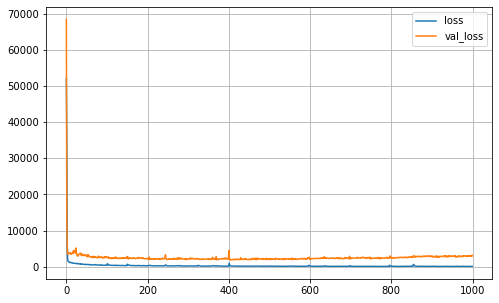

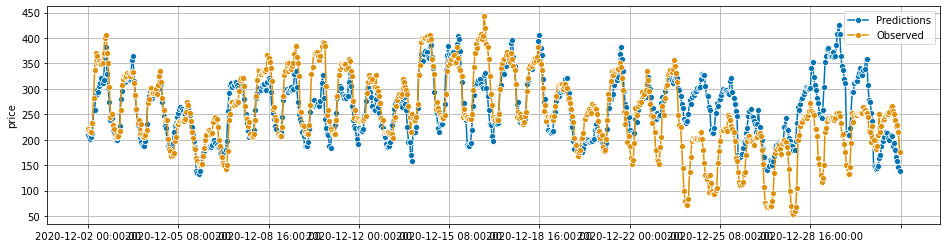

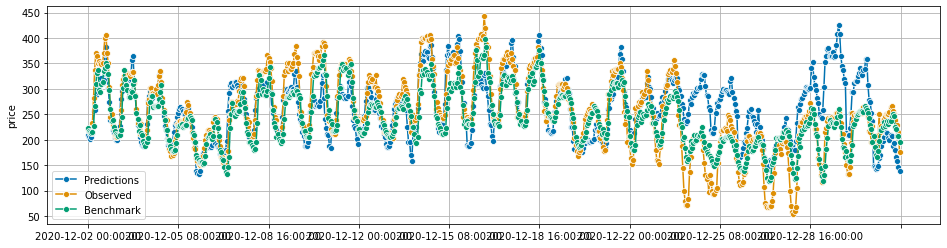

In [38]:
plot_gru_results(model, history)

### 2 reccurent GRU layers - 64 units / 32 units

In [39]:
checkpoint_best_model = keras.callbacks.ModelCheckpoint(
    '00-Shallow-NN-examples/GRU_64_32.h5', 
    save_best_only=True,
)
model = create_gru_nn_model(n_units=[64, 32])
history = model.fit(
    X_train_reshaped, 
    y_train_reshaped, 
    epochs=1000, 
    validation_data=(X_valid_reshaped, y_valid_reshaped),
    callbacks=[checkpoint_best_model]
)

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - 5s 4ms/sample - loss: 49831.7531 - val_loss: 37868.6602
Epoch 2/1000
1059/1059 [==============================] - 1s 930us/sample - loss: 13776.9466 - val_loss: 4325.5898
Epoch 3/1000
1059/1059 [==============================] - 1s 838us/sample - loss: 2251.3823 - val_loss: 2289.6689
Epoch 4/1000
1059/1059 [==============================] - 1s 882us/sample - loss: 1578.1965 - val_loss: 2274.4819
Epoch 5/1000
1059/1059 [==============================] - 1s 952us/sample - loss: 1354.0153 - val_loss: 2260.3506
Epoch 6/1000
1059/1059 [==============================] - 1s 919us/sample - loss: 1405.3773 - val_loss: 2234.6643
Epoch 7/1000
1059/1059 [==============================] - 1s 878us/sample - loss: 1296.4121 - val_loss: 2228.6665
Epoch 8/1000
1059/1059 [==============================] - 1s 945us/sample - loss: 1217.4660 - val_loss: 2380.9270
Epoch 9/1000
1059/1059 [=================

Epoch 73/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 313.6921 - val_loss: 2000.1056
Epoch 74/1000
1059/1059 [==============================] - 1s 961us/sample - loss: 287.2743 - val_loss: 2047.5853
Epoch 75/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 290.0115 - val_loss: 2238.8059
Epoch 76/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 281.6936 - val_loss: 2088.3389
Epoch 77/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 329.2929 - val_loss: 2144.8240
Epoch 78/1000
1059/1059 [==============================] - 1s 888us/sample - loss: 281.6487 - val_loss: 2031.4545
Epoch 79/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 269.0008 - val_loss: 2177.6028
Epoch 80/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 262.7439 - val_loss: 2170.8167
Epoch 81/1000
1059/1059 [==============================] - 1s 822us/sample - loss: 276.5173 - val_lo

1059/1059 [==============================] - 1s 717us/sample - loss: 110.6066 - val_loss: 1822.4102
Epoch 216/1000
1059/1059 [==============================] - 1s 713us/sample - loss: 112.4437 - val_loss: 1890.8490
Epoch 217/1000
1059/1059 [==============================] - 1s 722us/sample - loss: 112.5440 - val_loss: 1994.4915
Epoch 218/1000
1059/1059 [==============================] - 1s 706us/sample - loss: 111.8804 - val_loss: 1901.7228
Epoch 219/1000
1059/1059 [==============================] - 1s 728us/sample - loss: 117.6737 - val_loss: 1843.3339
Epoch 220/1000
1059/1059 [==============================] - 1s 725us/sample - loss: 124.6021 - val_loss: 1913.3118
Epoch 221/1000
1059/1059 [==============================] - 1s 736us/sample - loss: 153.7741 - val_loss: 2014.6763
Epoch 222/1000
1059/1059 [==============================] - 1s 736us/sample - loss: 165.6809 - val_loss: 2039.9896
Epoch 223/1000
1059/1059 [==============================] - 1s 727us/sample - loss: 284.9260 - 

1059/1059 [==============================] - 1s 723us/sample - loss: 174.6162 - val_loss: 1691.2924
Epoch 358/1000
1059/1059 [==============================] - 1s 732us/sample - loss: 128.8916 - val_loss: 1840.6881
Epoch 359/1000
1059/1059 [==============================] - 1s 720us/sample - loss: 109.5125 - val_loss: 1784.0134
Epoch 360/1000
1059/1059 [==============================] - 1s 708us/sample - loss: 93.4573 - val_loss: 1883.3258
Epoch 361/1000
1059/1059 [==============================] - 1s 719us/sample - loss: 85.1717 - val_loss: 1816.9729
Epoch 362/1000
1059/1059 [==============================] - 1s 730us/sample - loss: 79.0454 - val_loss: 1930.8805
Epoch 363/1000
1059/1059 [==============================] - 1s 730us/sample - loss: 82.3177 - val_loss: 1878.4637
Epoch 364/1000
1059/1059 [==============================] - 1s 720us/sample - loss: 76.9034 - val_loss: 1776.9727
Epoch 365/1000
1059/1059 [==============================] - 1s 711us/sample - loss: 77.5565 - val_lo

Epoch 429/1000
1059/1059 [==============================] - 1s 725us/sample - loss: 66.2746 - val_loss: 1772.3116
Epoch 430/1000
1059/1059 [==============================] - 1s 765us/sample - loss: 102.4888 - val_loss: 1930.6676
Epoch 431/1000
1059/1059 [==============================] - 1s 722us/sample - loss: 94.1054 - val_loss: 1866.6606
Epoch 432/1000
1059/1059 [==============================] - 1s 728us/sample - loss: 80.0754 - val_loss: 1734.3674
Epoch 433/1000
1059/1059 [==============================] - 1s 803us/sample - loss: 66.9332 - val_loss: 1739.7133
Epoch 434/1000
1059/1059 [==============================] - 1s 726us/sample - loss: 68.4404 - val_loss: 1943.8268
Epoch 435/1000
1059/1059 [==============================] - 1s 714us/sample - loss: 69.0386 - val_loss: 1842.4398
Epoch 436/1000
1059/1059 [==============================] - 1s 716us/sample - loss: 67.2670 - val_loss: 1931.4849
Epoch 437/1000
1059/1059 [==============================] - 1s 713us/sample - loss: 68.

Epoch 501/1000
1059/1059 [==============================] - 1s 800us/sample - loss: 57.7497 - val_loss: 1982.5001
Epoch 502/1000
1059/1059 [==============================] - 1s 781us/sample - loss: 59.2560 - val_loss: 1970.3308
Epoch 503/1000
1059/1059 [==============================] - 1s 752us/sample - loss: 59.8855 - val_loss: 1987.4656
Epoch 504/1000
1059/1059 [==============================] - 1s 760us/sample - loss: 82.8380 - val_loss: 2116.5671
Epoch 505/1000
1059/1059 [==============================] - 1s 811us/sample - loss: 86.4581 - val_loss: 1871.6880
Epoch 506/1000
1059/1059 [==============================] - 1s 765us/sample - loss: 92.9763 - val_loss: 2055.9736
Epoch 507/1000
1059/1059 [==============================] - 1s 716us/sample - loss: 100.3319 - val_loss: 1883.2192
Epoch 508/1000
1059/1059 [==============================] - 1s 753us/sample - loss: 146.7339 - val_loss: 2130.5269
Epoch 509/1000
1059/1059 [==============================] - 1s 720us/sample - loss: 13

1059/1059 [==============================] - 1s 970us/sample - loss: 39.4510 - val_loss: 1855.9165
Epoch 645/1000
1059/1059 [==============================] - 1s 933us/sample - loss: 39.2738 - val_loss: 1886.1946
Epoch 646/1000
1059/1059 [==============================] - 1s 994us/sample - loss: 39.0631 - val_loss: 1849.5406
Epoch 647/1000
1059/1059 [==============================] - 1s 964us/sample - loss: 37.7799 - val_loss: 1868.2582
Epoch 648/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 38.8026 - val_loss: 1873.7926
Epoch 649/1000
1059/1059 [==============================] - 1s 969us/sample - loss: 37.9290 - val_loss: 1945.3882
Epoch 650/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 43.2504 - val_loss: 1857.2483
Epoch 651/1000
1059/1059 [==============================] - 1s 946us/sample - loss: 44.9142 - val_loss: 1998.1038
Epoch 652/1000
1059/1059 [==============================] - 1s 976us/sample - loss: 47.4055 - val_loss: 191

1059/1059 [==============================] - 1s 916us/sample - loss: 34.0145 - val_loss: 1798.5499
Epoch 789/1000
1059/1059 [==============================] - 1s 897us/sample - loss: 32.6645 - val_loss: 1814.8562
Epoch 790/1000
1059/1059 [==============================] - 1s 916us/sample - loss: 32.4675 - val_loss: 1824.4840
Epoch 791/1000
1059/1059 [==============================] - 1s 897us/sample - loss: 31.7179 - val_loss: 1771.4688
Epoch 792/1000
1059/1059 [==============================] - 1s 864us/sample - loss: 31.4037 - val_loss: 1810.9344
Epoch 793/1000
1059/1059 [==============================] - 1s 880us/sample - loss: 31.8734 - val_loss: 1819.6051
Epoch 794/1000
1059/1059 [==============================] - 1s 869us/sample - loss: 31.4251 - val_loss: 1849.3123
Epoch 795/1000
1059/1059 [==============================] - 1s 825us/sample - loss: 30.7631 - val_loss: 1851.2661
Epoch 796/1000
1059/1059 [==============================] - 1s 869us/sample - loss: 30.3429 - val_loss:

Epoch 860/1000
1059/1059 [==============================] - 1s 820us/sample - loss: 56.4427 - val_loss: 1692.1586
Epoch 861/1000
1059/1059 [==============================] - 1s 854us/sample - loss: 44.6263 - val_loss: 1798.6522
Epoch 862/1000
1059/1059 [==============================] - 1s 818us/sample - loss: 39.5970 - val_loss: 1770.9213
Epoch 863/1000
1059/1059 [==============================] - 1s 830us/sample - loss: 36.5953 - val_loss: 1735.0726
Epoch 864/1000
1059/1059 [==============================] - 1s 807us/sample - loss: 35.6217 - val_loss: 1846.3451
Epoch 865/1000
1059/1059 [==============================] - 1s 849us/sample - loss: 34.3859 - val_loss: 1755.8190
Epoch 866/1000
1059/1059 [==============================] - 1s 824us/sample - loss: 32.2167 - val_loss: 1805.5291
Epoch 867/1000
1059/1059 [==============================] - 1s 825us/sample - loss: 30.5803 - val_loss: 1851.6028
Epoch 868/1000
1059/1059 [==============================] - 1s 860us/sample - loss: 30.0

Epoch 932/1000
1059/1059 [==============================] - 1s 826us/sample - loss: 42.0896 - val_loss: 1897.1255
Epoch 933/1000
1059/1059 [==============================] - 1s 790us/sample - loss: 44.8376 - val_loss: 1901.2651
Epoch 934/1000
1059/1059 [==============================] - 1s 833us/sample - loss: 37.0645 - val_loss: 2159.5535
Epoch 935/1000
1059/1059 [==============================] - 1s 833us/sample - loss: 81.3128 - val_loss: 1901.8309
Epoch 936/1000
1059/1059 [==============================] - 1s 832us/sample - loss: 91.9704 - val_loss: 1807.7902
Epoch 937/1000
1059/1059 [==============================] - 1s 843us/sample - loss: 79.8312 - val_loss: 2058.5396
Epoch 938/1000
1059/1059 [==============================] - 1s 900us/sample - loss: 54.9109 - val_loss: 2090.5627
Epoch 939/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 48.0192 - val_loss: 1872.4504
Epoch 940/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 44.5074 

Validation error: 43.54890150401919, Benchmark error: 34.117237015574034


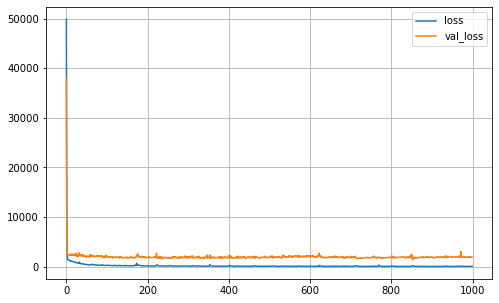

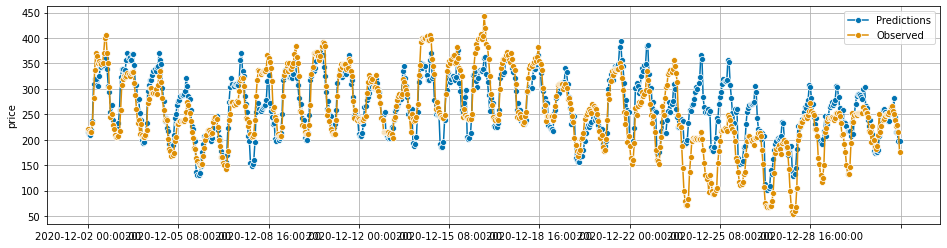

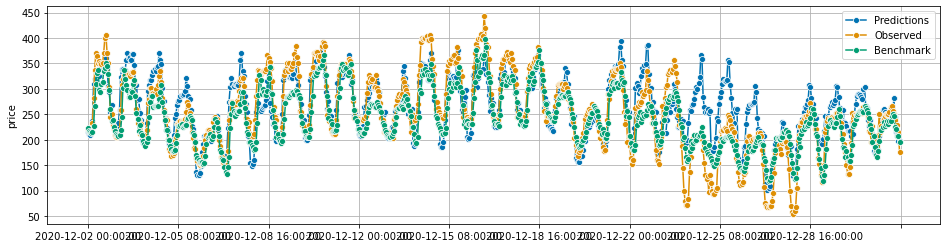

In [40]:
plot_gru_results(model, history)

### 3 reccurent GRU layers - 64 units / 64 units / 32 units

In [41]:
checkpoint_best_model = keras.callbacks.ModelCheckpoint(
    '00-Shallow-NN-examples/GRU_64_64_32.h5', 
    save_best_only=True,
)
model = create_gru_nn_model(n_units=[64, 64, 32])
history = model.fit(
    X_train_reshaped, 
    y_train_reshaped, 
    epochs=1000, 
    validation_data=(X_valid_reshaped, y_valid_reshaped),
    callbacks=[checkpoint_best_model]
)

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - 6s 5ms/sample - loss: 47004.7971 - val_loss: 28516.0078
Epoch 2/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 9694.5954 - val_loss: 3733.5874
Epoch 3/1000
1059/1059 [==============================] - 2s 1ms/sample - loss: 1702.0612 - val_loss: 2458.9717
Epoch 4/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1362.1301 - val_loss: 2195.0115
Epoch 5/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1255.8017 - val_loss: 2829.1169
Epoch 6/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1344.5174 - val_loss: 3246.7649
Epoch 7/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1213.7519 - val_loss: 2264.4031
Epoch 8/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1106.9818 - val_loss: 2455.8354
Epoch 9/1000
1059/1059 [==============================] 

1059/1059 [==============================] - 1s 1ms/sample - loss: 145.3530 - val_loss: 2673.6165
Epoch 146/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 142.5167 - val_loss: 2838.0330
Epoch 147/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 154.0712 - val_loss: 2640.5742
Epoch 148/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 144.7009 - val_loss: 2531.7986
Epoch 149/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 164.5985 - val_loss: 2431.0627
Epoch 150/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 154.2246 - val_loss: 2448.5706
Epoch 151/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 161.7431 - val_loss: 3043.4209
Epoch 152/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 161.0044 - val_loss: 2660.4673
Epoch 153/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 150.6812 - val_loss: 2903.291

Epoch 290/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 75.2653 - val_loss: 2386.1067
Epoch 291/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 75.0485 - val_loss: 2312.9775
Epoch 292/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 73.9216 - val_loss: 2400.7756
Epoch 293/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 75.3080 - val_loss: 2346.6614
Epoch 294/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 74.8368 - val_loss: 2326.8772
Epoch 295/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 77.1078 - val_loss: 2320.1470
Epoch 296/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 88.2699 - val_loss: 2450.1272
Epoch 297/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 79.6866 - val_loss: 2354.3823
Epoch 298/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 79.8222 - val_loss: 23

Epoch 363/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 73.0818 - val_loss: 2250.3933
Epoch 364/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 65.2879 - val_loss: 2160.0559
Epoch 365/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 62.2632 - val_loss: 2182.6421
Epoch 366/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 61.9647 - val_loss: 2226.0901
Epoch 367/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 63.3504 - val_loss: 2254.0754
Epoch 368/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 60.6469 - val_loss: 2238.8655
Epoch 369/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 58.8661 - val_loss: 2245.4531
Epoch 370/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 59.3908 - val_loss: 2247.4734
Epoch 371/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 58.7204 - val_loss: 22

1059/1059 [==============================] - 1s 1ms/sample - loss: 62.1502 - val_loss: 2177.9456
Epoch 437/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 59.2228 - val_loss: 2151.4314
Epoch 438/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 57.0803 - val_loss: 2168.6526
Epoch 439/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 54.7657 - val_loss: 2191.9646
Epoch 440/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 53.5634 - val_loss: 2219.3127
Epoch 441/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 52.5335 - val_loss: 2259.9766
Epoch 442/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 52.9321 - val_loss: 2167.0562
Epoch 443/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 52.6617 - val_loss: 2220.6987
Epoch 444/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 51.1457 - val_loss: 2314.1431
Epoch 4

1059/1059 [==============================] - 1s 1ms/sample - loss: 33.0376 - val_loss: 2272.8982
Epoch 583/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 32.5056 - val_loss: 2232.8345
Epoch 584/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 32.0021 - val_loss: 2290.6992
Epoch 585/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 32.2929 - val_loss: 2297.1782
Epoch 586/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 32.6046 - val_loss: 2216.1714
Epoch 587/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 31.7877 - val_loss: 2212.7358
Epoch 588/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 31.6657 - val_loss: 2262.4402
Epoch 589/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 32.9258 - val_loss: 2263.6311
Epoch 590/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 33.8883 - val_loss: 2330.0974
Epoch 5

1059/1059 [==============================] - 1s 1ms/sample - loss: 38.7120 - val_loss: 2081.2368
Epoch 729/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 34.1545 - val_loss: 2064.2104
Epoch 730/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 31.0590 - val_loss: 2043.9109
Epoch 731/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 28.8036 - val_loss: 2055.8081
Epoch 732/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 27.4995 - val_loss: 2055.5972
Epoch 733/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 60.5811 - val_loss: 2061.0100
Epoch 734/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 63.1077 - val_loss: 2021.1653
Epoch 735/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 42.7586 - val_loss: 2095.5212
Epoch 736/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 37.7683 - val_loss: 2077.5691
Epoch 7

1059/1059 [==============================] - 1s 1ms/sample - loss: 17.8203 - val_loss: 1989.1003
Epoch 875/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 18.0948 - val_loss: 1990.6207
Epoch 876/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 18.5927 - val_loss: 1996.2084
Epoch 877/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 19.7973 - val_loss: 2019.5562
Epoch 878/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 20.7324 - val_loss: 1943.4276
Epoch 879/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 20.2654 - val_loss: 1989.8878
Epoch 880/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 19.5265 - val_loss: 2027.3794
Epoch 881/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 19.7899 - val_loss: 1980.2213
Epoch 882/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 20.5051 - val_loss: 2066.0171
Epoch 8

Validation error: 45.6129488134383, Benchmark error: 34.117237015574034


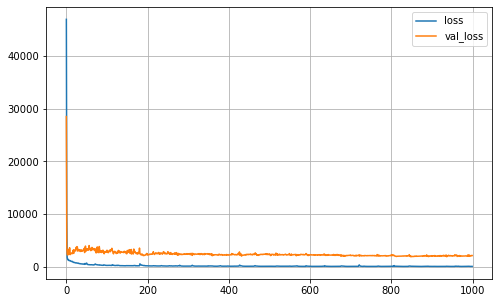

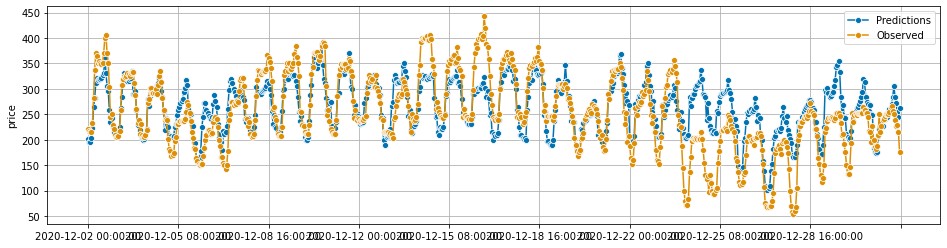

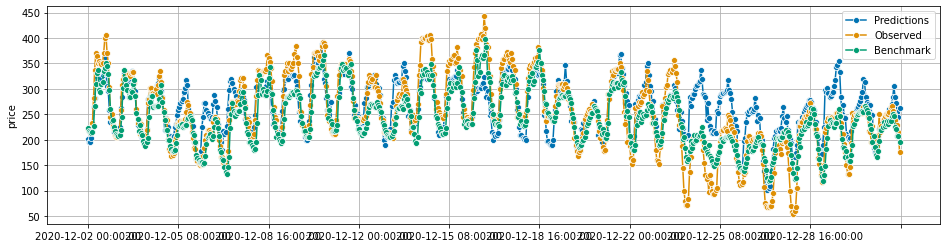

In [42]:
plot_gru_results(model, history)

### Tune best class of models

In [23]:
root_logdir = os.path.join(os.curdir, '00-Shallow-NN-examples', 'event_files')

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [31]:
run_logdir = get_run_logdir()
tensorboard_callback = keras.callbacks.TensorBoard(run_logdir, histogram_freq=1)
checkpoint_best_model = keras.callbacks.ModelCheckpoint(
    '00-Shallow-NN-examples/GRU_tuned.h5', 
    save_best_only=True,
)
model = create_gru_nn_model(n_units=[64, 64, 32])
history = model.fit(
    X_train_reshaped, 
    y_train_reshaped, 
    epochs=10, 
    validation_data=(X_valid_reshaped, y_valid_reshaped),
    callbacks=[tensorboard_callback, checkpoint_best_model]
)

Train on 1059 samples, validate on 30 samples
Epoch 1/10
1059/1059 [==============================] - 10s 9ms/sample - loss: 49372.7180 - val_loss: 40529.1250
Epoch 2/10
1059/1059 [==============================] - 2s 2ms/sample - loss: 16636.6412 - val_loss: 9386.3604
Epoch 3/10
1059/1059 [==============================] - 2s 2ms/sample - loss: 3387.9865 - val_loss: 2742.1516
Epoch 4/10
1059/1059 [==============================] - 2s 2ms/sample - loss: 1568.7517 - val_loss: 2320.5454
Epoch 5/10
1059/1059 [==============================] - 1s 1ms/sample - loss: 1399.4696 - val_loss: 2624.5894
Epoch 6/10
1059/1059 [==============================] - 2s 2ms/sample - loss: 1453.4282 - val_loss: 2334.0696
Epoch 7/10
1059/1059 [==============================] - 2s 1ms/sample - loss: 1314.7982 - val_loss: 2504.6462
Epoch 8/10
1059/1059 [==============================] - 2s 1ms/sample - loss: 1195.3416 - val_loss: 2389.3645
Epoch 9/10
1059/1059 [==============================] - 2s 1ms/sample 

In [ ]:
plot_gru_results(model, history)

### Tuned GRU networks - keras-tuner

In [23]:
def build_model(hp):
    model = keras.Sequential()
    n_layers = hp.Int('num_layers', 1, 5)
    for i in range(n_layers):
        return_sequences = True if i < (n_layers-1) else False
        model.add(keras.layers.GRU(units=hp.Int('units_' + str(i),
                                                  min_value=32,
                                                  max_value=128,
                                                  step=32),
                                   return_sequences=return_sequences,
                                   activation='relu'))
    model.add(keras.layers.Dense(24))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse')
    return model

In [24]:
N_TRIALS = 20

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=N_TRIALS,
    executions_per_trial=1,
    directory=os.path.normpath('C:/'),
    project_name='GRU_NN',
)

tuner.search_space_summary()

In [ ]:
tuner.search(
    X_train_reshaped, 
    y_train_reshaped, 
    epochs=1000, 
    validation_data=(X_valid_reshaped, y_valid_reshaped),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)]
)

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 1:59 - loss: 46370.796 - ETA: 58s - loss: 48792.878 - ETA: 38s - loss: 51037.76 - ETA: 21s - loss: 103136.734 - ETA: 14s - loss: 85447.490 - ETA: 10s - loss: 76319.44 - ETA: 8s - loss: 70716.5011 - ETA: 6s - loss: 66055.305 - ETA: 5s - loss: 61122.861 - ETA: 4s - loss: 56267.580 - ETA: 3s - loss: 54216.580 - ETA: 3s - loss: 50342.436 - ETA: 2s - loss: 49577.827 - ETA: 1s - loss: 47272.901 - ETA: 1s - loss: 46467.164 - ETA: 1s - loss: 45200.657 - ETA: 0s - loss: 44209.090 - ETA: 0s - loss: 43240.246 - ETA: 0s - loss: 41849.363 - 6s 6ms/sample - loss: 41814.4730 - val_loss: 8533.5801
Epoch 2/1000
1059/1059 [==============================] - ETA: 1s - loss: 6972.57 - ETA: 1s - loss: 6844.96 - ETA: 1s - loss: 7574.94 - ETA: 1s - loss: 6966.11 - ETA: 0s - loss: 6356.18 - ETA: 0s - loss: 6087.50 - ETA: 0s - loss: 5657.89 - ETA: 0s - loss: 5333.85 - ETA: 0s - loss: 5063.20 - ETA: 0s - 

1059/1059 [==============================] - ETA: 0s - loss: 729.067 - ETA: 0s - loss: 853.367 - ETA: 0s - loss: 1078.58 - ETA: 0s - loss: 966.5293 - ETA: 0s - loss: 922.533 - ETA: 0s - loss: 887.718 - ETA: 0s - loss: 897.616 - ETA: 0s - loss: 875.806 - ETA: 0s - loss: 854.670 - ETA: 0s - loss: 854.270 - ETA: 0s - loss: 854.657 - ETA: 0s - loss: 878.962 - ETA: 0s - loss: 892.622 - ETA: 0s - loss: 917.799 - ETA: 0s - loss: 906.662 - ETA: 0s - loss: 881.877 - ETA: 0s - loss: 859.771 - 1s 1ms/sample - loss: 859.3197 - val_loss: 2233.0476
Epoch 15/1000
1059/1059 [==============================] - ETA: 1s - loss: 704.076 - ETA: 0s - loss: 653.157 - ETA: 0s - loss: 672.085 - ETA: 0s - loss: 694.778 - ETA: 0s - loss: 774.806 - ETA: 0s - loss: 774.509 - ETA: 0s - loss: 771.501 - ETA: 0s - loss: 771.016 - ETA: 0s - loss: 828.106 - ETA: 0s - loss: 836.445 - ETA: 0s - loss: 836.078 - ETA: 0s - loss: 824.952 - ETA: 0s - loss: 865.779 - ETA: 0s - loss: 847.253 - ETA: 0s - loss: 837.824 - ETA: 0s - 

1059/1059 [==============================] - ETA: 1s - loss: 564.243 - ETA: 1s - loss: 604.408 - ETA: 1s - loss: 511.277 - ETA: 1s - loss: 530.225 - ETA: 0s - loss: 523.528 - ETA: 0s - loss: 517.505 - ETA: 0s - loss: 522.356 - ETA: 0s - loss: 552.819 - ETA: 0s - loss: 546.064 - ETA: 0s - loss: 545.374 - ETA: 0s - loss: 547.930 - ETA: 0s - loss: 540.664 - ETA: 0s - loss: 536.399 - ETA: 0s - loss: 542.269 - ETA: 0s - loss: 564.813 - ETA: 0s - loss: 560.296 - ETA: 0s - loss: 550.953 - 1s 1ms/sample - loss: 550.3025 - val_loss: 2299.4407
Epoch 29/1000
1059/1059 [==============================] - ETA: 1s - loss: 522.887 - ETA: 1s - loss: 492.549 - ETA: 0s - loss: 509.226 - ETA: 0s - loss: 472.324 - ETA: 0s - loss: 436.367 - ETA: 0s - loss: 431.950 - ETA: 0s - loss: 464.219 - ETA: 0s - loss: 453.355 - ETA: 0s - loss: 469.686 - ETA: 0s - loss: 463.948 - ETA: 0s - loss: 476.145 - ETA: 0s - loss: 474.522 - ETA: 0s - loss: 473.394 - ETA: 0s - loss: 491.798 - ETA: 0s - loss: 497.313 - ETA: 0s - l

1059/1059 [==============================] - ETA: 1s - loss: 278.858 - ETA: 1s - loss: 365.820 - ETA: 0s - loss: 366.081 - ETA: 0s - loss: 413.569 - ETA: 0s - loss: 407.586 - ETA: 0s - loss: 415.335 - ETA: 0s - loss: 418.983 - ETA: 0s - loss: 407.776 - ETA: 0s - loss: 427.243 - ETA: 0s - loss: 429.963 - ETA: 0s - loss: 439.213 - ETA: 0s - loss: 452.093 - ETA: 0s - loss: 483.700 - ETA: 0s - loss: 468.805 - ETA: 0s - loss: 467.407 - ETA: 0s - loss: 465.194 - ETA: 0s - loss: 459.548 - 1s 1ms/sample - loss: 459.1241 - val_loss: 2213.6799
Epoch 43/1000
1059/1059 [==============================] - ETA: 1s - loss: 328.538 - ETA: 1s - loss: 415.089 - ETA: 0s - loss: 365.027 - ETA: 0s - loss: 347.238 - ETA: 0s - loss: 351.643 - ETA: 0s - loss: 358.906 - ETA: 0s - loss: 403.183 - ETA: 0s - loss: 396.857 - ETA: 0s - loss: 401.973 - ETA: 0s - loss: 397.114 - ETA: 0s - loss: 391.552 - ETA: 0s - loss: 388.141 - ETA: 0s - loss: 389.096 - ETA: 0s - loss: 387.048 - ETA: 0s - loss: 386.673 - ETA: 0s - l

1059/1059 [==============================] - ETA: 1s - loss: 393.821 - ETA: 1s - loss: 345.159 - ETA: 0s - loss: 396.916 - ETA: 0s - loss: 373.081 - ETA: 0s - loss: 352.509 - ETA: 0s - loss: 341.993 - ETA: 0s - loss: 332.258 - ETA: 0s - loss: 325.596 - ETA: 0s - loss: 325.552 - ETA: 0s - loss: 321.823 - ETA: 0s - loss: 313.565 - ETA: 0s - loss: 307.642 - ETA: 0s - loss: 309.142 - ETA: 0s - loss: 306.272 - ETA: 0s - loss: 305.640 - ETA: 0s - loss: 300.208 - ETA: 0s - loss: 300.841 - 1s 1ms/sample - loss: 300.6572 - val_loss: 2592.6333
Epoch 57/1000
1059/1059 [==============================] - ETA: 1s - loss: 318.697 - ETA: 1s - loss: 315.962 - ETA: 0s - loss: 305.997 - ETA: 0s - loss: 291.546 - ETA: 0s - loss: 310.097 - ETA: 0s - loss: 300.656 - ETA: 0s - loss: 299.803 - ETA: 0s - loss: 287.006 - ETA: 0s - loss: 305.976 - ETA: 0s - loss: 302.478 - ETA: 0s - loss: 301.224 - ETA: 0s - loss: 300.942 - ETA: 0s - loss: 299.570 - ETA: 0s - loss: 302.371 - ETA: 0s - loss: 305.943 - ETA: 0s - l

1059/1059 [==============================] - ETA: 0s - loss: 970.783 - ETA: 0s - loss: 683.446 - ETA: 0s - loss: 587.114 - ETA: 0s - loss: 544.230 - ETA: 0s - loss: 550.855 - ETA: 0s - loss: 547.206 - ETA: 0s - loss: 554.007 - ETA: 0s - loss: 551.433 - ETA: 0s - loss: 573.266 - ETA: 0s - loss: 554.789 - ETA: 0s - loss: 556.513 - ETA: 0s - loss: 564.000 - ETA: 0s - loss: 549.977 - ETA: 0s - loss: 541.709 - ETA: 0s - loss: 532.353 - ETA: 0s - loss: 529.019 - ETA: 0s - loss: 529.608 - 1s 1ms/sample - loss: 529.6271 - val_loss: 2157.6646
Epoch 71/1000
1059/1059 [==============================] - ETA: 1s - loss: 488.911 - ETA: 1s - loss: 421.475 - ETA: 0s - loss: 429.260 - ETA: 0s - loss: 413.517 - ETA: 0s - loss: 462.429 - ETA: 0s - loss: 460.404 - ETA: 0s - loss: 463.208 - ETA: 0s - loss: 452.980 - ETA: 0s - loss: 447.519 - ETA: 0s - loss: 487.731 - ETA: 0s - loss: 500.015 - ETA: 0s - loss: 494.865 - ETA: 0s - loss: 507.566 - ETA: 0s - loss: 509.021 - ETA: 0s - loss: 512.049 - ETA: 0s - l

1059/1059 [==============================] - ETA: 1s - loss: 298.251 - ETA: 1s - loss: 323.215 - ETA: 0s - loss: 306.706 - ETA: 0s - loss: 295.267 - ETA: 0s - loss: 317.906 - ETA: 0s - loss: 330.955 - ETA: 0s - loss: 364.162 - ETA: 0s - loss: 363.723 - ETA: 0s - loss: 351.196 - ETA: 0s - loss: 343.767 - ETA: 0s - loss: 341.549 - ETA: 0s - loss: 353.356 - ETA: 0s - loss: 357.477 - ETA: 0s - loss: 353.253 - ETA: 0s - loss: 351.886 - ETA: 0s - loss: 345.824 - ETA: 0s - loss: 345.106 - 1s 1ms/sample - loss: 344.9354 - val_loss: 2119.0479
Epoch 85/1000
1059/1059 [==============================] - ETA: 0s - loss: 320.236 - ETA: 0s - loss: 378.787 - ETA: 0s - loss: 345.141 - ETA: 0s - loss: 451.494 - ETA: 0s - loss: 418.888 - ETA: 0s - loss: 397.506 - ETA: 0s - loss: 407.277 - ETA: 0s - loss: 390.864 - ETA: 0s - loss: 379.246 - ETA: 0s - loss: 452.529 - ETA: 0s - loss: 441.812 - ETA: 0s - loss: 431.136 - ETA: 0s - loss: 424.018 - ETA: 0s - loss: 420.620 - ETA: 0s - loss: 413.006 - ETA: 0s - l

1059/1059 [==============================] - ETA: 1s - loss: 177.554 - ETA: 1s - loss: 206.666 - ETA: 0s - loss: 213.810 - ETA: 0s - loss: 237.808 - ETA: 0s - loss: 248.896 - ETA: 0s - loss: 240.768 - ETA: 0s - loss: 265.241 - ETA: 0s - loss: 259.535 - ETA: 0s - loss: 253.905 - ETA: 0s - loss: 248.331 - ETA: 0s - loss: 245.938 - ETA: 0s - loss: 243.298 - ETA: 0s - loss: 244.954 - ETA: 0s - loss: 247.337 - ETA: 0s - loss: 246.480 - ETA: 0s - loss: 244.406 - ETA: 0s - loss: 255.442 - 1s 1ms/sample - loss: 255.6712 - val_loss: 2108.9761
Epoch 99/1000
1059/1059 [==============================] - ETA: 0s - loss: 200.795 - ETA: 1s - loss: 234.710 - ETA: 1s - loss: 232.087 - ETA: 0s - loss: 289.229 - ETA: 0s - loss: 292.295 - ETA: 0s - loss: 269.501 - ETA: 0s - loss: 258.193 - ETA: 0s - loss: 258.372 - ETA: 0s - loss: 248.790 - ETA: 0s - loss: 245.755 - ETA: 0s - loss: 247.824 - ETA: 0s - loss: 253.888 - ETA: 0s - loss: 255.474 - ETA: 0s - loss: 256.734 - ETA: 0s - loss: 260.931 - ETA: 0s - l

1059/1059 [==============================] - ETA: 1s - loss: 355.653 - ETA: 1s - loss: 332.234 - ETA: 0s - loss: 382.177 - ETA: 0s - loss: 360.045 - ETA: 0s - loss: 360.281 - ETA: 0s - loss: 361.665 - ETA: 0s - loss: 373.847 - ETA: 0s - loss: 367.759 - ETA: 0s - loss: 363.604 - ETA: 0s - loss: 360.192 - ETA: 0s - loss: 361.734 - ETA: 0s - loss: 360.182 - ETA: 0s - loss: 367.654 - ETA: 0s - loss: 366.816 - ETA: 0s - loss: 370.399 - ETA: 0s - loss: 373.661 - ETA: 0s - loss: 385.780 - 1s 1ms/sample - loss: 386.0161 - val_loss: 2167.4155
Epoch 113/1000
1059/1059 [==============================] - ETA: 0s - loss: 338.539 - ETA: 0s - loss: 395.534 - ETA: 0s - loss: 370.975 - ETA: 0s - loss: 386.883 - ETA: 0s - loss: 462.447 - ETA: 0s - loss: 458.564 - ETA: 0s - loss: 459.386 - ETA: 0s - loss: 445.230 - ETA: 0s - loss: 440.788 - ETA: 0s - loss: 438.258 - ETA: 0s - loss: 428.042 - ETA: 0s - loss: 425.487 - ETA: 0s - loss: 412.288 - ETA: 0s - loss: 408.525 - ETA: 0s - loss: 409.250 - ETA: 0s - 

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 2:22 - loss: 52494.906 - ETA: 1:09 - loss: 50302.818 - ETA: 45s - loss: 52314.415 - ETA: 33s - loss: 61748.53 - ETA: 26s - loss: 57986.27 - ETA: 21s - loss: 55709.49 - ETA: 17s - loss: 53639.73 - ETA: 15s - loss: 51967.62 - ETA: 13s - loss: 48793.55 - ETA: 11s - loss: 48876.82 - ETA: 10s - loss: 46416.81 - ETA: 8s - loss: 45076.5358 - ETA: 7s - loss: 44896.166 - ETA: 7s - loss: 44478.568 - ETA: 6s - loss: 44162.777 - ETA: 5s - loss: 43900.761 - ETA: 5s - loss: 43230.359 - ETA: 4s - loss: 42648.377 - ETA: 4s - loss: 41508.699 - ETA: 3s - loss: 40197.156 - ETA: 3s - loss: 39955.984 - ETA: 2s - loss: 38726.112 - ETA: 2s - loss: 37622.057 - ETA: 2s - loss: 36790.975 - ETA: 1s - loss: 36159.441 - ETA: 1s - loss: 35550.548 - ETA: 1s - loss: 34638.904 - ETA: 1s - loss: 33657.282 - ETA: 0s - loss: 39697.140 - ETA: 0s - loss: 38836.178 - ETA: 0s - loss: 38351.203 - ETA: 0s - loss: 38108.

1059/1059 [==============================] - ETA: 2s - loss: 1422.71 - ETA: 2s - loss: 1269.45 - ETA: 2s - loss: 1115.74 - ETA: 1s - loss: 1040.66 - ETA: 1s - loss: 1051.13 - ETA: 1s - loss: 1046.67 - ETA: 1s - loss: 1025.02 - ETA: 1s - loss: 1021.20 - ETA: 1s - loss: 1064.34 - ETA: 1s - loss: 1074.15 - ETA: 1s - loss: 1034.97 - ETA: 1s - loss: 1066.97 - ETA: 1s - loss: 1095.03 - ETA: 1s - loss: 1153.94 - ETA: 1s - loss: 1138.67 - ETA: 1s - loss: 1111.32 - ETA: 1s - loss: 1090.21 - ETA: 1s - loss: 1079.86 - ETA: 0s - loss: 1080.18 - ETA: 0s - loss: 1112.84 - ETA: 0s - loss: 1125.61 - ETA: 0s - loss: 1106.70 - ETA: 0s - loss: 1160.38 - ETA: 0s - loss: 1165.36 - ETA: 0s - loss: 1141.58 - ETA: 0s - loss: 1136.37 - ETA: 0s - loss: 1118.62 - ETA: 0s - loss: 1109.66 - ETA: 0s - loss: 1120.66 - ETA: 0s - loss: 1115.52 - ETA: 0s - loss: 1102.42 - ETA: 0s - loss: 1098.90 - ETA: 0s - loss: 1105.59 - 2s 2ms/sample - loss: 1104.0171 - val_loss: 3009.4583
Epoch 10/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 862.279 - ETA: 2s - loss: 731.122 - ETA: 2s - loss: 734.873 - ETA: 1s - loss: 822.056 - ETA: 1s - loss: 761.117 - ETA: 1s - loss: 956.910 - ETA: 1s - loss: 901.090 - ETA: 1s - loss: 905.373 - ETA: 1s - loss: 893.863 - ETA: 1s - loss: 903.676 - ETA: 1s - loss: 893.894 - ETA: 1s - loss: 889.536 - ETA: 1s - loss: 889.821 - ETA: 1s - loss: 915.914 - ETA: 1s - loss: 920.578 - ETA: 1s - loss: 916.737 - ETA: 1s - loss: 889.460 - ETA: 0s - loss: 871.288 - ETA: 0s - loss: 875.162 - ETA: 0s - loss: 853.427 - ETA: 0s - loss: 838.553 - ETA: 0s - loss: 828.647 - ETA: 0s - loss: 826.505 - ETA: 0s - loss: 821.732 - ETA: 0s - loss: 814.230 - ETA: 0s - loss: 800.477 - ETA: 0s - loss: 803.717 - ETA: 0s - loss: 804.795 - ETA: 0s - loss: 803.079 - ETA: 0s - loss: 794.743 - ETA: 0s - loss: 782.901 - ETA: 0s - loss: 772.893 - ETA: 0s - loss: 804.034 - 2s 2ms/sample - loss: 803.0768 - val_loss: 2766.6726
Epoch 18/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 2s - loss: 714.150 - ETA: 2s - loss: 720.605 - ETA: 2s - loss: 631.898 - ETA: 1s - loss: 640.622 - ETA: 1s - loss: 640.672 - ETA: 1s - loss: 598.483 - ETA: 1s - loss: 619.052 - ETA: 1s - loss: 673.472 - ETA: 1s - loss: 663.930 - ETA: 1s - loss: 646.630 - ETA: 1s - loss: 651.617 - ETA: 1s - loss: 644.790 - ETA: 1s - loss: 639.447 - ETA: 1s - loss: 637.019 - ETA: 1s - loss: 651.649 - ETA: 1s - loss: 640.713 - ETA: 1s - loss: 654.482 - ETA: 1s - loss: 658.318 - ETA: 0s - loss: 663.143 - ETA: 0s - loss: 655.376 - ETA: 0s - loss: 649.907 - ETA: 0s - loss: 657.355 - ETA: 0s - loss: 652.394 - ETA: 0s - loss: 642.193 - ETA: 0s - loss: 658.043 - ETA: 0s - loss: 649.038 - ETA: 0s - loss: 644.309 - ETA: 0s - loss: 645.069 - ETA: 0s - loss: 644.200 - ETA: 0s - loss: 685.480 - ETA: 0s - loss: 684.091 - ETA: 0s - loss: 715.229 - ETA: 0s - loss: 715.649 - 2s 2ms/sample - loss: 714.3170 - val_loss: 2747.5364
Epoch 26/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 2s - loss: 467.614 - ETA: 2s - loss: 502.540 - ETA: 1s - loss: 542.992 - ETA: 1s - loss: 666.729 - ETA: 1s - loss: 683.712 - ETA: 1s - loss: 655.815 - ETA: 1s - loss: 620.822 - ETA: 1s - loss: 606.236 - ETA: 1s - loss: 675.893 - ETA: 1s - loss: 672.055 - ETA: 1s - loss: 699.478 - ETA: 1s - loss: 692.781 - ETA: 1s - loss: 761.790 - ETA: 1s - loss: 743.133 - ETA: 1s - loss: 726.598 - ETA: 1s - loss: 711.798 - ETA: 1s - loss: 707.988 - ETA: 0s - loss: 739.730 - ETA: 0s - loss: 735.493 - ETA: 0s - loss: 757.428 - ETA: 0s - loss: 742.093 - ETA: 0s - loss: 732.088 - ETA: 0s - loss: 733.901 - ETA: 0s - loss: 721.130 - ETA: 0s - loss: 713.165 - ETA: 0s - loss: 705.732 - ETA: 0s - loss: 698.315 - ETA: 0s - loss: 691.157 - ETA: 0s - loss: 685.125 - ETA: 0s - loss: 680.538 - ETA: 0s - loss: 670.872 - ETA: 0s - loss: 671.828 - ETA: 0s - loss: 663.938 - 2s 2ms/sample - loss: 668.2260 - val_loss: 2811.8521
Epoch 34/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 2s - loss: 716.315 - ETA: 2s - loss: 616.185 - ETA: 2s - loss: 573.446 - ETA: 1s - loss: 609.195 - ETA: 1s - loss: 566.598 - ETA: 1s - loss: 561.927 - ETA: 1s - loss: 573.239 - ETA: 1s - loss: 594.019 - ETA: 1s - loss: 579.854 - ETA: 1s - loss: 564.178 - ETA: 1s - loss: 641.124 - ETA: 1s - loss: 644.698 - ETA: 1s - loss: 643.049 - ETA: 1s - loss: 636.993 - ETA: 1s - loss: 641.581 - ETA: 1s - loss: 635.231 - ETA: 1s - loss: 628.590 - ETA: 1s - loss: 620.451 - ETA: 0s - loss: 604.771 - ETA: 0s - loss: 637.020 - ETA: 0s - loss: 628.432 - ETA: 0s - loss: 618.801 - ETA: 0s - loss: 642.891 - ETA: 0s - loss: 636.316 - ETA: 0s - loss: 624.100 - ETA: 0s - loss: 616.816 - ETA: 0s - loss: 618.032 - ETA: 0s - loss: 616.665 - ETA: 0s - loss: 628.096 - ETA: 0s - loss: 620.442 - ETA: 0s - loss: 618.114 - ETA: 0s - loss: 614.035 - ETA: 0s - loss: 607.930 - 2s 2ms/sample - loss: 608.5269 - val_loss: 3587.7112
Epoch 42/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 2133.12 - ETA: 1s - loss: 1471.27 - ETA: 1s - loss: 1381.00 - ETA: 1s - loss: 1562.95 - ETA: 1s - loss: 1384.44 - ETA: 1s - loss: 1480.59 - ETA: 1s - loss: 1442.81 - ETA: 1s - loss: 1394.80 - ETA: 1s - loss: 1395.53 - ETA: 1s - loss: 1355.26 - ETA: 1s - loss: 1300.66 - ETA: 1s - loss: 1261.93 - ETA: 1s - loss: 1224.73 - ETA: 1s - loss: 1188.44 - ETA: 1s - loss: 1140.12 - ETA: 1s - loss: 1147.55 - ETA: 1s - loss: 1120.29 - ETA: 0s - loss: 1109.58 - ETA: 0s - loss: 1083.76 - ETA: 0s - loss: 1050.68 - ETA: 0s - loss: 1032.58 - ETA: 0s - loss: 1027.42 - ETA: 0s - loss: 1066.41 - ETA: 0s - loss: 1045.82 - ETA: 0s - loss: 1084.86 - ETA: 0s - loss: 1059.93 - ETA: 0s - loss: 1042.88 - ETA: 0s - loss: 1034.84 - ETA: 0s - loss: 1030.38 - ETA: 0s - loss: 1028.00 - ETA: 0s - loss: 1021.71 - ETA: 0s - loss: 1023.38 - ETA: 0s - loss: 1023.82 - 2s 2ms/sample - loss: 1022.3962 - val_loss: 7531.1201
Epoch 50/1000
1059/1059 [==================

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 1:50 - loss: 51444.312 - ETA: 54s - loss: 52005.796 - ETA: 35s - loss: 49769.43 - ETA: 26s - loss: 312850.328 - ETA: 20s - loss: 254502.064 - ETA: 16s - loss: 216959.277 - ETA: 14s - loss: 190841.621 - ETA: 12s - loss: 171124.702 - ETA: 10s - loss: 155250.363 - ETA: 9s - loss: 143569.778 - ETA: 8s - loss: 132384.77 - ETA: 7s - loss: 123024.36 - ETA: 6s - loss: 115238.41 - ETA: 5s - loss: 108063.19 - ETA: 5s - loss: 101665.93 - ETA: 4s - loss: 96056.3777 - ETA: 4s - loss: 91023.750 - ETA: 3s - loss: 86424.071 - ETA: 3s - loss: 82166.172 - ETA: 2s - loss: 78366.358 - ETA: 2s - loss: 74869.901 - ETA: 2s - loss: 72286.837 - ETA: 2s - loss: 69376.951 - ETA: 1s - loss: 66828.948 - ETA: 1s - loss: 64572.391 - ETA: 1s - loss: 62407.809 - ETA: 1s - loss: 60259.654 - ETA: 0s - loss: 58424.322 - ETA: 0s - loss: 56611.584 - ETA: 0s - loss: 54959.731 - ETA: 0s - loss: 53340.858 - ETA: 0s - l

1059/1059 [==============================] - ETA: 2s - loss: 755.993 - ETA: 1s - loss: 881.572 - ETA: 1s - loss: 849.380 - ETA: 1s - loss: 885.342 - ETA: 1s - loss: 1088.76 - ETA: 1s - loss: 1147.19 - ETA: 1s - loss: 1074.25 - ETA: 1s - loss: 1073.91 - ETA: 1s - loss: 1129.16 - ETA: 1s - loss: 1095.94 - ETA: 1s - loss: 1117.63 - ETA: 1s - loss: 1104.43 - ETA: 1s - loss: 1073.49 - ETA: 1s - loss: 1072.07 - ETA: 1s - loss: 1099.45 - ETA: 1s - loss: 1096.31 - ETA: 1s - loss: 1133.11 - ETA: 0s - loss: 1115.48 - ETA: 0s - loss: 1103.69 - ETA: 0s - loss: 1109.41 - ETA: 0s - loss: 1125.30 - ETA: 0s - loss: 1128.97 - ETA: 0s - loss: 1128.53 - ETA: 0s - loss: 1109.63 - ETA: 0s - loss: 1141.94 - ETA: 0s - loss: 1134.90 - ETA: 0s - loss: 1135.90 - ETA: 0s - loss: 1194.93 - ETA: 0s - loss: 1181.97 - ETA: 0s - loss: 1175.23 - ETA: 0s - loss: 1177.32 - ETA: 0s - loss: 1174.74 - ETA: 0s - loss: 1172.84 - 2s 2ms/sample - loss: 1176.5777 - val_loss: 3692.0117
Epoch 10/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 556.732 - ETA: 1s - loss: 580.211 - ETA: 1s - loss: 658.537 - ETA: 1s - loss: 599.378 - ETA: 1s - loss: 753.353 - ETA: 1s - loss: 722.813 - ETA: 1s - loss: 738.873 - ETA: 1s - loss: 734.847 - ETA: 1s - loss: 716.392 - ETA: 1s - loss: 735.036 - ETA: 1s - loss: 708.246 - ETA: 1s - loss: 716.334 - ETA: 1s - loss: 706.271 - ETA: 1s - loss: 724.316 - ETA: 1s - loss: 720.774 - ETA: 1s - loss: 710.681 - ETA: 0s - loss: 710.798 - ETA: 0s - loss: 708.862 - ETA: 0s - loss: 700.430 - ETA: 0s - loss: 713.366 - ETA: 0s - loss: 706.153 - ETA: 0s - loss: 721.756 - ETA: 0s - loss: 717.470 - ETA: 0s - loss: 743.577 - ETA: 0s - loss: 759.008 - ETA: 0s - loss: 758.692 - ETA: 0s - loss: 750.563 - ETA: 0s - loss: 742.563 - ETA: 0s - loss: 743.791 - ETA: 0s - loss: 752.483 - ETA: 0s - loss: 749.189 - ETA: 0s - loss: 753.094 - ETA: 0s - loss: 751.498 - 2s 2ms/sample - loss: 750.1223 - val_loss: 2996.2839
Epoch 18/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 1098.53 - ETA: 1s - loss: 837.6394 - ETA: 1s - loss: 919.113 - ETA: 1s - loss: 821.782 - ETA: 1s - loss: 795.199 - ETA: 1s - loss: 770.384 - ETA: 1s - loss: 730.973 - ETA: 1s - loss: 690.946 - ETA: 1s - loss: 689.378 - ETA: 1s - loss: 666.338 - ETA: 1s - loss: 679.176 - ETA: 1s - loss: 670.039 - ETA: 1s - loss: 663.325 - ETA: 1s - loss: 642.469 - ETA: 1s - loss: 633.943 - ETA: 1s - loss: 676.051 - ETA: 1s - loss: 687.476 - ETA: 0s - loss: 679.078 - ETA: 0s - loss: 677.519 - ETA: 0s - loss: 677.535 - ETA: 0s - loss: 672.838 - ETA: 0s - loss: 678.278 - ETA: 0s - loss: 673.182 - ETA: 0s - loss: 668.087 - ETA: 0s - loss: 668.817 - ETA: 0s - loss: 661.465 - ETA: 0s - loss: 655.153 - ETA: 0s - loss: 648.537 - ETA: 0s - loss: 644.829 - ETA: 0s - loss: 642.970 - ETA: 0s - loss: 637.830 - ETA: 0s - loss: 631.829 - ETA: 0s - loss: 631.003 - 2s 2ms/sample - loss: 632.3063 - val_loss: 3667.6804
Epoch 26/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 584.909 - ETA: 1s - loss: 458.073 - ETA: 1s - loss: 517.533 - ETA: 1s - loss: 494.817 - ETA: 1s - loss: 451.921 - ETA: 1s - loss: 457.790 - ETA: 1s - loss: 444.234 - ETA: 1s - loss: 429.959 - ETA: 1s - loss: 467.248 - ETA: 1s - loss: 496.743 - ETA: 1s - loss: 473.854 - ETA: 1s - loss: 473.660 - ETA: 1s - loss: 471.821 - ETA: 1s - loss: 457.669 - ETA: 1s - loss: 453.585 - ETA: 1s - loss: 457.387 - ETA: 1s - loss: 452.748 - ETA: 0s - loss: 451.127 - ETA: 0s - loss: 451.010 - ETA: 0s - loss: 444.595 - ETA: 0s - loss: 449.865 - ETA: 0s - loss: 450.018 - ETA: 0s - loss: 452.282 - ETA: 0s - loss: 447.808 - ETA: 0s - loss: 447.973 - ETA: 0s - loss: 444.128 - ETA: 0s - loss: 439.483 - ETA: 0s - loss: 438.908 - ETA: 0s - loss: 437.020 - ETA: 0s - loss: 435.258 - ETA: 0s - loss: 433.216 - ETA: 0s - loss: 442.574 - ETA: 0s - loss: 441.179 - 2s 2ms/sample - loss: 440.8377 - val_loss: 3003.0046
Epoch 34/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 370.685 - ETA: 1s - loss: 343.504 - ETA: 1s - loss: 517.162 - ETA: 1s - loss: 508.829 - ETA: 1s - loss: 467.185 - ETA: 1s - loss: 449.107 - ETA: 1s - loss: 436.780 - ETA: 1s - loss: 430.622 - ETA: 1s - loss: 441.299 - ETA: 1s - loss: 462.602 - ETA: 1s - loss: 466.059 - ETA: 1s - loss: 480.810 - ETA: 1s - loss: 493.430 - ETA: 1s - loss: 503.965 - ETA: 1s - loss: 522.128 - ETA: 1s - loss: 513.436 - ETA: 1s - loss: 524.128 - ETA: 0s - loss: 520.363 - ETA: 0s - loss: 519.263 - ETA: 0s - loss: 529.731 - ETA: 0s - loss: 526.357 - ETA: 0s - loss: 525.448 - ETA: 0s - loss: 530.623 - ETA: 0s - loss: 534.014 - ETA: 0s - loss: 527.422 - ETA: 0s - loss: 525.492 - ETA: 0s - loss: 529.226 - ETA: 0s - loss: 524.244 - ETA: 0s - loss: 535.335 - ETA: 0s - loss: 527.643 - ETA: 0s - loss: 519.951 - ETA: 0s - loss: 513.866 - ETA: 0s - loss: 510.276 - 2s 2ms/sample - loss: 509.3244 - val_loss: 3012.4678
Epoch 42/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 489.458 - ETA: 1s - loss: 430.696 - ETA: 1s - loss: 474.427 - ETA: 1s - loss: 471.189 - ETA: 1s - loss: 483.679 - ETA: 1s - loss: 456.161 - ETA: 1s - loss: 435.895 - ETA: 1s - loss: 433.089 - ETA: 1s - loss: 413.480 - ETA: 1s - loss: 425.050 - ETA: 1s - loss: 414.870 - ETA: 1s - loss: 410.412 - ETA: 1s - loss: 410.669 - ETA: 1s - loss: 403.399 - ETA: 1s - loss: 407.513 - ETA: 1s - loss: 405.482 - ETA: 1s - loss: 408.667 - ETA: 0s - loss: 428.547 - ETA: 0s - loss: 427.366 - ETA: 0s - loss: 429.463 - ETA: 0s - loss: 436.404 - ETA: 0s - loss: 438.981 - ETA: 0s - loss: 450.244 - ETA: 0s - loss: 450.729 - ETA: 0s - loss: 448.800 - ETA: 0s - loss: 456.343 - ETA: 0s - loss: 455.522 - ETA: 0s - loss: 462.690 - ETA: 0s - loss: 457.240 - ETA: 0s - loss: 463.666 - ETA: 0s - loss: 460.308 - ETA: 0s - loss: 460.297 - ETA: 0s - loss: 458.214 - 2s 2ms/sample - loss: 457.5386 - val_loss: 2885.7588
Epoch 50/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 233.303 - ETA: 1s - loss: 253.203 - ETA: 1s - loss: 297.596 - ETA: 1s - loss: 285.011 - ETA: 1s - loss: 311.553 - ETA: 1s - loss: 341.265 - ETA: 1s - loss: 346.636 - ETA: 1s - loss: 336.402 - ETA: 1s - loss: 334.336 - ETA: 1s - loss: 358.907 - ETA: 1s - loss: 353.649 - ETA: 1s - loss: 349.270 - ETA: 1s - loss: 346.417 - ETA: 1s - loss: 360.935 - ETA: 1s - loss: 355.027 - ETA: 1s - loss: 346.975 - ETA: 0s - loss: 344.923 - ETA: 0s - loss: 339.400 - ETA: 0s - loss: 346.308 - ETA: 0s - loss: 345.498 - ETA: 0s - loss: 342.295 - ETA: 0s - loss: 348.769 - ETA: 0s - loss: 347.404 - ETA: 0s - loss: 355.353 - ETA: 0s - loss: 350.789 - ETA: 0s - loss: 369.280 - ETA: 0s - loss: 368.663 - ETA: 0s - loss: 369.573 - ETA: 0s - loss: 368.666 - ETA: 0s - loss: 370.650 - ETA: 0s - loss: 368.491 - ETA: 0s - loss: 366.176 - ETA: 0s - loss: 366.170 - 2s 2ms/sample - loss: 365.9469 - val_loss: 3890.2888


Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 1:52 - loss: 48359.656 - ETA: 55s - loss: 49109.308 - ETA: 36s - loss: 51366.89 - ETA: 20s - loss: 51130.95 - ETA: 16s - loss: 52001.23 - ETA: 14s - loss: 52987.63 - ETA: 12s - loss: 53357.56 - ETA: 10s - loss: 52688.59 - ETA: 9s - loss: 52361.6480 - ETA: 8s - loss: 51958.023 - ETA: 7s - loss: 52273.633 - ETA: 6s - loss: 51989.300 - ETA: 5s - loss: 52315.151 - ETA: 5s - loss: 52220.424 - ETA: 4s - loss: 51765.329 - ETA: 4s - loss: 51092.338 - ETA: 3s - loss: 50752.827 - ETA: 3s - loss: 50433.952 - ETA: 2s - loss: 49689.355 - ETA: 2s - loss: 48560.960 - ETA: 2s - loss: 47480.221 - ETA: 2s - loss: 48124.949 - ETA: 1s - loss: 47239.736 - ETA: 1s - loss: 45995.365 - ETA: 1s - loss: 44872.165 - ETA: 1s - loss: 43825.765 - ETA: 0s - loss: 42073.993 - ETA: 0s - loss: 41158.537 - ETA: 0s - loss: 40233.484 - ETA: 0s - loss: 39324.232 - ETA: 0s - loss: 38450.133 - 6s 6ms/sample - loss: 38

1059/1059 [==============================] - ETA: 2s - loss: 1533.08 - ETA: 1s - loss: 1182.26 - ETA: 1s - loss: 1299.36 - ETA: 1s - loss: 1288.20 - ETA: 1s - loss: 1191.82 - ETA: 1s - loss: 1116.66 - ETA: 1s - loss: 1106.30 - ETA: 1s - loss: 1070.77 - ETA: 1s - loss: 1089.55 - ETA: 1s - loss: 1068.12 - ETA: 1s - loss: 1040.61 - ETA: 1s - loss: 1227.31 - ETA: 1s - loss: 1242.72 - ETA: 1s - loss: 1226.33 - ETA: 1s - loss: 1230.42 - ETA: 1s - loss: 1196.80 - ETA: 0s - loss: 1214.38 - ETA: 0s - loss: 1226.03 - ETA: 0s - loss: 1228.72 - ETA: 0s - loss: 1288.12 - ETA: 0s - loss: 1260.54 - ETA: 0s - loss: 1241.27 - ETA: 0s - loss: 1226.20 - ETA: 0s - loss: 1217.41 - ETA: 0s - loss: 1218.25 - ETA: 0s - loss: 1239.67 - ETA: 0s - loss: 1241.77 - ETA: 0s - loss: 1227.25 - ETA: 0s - loss: 1212.68 - ETA: 0s - loss: 1209.09 - ETA: 0s - loss: 1216.61 - ETA: 0s - loss: 1223.52 - ETA: 0s - loss: 1221.85 - 2s 2ms/sample - loss: 1219.5668 - val_loss: 2474.3230
Epoch 10/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 775.747 - ETA: 1s - loss: 1141.47 - ETA: 1s - loss: 1003.85 - ETA: 1s - loss: 1096.93 - ETA: 1s - loss: 1009.27 - ETA: 1s - loss: 1012.57 - ETA: 1s - loss: 990.1506 - ETA: 1s - loss: 941.070 - ETA: 1s - loss: 920.231 - ETA: 1s - loss: 978.087 - ETA: 1s - loss: 1111.65 - ETA: 1s - loss: 1064.26 - ETA: 1s - loss: 1107.93 - ETA: 1s - loss: 1084.63 - ETA: 1s - loss: 1059.80 - ETA: 1s - loss: 1102.59 - ETA: 0s - loss: 1091.08 - ETA: 0s - loss: 1088.89 - ETA: 0s - loss: 1074.94 - ETA: 0s - loss: 1066.60 - ETA: 0s - loss: 1053.77 - ETA: 0s - loss: 1039.89 - ETA: 0s - loss: 1038.99 - ETA: 0s - loss: 1041.98 - ETA: 0s - loss: 1039.30 - ETA: 0s - loss: 1019.42 - ETA: 0s - loss: 1008.13 - ETA: 0s - loss: 1010.44 - ETA: 0s - loss: 999.3226 - ETA: 0s - loss: 985.477 - ETA: 0s - loss: 978.342 - ETA: 0s - loss: 1039.69 - ETA: 0s - loss: 1028.26 - 2s 2ms/sample - loss: 1026.8136 - val_loss: 2882.4292
Epoch 18/1000
1059/1059 [================

1059/1059 [==============================] - ETA: 1s - loss: 638.576 - ETA: 1s - loss: 1193.42 - ETA: 1s - loss: 1101.03 - ETA: 1s - loss: 1086.83 - ETA: 1s - loss: 977.8787 - ETA: 1s - loss: 893.243 - ETA: 1s - loss: 901.287 - ETA: 1s - loss: 878.494 - ETA: 1s - loss: 847.220 - ETA: 1s - loss: 845.568 - ETA: 1s - loss: 822.112 - ETA: 1s - loss: 800.384 - ETA: 1s - loss: 827.369 - ETA: 1s - loss: 814.017 - ETA: 1s - loss: 805.673 - ETA: 1s - loss: 788.978 - ETA: 0s - loss: 767.146 - ETA: 0s - loss: 766.802 - ETA: 0s - loss: 773.605 - ETA: 0s - loss: 768.444 - ETA: 0s - loss: 748.235 - ETA: 0s - loss: 732.039 - ETA: 0s - loss: 730.644 - ETA: 0s - loss: 726.175 - ETA: 0s - loss: 713.434 - ETA: 0s - loss: 706.859 - ETA: 0s - loss: 698.594 - ETA: 0s - loss: 701.902 - ETA: 0s - loss: 698.820 - ETA: 0s - loss: 695.577 - ETA: 0s - loss: 696.208 - ETA: 0s - loss: 691.974 - ETA: 0s - loss: 686.577 - 2s 2ms/sample - loss: 685.9440 - val_loss: 2787.5667
Epoch 26/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 1011.97 - ETA: 1s - loss: 991.6811 - ETA: 1s - loss: 822.422 - ETA: 1s - loss: 795.816 - ETA: 1s - loss: 800.366 - ETA: 1s - loss: 793.696 - ETA: 1s - loss: 749.617 - ETA: 1s - loss: 774.113 - ETA: 1s - loss: 759.075 - ETA: 1s - loss: 784.749 - ETA: 1s - loss: 756.473 - ETA: 1s - loss: 750.863 - ETA: 1s - loss: 799.259 - ETA: 1s - loss: 788.682 - ETA: 1s - loss: 773.530 - ETA: 0s - loss: 827.421 - ETA: 0s - loss: 827.761 - ETA: 0s - loss: 806.658 - ETA: 0s - loss: 797.384 - ETA: 0s - loss: 795.376 - ETA: 0s - loss: 785.804 - ETA: 0s - loss: 780.125 - ETA: 0s - loss: 763.051 - ETA: 0s - loss: 767.892 - ETA: 0s - loss: 761.289 - ETA: 0s - loss: 770.248 - ETA: 0s - loss: 775.482 - ETA: 0s - loss: 772.933 - ETA: 0s - loss: 772.373 - ETA: 0s - loss: 759.138 - ETA: 0s - loss: 768.573 - ETA: 0s - loss: 766.740 - ETA: 0s - loss: 765.555 - 2s 2ms/sample - loss: 764.3754 - val_loss: 3056.4561
Epoch 34/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 273.622 - ETA: 1s - loss: 295.630 - ETA: 1s - loss: 390.908 - ETA: 1s - loss: 390.445 - ETA: 1s - loss: 382.098 - ETA: 1s - loss: 375.810 - ETA: 1s - loss: 368.558 - ETA: 1s - loss: 372.687 - ETA: 1s - loss: 370.032 - ETA: 1s - loss: 416.888 - ETA: 1s - loss: 401.875 - ETA: 1s - loss: 405.175 - ETA: 1s - loss: 407.857 - ETA: 1s - loss: 423.187 - ETA: 1s - loss: 416.884 - ETA: 1s - loss: 406.512 - ETA: 0s - loss: 407.208 - ETA: 0s - loss: 423.413 - ETA: 0s - loss: 419.243 - ETA: 0s - loss: 416.657 - ETA: 0s - loss: 411.875 - ETA: 0s - loss: 415.500 - ETA: 0s - loss: 414.884 - ETA: 0s - loss: 418.268 - ETA: 0s - loss: 417.904 - ETA: 0s - loss: 411.117 - ETA: 0s - loss: 408.525 - ETA: 0s - loss: 408.789 - ETA: 0s - loss: 406.556 - ETA: 0s - loss: 413.997 - ETA: 0s - loss: 415.432 - ETA: 0s - loss: 413.497 - ETA: 0s - loss: 411.661 - 2s 2ms/sample - loss: 411.4665 - val_loss: 2961.1365
Epoch 42/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 340.230 - ETA: 1s - loss: 346.121 - ETA: 1s - loss: 360.151 - ETA: 1s - loss: 437.465 - ETA: 1s - loss: 420.059 - ETA: 1s - loss: 429.740 - ETA: 1s - loss: 410.205 - ETA: 1s - loss: 388.331 - ETA: 1s - loss: 406.782 - ETA: 1s - loss: 403.791 - ETA: 1s - loss: 410.969 - ETA: 1s - loss: 410.902 - ETA: 1s - loss: 413.995 - ETA: 1s - loss: 410.329 - ETA: 1s - loss: 421.372 - ETA: 1s - loss: 421.919 - ETA: 0s - loss: 429.842 - ETA: 0s - loss: 427.052 - ETA: 0s - loss: 424.692 - ETA: 0s - loss: 425.618 - ETA: 0s - loss: 426.903 - ETA: 0s - loss: 425.123 - ETA: 0s - loss: 439.011 - ETA: 0s - loss: 440.658 - ETA: 0s - loss: 437.220 - ETA: 0s - loss: 441.839 - ETA: 0s - loss: 436.964 - ETA: 0s - loss: 444.441 - ETA: 0s - loss: 440.803 - ETA: 0s - loss: 436.054 - ETA: 0s - loss: 431.081 - ETA: 0s - loss: 431.870 - ETA: 0s - loss: 430.327 - 2s 2ms/sample - loss: 432.8701 - val_loss: 2979.6731
Epoch 50/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 402.991 - ETA: 1s - loss: 375.894 - ETA: 1s - loss: 384.190 - ETA: 1s - loss: 372.119 - ETA: 1s - loss: 367.760 - ETA: 1s - loss: 348.961 - ETA: 1s - loss: 358.131 - ETA: 1s - loss: 346.983 - ETA: 1s - loss: 345.715 - ETA: 1s - loss: 341.213 - ETA: 1s - loss: 331.981 - ETA: 1s - loss: 339.349 - ETA: 1s - loss: 346.020 - ETA: 1s - loss: 352.060 - ETA: 1s - loss: 355.002 - ETA: 1s - loss: 365.465 - ETA: 1s - loss: 362.288 - ETA: 0s - loss: 367.966 - ETA: 0s - loss: 365.124 - ETA: 0s - loss: 370.239 - ETA: 0s - loss: 379.458 - ETA: 0s - loss: 379.132 - ETA: 0s - loss: 372.811 - ETA: 0s - loss: 383.061 - ETA: 0s - loss: 379.355 - ETA: 0s - loss: 376.701 - ETA: 0s - loss: 389.079 - ETA: 0s - loss: 385.124 - ETA: 0s - loss: 383.108 - ETA: 0s - loss: 378.371 - ETA: 0s - loss: 375.494 - ETA: 0s - loss: 381.785 - ETA: 0s - loss: 381.978 - 2s 2ms/sample - loss: 381.4992 - val_loss: 2720.3318


Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 2:49 - loss: 56698.304 - ETA: 1:23 - loss: 53165.302 - ETA: 54s - loss: 53333.671 - ETA: 39s - loss: 54547.33 - ETA: 31s - loss: 54202.84 - ETA: 25s - loss: 53530.96 - ETA: 21s - loss: 53769.00 - ETA: 18s - loss: 54017.55 - ETA: 15s - loss: 53693.10 - ETA: 13s - loss: 53609.12 - ETA: 12s - loss: 53665.14 - ETA: 10s - loss: 53133.74 - ETA: 9s - loss: 52597.4183 - ETA: 8s - loss: 52594.373 - ETA: 7s - loss: 52700.600 - ETA: 6s - loss: 52555.684 - ETA: 6s - loss: 52668.206 - ETA: 5s - loss: 52645.572 - ETA: 4s - loss: 52597.948 - ETA: 4s - loss: 52256.969 - ETA: 3s - loss: 52313.554 - ETA: 3s - loss: 52143.733 - ETA: 3s - loss: 52056.670 - ETA: 2s - loss: 51912.809 - ETA: 2s - loss: 52026.105 - ETA: 1s - loss: 52192.672 - ETA: 1s - loss: 52272.770 - ETA: 1s - loss: 52331.731 - ETA: 1s - loss: 52253.212 - ETA: 0s - loss: 52363.537 - ETA: 0s - loss: 52299.337 - ETA: 0s - loss: 52188.

1059/1059 [==============================] - ETA: 2s - loss: 2703.38 - ETA: 2s - loss: 2372.08 - ETA: 2s - loss: 2462.42 - ETA: 2s - loss: 2397.48 - ETA: 1s - loss: 2398.39 - ETA: 1s - loss: 2448.41 - ETA: 1s - loss: 2362.36 - ETA: 1s - loss: 2297.95 - ETA: 1s - loss: 2340.95 - ETA: 1s - loss: 2329.53 - ETA: 1s - loss: 2320.93 - ETA: 1s - loss: 2484.63 - ETA: 1s - loss: 2443.89 - ETA: 1s - loss: 2453.03 - ETA: 1s - loss: 2422.77 - ETA: 1s - loss: 2372.76 - ETA: 1s - loss: 2349.30 - ETA: 1s - loss: 2327.85 - ETA: 1s - loss: 2322.87 - ETA: 0s - loss: 2307.67 - ETA: 0s - loss: 2283.32 - ETA: 0s - loss: 2267.62 - ETA: 0s - loss: 2236.47 - ETA: 0s - loss: 2308.62 - ETA: 0s - loss: 2284.86 - ETA: 0s - loss: 2304.02 - ETA: 0s - loss: 2301.73 - ETA: 0s - loss: 2297.11 - ETA: 0s - loss: 2276.82 - ETA: 0s - loss: 2323.02 - ETA: 0s - loss: 2297.86 - ETA: 0s - loss: 2289.23 - ETA: 0s - loss: 2267.39 - 3s 2ms/sample - loss: 2266.8089 - val_loss: 3411.9438
Epoch 10/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 1474.40 - ETA: 2s - loss: 1358.67 - ETA: 2s - loss: 1321.45 - ETA: 2s - loss: 1310.83 - ETA: 2s - loss: 1281.57 - ETA: 1s - loss: 1208.62 - ETA: 1s - loss: 1184.93 - ETA: 1s - loss: 1227.01 - ETA: 1s - loss: 1197.50 - ETA: 1s - loss: 1252.57 - ETA: 1s - loss: 1306.19 - ETA: 1s - loss: 1276.14 - ETA: 1s - loss: 1260.10 - ETA: 1s - loss: 1253.68 - ETA: 1s - loss: 1273.28 - ETA: 1s - loss: 1367.10 - ETA: 1s - loss: 1349.58 - ETA: 1s - loss: 1335.04 - ETA: 1s - loss: 1368.14 - ETA: 0s - loss: 1348.54 - ETA: 0s - loss: 1331.39 - ETA: 0s - loss: 1348.42 - ETA: 0s - loss: 1317.61 - ETA: 0s - loss: 1341.86 - ETA: 0s - loss: 1334.21 - ETA: 0s - loss: 1316.74 - ETA: 0s - loss: 1326.71 - ETA: 0s - loss: 1314.01 - ETA: 0s - loss: 1298.06 - ETA: 0s - loss: 1285.11 - ETA: 0s - loss: 1272.86 - ETA: 0s - loss: 1332.39 - ETA: 0s - loss: 1328.50 - 3s 2ms/sample - loss: 1327.0406 - val_loss: 2304.0627
Epoch 18/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 672.029 - ETA: 2s - loss: 773.587 - ETA: 2s - loss: 883.183 - ETA: 2s - loss: 881.164 - ETA: 1s - loss: 1003.87 - ETA: 1s - loss: 957.9790 - ETA: 1s - loss: 953.747 - ETA: 1s - loss: 929.434 - ETA: 1s - loss: 970.867 - ETA: 1s - loss: 996.732 - ETA: 1s - loss: 1005.66 - ETA: 1s - loss: 1025.18 - ETA: 1s - loss: 1121.07 - ETA: 1s - loss: 1106.56 - ETA: 1s - loss: 1103.01 - ETA: 1s - loss: 1112.67 - ETA: 1s - loss: 1110.12 - ETA: 1s - loss: 1103.64 - ETA: 1s - loss: 1112.95 - ETA: 0s - loss: 1131.80 - ETA: 0s - loss: 1118.75 - ETA: 0s - loss: 1177.85 - ETA: 0s - loss: 1175.86 - ETA: 0s - loss: 1252.03 - ETA: 0s - loss: 1234.03 - ETA: 0s - loss: 1252.30 - ETA: 0s - loss: 1239.00 - ETA: 0s - loss: 1221.97 - ETA: 0s - loss: 1205.02 - ETA: 0s - loss: 1190.41 - ETA: 0s - loss: 1187.68 - ETA: 0s - loss: 1181.72 - ETA: 0s - loss: 1175.64 - 3s 2ms/sample - loss: 1174.4738 - val_loss: 2214.6023
Epoch 26/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 2s - loss: 1195.78 - ETA: 2s - loss: 1335.19 - ETA: 2s - loss: 1303.58 - ETA: 2s - loss: 1197.65 - ETA: 2s - loss: 1184.82 - ETA: 2s - loss: 1205.04 - ETA: 1s - loss: 1157.90 - ETA: 1s - loss: 1146.93 - ETA: 1s - loss: 1090.17 - ETA: 1s - loss: 1083.83 - ETA: 1s - loss: 1055.07 - ETA: 1s - loss: 1025.75 - ETA: 1s - loss: 1008.36 - ETA: 1s - loss: 1005.24 - ETA: 1s - loss: 972.9464 - ETA: 1s - loss: 1029.83 - ETA: 1s - loss: 1013.74 - ETA: 1s - loss: 1011.97 - ETA: 1s - loss: 992.4540 - ETA: 0s - loss: 982.519 - ETA: 0s - loss: 982.838 - ETA: 0s - loss: 975.762 - ETA: 0s - loss: 968.932 - ETA: 0s - loss: 958.909 - ETA: 0s - loss: 1038.95 - ETA: 0s - loss: 1038.51 - ETA: 0s - loss: 1038.43 - ETA: 0s - loss: 1050.00 - ETA: 0s - loss: 1041.25 - ETA: 0s - loss: 1041.82 - ETA: 0s - loss: 1029.02 - ETA: 0s - loss: 1036.15 - ETA: 0s - loss: 1092.98 - 3s 3ms/sample - loss: 1092.1332 - val_loss: 2209.8196
Epoch 34/1000
1059/1059 [================

1059/1059 [==============================] - ETA: 2s - loss: 971.729 - ETA: 2s - loss: 917.849 - ETA: 2s - loss: 846.724 - ETA: 2s - loss: 816.949 - ETA: 1s - loss: 796.694 - ETA: 1s - loss: 1105.38 - ETA: 1s - loss: 1162.52 - ETA: 1s - loss: 1095.92 - ETA: 1s - loss: 1053.17 - ETA: 1s - loss: 1012.60 - ETA: 1s - loss: 1017.98 - ETA: 1s - loss: 988.8549 - ETA: 1s - loss: 1008.12 - ETA: 1s - loss: 1007.38 - ETA: 1s - loss: 983.5074 - ETA: 1s - loss: 981.486 - ETA: 1s - loss: 974.489 - ETA: 1s - loss: 963.630 - ETA: 1s - loss: 964.172 - ETA: 0s - loss: 956.226 - ETA: 0s - loss: 1021.46 - ETA: 0s - loss: 1001.68 - ETA: 0s - loss: 995.8672 - ETA: 0s - loss: 985.918 - ETA: 0s - loss: 996.650 - ETA: 0s - loss: 998.106 - ETA: 0s - loss: 996.772 - ETA: 0s - loss: 1014.17 - ETA: 0s - loss: 1020.00 - ETA: 0s - loss: 1037.34 - ETA: 0s - loss: 1031.11 - ETA: 0s - loss: 1020.66 - ETA: 0s - loss: 1010.29 - 3s 2ms/sample - loss: 1010.3701 - val_loss: 2230.8167
Epoch 42/1000
1059/1059 [===============

1059/1059 [==============================] - ETA: 2s - loss: 2598.64 - ETA: 2s - loss: 2148.86 - ETA: 2s - loss: 1834.71 - ETA: 1s - loss: 1660.78 - ETA: 1s - loss: 1689.29 - ETA: 1s - loss: 1597.50 - ETA: 1s - loss: 1523.03 - ETA: 1s - loss: 1613.49 - ETA: 1s - loss: 1576.21 - ETA: 1s - loss: 1596.67 - ETA: 1s - loss: 1525.64 - ETA: 1s - loss: 1469.09 - ETA: 1s - loss: 1428.22 - ETA: 1s - loss: 1414.52 - ETA: 1s - loss: 1427.52 - ETA: 1s - loss: 1398.09 - ETA: 1s - loss: 1383.67 - ETA: 1s - loss: 1450.24 - ETA: 1s - loss: 1455.27 - ETA: 0s - loss: 1424.26 - ETA: 0s - loss: 1406.47 - ETA: 0s - loss: 1379.60 - ETA: 0s - loss: 1371.63 - ETA: 0s - loss: 1359.66 - ETA: 0s - loss: 1344.01 - ETA: 0s - loss: 1377.20 - ETA: 0s - loss: 1353.01 - ETA: 0s - loss: 1334.58 - ETA: 0s - loss: 1315.62 - ETA: 0s - loss: 1303.32 - ETA: 0s - loss: 1293.67 - ETA: 0s - loss: 1277.45 - ETA: 0s - loss: 1265.52 - 2s 2ms/sample - loss: 1265.1702 - val_loss: 3126.1135
Epoch 50/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 741.021 - ETA: 1s - loss: 742.422 - ETA: 1s - loss: 812.133 - ETA: 1s - loss: 837.319 - ETA: 1s - loss: 862.170 - ETA: 1s - loss: 896.648 - ETA: 1s - loss: 893.884 - ETA: 1s - loss: 867.646 - ETA: 1s - loss: 976.562 - ETA: 1s - loss: 969.641 - ETA: 1s - loss: 976.181 - ETA: 1s - loss: 959.832 - ETA: 1s - loss: 938.035 - ETA: 1s - loss: 937.585 - ETA: 1s - loss: 922.114 - ETA: 1s - loss: 917.471 - ETA: 1s - loss: 922.599 - ETA: 1s - loss: 904.270 - ETA: 0s - loss: 901.090 - ETA: 0s - loss: 920.957 - ETA: 0s - loss: 928.096 - ETA: 0s - loss: 921.269 - ETA: 0s - loss: 919.822 - ETA: 0s - loss: 938.601 - ETA: 0s - loss: 925.951 - ETA: 0s - loss: 996.189 - ETA: 0s - loss: 982.500 - ETA: 0s - loss: 979.118 - ETA: 0s - loss: 981.467 - ETA: 0s - loss: 1015.17 - ETA: 0s - loss: 1022.95 - ETA: 0s - loss: 1017.78 - ETA: 0s - loss: 1019.26 - 3s 2ms/sample - loss: 1019.2316 - val_loss: 3084.8909
Epoch 58/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 723.825 - ETA: 2s - loss: 1616.55 - ETA: 2s - loss: 1343.52 - ETA: 2s - loss: 1297.66 - ETA: 1s - loss: 1239.97 - ETA: 1s - loss: 1193.11 - ETA: 1s - loss: 1178.44 - ETA: 1s - loss: 1142.77 - ETA: 1s - loss: 1174.44 - ETA: 1s - loss: 1130.29 - ETA: 1s - loss: 1093.47 - ETA: 1s - loss: 1047.65 - ETA: 1s - loss: 1036.22 - ETA: 1s - loss: 1086.50 - ETA: 1s - loss: 1048.86 - ETA: 1s - loss: 1087.65 - ETA: 1s - loss: 1058.71 - ETA: 1s - loss: 1061.55 - ETA: 1s - loss: 1034.07 - ETA: 0s - loss: 1011.21 - ETA: 0s - loss: 1015.04 - ETA: 0s - loss: 1021.54 - ETA: 0s - loss: 1027.50 - ETA: 0s - loss: 1034.31 - ETA: 0s - loss: 1020.92 - ETA: 0s - loss: 1006.26 - ETA: 0s - loss: 1004.23 - ETA: 0s - loss: 996.7234 - ETA: 0s - loss: 988.161 - ETA: 0s - loss: 973.807 - ETA: 0s - loss: 985.002 - ETA: 0s - loss: 985.687 - ETA: 0s - loss: 986.067 - 3s 2ms/sample - loss: 985.0972 - val_loss: 3057.2854
Epoch 66/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 727.294 - ETA: 2s - loss: 726.872 - ETA: 2s - loss: 795.184 - ETA: 1s - loss: 774.467 - ETA: 1s - loss: 805.044 - ETA: 1s - loss: 1008.44 - ETA: 1s - loss: 1082.64 - ETA: 1s - loss: 1057.81 - ETA: 1s - loss: 1011.47 - ETA: 1s - loss: 1005.08 - ETA: 1s - loss: 962.5696 - ETA: 1s - loss: 979.655 - ETA: 1s - loss: 981.533 - ETA: 1s - loss: 983.587 - ETA: 1s - loss: 962.975 - ETA: 1s - loss: 948.063 - ETA: 1s - loss: 943.315 - ETA: 1s - loss: 937.661 - ETA: 1s - loss: 939.288 - ETA: 0s - loss: 928.280 - ETA: 0s - loss: 952.278 - ETA: 0s - loss: 956.639 - ETA: 0s - loss: 971.776 - ETA: 0s - loss: 957.690 - ETA: 0s - loss: 946.551 - ETA: 0s - loss: 939.255 - ETA: 0s - loss: 941.541 - ETA: 0s - loss: 940.644 - ETA: 0s - loss: 930.139 - ETA: 0s - loss: 929.135 - ETA: 0s - loss: 934.278 - ETA: 0s - loss: 942.727 - ETA: 0s - loss: 935.582 - 3s 2ms/sample - loss: 936.8761 - val_loss: 3071.8350
Epoch 74/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 767.734 - ETA: 2s - loss: 663.105 - ETA: 2s - loss: 666.676 - ETA: 2s - loss: 717.895 - ETA: 1s - loss: 759.623 - ETA: 1s - loss: 762.003 - ETA: 1s - loss: 764.412 - ETA: 1s - loss: 821.401 - ETA: 1s - loss: 812.063 - ETA: 1s - loss: 808.240 - ETA: 1s - loss: 803.698 - ETA: 1s - loss: 819.490 - ETA: 1s - loss: 832.222 - ETA: 1s - loss: 838.408 - ETA: 1s - loss: 856.077 - ETA: 1s - loss: 858.793 - ETA: 1s - loss: 837.802 - ETA: 1s - loss: 821.894 - ETA: 0s - loss: 804.719 - ETA: 0s - loss: 799.387 - ETA: 0s - loss: 806.094 - ETA: 0s - loss: 793.078 - ETA: 0s - loss: 800.270 - ETA: 0s - loss: 798.052 - ETA: 0s - loss: 808.492 - ETA: 0s - loss: 835.702 - ETA: 0s - loss: 833.255 - ETA: 0s - loss: 826.743 - ETA: 0s - loss: 829.032 - ETA: 0s - loss: 827.067 - ETA: 0s - loss: 825.125 - ETA: 0s - loss: 873.457 - ETA: 0s - loss: 869.843 - 2s 2ms/sample - loss: 868.4919 - val_loss: 3255.9524
Epoch 82/1000
1059/1059 [===================

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 1:17 - loss: 58495.488 - ETA: 25s - loss: 53364.597 - ETA: 14s - loss: 50406.23 - ETA: 9s - loss: 166455.55 - ETA: 7s - loss: 139024.90 - ETA: 5s - loss: 122282.16 - ETA: 4s - loss: 109987.89 - ETA: 3s - loss: 100783.69 - ETA: 2s - loss: 91710.5611 - ETA: 2s - loss: 90242.880 - ETA: 1s - loss: 84260.010 - ETA: 1s - loss: 80010.960 - ETA: 1s - loss: 76858.559 - ETA: 0s - loss: 74274.218 - ETA: 0s - loss: 72095.157 - ETA: 0s - loss: 70473.675 - ETA: 0s - loss: 68628.159 - 4s 4ms/sample - loss: 68571.4159 - val_loss: 57887.5000
Epoch 2/1000
1059/1059 [==============================] - ETA: 0s - loss: 40298.593 - ETA: 1s - loss: 37774.097 - ETA: 1s - loss: 38462.736 - ETA: 0s - loss: 37388.830 - ETA: 0s - loss: 37946.154 - ETA: 0s - loss: 37735.548 - ETA: 0s - loss: 36665.772 - ETA: 0s - loss: 35739.622 - ETA: 0s - loss: 34560.607 - ETA: 0s - loss: 32659.985 - ETA: 0s - loss: 30735.

1059/1059 [==============================] - ETA: 1s - loss: 633.772 - ETA: 0s - loss: 758.565 - ETA: 0s - loss: 916.115 - ETA: 0s - loss: 905.471 - ETA: 0s - loss: 891.603 - ETA: 0s - loss: 886.303 - ETA: 0s - loss: 905.186 - ETA: 0s - loss: 953.043 - ETA: 0s - loss: 978.605 - ETA: 0s - loss: 986.906 - ETA: 0s - loss: 951.129 - ETA: 0s - loss: 952.887 - ETA: 0s - loss: 964.237 - ETA: 0s - loss: 941.689 - ETA: 0s - loss: 929.538 - ETA: 0s - loss: 917.574 - ETA: 0s - loss: 922.764 - 1s 1ms/sample - loss: 921.2768 - val_loss: 2378.7407
Epoch 16/1000
1059/1059 [==============================] - ETA: 1s - loss: 1937.04 - ETA: 1s - loss: 1206.30 - ETA: 1s - loss: 1039.15 - ETA: 0s - loss: 927.3031 - ETA: 0s - loss: 882.495 - ETA: 0s - loss: 854.162 - ETA: 0s - loss: 812.733 - ETA: 0s - loss: 871.741 - ETA: 0s - loss: 882.715 - ETA: 0s - loss: 921.438 - ETA: 0s - loss: 906.847 - ETA: 0s - loss: 898.654 - ETA: 0s - loss: 901.801 - ETA: 0s - loss: 903.821 - ETA: 0s - loss: 891.141 - ETA: 0s - 

1059/1059 [==============================] - ETA: 1s - loss: 516.808 - ETA: 1s - loss: 471.848 - ETA: 1s - loss: 518.872 - ETA: 1s - loss: 571.674 - ETA: 1s - loss: 549.636 - ETA: 1s - loss: 565.568 - ETA: 1s - loss: 556.644 - ETA: 1s - loss: 583.790 - ETA: 0s - loss: 590.897 - ETA: 0s - loss: 597.945 - ETA: 0s - loss: 614.269 - ETA: 0s - loss: 598.378 - ETA: 0s - loss: 589.617 - ETA: 0s - loss: 583.240 - ETA: 0s - loss: 610.154 - ETA: 0s - loss: 611.856 - ETA: 0s - loss: 601.829 - ETA: 0s - loss: 592.959 - ETA: 0s - loss: 596.057 - ETA: 0s - loss: 611.339 - 2s 2ms/sample - loss: 610.4355 - val_loss: 2356.9246
Epoch 30/1000
1059/1059 [==============================] - ETA: 1s - loss: 827.754 - ETA: 1s - loss: 596.191 - ETA: 1s - loss: 712.391 - ETA: 1s - loss: 677.806 - ETA: 1s - loss: 706.405 - ETA: 0s - loss: 682.705 - ETA: 0s - loss: 653.847 - ETA: 0s - loss: 629.863 - ETA: 0s - loss: 643.858 - ETA: 0s - loss: 629.064 - ETA: 0s - loss: 623.685 - ETA: 0s - loss: 608.165 - ETA: 0s - l

1059/1059 [==============================] - ETA: 1s - loss: 422.781 - ETA: 0s - loss: 387.610 - ETA: 0s - loss: 397.860 - ETA: 0s - loss: 397.455 - ETA: 0s - loss: 430.047 - ETA: 0s - loss: 428.456 - ETA: 0s - loss: 428.856 - ETA: 0s - loss: 419.720 - ETA: 0s - loss: 409.737 - ETA: 0s - loss: 412.655 - ETA: 0s - loss: 401.582 - ETA: 0s - loss: 421.006 - ETA: 0s - loss: 439.521 - ETA: 0s - loss: 436.090 - ETA: 0s - loss: 442.623 - ETA: 0s - loss: 444.032 - ETA: 0s - loss: 452.103 - 1s 1ms/sample - loss: 451.6700 - val_loss: 2056.7773
Epoch 44/1000
1059/1059 [==============================] - ETA: 1s - loss: 438.949 - ETA: 1s - loss: 536.006 - ETA: 0s - loss: 571.012 - ETA: 0s - loss: 532.874 - ETA: 0s - loss: 479.091 - ETA: 0s - loss: 465.267 - ETA: 0s - loss: 446.930 - ETA: 0s - loss: 437.078 - ETA: 0s - loss: 432.694 - ETA: 0s - loss: 454.872 - ETA: 0s - loss: 461.965 - ETA: 0s - loss: 459.185 - ETA: 0s - loss: 449.127 - ETA: 0s - loss: 440.849 - ETA: 0s - loss: 446.489 - ETA: 0s - l

1059/1059 [==============================] - ETA: 1s - loss: 311.539 - ETA: 1s - loss: 339.126 - ETA: 0s - loss: 337.298 - ETA: 0s - loss: 352.747 - ETA: 0s - loss: 346.879 - ETA: 0s - loss: 341.607 - ETA: 0s - loss: 337.545 - ETA: 0s - loss: 332.792 - ETA: 0s - loss: 332.323 - ETA: 0s - loss: 329.315 - ETA: 0s - loss: 335.962 - ETA: 0s - loss: 343.173 - ETA: 0s - loss: 341.037 - ETA: 0s - loss: 336.542 - ETA: 0s - loss: 333.234 - ETA: 0s - loss: 340.948 - ETA: 0s - loss: 336.940 - 1s 1ms/sample - loss: 336.3406 - val_loss: 2057.6741
Epoch 58/1000
1059/1059 [==============================] - ETA: 1s - loss: 233.477 - ETA: 1s - loss: 265.864 - ETA: 0s - loss: 286.404 - ETA: 0s - loss: 306.654 - ETA: 0s - loss: 289.195 - ETA: 0s - loss: 312.167 - ETA: 0s - loss: 300.775 - ETA: 0s - loss: 300.261 - ETA: 0s - loss: 300.117 - ETA: 0s - loss: 300.026 - ETA: 0s - loss: 312.719 - ETA: 0s - loss: 319.800 - ETA: 0s - loss: 315.908 - ETA: 0s - loss: 319.930 - ETA: 0s - loss: 319.235 - ETA: 0s - l

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 2:03 - loss: 56239.171 - ETA: 1:00 - loss: 54476.699 - ETA: 39s - loss: 55130.295 - ETA: 29s - loss: 55350.11 - ETA: 22s - loss: 54021.66 - ETA: 18s - loss: 53905.46 - ETA: 15s - loss: 53569.79 - ETA: 13s - loss: 53482.85 - ETA: 11s - loss: 53210.88 - ETA: 10s - loss: 52978.94 - ETA: 8s - loss: 53328.2216 - ETA: 7s - loss: 52534.953 - ETA: 7s - loss: 52687.094 - ETA: 6s - loss: 52079.262 - ETA: 5s - loss: 51724.470 - ETA: 5s - loss: 51594.104 - ETA: 4s - loss: 51431.796 - ETA: 4s - loss: 51213.351 - ETA: 3s - loss: 50687.298 - ETA: 3s - loss: 49802.139 - ETA: 2s - loss: 49178.494 - ETA: 2s - loss: 47974.080 - ETA: 2s - loss: 47325.300 - ETA: 1s - loss: 46069.928 - ETA: 1s - loss: 44936.719 - ETA: 1s - loss: 43702.160 - ETA: 1s - loss: 42521.172 - ETA: 0s - loss: 41368.500 - ETA: 0s - loss: 40256.116 - ETA: 0s - loss: 39249.318 - ETA: 0s - loss: 38280.271 - ETA: 0s - loss: 37325.

1059/1059 [==============================] - ETA: 2s - loss: 1137.54 - ETA: 1s - loss: 984.0577 - ETA: 1s - loss: 945.733 - ETA: 1s - loss: 913.137 - ETA: 1s - loss: 1107.79 - ETA: 1s - loss: 1056.84 - ETA: 1s - loss: 1065.31 - ETA: 1s - loss: 1002.47 - ETA: 1s - loss: 969.1001 - ETA: 1s - loss: 951.438 - ETA: 1s - loss: 964.826 - ETA: 1s - loss: 1087.83 - ETA: 1s - loss: 1082.69 - ETA: 1s - loss: 1108.58 - ETA: 1s - loss: 1116.73 - ETA: 1s - loss: 1102.49 - ETA: 1s - loss: 1142.51 - ETA: 0s - loss: 1154.93 - ETA: 0s - loss: 1145.63 - ETA: 0s - loss: 1209.10 - ETA: 0s - loss: 1236.14 - ETA: 0s - loss: 1261.11 - ETA: 0s - loss: 1234.00 - ETA: 0s - loss: 1246.36 - ETA: 0s - loss: 1259.84 - ETA: 0s - loss: 1273.02 - ETA: 0s - loss: 1262.64 - ETA: 0s - loss: 1260.84 - ETA: 0s - loss: 1254.44 - ETA: 0s - loss: 1243.14 - ETA: 0s - loss: 1253.52 - ETA: 0s - loss: 1237.11 - ETA: 0s - loss: 1282.18 - 2s 2ms/sample - loss: 1279.7820 - val_loss: 2378.5388
Epoch 10/1000
1059/1059 [================

1059/1059 [==============================] - ETA: 2s - loss: 943.801 - ETA: 2s - loss: 913.539 - ETA: 2s - loss: 824.300 - ETA: 2s - loss: 1135.74 - ETA: 1s - loss: 1029.79 - ETA: 1s - loss: 942.2677 - ETA: 1s - loss: 907.573 - ETA: 1s - loss: 925.167 - ETA: 1s - loss: 923.119 - ETA: 1s - loss: 876.689 - ETA: 1s - loss: 843.925 - ETA: 1s - loss: 823.277 - ETA: 1s - loss: 836.423 - ETA: 1s - loss: 821.007 - ETA: 1s - loss: 872.963 - ETA: 1s - loss: 861.802 - ETA: 1s - loss: 866.956 - ETA: 0s - loss: 868.792 - ETA: 0s - loss: 885.472 - ETA: 0s - loss: 879.671 - ETA: 0s - loss: 880.074 - ETA: 0s - loss: 913.634 - ETA: 0s - loss: 899.097 - ETA: 0s - loss: 884.786 - ETA: 0s - loss: 871.944 - ETA: 0s - loss: 865.308 - ETA: 0s - loss: 873.056 - ETA: 0s - loss: 862.861 - ETA: 0s - loss: 877.609 - ETA: 0s - loss: 875.221 - ETA: 0s - loss: 874.079 - ETA: 0s - loss: 881.268 - ETA: 0s - loss: 875.924 - 2s 2ms/sample - loss: 873.9958 - val_loss: 2194.4885
Epoch 18/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 677.485 - ETA: 1s - loss: 566.514 - ETA: 1s - loss: 561.827 - ETA: 1s - loss: 626.621 - ETA: 1s - loss: 591.750 - ETA: 1s - loss: 744.919 - ETA: 1s - loss: 701.001 - ETA: 1s - loss: 689.266 - ETA: 1s - loss: 754.647 - ETA: 1s - loss: 756.340 - ETA: 1s - loss: 729.807 - ETA: 1s - loss: 719.915 - ETA: 1s - loss: 698.909 - ETA: 1s - loss: 709.486 - ETA: 1s - loss: 696.172 - ETA: 0s - loss: 677.382 - ETA: 0s - loss: 671.518 - ETA: 0s - loss: 657.946 - ETA: 0s - loss: 649.551 - ETA: 0s - loss: 641.119 - ETA: 0s - loss: 625.602 - ETA: 0s - loss: 620.652 - ETA: 0s - loss: 650.051 - ETA: 0s - loss: 649.397 - ETA: 0s - loss: 637.466 - ETA: 0s - loss: 648.252 - ETA: 0s - loss: 662.980 - ETA: 0s - loss: 654.932 - ETA: 0s - loss: 647.617 - ETA: 0s - loss: 649.275 - ETA: 0s - loss: 650.213 - ETA: 0s - loss: 643.738 - ETA: 0s - loss: 641.333 - 2s 2ms/sample - loss: 642.2787 - val_loss: 2095.3103
Epoch 26/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 274.067 - ETA: 1s - loss: 330.236 - ETA: 1s - loss: 388.560 - ETA: 1s - loss: 429.357 - ETA: 1s - loss: 433.824 - ETA: 1s - loss: 431.151 - ETA: 1s - loss: 416.837 - ETA: 1s - loss: 407.960 - ETA: 1s - loss: 427.700 - ETA: 1s - loss: 426.285 - ETA: 1s - loss: 411.306 - ETA: 1s - loss: 407.326 - ETA: 1s - loss: 406.174 - ETA: 1s - loss: 423.902 - ETA: 1s - loss: 420.994 - ETA: 1s - loss: 415.386 - ETA: 0s - loss: 417.315 - ETA: 0s - loss: 419.184 - ETA: 0s - loss: 428.987 - ETA: 0s - loss: 427.711 - ETA: 0s - loss: 426.562 - ETA: 0s - loss: 425.967 - ETA: 0s - loss: 441.009 - ETA: 0s - loss: 438.558 - ETA: 0s - loss: 432.593 - ETA: 0s - loss: 435.623 - ETA: 0s - loss: 437.525 - ETA: 0s - loss: 433.741 - ETA: 0s - loss: 431.650 - ETA: 0s - loss: 447.227 - ETA: 0s - loss: 451.660 - ETA: 0s - loss: 446.173 - ETA: 0s - loss: 447.645 - 2s 2ms/sample - loss: 448.0679 - val_loss: 1972.0454
Epoch 34/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 309.045 - ETA: 1s - loss: 314.512 - ETA: 1s - loss: 353.061 - ETA: 1s - loss: 404.580 - ETA: 1s - loss: 478.487 - ETA: 1s - loss: 457.614 - ETA: 1s - loss: 434.275 - ETA: 1s - loss: 417.012 - ETA: 1s - loss: 432.663 - ETA: 1s - loss: 423.310 - ETA: 1s - loss: 415.725 - ETA: 1s - loss: 438.776 - ETA: 1s - loss: 430.368 - ETA: 1s - loss: 426.324 - ETA: 0s - loss: 430.416 - ETA: 0s - loss: 428.566 - ETA: 0s - loss: 433.032 - ETA: 0s - loss: 429.882 - ETA: 0s - loss: 433.136 - ETA: 0s - loss: 434.847 - ETA: 0s - loss: 434.658 - ETA: 0s - loss: 429.782 - ETA: 0s - loss: 426.354 - ETA: 0s - loss: 434.137 - ETA: 0s - loss: 433.373 - ETA: 0s - loss: 429.129 - ETA: 0s - loss: 423.422 - ETA: 0s - loss: 420.890 - ETA: 0s - loss: 423.111 - ETA: 0s - loss: 421.000 - ETA: 0s - loss: 417.684 - ETA: 0s - loss: 422.635 - ETA: 0s - loss: 418.018 - 2s 2ms/sample - loss: 417.5265 - val_loss: 2152.2693
Epoch 42/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 311.875 - ETA: 1s - loss: 288.395 - ETA: 1s - loss: 297.477 - ETA: 1s - loss: 323.190 - ETA: 1s - loss: 359.272 - ETA: 1s - loss: 346.493 - ETA: 1s - loss: 335.452 - ETA: 1s - loss: 327.028 - ETA: 1s - loss: 327.282 - ETA: 1s - loss: 323.309 - ETA: 1s - loss: 311.910 - ETA: 1s - loss: 316.478 - ETA: 1s - loss: 306.098 - ETA: 1s - loss: 304.757 - ETA: 0s - loss: 297.912 - ETA: 0s - loss: 299.000 - ETA: 0s - loss: 295.995 - ETA: 0s - loss: 294.876 - ETA: 0s - loss: 299.079 - ETA: 0s - loss: 295.372 - ETA: 0s - loss: 295.896 - ETA: 0s - loss: 292.696 - ETA: 0s - loss: 292.018 - ETA: 0s - loss: 294.386 - ETA: 0s - loss: 292.451 - ETA: 0s - loss: 290.203 - ETA: 0s - loss: 289.519 - ETA: 0s - loss: 291.140 - ETA: 0s - loss: 296.863 - ETA: 0s - loss: 296.608 - ETA: 0s - loss: 294.779 - ETA: 0s - loss: 291.888 - ETA: 0s - loss: 292.244 - 2s 2ms/sample - loss: 291.8309 - val_loss: 1833.9789
Epoch 50/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 249.892 - ETA: 1s - loss: 215.085 - ETA: 1s - loss: 223.376 - ETA: 1s - loss: 238.888 - ETA: 1s - loss: 242.174 - ETA: 1s - loss: 232.627 - ETA: 1s - loss: 232.554 - ETA: 1s - loss: 244.804 - ETA: 1s - loss: 247.418 - ETA: 1s - loss: 253.665 - ETA: 1s - loss: 253.965 - ETA: 1s - loss: 250.431 - ETA: 1s - loss: 256.520 - ETA: 1s - loss: 258.782 - ETA: 0s - loss: 262.928 - ETA: 0s - loss: 261.581 - ETA: 0s - loss: 262.016 - ETA: 0s - loss: 258.493 - ETA: 0s - loss: 267.051 - ETA: 0s - loss: 267.895 - ETA: 0s - loss: 266.649 - ETA: 0s - loss: 265.664 - ETA: 0s - loss: 261.013 - ETA: 0s - loss: 266.098 - ETA: 0s - loss: 267.718 - ETA: 0s - loss: 267.645 - ETA: 0s - loss: 268.910 - ETA: 0s - loss: 266.919 - ETA: 0s - loss: 266.046 - ETA: 0s - loss: 265.863 - ETA: 0s - loss: 267.954 - ETA: 0s - loss: 268.994 - ETA: 0s - loss: 270.674 - 2s 2ms/sample - loss: 270.8559 - val_loss: 1883.2356
Epoch 58/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 183.454 - ETA: 1s - loss: 196.917 - ETA: 1s - loss: 191.474 - ETA: 1s - loss: 206.519 - ETA: 1s - loss: 210.341 - ETA: 1s - loss: 211.504 - ETA: 1s - loss: 216.453 - ETA: 1s - loss: 214.265 - ETA: 1s - loss: 209.192 - ETA: 1s - loss: 209.088 - ETA: 1s - loss: 205.913 - ETA: 1s - loss: 209.443 - ETA: 1s - loss: 213.889 - ETA: 1s - loss: 214.567 - ETA: 0s - loss: 226.241 - ETA: 0s - loss: 226.041 - ETA: 0s - loss: 225.326 - ETA: 0s - loss: 221.921 - ETA: 0s - loss: 219.189 - ETA: 0s - loss: 218.315 - ETA: 0s - loss: 216.062 - ETA: 0s - loss: 216.403 - ETA: 0s - loss: 216.990 - ETA: 0s - loss: 219.567 - ETA: 0s - loss: 219.492 - ETA: 0s - loss: 221.177 - ETA: 0s - loss: 219.419 - ETA: 0s - loss: 217.655 - ETA: 0s - loss: 217.484 - ETA: 0s - loss: 219.686 - ETA: 0s - loss: 220.136 - ETA: 0s - loss: 219.381 - ETA: 0s - loss: 221.417 - 2s 2ms/sample - loss: 221.3863 - val_loss: 1811.1517
Epoch 66/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 225.925 - ETA: 1s - loss: 211.610 - ETA: 1s - loss: 221.743 - ETA: 1s - loss: 217.145 - ETA: 1s - loss: 221.923 - ETA: 1s - loss: 219.965 - ETA: 1s - loss: 228.683 - ETA: 1s - loss: 229.104 - ETA: 1s - loss: 226.587 - ETA: 1s - loss: 237.040 - ETA: 1s - loss: 229.365 - ETA: 1s - loss: 229.720 - ETA: 1s - loss: 230.917 - ETA: 1s - loss: 230.155 - ETA: 0s - loss: 227.185 - ETA: 0s - loss: 230.063 - ETA: 0s - loss: 234.832 - ETA: 0s - loss: 232.946 - ETA: 0s - loss: 233.671 - ETA: 0s - loss: 247.616 - ETA: 0s - loss: 249.796 - ETA: 0s - loss: 247.570 - ETA: 0s - loss: 246.974 - ETA: 0s - loss: 244.789 - ETA: 0s - loss: 248.438 - ETA: 0s - loss: 255.695 - ETA: 0s - loss: 258.450 - ETA: 0s - loss: 264.818 - ETA: 0s - loss: 265.964 - ETA: 0s - loss: 265.155 - ETA: 0s - loss: 263.671 - ETA: 0s - loss: 262.085 - ETA: 0s - loss: 263.308 - 2s 2ms/sample - loss: 263.6629 - val_loss: 1810.0603
Epoch 74/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 166.816 - ETA: 1s - loss: 155.505 - ETA: 1s - loss: 194.513 - ETA: 1s - loss: 196.220 - ETA: 1s - loss: 209.306 - ETA: 1s - loss: 241.831 - ETA: 1s - loss: 240.466 - ETA: 1s - loss: 240.060 - ETA: 1s - loss: 230.119 - ETA: 1s - loss: 224.316 - ETA: 1s - loss: 221.824 - ETA: 1s - loss: 215.008 - ETA: 1s - loss: 212.031 - ETA: 1s - loss: 215.104 - ETA: 1s - loss: 212.717 - ETA: 0s - loss: 210.621 - ETA: 0s - loss: 211.416 - ETA: 0s - loss: 207.786 - ETA: 0s - loss: 208.759 - ETA: 0s - loss: 209.497 - ETA: 0s - loss: 209.735 - ETA: 0s - loss: 206.519 - ETA: 0s - loss: 207.769 - ETA: 0s - loss: 206.874 - ETA: 0s - loss: 208.125 - ETA: 0s - loss: 205.527 - ETA: 0s - loss: 202.866 - ETA: 0s - loss: 203.033 - ETA: 0s - loss: 203.156 - ETA: 0s - loss: 205.485 - ETA: 0s - loss: 204.727 - ETA: 0s - loss: 203.690 - ETA: 0s - loss: 205.723 - 2s 2ms/sample - loss: 205.5437 - val_loss: 1719.6459
Epoch 82/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 169.548 - ETA: 1s - loss: 168.342 - ETA: 1s - loss: 176.279 - ETA: 1s - loss: 177.419 - ETA: 1s - loss: 171.667 - ETA: 1s - loss: 166.265 - ETA: 1s - loss: 168.309 - ETA: 1s - loss: 168.080 - ETA: 1s - loss: 167.466 - ETA: 1s - loss: 166.891 - ETA: 1s - loss: 164.843 - ETA: 1s - loss: 164.210 - ETA: 0s - loss: 165.093 - ETA: 0s - loss: 165.057 - ETA: 0s - loss: 166.180 - ETA: 0s - loss: 167.139 - ETA: 0s - loss: 174.153 - ETA: 0s - loss: 175.484 - ETA: 0s - loss: 174.959 - ETA: 0s - loss: 174.979 - ETA: 0s - loss: 178.628 - ETA: 0s - loss: 176.525 - ETA: 0s - loss: 176.594 - ETA: 0s - loss: 175.592 - ETA: 0s - loss: 175.171 - ETA: 0s - loss: 175.270 - ETA: 0s - loss: 173.213 - ETA: 0s - loss: 173.864 - ETA: 0s - loss: 174.824 - ETA: 0s - loss: 175.065 - ETA: 0s - loss: 174.117 - ETA: 0s - loss: 176.507 - 2s 2ms/sample - loss: 176.3252 - val_loss: 1812.1505
Epoch 90/1000
1059/1059 [==============================] - ETA: 1s - l

1059/1059 [==============================] - ETA: 1s - loss: 94.64 - ETA: 1s - loss: 112.201 - ETA: 1s - loss: 182.948 - ETA: 1s - loss: 173.283 - ETA: 1s - loss: 160.892 - ETA: 1s - loss: 165.883 - ETA: 1s - loss: 160.798 - ETA: 1s - loss: 154.057 - ETA: 1s - loss: 158.851 - ETA: 1s - loss: 154.795 - ETA: 1s - loss: 150.527 - ETA: 1s - loss: 155.104 - ETA: 1s - loss: 153.045 - ETA: 1s - loss: 150.401 - ETA: 1s - loss: 150.264 - ETA: 0s - loss: 150.234 - ETA: 0s - loss: 153.083 - ETA: 0s - loss: 154.530 - ETA: 0s - loss: 154.910 - ETA: 0s - loss: 154.521 - ETA: 0s - loss: 154.157 - ETA: 0s - loss: 152.660 - ETA: 0s - loss: 151.410 - ETA: 0s - loss: 151.950 - ETA: 0s - loss: 150.729 - ETA: 0s - loss: 150.807 - ETA: 0s - loss: 149.973 - ETA: 0s - loss: 149.364 - ETA: 0s - loss: 149.763 - ETA: 0s - loss: 149.893 - ETA: 0s - loss: 149.658 - ETA: 0s - loss: 149.683 - ETA: 0s - loss: 148.392 - 2s 2ms/sample - loss: 148.6512 - val_loss: 1842.7079
Epoch 98/1000
1059/1059 [=====================

1059/1059 [==============================] - ETA: 1s - loss: 143.205 - ETA: 1s - loss: 164.666 - ETA: 1s - loss: 150.228 - ETA: 1s - loss: 157.022 - ETA: 1s - loss: 168.711 - ETA: 1s - loss: 165.825 - ETA: 1s - loss: 176.911 - ETA: 1s - loss: 170.365 - ETA: 1s - loss: 171.153 - ETA: 1s - loss: 167.795 - ETA: 1s - loss: 210.109 - ETA: 1s - loss: 205.877 - ETA: 1s - loss: 204.289 - ETA: 1s - loss: 200.156 - ETA: 1s - loss: 198.767 - ETA: 1s - loss: 196.792 - ETA: 1s - loss: 194.519 - ETA: 1s - loss: 195.523 - ETA: 0s - loss: 211.652 - ETA: 0s - loss: 212.454 - ETA: 0s - loss: 215.715 - ETA: 0s - loss: 214.637 - ETA: 0s - loss: 217.155 - ETA: 0s - loss: 217.457 - ETA: 0s - loss: 216.989 - ETA: 0s - loss: 218.573 - ETA: 0s - loss: 216.378 - ETA: 0s - loss: 215.470 - ETA: 0s - loss: 214.650 - ETA: 0s - loss: 212.495 - ETA: 0s - loss: 212.568 - ETA: 0s - loss: 211.881 - ETA: 0s - loss: 210.604 - 2s 2ms/sample - loss: 210.3185 - val_loss: 1915.6676
Epoch 106/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 109.795 - ETA: 1s - loss: 112.490 - ETA: 1s - loss: 110.022 - ETA: 1s - loss: 133.518 - ETA: 1s - loss: 129.827 - ETA: 1s - loss: 129.576 - ETA: 1s - loss: 127.518 - ETA: 1s - loss: 129.484 - ETA: 1s - loss: 127.602 - ETA: 1s - loss: 128.616 - ETA: 1s - loss: 128.086 - ETA: 1s - loss: 126.801 - ETA: 1s - loss: 125.766 - ETA: 1s - loss: 125.779 - ETA: 1s - loss: 124.533 - ETA: 0s - loss: 124.075 - ETA: 0s - loss: 121.296 - ETA: 0s - loss: 119.990 - ETA: 0s - loss: 119.846 - ETA: 0s - loss: 118.536 - ETA: 0s - loss: 117.802 - ETA: 0s - loss: 118.412 - ETA: 0s - loss: 118.241 - ETA: 0s - loss: 119.035 - ETA: 0s - loss: 118.391 - ETA: 0s - loss: 118.249 - ETA: 0s - loss: 118.029 - ETA: 0s - loss: 117.916 - ETA: 0s - loss: 117.134 - ETA: 0s - loss: 117.347 - ETA: 0s - loss: 118.218 - ETA: 0s - loss: 118.494 - ETA: 0s - loss: 117.800 - 2s 2ms/sample - loss: 119.0323 - val_loss: 1945.0884
Epoch 114/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 108.876 - ETA: 1s - loss: 110.857 - ETA: 1s - loss: 118.440 - ETA: 1s - loss: 120.156 - ETA: 1s - loss: 114.772 - ETA: 1s - loss: 114.096 - ETA: 1s - loss: 114.261 - ETA: 1s - loss: 110.170 - ETA: 1s - loss: 107.656 - ETA: 1s - loss: 112.113 - ETA: 1s - loss: 115.438 - ETA: 1s - loss: 114.107 - ETA: 1s - loss: 120.929 - ETA: 1s - loss: 118.672 - ETA: 0s - loss: 117.222 - ETA: 0s - loss: 117.170 - ETA: 0s - loss: 117.795 - ETA: 0s - loss: 117.761 - ETA: 0s - loss: 116.340 - ETA: 0s - loss: 116.373 - ETA: 0s - loss: 116.564 - ETA: 0s - loss: 116.284 - ETA: 0s - loss: 115.382 - ETA: 0s - loss: 115.047 - ETA: 0s - loss: 113.906 - ETA: 0s - loss: 114.527 - ETA: 0s - loss: 114.679 - ETA: 0s - loss: 114.507 - ETA: 0s - loss: 116.328 - ETA: 0s - loss: 115.583 - ETA: 0s - loss: 116.309 - ETA: 0s - loss: 115.903 - ETA: 0s - loss: 115.978 - 2s 2ms/sample - loss: 116.1147 - val_loss: 2056.9980
Epoch 122/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 1151.38 - ETA: 1s - loss: 791.2409 - ETA: 1s - loss: 1042.49 - ETA: 1s - loss: 930.3709 - ETA: 1s - loss: 1068.11 - ETA: 1s - loss: 1017.51 - ETA: 1s - loss: 1097.17 - ETA: 1s - loss: 1037.98 - ETA: 1s - loss: 1028.48 - ETA: 1s - loss: 989.8273 - ETA: 1s - loss: 940.225 - ETA: 1s - loss: 929.311 - ETA: 1s - loss: 903.161 - ETA: 1s - loss: 869.993 - ETA: 1s - loss: 848.652 - ETA: 0s - loss: 827.393 - ETA: 0s - loss: 808.150 - ETA: 0s - loss: 821.291 - ETA: 0s - loss: 802.680 - ETA: 0s - loss: 790.317 - ETA: 0s - loss: 778.521 - ETA: 0s - loss: 758.056 - ETA: 0s - loss: 742.505 - ETA: 0s - loss: 728.165 - ETA: 0s - loss: 714.291 - ETA: 0s - loss: 705.292 - ETA: 0s - loss: 692.302 - ETA: 0s - loss: 688.229 - ETA: 0s - loss: 687.752 - ETA: 0s - loss: 679.338 - ETA: 0s - loss: 669.191 - ETA: 0s - loss: 662.719 - ETA: 0s - loss: 654.065 - 2s 2ms/sample - loss: 653.4864 - val_loss: 1817.2811
Epoch 130/1000
1059/1059 [===============

1059/1059 [==============================] - ETA: 1s - loss: 106.798 - ETA: 1s - loss: 113.138 - ETA: 1s - loss: 130.275 - ETA: 1s - loss: 136.756 - ETA: 1s - loss: 137.856 - ETA: 1s - loss: 157.596 - ETA: 1s - loss: 159.839 - ETA: 1s - loss: 156.095 - ETA: 1s - loss: 156.294 - ETA: 1s - loss: 153.754 - ETA: 1s - loss: 151.852 - ETA: 1s - loss: 153.394 - ETA: 1s - loss: 154.586 - ETA: 1s - loss: 150.967 - ETA: 0s - loss: 150.214 - ETA: 0s - loss: 148.448 - ETA: 0s - loss: 148.486 - ETA: 0s - loss: 149.310 - ETA: 0s - loss: 147.782 - ETA: 0s - loss: 147.146 - ETA: 0s - loss: 146.480 - ETA: 0s - loss: 147.001 - ETA: 0s - loss: 148.498 - ETA: 0s - loss: 148.360 - ETA: 0s - loss: 147.922 - ETA: 0s - loss: 146.652 - ETA: 0s - loss: 145.955 - ETA: 0s - loss: 147.316 - ETA: 0s - loss: 147.180 - ETA: 0s - loss: 147.003 - ETA: 0s - loss: 145.993 - ETA: 0s - loss: 145.320 - ETA: 0s - loss: 147.029 - 2s 2ms/sample - loss: 146.9110 - val_loss: 1834.1163
Epoch 138/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 97.45 - ETA: 1s - loss: 96.84 - ETA: 1s - loss: 89.98 - ETA: 1s - loss: 117.623 - ETA: 1s - loss: 111.796 - ETA: 1s - loss: 122.242 - ETA: 1s - loss: 121.540 - ETA: 1s - loss: 117.372 - ETA: 1s - loss: 118.465 - ETA: 1s - loss: 115.968 - ETA: 1s - loss: 114.600 - ETA: 1s - loss: 113.686 - ETA: 1s - loss: 112.936 - ETA: 1s - loss: 112.061 - ETA: 1s - loss: 112.637 - ETA: 0s - loss: 111.907 - ETA: 0s - loss: 113.128 - ETA: 0s - loss: 113.566 - ETA: 0s - loss: 112.607 - ETA: 0s - loss: 113.651 - ETA: 0s - loss: 112.706 - ETA: 0s - loss: 113.368 - ETA: 0s - loss: 112.786 - ETA: 0s - loss: 111.471 - ETA: 0s - loss: 111.270 - ETA: 0s - loss: 110.727 - ETA: 0s - loss: 110.133 - ETA: 0s - loss: 109.641 - ETA: 0s - loss: 110.478 - ETA: 0s - loss: 111.231 - ETA: 0s - loss: 111.890 - ETA: 0s - loss: 113.651 - ETA: 0s - loss: 114.513 - 2s 2ms/sample - loss: 114.5822 - val_loss: 1957.4126
Epoch 146/1000
1059/1059 [========================

1059/1059 [==============================] - ETA: 1s - loss: 111.030 - ETA: 1s - loss: 127.259 - ETA: 1s - loss: 138.528 - ETA: 1s - loss: 137.850 - ETA: 1s - loss: 168.830 - ETA: 1s - loss: 167.698 - ETA: 1s - loss: 172.852 - ETA: 1s - loss: 167.444 - ETA: 1s - loss: 162.585 - ETA: 1s - loss: 160.964 - ETA: 1s - loss: 156.084 - ETA: 1s - loss: 154.563 - ETA: 1s - loss: 155.244 - ETA: 1s - loss: 154.691 - ETA: 1s - loss: 153.058 - ETA: 1s - loss: 149.823 - ETA: 0s - loss: 146.302 - ETA: 0s - loss: 145.168 - ETA: 0s - loss: 143.990 - ETA: 0s - loss: 142.815 - ETA: 0s - loss: 141.359 - ETA: 0s - loss: 142.344 - ETA: 0s - loss: 141.192 - ETA: 0s - loss: 141.316 - ETA: 0s - loss: 139.498 - ETA: 0s - loss: 137.725 - ETA: 0s - loss: 136.278 - ETA: 0s - loss: 139.295 - ETA: 0s - loss: 137.355 - ETA: 0s - loss: 136.402 - ETA: 0s - loss: 136.810 - ETA: 0s - loss: 136.169 - ETA: 0s - loss: 136.170 - 2s 2ms/sample - loss: 135.9152 - val_loss: 2166.5581
Epoch 154/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 84.09 - ETA: 1s - loss: 84.69 - ETA: 1s - loss: 85.07 - ETA: 1s - loss: 92.77 - ETA: 1s - loss: 88.93 - ETA: 1s - loss: 87.09 - ETA: 1s - loss: 86.70 - ETA: 1s - loss: 87.93 - ETA: 1s - loss: 92.29 - ETA: 1s - loss: 91.44 - ETA: 1s - loss: 90.06 - ETA: 1s - loss: 89.98 - ETA: 1s - loss: 89.94 - ETA: 1s - loss: 92.34 - ETA: 1s - loss: 91.27 - ETA: 0s - loss: 90.29 - ETA: 0s - loss: 90.08 - ETA: 0s - loss: 89.60 - ETA: 0s - loss: 90.32 - ETA: 0s - loss: 90.58 - ETA: 0s - loss: 90.12 - ETA: 0s - loss: 89.68 - ETA: 0s - loss: 90.55 - ETA: 0s - loss: 89.82 - ETA: 0s - loss: 89.80 - ETA: 0s - loss: 89.49 - ETA: 0s - loss: 89.44 - ETA: 0s - loss: 90.25 - ETA: 0s - loss: 89.80 - ETA: 0s - loss: 90.25 - ETA: 0s - loss: 90.51 - ETA: 0s - loss: 91.76 - ETA: 0s - loss: 93.85 - 2s 2ms/sample - loss: 93.7942 - val_loss: 1999.6866
Epoch 162/1000
1059/1059 [==============================] - ETA: 1s - loss: 56.55 - ETA: 1s - loss: 64.09 - ETA

Epoch 170/1000
1059/1059 [==============================] - ETA: 1s - loss: 75.78 - ETA: 1s - loss: 77.11 - ETA: 1s - loss: 81.54 - ETA: 1s - loss: 78.66 - ETA: 1s - loss: 79.52 - ETA: 1s - loss: 77.12 - ETA: 1s - loss: 76.19 - ETA: 1s - loss: 74.49 - ETA: 1s - loss: 74.04 - ETA: 1s - loss: 77.82 - ETA: 1s - loss: 76.76 - ETA: 1s - loss: 76.56 - ETA: 1s - loss: 76.64 - ETA: 1s - loss: 75.62 - ETA: 1s - loss: 74.97 - ETA: 0s - loss: 75.53 - ETA: 0s - loss: 76.19 - ETA: 0s - loss: 76.13 - ETA: 0s - loss: 75.80 - ETA: 0s - loss: 75.51 - ETA: 0s - loss: 75.55 - ETA: 0s - loss: 75.91 - ETA: 0s - loss: 77.17 - ETA: 0s - loss: 77.24 - ETA: 0s - loss: 76.81 - ETA: 0s - loss: 77.15 - ETA: 0s - loss: 77.13 - ETA: 0s - loss: 77.85 - ETA: 0s - loss: 77.53 - ETA: 0s - loss: 77.17 - ETA: 0s - loss: 76.99 - ETA: 0s - loss: 77.02 - ETA: 0s - loss: 77.21 - 2s 2ms/sample - loss: 77.2599 - val_loss: 2082.9055
Epoch 171/1000
1059/1059 [==============================] - ETA: 1s - loss: 61.89 - ETA: 1s - lo

1059/1059 [==============================] - ETA: 1s - loss: 150.143 - ETA: 1s - loss: 114.093 - ETA: 1s - loss: 137.802 - ETA: 1s - loss: 130.114 - ETA: 1s - loss: 133.238 - ETA: 1s - loss: 142.448 - ETA: 1s - loss: 143.147 - ETA: 1s - loss: 147.402 - ETA: 1s - loss: 147.929 - ETA: 1s - loss: 146.825 - ETA: 1s - loss: 146.408 - ETA: 1s - loss: 145.244 - ETA: 1s - loss: 141.828 - ETA: 1s - loss: 140.661 - ETA: 1s - loss: 137.081 - ETA: 1s - loss: 134.869 - ETA: 0s - loss: 134.835 - ETA: 0s - loss: 135.210 - ETA: 0s - loss: 134.804 - ETA: 0s - loss: 135.812 - ETA: 0s - loss: 135.081 - ETA: 0s - loss: 135.997 - ETA: 0s - loss: 134.726 - ETA: 0s - loss: 137.070 - ETA: 0s - loss: 137.718 - ETA: 0s - loss: 137.017 - ETA: 0s - loss: 140.265 - ETA: 0s - loss: 139.422 - ETA: 0s - loss: 141.715 - ETA: 0s - loss: 141.948 - ETA: 0s - loss: 141.179 - ETA: 0s - loss: 140.942 - ETA: 0s - loss: 141.539 - 2s 2ms/sample - loss: 141.5238 - val_loss: 2338.6450
Epoch 179/1000
1059/1059 [==================

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 1:22 - loss: 48267.234 - ETA: 26s - loss: 51001.023 - ETA: 15s - loss: 329458724.43 - ETA: 10s - loss: 235337034.87 - ETA: 7s - loss: 183050489.2033 - ETA: 5s - loss: 149778136.499 - ETA: 4s - loss: 126742581.448 - ETA: 3s - loss: 109850824.853 - ETA: 2s - loss: 96933492.119 - ETA: 2s - loss: 86734900.08 - ETA: 1s - loss: 78479122.84 - ETA: 1s - loss: 71659589.18 - ETA: 1s - loss: 65929593.87 - ETA: 0s - loss: 61048727.14 - ETA: 0s - loss: 56839890.39 - ETA: 0s - loss: 53174690.53 - ETA: 0s - loss: 49953927.83 - 4s 4ms/sample - loss: 49812515.3751 - val_loss: 28712.8965
Epoch 2/1000
1059/1059 [==============================] - ETA: 0s - loss: 24783.605 - ETA: 0s - loss: 90431.501 - ETA: 0s - loss: 63441.527 - ETA: 0s - loss: 55487.255 - ETA: 0s - loss: 52850.397 - ETA: 0s - loss: 50815.173 - ETA: 0s - loss: 49521.188 - ETA: 0s - loss: 48243.565 - ETA: 0s - loss: 47489.302 - ETA:

1059/1059 [==============================] - ETA: 1s - loss: 2114.89 - ETA: 1s - loss: 1970.88 - ETA: 0s - loss: 1818.16 - ETA: 0s - loss: 1818.51 - ETA: 0s - loss: 1742.93 - ETA: 0s - loss: 1647.72 - ETA: 0s - loss: 1688.88 - ETA: 0s - loss: 1694.51 - ETA: 0s - loss: 1798.81 - ETA: 0s - loss: 1824.73 - ETA: 0s - loss: 1793.43 - ETA: 0s - loss: 1776.57 - ETA: 0s - loss: 1786.37 - ETA: 0s - loss: 1753.12 - ETA: 0s - loss: 1725.30 - ETA: 0s - loss: 1762.91 - ETA: 0s - loss: 1737.54 - 1s 1ms/sample - loss: 1733.8334 - val_loss: 4012.5798
Epoch 16/1000
1059/1059 [==============================] - ETA: 1s - loss: 2971.79 - ETA: 1s - loss: 1764.46 - ETA: 0s - loss: 1687.19 - ETA: 0s - loss: 1772.47 - ETA: 0s - loss: 1859.85 - ETA: 0s - loss: 1789.19 - ETA: 0s - loss: 1720.24 - ETA: 0s - loss: 1712.97 - ETA: 0s - loss: 1643.35 - ETA: 0s - loss: 1710.54 - ETA: 0s - loss: 1650.86 - ETA: 0s - loss: 1712.96 - ETA: 0s - loss: 1688.14 - ETA: 0s - loss: 1645.33 - ETA: 0s - loss: 1647.82 - ETA: 0s - 

1059/1059 [==============================] - ETA: 1s - loss: 1275.84 - ETA: 1s - loss: 1456.25 - ETA: 0s - loss: 1313.43 - ETA: 0s - loss: 1299.90 - ETA: 0s - loss: 1413.08 - ETA: 0s - loss: 1391.08 - ETA: 0s - loss: 1421.24 - ETA: 0s - loss: 1441.51 - ETA: 0s - loss: 1419.83 - ETA: 0s - loss: 1405.98 - ETA: 0s - loss: 1480.36 - ETA: 0s - loss: 1492.35 - ETA: 0s - loss: 1501.59 - ETA: 0s - loss: 1511.54 - ETA: 0s - loss: 1467.67 - ETA: 0s - loss: 1512.78 - ETA: 0s - loss: 1475.69 - 1s 1ms/sample - loss: 1459.7352 - val_loss: 2207.1084
Epoch 30/1000
1059/1059 [==============================] - ETA: 1s - loss: 1213.20 - ETA: 0s - loss: 2143.34 - ETA: 0s - loss: 1764.16 - ETA: 0s - loss: 1731.79 - ETA: 0s - loss: 1728.51 - ETA: 0s - loss: 1670.09 - ETA: 0s - loss: 1574.98 - ETA: 0s - loss: 1655.27 - ETA: 0s - loss: 1574.30 - ETA: 0s - loss: 1595.31 - ETA: 0s - loss: 1552.05 - ETA: 0s - loss: 1515.90 - ETA: 0s - loss: 1505.41 - ETA: 0s - loss: 1480.36 - ETA: 0s - loss: 1483.56 - ETA: 0s - 

1059/1059 [==============================] - ETA: 1s - loss: 1554.22 - ETA: 0s - loss: 1374.40 - ETA: 0s - loss: 1397.91 - ETA: 0s - loss: 1383.16 - ETA: 0s - loss: 1378.30 - ETA: 0s - loss: 1358.43 - ETA: 0s - loss: 1348.70 - ETA: 0s - loss: 1288.32 - ETA: 0s - loss: 1279.10 - ETA: 0s - loss: 1393.41 - ETA: 0s - loss: 1382.09 - ETA: 0s - loss: 1380.88 - ETA: 0s - loss: 1379.59 - ETA: 0s - loss: 1404.73 - ETA: 0s - loss: 1442.39 - ETA: 0s - loss: 1489.31 - ETA: 0s - loss: 1500.68 - 1s 1ms/sample - loss: 1501.6453 - val_loss: 2312.4685
Epoch 44/1000
1059/1059 [==============================] - ETA: 1s - loss: 757.170 - ETA: 0s - loss: 1322.86 - ETA: 0s - loss: 1414.02 - ETA: 0s - loss: 1263.92 - ETA: 0s - loss: 1300.32 - ETA: 0s - loss: 1282.02 - ETA: 0s - loss: 1218.31 - ETA: 0s - loss: 1208.18 - ETA: 0s - loss: 1282.17 - ETA: 0s - loss: 1241.94 - ETA: 0s - loss: 1229.72 - ETA: 0s - loss: 1214.43 - ETA: 0s - loss: 1197.81 - ETA: 0s - loss: 1222.51 - ETA: 0s - loss: 1216.39 - ETA: 0s - 

1059/1059 [==============================] - ETA: 1s - loss: 877.737 - ETA: 1s - loss: 1107.01 - ETA: 0s - loss: 1025.19 - ETA: 0s - loss: 1053.26 - ETA: 0s - loss: 1269.61 - ETA: 0s - loss: 1258.71 - ETA: 0s - loss: 1312.41 - ETA: 0s - loss: 1277.63 - ETA: 0s - loss: 1253.95 - ETA: 0s - loss: 1245.52 - ETA: 0s - loss: 1217.75 - ETA: 0s - loss: 1188.38 - ETA: 0s - loss: 1207.59 - ETA: 0s - loss: 1236.45 - ETA: 0s - loss: 1258.99 - ETA: 0s - loss: 1284.16 - ETA: 0s - loss: 1268.57 - 1s 1ms/sample - loss: 1266.7127 - val_loss: 2274.7837
Epoch 58/1000
1059/1059 [==============================] - ETA: 1s - loss: 1439.07 - ETA: 0s - loss: 1092.09 - ETA: 0s - loss: 1013.04 - ETA: 0s - loss: 925.7006 - ETA: 0s - loss: 891.103 - ETA: 0s - loss: 889.526 - ETA: 0s - loss: 921.209 - ETA: 0s - loss: 945.789 - ETA: 0s - loss: 1063.96 - ETA: 0s - loss: 1054.36 - ETA: 0s - loss: 1080.90 - ETA: 0s - loss: 1087.35 - ETA: 0s - loss: 1096.89 - ETA: 0s - loss: 1151.31 - ETA: 0s - loss: 1152.11 - ETA: 0s -

1059/1059 [==============================] - ETA: 1s - loss: 3055.15 - ETA: 1s - loss: 1974.26 - ETA: 0s - loss: 1529.42 - ETA: 0s - loss: 1313.83 - ETA: 0s - loss: 1241.77 - ETA: 0s - loss: 1202.07 - ETA: 0s - loss: 1323.48 - ETA: 0s - loss: 1570.98 - ETA: 0s - loss: 2986.55 - ETA: 0s - loss: 5143.48 - ETA: 0s - loss: 5358.41 - ETA: 0s - loss: 6461.19 - ETA: 0s - loss: 6950.05 - ETA: 0s - loss: 6769.49 - ETA: 0s - loss: 6662.81 - ETA: 0s - loss: 6433.48 - ETA: 0s - loss: 6289.46 - 1s 1ms/sample - loss: 6275.7282 - val_loss: 3237.6960
Epoch 72/1000
1059/1059 [==============================] - ETA: 1s - loss: 1544.28 - ETA: 1s - loss: 2387.88 - ETA: 0s - loss: 2146.02 - ETA: 0s - loss: 2082.79 - ETA: 0s - loss: 2027.96 - ETA: 0s - loss: 1995.89 - ETA: 0s - loss: 1967.77 - ETA: 0s - loss: 2027.52 - ETA: 0s - loss: 1963.98 - ETA: 0s - loss: 1922.00 - ETA: 0s - loss: 1939.98 - ETA: 0s - loss: 2010.64 - ETA: 0s - loss: 2008.42 - ETA: 0s - loss: 2058.24 - ETA: 0s - loss: 2104.89 - ETA: 0s - 

1059/1059 [==============================] - ETA: 0s - loss: 905.607 - ETA: 0s - loss: 907.439 - ETA: 0s - loss: 848.961 - ETA: 0s - loss: 1114.66 - ETA: 0s - loss: 1039.62 - ETA: 0s - loss: 1057.72 - ETA: 0s - loss: 1046.87 - ETA: 0s - loss: 1034.06 - ETA: 0s - loss: 1045.53 - ETA: 0s - loss: 1042.89 - ETA: 0s - loss: 1034.43 - ETA: 0s - loss: 1027.82 - ETA: 0s - loss: 1011.35 - ETA: 0s - loss: 1055.97 - ETA: 0s - loss: 1059.96 - ETA: 0s - loss: 1047.08 - ETA: 0s - loss: 1074.58 - 1s 1ms/sample - loss: 1072.5159 - val_loss: 2332.3384
Epoch 86/1000
1059/1059 [==============================] - ETA: 1s - loss: 921.578 - ETA: 0s - loss: 925.189 - ETA: 0s - loss: 931.773 - ETA: 0s - loss: 1085.23 - ETA: 0s - loss: 1070.05 - ETA: 0s - loss: 1079.01 - ETA: 0s - loss: 1128.89 - ETA: 0s - loss: 1350.70 - ETA: 0s - loss: 1363.77 - ETA: 0s - loss: 1320.23 - ETA: 0s - loss: 1289.57 - ETA: 0s - loss: 1294.40 - ETA: 0s - loss: 1276.02 - ETA: 0s - loss: 1271.75 - ETA: 0s - loss: 1238.91 - ETA: 0s - 

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 2:59 - loss: 48893.679 - ETA: 1:27 - loss: 50914.964 - ETA: 57s - loss: 53169.263 - ETA: 41s - loss: 54018.64 - ETA: 32s - loss: 53419.70 - ETA: 26s - loss: 52659.24 - ETA: 22s - loss: 52595.83 - ETA: 18s - loss: 52647.78 - ETA: 16s - loss: 52599.16 - ETA: 14s - loss: 52305.48 - ETA: 12s - loss: 52557.79 - ETA: 10s - loss: 52462.26 - ETA: 9s - loss: 52454.4573 - ETA: 8s - loss: 52362.544 - ETA: 7s - loss: 52359.935 - ETA: 6s - loss: 52386.379 - ETA: 6s - loss: 52113.901 - ETA: 5s - loss: 52135.702 - ETA: 4s - loss: 52255.577 - ETA: 4s - loss: 51639.108 - ETA: 3s - loss: 51513.471 - ETA: 3s - loss: 51494.060 - ETA: 3s - loss: 51548.939 - ETA: 2s - loss: 51177.923 - ETA: 2s - loss: 50630.266 - ETA: 1s - loss: 50109.503 - ETA: 1s - loss: 49391.042 - ETA: 1s - loss: 48827.191 - ETA: 1s - loss: 48166.352 - ETA: 0s - loss: 47474.329 - ETA: 0s - loss: 46815.283 - ETA: 0s - loss: 46110.

1059/1059 [==============================] - ETA: 1s - loss: 775.211 - ETA: 1s - loss: 897.322 - ETA: 1s - loss: 946.676 - ETA: 1s - loss: 869.903 - ETA: 1s - loss: 888.117 - ETA: 1s - loss: 884.805 - ETA: 1s - loss: 1183.56 - ETA: 1s - loss: 1123.50 - ETA: 1s - loss: 1066.16 - ETA: 1s - loss: 1053.15 - ETA: 1s - loss: 1049.80 - ETA: 1s - loss: 1043.07 - ETA: 1s - loss: 1054.37 - ETA: 1s - loss: 1081.98 - ETA: 1s - loss: 1075.69 - ETA: 1s - loss: 1082.51 - ETA: 0s - loss: 1074.77 - ETA: 0s - loss: 1055.75 - ETA: 0s - loss: 1051.37 - ETA: 0s - loss: 1080.91 - ETA: 0s - loss: 1084.77 - ETA: 0s - loss: 1089.84 - ETA: 0s - loss: 1071.34 - ETA: 0s - loss: 1065.19 - ETA: 0s - loss: 1053.78 - ETA: 0s - loss: 1059.89 - ETA: 0s - loss: 1057.18 - ETA: 0s - loss: 1047.15 - ETA: 0s - loss: 1049.24 - ETA: 0s - loss: 1040.25 - ETA: 0s - loss: 1058.11 - ETA: 0s - loss: 1057.00 - ETA: 0s - loss: 1115.79 - 2s 2ms/sample - loss: 1127.4305 - val_loss: 3605.8955
Epoch 10/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 881.115 - ETA: 1s - loss: 1039.16 - ETA: 1s - loss: 865.6180 - ETA: 1s - loss: 819.908 - ETA: 1s - loss: 784.788 - ETA: 1s - loss: 784.742 - ETA: 1s - loss: 811.873 - ETA: 1s - loss: 794.723 - ETA: 1s - loss: 811.294 - ETA: 1s - loss: 782.647 - ETA: 1s - loss: 866.884 - ETA: 1s - loss: 856.452 - ETA: 1s - loss: 861.126 - ETA: 1s - loss: 876.994 - ETA: 1s - loss: 855.315 - ETA: 1s - loss: 837.707 - ETA: 0s - loss: 843.714 - ETA: 0s - loss: 857.839 - ETA: 0s - loss: 864.079 - ETA: 0s - loss: 863.901 - ETA: 0s - loss: 903.361 - ETA: 0s - loss: 890.012 - ETA: 0s - loss: 894.129 - ETA: 0s - loss: 945.852 - ETA: 0s - loss: 935.065 - ETA: 0s - loss: 932.864 - ETA: 0s - loss: 925.045 - ETA: 0s - loss: 943.316 - ETA: 0s - loss: 934.347 - ETA: 0s - loss: 928.464 - ETA: 0s - loss: 925.109 - ETA: 0s - loss: 926.015 - ETA: 0s - loss: 924.566 - 2s 2ms/sample - loss: 923.7697 - val_loss: 2584.9753
Epoch 18/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 651.105 - ETA: 1s - loss: 1040.56 - ETA: 1s - loss: 912.6406 - ETA: 1s - loss: 805.488 - ETA: 1s - loss: 762.234 - ETA: 1s - loss: 744.469 - ETA: 1s - loss: 755.724 - ETA: 1s - loss: 738.964 - ETA: 1s - loss: 738.115 - ETA: 1s - loss: 774.466 - ETA: 1s - loss: 834.990 - ETA: 1s - loss: 825.884 - ETA: 1s - loss: 804.931 - ETA: 1s - loss: 791.749 - ETA: 1s - loss: 776.794 - ETA: 1s - loss: 764.750 - ETA: 0s - loss: 757.178 - ETA: 0s - loss: 740.955 - ETA: 0s - loss: 730.801 - ETA: 0s - loss: 739.109 - ETA: 0s - loss: 764.300 - ETA: 0s - loss: 770.209 - ETA: 0s - loss: 770.455 - ETA: 0s - loss: 780.512 - ETA: 0s - loss: 772.881 - ETA: 0s - loss: 769.634 - ETA: 0s - loss: 765.662 - ETA: 0s - loss: 760.050 - ETA: 0s - loss: 754.294 - ETA: 0s - loss: 763.133 - ETA: 0s - loss: 758.935 - ETA: 0s - loss: 758.834 - ETA: 0s - loss: 748.839 - 2s 2ms/sample - loss: 748.0939 - val_loss: 2376.9282
Epoch 26/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 544.341 - ETA: 1s - loss: 564.037 - ETA: 1s - loss: 587.625 - ETA: 1s - loss: 626.641 - ETA: 1s - loss: 668.066 - ETA: 1s - loss: 667.413 - ETA: 1s - loss: 643.540 - ETA: 1s - loss: 620.054 - ETA: 1s - loss: 621.536 - ETA: 1s - loss: 603.690 - ETA: 1s - loss: 600.396 - ETA: 1s - loss: 589.386 - ETA: 1s - loss: 598.684 - ETA: 1s - loss: 587.088 - ETA: 1s - loss: 578.476 - ETA: 1s - loss: 580.654 - ETA: 0s - loss: 581.685 - ETA: 0s - loss: 626.190 - ETA: 0s - loss: 627.697 - ETA: 0s - loss: 616.636 - ETA: 0s - loss: 613.791 - ETA: 0s - loss: 617.921 - ETA: 0s - loss: 624.485 - ETA: 0s - loss: 618.063 - ETA: 0s - loss: 611.996 - ETA: 0s - loss: 610.823 - ETA: 0s - loss: 623.636 - ETA: 0s - loss: 623.885 - ETA: 0s - loss: 617.216 - ETA: 0s - loss: 606.806 - ETA: 0s - loss: 612.655 - ETA: 0s - loss: 610.705 - ETA: 0s - loss: 611.243 - 2s 2ms/sample - loss: 613.7790 - val_loss: 2277.3289
Epoch 34/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 717.441 - ETA: 1s - loss: 593.269 - ETA: 1s - loss: 535.661 - ETA: 1s - loss: 514.955 - ETA: 1s - loss: 504.864 - ETA: 1s - loss: 492.196 - ETA: 1s - loss: 485.632 - ETA: 1s - loss: 493.596 - ETA: 1s - loss: 499.521 - ETA: 1s - loss: 507.824 - ETA: 1s - loss: 523.593 - ETA: 1s - loss: 545.843 - ETA: 1s - loss: 553.753 - ETA: 1s - loss: 551.744 - ETA: 1s - loss: 544.310 - ETA: 1s - loss: 536.169 - ETA: 1s - loss: 557.866 - ETA: 0s - loss: 548.199 - ETA: 0s - loss: 541.547 - ETA: 0s - loss: 541.732 - ETA: 0s - loss: 540.251 - ETA: 0s - loss: 531.663 - ETA: 0s - loss: 536.654 - ETA: 0s - loss: 530.153 - ETA: 0s - loss: 536.152 - ETA: 0s - loss: 546.280 - ETA: 0s - loss: 538.968 - ETA: 0s - loss: 533.950 - ETA: 0s - loss: 530.788 - ETA: 0s - loss: 533.357 - ETA: 0s - loss: 549.042 - ETA: 0s - loss: 549.412 - ETA: 0s - loss: 547.321 - 2s 2ms/sample - loss: 550.2248 - val_loss: 2237.3313
Epoch 42/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 581.951 - ETA: 1s - loss: 447.759 - ETA: 1s - loss: 470.578 - ETA: 1s - loss: 498.046 - ETA: 1s - loss: 563.209 - ETA: 1s - loss: 564.008 - ETA: 1s - loss: 541.165 - ETA: 1s - loss: 515.989 - ETA: 1s - loss: 497.390 - ETA: 1s - loss: 492.480 - ETA: 1s - loss: 494.241 - ETA: 1s - loss: 483.998 - ETA: 1s - loss: 473.529 - ETA: 1s - loss: 484.596 - ETA: 1s - loss: 485.062 - ETA: 1s - loss: 489.917 - ETA: 1s - loss: 489.756 - ETA: 1s - loss: 484.974 - ETA: 0s - loss: 479.594 - ETA: 0s - loss: 472.716 - ETA: 0s - loss: 474.568 - ETA: 0s - loss: 489.482 - ETA: 0s - loss: 485.930 - ETA: 0s - loss: 483.361 - ETA: 0s - loss: 482.106 - ETA: 0s - loss: 476.632 - ETA: 0s - loss: 482.001 - ETA: 0s - loss: 476.242 - ETA: 0s - loss: 476.373 - ETA: 0s - loss: 469.305 - ETA: 0s - loss: 470.423 - ETA: 0s - loss: 477.063 - ETA: 0s - loss: 472.124 - 2s 2ms/sample - loss: 471.7289 - val_loss: 2198.5776
Epoch 50/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 2s - loss: 316.225 - ETA: 2s - loss: 414.550 - ETA: 1s - loss: 403.910 - ETA: 1s - loss: 435.444 - ETA: 1s - loss: 427.989 - ETA: 1s - loss: 419.548 - ETA: 1s - loss: 403.927 - ETA: 1s - loss: 432.833 - ETA: 1s - loss: 506.256 - ETA: 1s - loss: 501.962 - ETA: 1s - loss: 495.053 - ETA: 1s - loss: 496.235 - ETA: 1s - loss: 498.116 - ETA: 1s - loss: 487.200 - ETA: 1s - loss: 514.774 - ETA: 1s - loss: 504.213 - ETA: 1s - loss: 501.239 - ETA: 0s - loss: 490.626 - ETA: 0s - loss: 484.128 - ETA: 0s - loss: 484.211 - ETA: 0s - loss: 480.393 - ETA: 0s - loss: 476.410 - ETA: 0s - loss: 478.656 - ETA: 0s - loss: 478.646 - ETA: 0s - loss: 489.925 - ETA: 0s - loss: 482.381 - ETA: 0s - loss: 480.749 - ETA: 0s - loss: 475.940 - ETA: 0s - loss: 475.142 - ETA: 0s - loss: 477.835 - ETA: 0s - loss: 471.841 - ETA: 0s - loss: 469.130 - ETA: 0s - loss: 469.960 - 2s 2ms/sample - loss: 469.4463 - val_loss: 2198.3438
Epoch 58/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 578.904 - ETA: 1s - loss: 504.553 - ETA: 1s - loss: 455.160 - ETA: 1s - loss: 463.663 - ETA: 1s - loss: 465.038 - ETA: 1s - loss: 448.360 - ETA: 1s - loss: 432.369 - ETA: 1s - loss: 429.517 - ETA: 1s - loss: 442.644 - ETA: 1s - loss: 446.434 - ETA: 1s - loss: 438.691 - ETA: 1s - loss: 448.134 - ETA: 1s - loss: 454.486 - ETA: 1s - loss: 445.397 - ETA: 1s - loss: 437.523 - ETA: 1s - loss: 427.475 - ETA: 0s - loss: 422.487 - ETA: 0s - loss: 423.497 - ETA: 0s - loss: 426.632 - ETA: 0s - loss: 423.211 - ETA: 0s - loss: 437.650 - ETA: 0s - loss: 443.357 - ETA: 0s - loss: 444.735 - ETA: 0s - loss: 442.588 - ETA: 0s - loss: 442.795 - ETA: 0s - loss: 443.530 - ETA: 0s - loss: 438.672 - ETA: 0s - loss: 448.450 - ETA: 0s - loss: 446.180 - ETA: 0s - loss: 442.607 - ETA: 0s - loss: 445.092 - ETA: 0s - loss: 442.231 - ETA: 0s - loss: 440.795 - 2s 2ms/sample - loss: 440.8404 - val_loss: 2091.9072
Epoch 66/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 364.362 - ETA: 1s - loss: 379.650 - ETA: 1s - loss: 392.508 - ETA: 1s - loss: 365.558 - ETA: 1s - loss: 363.671 - ETA: 1s - loss: 352.790 - ETA: 1s - loss: 345.457 - ETA: 1s - loss: 377.322 - ETA: 1s - loss: 371.136 - ETA: 1s - loss: 376.830 - ETA: 1s - loss: 367.749 - ETA: 1s - loss: 369.325 - ETA: 1s - loss: 364.793 - ETA: 1s - loss: 378.519 - ETA: 1s - loss: 402.201 - ETA: 1s - loss: 388.028 - ETA: 0s - loss: 394.150 - ETA: 0s - loss: 395.641 - ETA: 0s - loss: 407.649 - ETA: 0s - loss: 414.086 - ETA: 0s - loss: 408.901 - ETA: 0s - loss: 404.852 - ETA: 0s - loss: 403.678 - ETA: 0s - loss: 405.591 - ETA: 0s - loss: 419.959 - ETA: 0s - loss: 418.391 - ETA: 0s - loss: 415.351 - ETA: 0s - loss: 416.064 - ETA: 0s - loss: 413.868 - ETA: 0s - loss: 409.756 - ETA: 0s - loss: 404.483 - ETA: 0s - loss: 398.704 - ETA: 0s - loss: 395.738 - 2s 2ms/sample - loss: 394.9881 - val_loss: 2135.8784
Epoch 74/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 568.187 - ETA: 1s - loss: 484.258 - ETA: 1s - loss: 419.749 - ETA: 1s - loss: 470.636 - ETA: 1s - loss: 436.167 - ETA: 1s - loss: 441.226 - ETA: 1s - loss: 466.644 - ETA: 1s - loss: 454.455 - ETA: 1s - loss: 455.968 - ETA: 1s - loss: 451.538 - ETA: 1s - loss: 446.369 - ETA: 1s - loss: 446.196 - ETA: 1s - loss: 442.875 - ETA: 1s - loss: 447.952 - ETA: 1s - loss: 446.406 - ETA: 1s - loss: 438.756 - ETA: 1s - loss: 445.186 - ETA: 0s - loss: 445.589 - ETA: 0s - loss: 445.944 - ETA: 0s - loss: 439.430 - ETA: 0s - loss: 443.667 - ETA: 0s - loss: 439.716 - ETA: 0s - loss: 433.734 - ETA: 0s - loss: 453.534 - ETA: 0s - loss: 454.536 - ETA: 0s - loss: 450.999 - ETA: 0s - loss: 447.020 - ETA: 0s - loss: 440.387 - ETA: 0s - loss: 436.511 - ETA: 0s - loss: 431.794 - ETA: 0s - loss: 426.771 - ETA: 0s - loss: 426.269 - ETA: 0s - loss: 424.113 - 2s 2ms/sample - loss: 423.5748 - val_loss: 2240.4924
Epoch 82/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 314.393 - ETA: 1s - loss: 379.106 - ETA: 1s - loss: 335.395 - ETA: 1s - loss: 343.092 - ETA: 1s - loss: 357.046 - ETA: 1s - loss: 344.648 - ETA: 1s - loss: 340.570 - ETA: 1s - loss: 340.966 - ETA: 1s - loss: 336.087 - ETA: 1s - loss: 330.540 - ETA: 1s - loss: 317.946 - ETA: 1s - loss: 310.889 - ETA: 1s - loss: 309.055 - ETA: 1s - loss: 306.858 - ETA: 1s - loss: 307.513 - ETA: 1s - loss: 304.726 - ETA: 1s - loss: 304.639 - ETA: 0s - loss: 304.115 - ETA: 0s - loss: 309.277 - ETA: 0s - loss: 304.590 - ETA: 0s - loss: 302.666 - ETA: 0s - loss: 299.583 - ETA: 0s - loss: 295.671 - ETA: 0s - loss: 300.729 - ETA: 0s - loss: 304.922 - ETA: 0s - loss: 313.362 - ETA: 0s - loss: 314.613 - ETA: 0s - loss: 318.882 - ETA: 0s - loss: 318.742 - ETA: 0s - loss: 318.003 - ETA: 0s - loss: 316.110 - ETA: 0s - loss: 326.320 - ETA: 0s - loss: 336.712 - 2s 2ms/sample - loss: 336.0663 - val_loss: 2268.2021
Epoch 90/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 332.673 - ETA: 1s - loss: 339.831 - ETA: 1s - loss: 376.380 - ETA: 1s - loss: 384.666 - ETA: 1s - loss: 371.602 - ETA: 1s - loss: 369.177 - ETA: 1s - loss: 403.833 - ETA: 1s - loss: 396.772 - ETA: 1s - loss: 389.717 - ETA: 1s - loss: 374.339 - ETA: 1s - loss: 355.550 - ETA: 1s - loss: 341.469 - ETA: 1s - loss: 334.299 - ETA: 1s - loss: 332.868 - ETA: 1s - loss: 329.084 - ETA: 1s - loss: 323.947 - ETA: 0s - loss: 318.445 - ETA: 0s - loss: 312.585 - ETA: 0s - loss: 308.115 - ETA: 0s - loss: 303.984 - ETA: 0s - loss: 306.725 - ETA: 0s - loss: 302.412 - ETA: 0s - loss: 305.935 - ETA: 0s - loss: 303.717 - ETA: 0s - loss: 298.841 - ETA: 0s - loss: 301.398 - ETA: 0s - loss: 298.446 - ETA: 0s - loss: 301.741 - ETA: 0s - loss: 303.631 - ETA: 0s - loss: 312.122 - ETA: 0s - loss: 310.970 - ETA: 0s - loss: 312.278 - ETA: 0s - loss: 311.225 - 2s 2ms/sample - loss: 311.0791 - val_loss: 2204.9153
Epoch 98/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 232.697 - ETA: 1s - loss: 208.265 - ETA: 1s - loss: 221.799 - ETA: 1s - loss: 230.927 - ETA: 1s - loss: 247.875 - ETA: 1s - loss: 250.643 - ETA: 1s - loss: 267.735 - ETA: 1s - loss: 282.426 - ETA: 1s - loss: 281.406 - ETA: 1s - loss: 274.607 - ETA: 1s - loss: 273.547 - ETA: 1s - loss: 270.718 - ETA: 1s - loss: 275.092 - ETA: 1s - loss: 270.458 - ETA: 1s - loss: 270.868 - ETA: 1s - loss: 267.721 - ETA: 0s - loss: 268.248 - ETA: 0s - loss: 264.137 - ETA: 0s - loss: 268.031 - ETA: 0s - loss: 267.617 - ETA: 0s - loss: 274.349 - ETA: 0s - loss: 274.401 - ETA: 0s - loss: 274.052 - ETA: 0s - loss: 274.150 - ETA: 0s - loss: 273.780 - ETA: 0s - loss: 277.569 - ETA: 0s - loss: 276.019 - ETA: 0s - loss: 276.281 - ETA: 0s - loss: 275.716 - ETA: 0s - loss: 286.035 - ETA: 0s - loss: 284.852 - ETA: 0s - loss: 281.803 - ETA: 0s - loss: 279.798 - 2s 2ms/sample - loss: 279.3280 - val_loss: 2057.7192
Epoch 106/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 255.592 - ETA: 1s - loss: 225.543 - ETA: 1s - loss: 243.279 - ETA: 1s - loss: 248.477 - ETA: 1s - loss: 259.794 - ETA: 1s - loss: 256.059 - ETA: 1s - loss: 250.220 - ETA: 1s - loss: 254.450 - ETA: 1s - loss: 244.916 - ETA: 1s - loss: 245.068 - ETA: 1s - loss: 254.099 - ETA: 1s - loss: 255.995 - ETA: 1s - loss: 273.776 - ETA: 1s - loss: 271.612 - ETA: 1s - loss: 268.878 - ETA: 1s - loss: 262.911 - ETA: 0s - loss: 277.382 - ETA: 0s - loss: 280.071 - ETA: 0s - loss: 277.582 - ETA: 0s - loss: 281.032 - ETA: 0s - loss: 278.083 - ETA: 0s - loss: 276.097 - ETA: 0s - loss: 275.525 - ETA: 0s - loss: 274.945 - ETA: 0s - loss: 272.096 - ETA: 0s - loss: 271.756 - ETA: 0s - loss: 272.078 - ETA: 0s - loss: 278.745 - ETA: 0s - loss: 276.498 - ETA: 0s - loss: 275.499 - ETA: 0s - loss: 273.256 - ETA: 0s - loss: 278.770 - ETA: 0s - loss: 277.008 - 2s 2ms/sample - loss: 276.8593 - val_loss: 2237.5469
Epoch 114/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 176.736 - ETA: 1s - loss: 186.769 - ETA: 1s - loss: 190.843 - ETA: 1s - loss: 220.751 - ETA: 1s - loss: 215.751 - ETA: 1s - loss: 227.002 - ETA: 1s - loss: 227.335 - ETA: 1s - loss: 229.304 - ETA: 1s - loss: 297.150 - ETA: 1s - loss: 285.560 - ETA: 1s - loss: 276.117 - ETA: 1s - loss: 269.756 - ETA: 1s - loss: 267.259 - ETA: 1s - loss: 267.866 - ETA: 1s - loss: 267.425 - ETA: 1s - loss: 271.048 - ETA: 1s - loss: 277.834 - ETA: 0s - loss: 275.802 - ETA: 0s - loss: 276.004 - ETA: 0s - loss: 272.895 - ETA: 0s - loss: 287.876 - ETA: 0s - loss: 286.154 - ETA: 0s - loss: 282.592 - ETA: 0s - loss: 282.625 - ETA: 0s - loss: 284.575 - ETA: 0s - loss: 283.698 - ETA: 0s - loss: 281.744 - ETA: 0s - loss: 279.734 - ETA: 0s - loss: 277.351 - ETA: 0s - loss: 274.703 - ETA: 0s - loss: 272.844 - ETA: 0s - loss: 271.597 - ETA: 0s - loss: 276.057 - 2s 2ms/sample - loss: 275.7645 - val_loss: 2352.9915
Epoch 122/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 304.665 - ETA: 1s - loss: 274.367 - ETA: 1s - loss: 270.371 - ETA: 1s - loss: 293.657 - ETA: 1s - loss: 271.512 - ETA: 1s - loss: 258.939 - ETA: 1s - loss: 250.252 - ETA: 1s - loss: 245.803 - ETA: 1s - loss: 272.439 - ETA: 1s - loss: 261.015 - ETA: 1s - loss: 255.947 - ETA: 1s - loss: 264.031 - ETA: 1s - loss: 258.231 - ETA: 1s - loss: 254.109 - ETA: 1s - loss: 253.336 - ETA: 1s - loss: 250.041 - ETA: 1s - loss: 248.550 - ETA: 1s - loss: 245.702 - ETA: 0s - loss: 242.957 - ETA: 0s - loss: 241.759 - ETA: 0s - loss: 241.962 - ETA: 0s - loss: 243.629 - ETA: 0s - loss: 242.436 - ETA: 0s - loss: 240.718 - ETA: 0s - loss: 250.160 - ETA: 0s - loss: 253.110 - ETA: 0s - loss: 250.378 - ETA: 0s - loss: 248.418 - ETA: 0s - loss: 248.533 - ETA: 0s - loss: 246.975 - ETA: 0s - loss: 244.997 - ETA: 0s - loss: 245.593 - ETA: 0s - loss: 244.959 - 2s 2ms/sample - loss: 244.7599 - val_loss: 2282.7266
Epoch 130/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 185.447 - ETA: 1s - loss: 227.168 - ETA: 1s - loss: 218.364 - ETA: 1s - loss: 244.602 - ETA: 1s - loss: 267.233 - ETA: 1s - loss: 265.188 - ETA: 1s - loss: 258.489 - ETA: 1s - loss: 250.409 - ETA: 1s - loss: 251.663 - ETA: 1s - loss: 244.910 - ETA: 1s - loss: 239.481 - ETA: 1s - loss: 245.466 - ETA: 1s - loss: 244.949 - ETA: 1s - loss: 239.917 - ETA: 1s - loss: 236.889 - ETA: 1s - loss: 232.643 - ETA: 1s - loss: 236.828 - ETA: 1s - loss: 244.642 - ETA: 0s - loss: 241.871 - ETA: 0s - loss: 252.350 - ETA: 0s - loss: 252.599 - ETA: 0s - loss: 249.431 - ETA: 0s - loss: 246.826 - ETA: 0s - loss: 243.877 - ETA: 0s - loss: 241.580 - ETA: 0s - loss: 244.049 - ETA: 0s - loss: 241.466 - ETA: 0s - loss: 238.399 - ETA: 0s - loss: 240.714 - ETA: 0s - loss: 238.571 - ETA: 0s - loss: 237.469 - ETA: 0s - loss: 235.609 - ETA: 0s - loss: 234.229 - 2s 2ms/sample - loss: 235.0978 - val_loss: 2224.6455
Epoch 138/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 251.092 - ETA: 2s - loss: 235.991 - ETA: 1s - loss: 216.413 - ETA: 1s - loss: 206.061 - ETA: 1s - loss: 208.075 - ETA: 1s - loss: 210.858 - ETA: 1s - loss: 208.072 - ETA: 1s - loss: 220.418 - ETA: 1s - loss: 227.571 - ETA: 1s - loss: 229.270 - ETA: 1s - loss: 221.976 - ETA: 1s - loss: 218.828 - ETA: 1s - loss: 212.987 - ETA: 1s - loss: 236.893 - ETA: 1s - loss: 232.183 - ETA: 1s - loss: 227.608 - ETA: 1s - loss: 223.990 - ETA: 1s - loss: 223.606 - ETA: 0s - loss: 221.897 - ETA: 0s - loss: 221.231 - ETA: 0s - loss: 218.476 - ETA: 0s - loss: 215.925 - ETA: 0s - loss: 216.084 - ETA: 0s - loss: 228.787 - ETA: 0s - loss: 224.758 - ETA: 0s - loss: 221.945 - ETA: 0s - loss: 221.226 - ETA: 0s - loss: 219.067 - ETA: 0s - loss: 218.070 - ETA: 0s - loss: 216.452 - ETA: 0s - loss: 215.343 - ETA: 0s - loss: 215.479 - ETA: 0s - loss: 216.615 - 2s 2ms/sample - loss: 218.6484 - val_loss: 2362.6174
Epoch 146/1000
1059/1059 [==================

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 2:56 - loss: 54074.695 - ETA: 56s - loss: 52537.183 - ETA: 31s - loss: 52492.15 - ETA: 21s - loss: 52732.24 - ETA: 15s - loss: 53130.93 - ETA: 11s - loss: 54523.89 - ETA: 9s - loss: 54242.0015 - ETA: 7s - loss: 53871.556 - ETA: 5s - loss: 53020.524 - ETA: 4s - loss: 52325.889 - ETA: 3s - loss: 52599.868 - ETA: 2s - loss: 52242.593 - ETA: 2s - loss: 51927.451 - ETA: 1s - loss: 52145.317 - ETA: 0s - loss: 52176.475 - ETA: 0s - loss: 52120.614 - ETA: 0s - loss: 52207.174 - 8s 8ms/sample - loss: 52180.7513 - val_loss: 70120.7891
Epoch 2/1000
1059/1059 [==============================] - ETA: 1s - loss: 57135.765 - ETA: 1s - loss: 53663.614 - ETA: 1s - loss: 51563.103 - ETA: 1s - loss: 50816.447 - ETA: 1s - loss: 51165.674 - ETA: 0s - loss: 51620.416 - ETA: 0s - loss: 51793.723 - ETA: 0s - loss: 51923.434 - ETA: 0s - loss: 51748.160 - ETA: 0s - loss: 51607.419 - ETA: 0s - loss: 51442.

Epoch 15/1000
1059/1059 [==============================] - ETA: 2s - loss: 1100.63 - ETA: 1s - loss: 2011.42 - ETA: 1s - loss: 1788.76 - ETA: 1s - loss: 1733.26 - ETA: 1s - loss: 1672.19 - ETA: 1s - loss: 1536.17 - ETA: 0s - loss: 1472.52 - ETA: 0s - loss: 1452.31 - ETA: 0s - loss: 1466.89 - ETA: 0s - loss: 1477.02 - ETA: 0s - loss: 1448.06 - ETA: 0s - loss: 1469.52 - ETA: 0s - loss: 1454.34 - ETA: 0s - loss: 1461.63 - ETA: 0s - loss: 1553.57 - ETA: 0s - loss: 1538.31 - ETA: 0s - loss: 1515.80 - 2s 2ms/sample - loss: 1513.4341 - val_loss: 2960.7078
Epoch 16/1000
1059/1059 [==============================] - ETA: 1s - loss: 1243.49 - ETA: 1s - loss: 2195.21 - ETA: 1s - loss: 1773.30 - ETA: 1s - loss: 1708.55 - ETA: 1s - loss: 1567.12 - ETA: 1s - loss: 1691.90 - ETA: 0s - loss: 1689.79 - ETA: 0s - loss: 1657.60 - ETA: 0s - loss: 1633.29 - ETA: 0s - loss: 1560.57 - ETA: 0s - loss: 1572.72 - ETA: 0s - loss: 1531.92 - ETA: 0s - loss: 1517.74 - ETA: 0s - loss: 1541.56 - ETA: 0s - loss: 1554.0

1059/1059 [==============================] - ETA: 1s - loss: 1130.02 - ETA: 1s - loss: 1074.97 - ETA: 1s - loss: 1179.53 - ETA: 1s - loss: 1181.11 - ETA: 1s - loss: 1384.43 - ETA: 0s - loss: 1341.58 - ETA: 0s - loss: 1383.70 - ETA: 0s - loss: 1320.11 - ETA: 0s - loss: 1318.17 - ETA: 0s - loss: 1336.53 - ETA: 0s - loss: 1315.73 - ETA: 0s - loss: 1281.52 - ETA: 0s - loss: 1276.78 - ETA: 0s - loss: 1346.78 - ETA: 0s - loss: 1338.50 - ETA: 0s - loss: 1322.96 - ETA: 0s - loss: 1310.17 - 2s 2ms/sample - loss: 1306.2044 - val_loss: 2669.5522
Epoch 30/1000
1059/1059 [==============================] - ETA: 1s - loss: 830.298 - ETA: 1s - loss: 1542.43 - ETA: 1s - loss: 1305.39 - ETA: 1s - loss: 1273.44 - ETA: 1s - loss: 1181.22 - ETA: 0s - loss: 1150.43 - ETA: 0s - loss: 1303.04 - ETA: 0s - loss: 1313.16 - ETA: 0s - loss: 1287.60 - ETA: 0s - loss: 1266.16 - ETA: 0s - loss: 1327.83 - ETA: 0s - loss: 1277.98 - ETA: 0s - loss: 1281.25 - ETA: 0s - loss: 1277.64 - ETA: 0s - loss: 1273.82 - ETA: 0s - 

1059/1059 [==============================] - ETA: 1s - loss: 2148.04 - ETA: 1s - loss: 1339.95 - ETA: 1s - loss: 1496.80 - ETA: 1s - loss: 1364.10 - ETA: 0s - loss: 1374.09 - ETA: 0s - loss: 1337.16 - ETA: 0s - loss: 1271.10 - ETA: 0s - loss: 1239.72 - ETA: 0s - loss: 1203.19 - ETA: 0s - loss: 1167.89 - ETA: 0s - loss: 1239.96 - ETA: 0s - loss: 1228.86 - ETA: 0s - loss: 1202.02 - ETA: 0s - loss: 1182.59 - ETA: 0s - loss: 1183.34 - ETA: 0s - loss: 1175.63 - ETA: 0s - loss: 1162.55 - 2s 1ms/sample - loss: 1162.5962 - val_loss: 2435.2432
Epoch 44/1000
1059/1059 [==============================] - ETA: 1s - loss: 799.121 - ETA: 1s - loss: 993.335 - ETA: 1s - loss: 930.981 - ETA: 1s - loss: 1011.19 - ETA: 0s - loss: 1067.40 - ETA: 0s - loss: 1064.75 - ETA: 0s - loss: 1046.67 - ETA: 0s - loss: 1053.10 - ETA: 0s - loss: 1065.00 - ETA: 0s - loss: 1067.44 - ETA: 0s - loss: 1066.24 - ETA: 0s - loss: 1036.19 - ETA: 0s - loss: 1019.73 - ETA: 0s - loss: 1069.65 - ETA: 0s - loss: 1085.99 - ETA: 0s - 

1059/1059 [==============================] - ETA: 1s - loss: 991.202 - ETA: 1s - loss: 1154.21 - ETA: 1s - loss: 1049.83 - ETA: 1s - loss: 1110.04 - ETA: 1s - loss: 1116.58 - ETA: 0s - loss: 1103.15 - ETA: 0s - loss: 1124.73 - ETA: 0s - loss: 1116.30 - ETA: 0s - loss: 1085.61 - ETA: 0s - loss: 1116.49 - ETA: 0s - loss: 1132.64 - ETA: 0s - loss: 1120.39 - ETA: 0s - loss: 1111.37 - ETA: 0s - loss: 1088.12 - ETA: 0s - loss: 1080.25 - ETA: 0s - loss: 1116.53 - ETA: 0s - loss: 1147.15 - 2s 1ms/sample - loss: 1145.5255 - val_loss: 2636.4788
Epoch 58/1000
1059/1059 [==============================] - ETA: 1s - loss: 2633.79 - ETA: 1s - loss: 1408.42 - ETA: 1s - loss: 1271.70 - ETA: 1s - loss: 1086.36 - ETA: 1s - loss: 1070.09 - ETA: 0s - loss: 1087.38 - ETA: 0s - loss: 1045.00 - ETA: 0s - loss: 1047.51 - ETA: 0s - loss: 1021.87 - ETA: 0s - loss: 1157.36 - ETA: 0s - loss: 1131.09 - ETA: 0s - loss: 1115.90 - ETA: 0s - loss: 1124.24 - ETA: 0s - loss: 1135.95 - ETA: 0s - loss: 1115.31 - ETA: 0s - 

1059/1059 [==============================] - ETA: 1s - loss: 1502.17 - ETA: 1s - loss: 1063.17 - ETA: 1s - loss: 834.3829 - ETA: 1s - loss: 824.415 - ETA: 0s - loss: 870.497 - ETA: 0s - loss: 880.177 - ETA: 0s - loss: 983.430 - ETA: 0s - loss: 956.934 - ETA: 0s - loss: 942.936 - ETA: 0s - loss: 914.283 - ETA: 0s - loss: 999.161 - ETA: 0s - loss: 993.723 - ETA: 0s - loss: 985.222 - ETA: 0s - loss: 991.518 - ETA: 0s - loss: 982.283 - ETA: 0s - loss: 975.126 - ETA: 0s - loss: 974.139 - 2s 1ms/sample - loss: 976.1633 - val_loss: 2683.0078
Epoch 72/1000
1059/1059 [==============================] - ETA: 1s - loss: 651.196 - ETA: 1s - loss: 1092.18 - ETA: 1s - loss: 1189.42 - ETA: 1s - loss: 1058.76 - ETA: 0s - loss: 991.1492 - ETA: 0s - loss: 939.586 - ETA: 0s - loss: 926.029 - ETA: 0s - loss: 1056.76 - ETA: 0s - loss: 1041.33 - ETA: 0s - loss: 1051.31 - ETA: 0s - loss: 1039.36 - ETA: 0s - loss: 1033.39 - ETA: 0s - loss: 1004.38 - ETA: 0s - loss: 990.0552 - ETA: 0s - loss: 987.117 - ETA: 0s 

1059/1059 [==============================] - ETA: 1s - loss: 818.763 - ETA: 1s - loss: 982.188 - ETA: 1s - loss: 852.901 - ETA: 1s - loss: 1056.34 - ETA: 1s - loss: 1078.06 - ETA: 0s - loss: 1028.50 - ETA: 0s - loss: 1024.20 - ETA: 0s - loss: 967.5550 - ETA: 0s - loss: 942.098 - ETA: 0s - loss: 930.451 - ETA: 0s - loss: 934.614 - ETA: 0s - loss: 935.867 - ETA: 0s - loss: 917.565 - ETA: 0s - loss: 917.567 - ETA: 0s - loss: 899.392 - ETA: 0s - loss: 892.653 - ETA: 0s - loss: 896.963 - 2s 1ms/sample - loss: 888.0427 - val_loss: 2852.4167
Epoch 86/1000
1059/1059 [==============================] - ETA: 1s - loss: 888.269 - ETA: 1s - loss: 899.411 - ETA: 1s - loss: 770.488 - ETA: 1s - loss: 807.704 - ETA: 1s - loss: 842.133 - ETA: 0s - loss: 809.192 - ETA: 0s - loss: 781.170 - ETA: 0s - loss: 854.316 - ETA: 0s - loss: 833.055 - ETA: 0s - loss: 819.163 - ETA: 0s - loss: 879.403 - ETA: 0s - loss: 860.905 - ETA: 0s - loss: 865.552 - ETA: 0s - loss: 836.693 - ETA: 0s - loss: 843.363 - ETA: 0s - 

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 2:41 - loss: 55564.125 - ETA: 1:19 - loss: 54190.289 - ETA: 51s - loss: 52506.083 - ETA: 37s - loss: 51997.25 - ETA: 29s - loss: 49670.95 - ETA: 24s - loss: 49155.04 - ETA: 20s - loss: 48404.02 - ETA: 17s - loss: 48224.99 - ETA: 14s - loss: 46927.10 - ETA: 12s - loss: 43920.60 - ETA: 11s - loss: 73238.96 - ETA: 9s - loss: 68806.9378 - ETA: 8s - loss: 66550.515 - ETA: 7s - loss: 65311.828 - ETA: 7s - loss: 64295.313 - ETA: 6s - loss: 63485.606 - ETA: 5s - loss: 63207.394 - ETA: 5s - loss: 62455.230 - ETA: 4s - loss: 61944.556 - ETA: 4s - loss: 61659.459 - ETA: 3s - loss: 61182.105 - ETA: 3s - loss: 60989.946 - ETA: 2s - loss: 60642.589 - ETA: 2s - loss: 60033.842 - ETA: 2s - loss: 59500.877 - ETA: 1s - loss: 58678.485 - ETA: 1s - loss: 57025.417 - ETA: 1s - loss: 71390.498 - ETA: 0s - loss: 69484.581 - ETA: 0s - loss: 68470.647 - ETA: 0s - loss: 67658.518 - ETA: 0s - loss: 67241.

1059/1059 [==============================] - ETA: 1s - loss: 719.511 - ETA: 1s - loss: 711.430 - ETA: 1s - loss: 722.750 - ETA: 1s - loss: 760.137 - ETA: 1s - loss: 863.497 - ETA: 1s - loss: 875.012 - ETA: 1s - loss: 841.454 - ETA: 1s - loss: 841.880 - ETA: 1s - loss: 843.637 - ETA: 1s - loss: 845.805 - ETA: 1s - loss: 818.168 - ETA: 1s - loss: 832.378 - ETA: 1s - loss: 925.198 - ETA: 1s - loss: 951.884 - ETA: 1s - loss: 974.112 - ETA: 1s - loss: 1077.85 - ETA: 0s - loss: 1087.91 - ETA: 0s - loss: 1065.06 - ETA: 0s - loss: 1066.68 - ETA: 0s - loss: 1055.61 - ETA: 0s - loss: 1045.48 - ETA: 0s - loss: 1027.76 - ETA: 0s - loss: 1021.85 - ETA: 0s - loss: 1017.56 - ETA: 0s - loss: 1017.71 - ETA: 0s - loss: 1008.37 - ETA: 0s - loss: 1037.67 - ETA: 0s - loss: 1038.33 - ETA: 0s - loss: 1040.91 - ETA: 0s - loss: 1041.15 - ETA: 0s - loss: 1052.79 - ETA: 0s - loss: 1038.92 - ETA: 0s - loss: 1028.57 - 2s 2ms/sample - loss: 1026.9496 - val_loss: 2173.1040
Epoch 10/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 507.578 - ETA: 1s - loss: 534.195 - ETA: 1s - loss: 516.492 - ETA: 1s - loss: 514.482 - ETA: 1s - loss: 543.947 - ETA: 1s - loss: 540.997 - ETA: 1s - loss: 687.323 - ETA: 1s - loss: 696.014 - ETA: 1s - loss: 704.155 - ETA: 1s - loss: 697.700 - ETA: 1s - loss: 695.732 - ETA: 1s - loss: 678.067 - ETA: 1s - loss: 667.331 - ETA: 1s - loss: 668.879 - ETA: 1s - loss: 668.572 - ETA: 1s - loss: 692.051 - ETA: 1s - loss: 698.763 - ETA: 0s - loss: 746.246 - ETA: 0s - loss: 807.681 - ETA: 0s - loss: 807.496 - ETA: 0s - loss: 801.607 - ETA: 0s - loss: 795.962 - ETA: 0s - loss: 814.263 - ETA: 0s - loss: 820.543 - ETA: 0s - loss: 809.979 - ETA: 0s - loss: 805.944 - ETA: 0s - loss: 797.717 - ETA: 0s - loss: 807.800 - ETA: 0s - loss: 822.075 - ETA: 0s - loss: 814.648 - ETA: 0s - loss: 816.805 - ETA: 0s - loss: 809.241 - ETA: 0s - loss: 801.474 - 2s 2ms/sample - loss: 800.7041 - val_loss: 2650.4509
Epoch 18/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 1s - loss: 1846.58 - ETA: 1s - loss: 1261.26 - ETA: 1s - loss: 1098.26 - ETA: 1s - loss: 981.1275 - ETA: 1s - loss: 1049.13 - ETA: 1s - loss: 1021.13 - ETA: 1s - loss: 956.1939 - ETA: 1s - loss: 904.559 - ETA: 1s - loss: 865.455 - ETA: 1s - loss: 837.470 - ETA: 1s - loss: 807.836 - ETA: 1s - loss: 795.602 - ETA: 1s - loss: 805.303 - ETA: 1s - loss: 789.936 - ETA: 1s - loss: 769.582 - ETA: 1s - loss: 771.418 - ETA: 1s - loss: 758.002 - ETA: 1s - loss: 735.623 - ETA: 0s - loss: 746.857 - ETA: 0s - loss: 740.634 - ETA: 0s - loss: 731.012 - ETA: 0s - loss: 759.485 - ETA: 0s - loss: 750.483 - ETA: 0s - loss: 751.115 - ETA: 0s - loss: 739.206 - ETA: 0s - loss: 731.865 - ETA: 0s - loss: 736.665 - ETA: 0s - loss: 726.935 - ETA: 0s - loss: 713.811 - ETA: 0s - loss: 701.373 - ETA: 0s - loss: 691.024 - ETA: 0s - loss: 695.720 - ETA: 0s - loss: 687.774 - 2s 2ms/sample - loss: 686.5272 - val_loss: 2620.8792
Epoch 26/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 1s - loss: 60492.480 - ETA: 1s - loss: 58911.966 - ETA: 1s - loss: 62297.222 - ETA: 1s - loss: 61448.767 - ETA: 1s - loss: 62837.981 - ETA: 1s - loss: 65219.302 - ETA: 1s - loss: 68688.763 - ETA: 1s - loss: 73928.068 - ETA: 1s - loss: 78944.966 - ETA: 1s - loss: 82864.859 - ETA: 1s - loss: 87176.385 - ETA: 1s - loss: 89320.771 - ETA: 1s - loss: 90095.883 - ETA: 1s - loss: 88927.695 - ETA: 1s - loss: 86892.780 - ETA: 1s - loss: 85035.235 - ETA: 1s - loss: 83027.461 - ETA: 0s - loss: 80737.575 - ETA: 0s - loss: 78342.879 - ETA: 0s - loss: 75680.758 - ETA: 0s - loss: 83592.854 - ETA: 0s - loss: 81038.839 - ETA: 0s - loss: 79068.074 - ETA: 0s - loss: 77224.847 - ETA: 0s - loss: 75536.982 - ETA: 0s - loss: 74021.469 - ETA: 0s - loss: 72562.168 - ETA: 0s - loss: 71173.762 - ETA: 0s - loss: 69704.235 - ETA: 0s - loss: 68378.013 - ETA: 0s - loss: 66839.190 - ETA: 0s - loss: 65455.633 - ETA: 0s - loss: 63897.976 - 2s 2ms/sample - loss: 63789.043

1059/1059 [==============================] - ETA: 1s - loss: 4757.30 - ETA: 1s - loss: 4772.01 - ETA: 1s - loss: 5662.17 - ETA: 1s - loss: 6100.59 - ETA: 1s - loss: 6725.19 - ETA: 1s - loss: 7318.13 - ETA: 1s - loss: 7452.62 - ETA: 1s - loss: 7463.36 - ETA: 1s - loss: 7252.77 - ETA: 1s - loss: 7168.11 - ETA: 1s - loss: 7047.05 - ETA: 1s - loss: 6876.47 - ETA: 1s - loss: 6940.17 - ETA: 1s - loss: 6723.10 - ETA: 1s - loss: 6819.41 - ETA: 1s - loss: 6916.15 - ETA: 1s - loss: 6783.53 - ETA: 1s - loss: 6662.54 - ETA: 0s - loss: 6635.63 - ETA: 0s - loss: 6702.72 - ETA: 0s - loss: 6742.59 - ETA: 0s - loss: 6643.41 - ETA: 0s - loss: 6635.78 - ETA: 0s - loss: 6693.78 - ETA: 0s - loss: 6967.15 - ETA: 0s - loss: 7081.50 - ETA: 0s - loss: 7048.57 - ETA: 0s - loss: 7325.93 - ETA: 0s - loss: 7275.49 - ETA: 0s - loss: 7330.73 - ETA: 0s - loss: 7327.99 - ETA: 0s - loss: 7342.45 - ETA: 0s - loss: 7318.50 - 2s 2ms/sample - loss: 7322.4987 - val_loss: 7061.4951
Epoch 42/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 1s - loss: 4761.50 - ETA: 1s - loss: 5105.05 - ETA: 1s - loss: 6525.96 - ETA: 1s - loss: 6158.14 - ETA: 1s - loss: 5819.32 - ETA: 1s - loss: 5662.14 - ETA: 1s - loss: 5315.80 - ETA: 1s - loss: 5547.23 - ETA: 1s - loss: 5546.15 - ETA: 1s - loss: 5421.48 - ETA: 1s - loss: 5426.48 - ETA: 1s - loss: 5258.78 - ETA: 1s - loss: 5324.63 - ETA: 1s - loss: 5300.01 - ETA: 1s - loss: 5365.91 - ETA: 1s - loss: 5366.40 - ETA: 0s - loss: 5347.57 - ETA: 0s - loss: 5321.56 - ETA: 0s - loss: 5259.25 - ETA: 0s - loss: 5223.03 - ETA: 0s - loss: 5339.33 - ETA: 0s - loss: 5363.69 - ETA: 0s - loss: 5435.19 - ETA: 0s - loss: 5407.81 - ETA: 0s - loss: 5460.26 - ETA: 0s - loss: 5597.85 - ETA: 0s - loss: 5556.69 - ETA: 0s - loss: 5515.14 - ETA: 0s - loss: 5542.18 - ETA: 0s - loss: 5478.22 - ETA: 0s - loss: 5453.77 - ETA: 0s - loss: 5462.83 - ETA: 0s - loss: 5425.79 - 2s 2ms/sample - loss: 5445.9400 - val_loss: 5032.8496
Epoch 50/1000
1059/1059 [==================

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - ETA: 2:53 - loss: 55104.695 - ETA: 1:25 - loss: 53161.166 - ETA: 55s - loss: 49792.269 - ETA: 41s - loss: 2110849.70 - ETA: 32s - loss: 1693161.14 - ETA: 26s - loss: 1417125.97 - ETA: 21s - loss: 1220837.97 - ETA: 18s - loss: 1073683.46 - ETA: 16s - loss: 959158.6923 - ETA: 14s - loss: 867557.876 - ETA: 12s - loss: 791910.372 - ETA: 11s - loss: 728665.673 - ETA: 9s - loss: 675667.417 - ETA: 8s - loss: 630459.10 - ETA: 7s - loss: 590419.88 - ETA: 7s - loss: 555187.32 - ETA: 6s - loss: 524219.74 - ETA: 5s - loss: 496004.46 - ETA: 5s - loss: 622998.75 - ETA: 4s - loss: 593099.35 - ETA: 4s - loss: 567047.55 - ETA: 3s - loss: 543264.87 - ETA: 3s - loss: 521892.00 - ETA: 2s - loss: 502492.30 - ETA: 2s - loss: 484643.68 - ETA: 2s - loss: 468055.31 - ETA: 1s - loss: 452650.02 - ETA: 1s - loss: 438239.22 - ETA: 1s - loss: 424868.95 - ETA: 0s - loss: 412367.15 - ETA: 0s - loss: 400751.57 - ETA

1059/1059 [==============================] - ETA: 2s - loss: 1347.71 - ETA: 2s - loss: 2287.51 - ETA: 2s - loss: 2059.25 - ETA: 2s - loss: 1892.07 - ETA: 2s - loss: 1698.94 - ETA: 2s - loss: 1637.36 - ETA: 2s - loss: 1644.34 - ETA: 2s - loss: 1666.33 - ETA: 2s - loss: 1627.32 - ETA: 2s - loss: 1768.27 - ETA: 1s - loss: 1834.98 - ETA: 1s - loss: 1811.33 - ETA: 1s - loss: 1763.70 - ETA: 1s - loss: 1886.81 - ETA: 1s - loss: 1863.15 - ETA: 1s - loss: 1822.82 - ETA: 1s - loss: 1799.97 - ETA: 1s - loss: 1775.00 - ETA: 1s - loss: 1763.05 - ETA: 1s - loss: 1732.65 - ETA: 1s - loss: 1713.56 - ETA: 0s - loss: 1678.64 - ETA: 0s - loss: 1663.52 - ETA: 0s - loss: 1671.85 - ETA: 0s - loss: 1648.75 - ETA: 0s - loss: 1678.08 - ETA: 0s - loss: 1676.08 - ETA: 0s - loss: 1740.33 - ETA: 0s - loss: 1773.73 - ETA: 0s - loss: 1753.75 - ETA: 0s - loss: 1749.82 - ETA: 0s - loss: 1744.10 - ETA: 0s - loss: 1734.46 - 3s 3ms/sample - loss: 1734.1188 - val_loss: 3163.3992
Epoch 10/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 1198.24 - ETA: 2s - loss: 2135.34 - ETA: 2s - loss: 1859.93 - ETA: 2s - loss: 1625.27 - ETA: 2s - loss: 1719.91 - ETA: 2s - loss: 1634.08 - ETA: 2s - loss: 1570.64 - ETA: 2s - loss: 1498.28 - ETA: 1s - loss: 1440.03 - ETA: 1s - loss: 1428.92 - ETA: 1s - loss: 1430.27 - ETA: 1s - loss: 1440.32 - ETA: 1s - loss: 1437.87 - ETA: 1s - loss: 1437.66 - ETA: 1s - loss: 1468.29 - ETA: 1s - loss: 1470.19 - ETA: 1s - loss: 1447.16 - ETA: 1s - loss: 1423.59 - ETA: 1s - loss: 1390.34 - ETA: 1s - loss: 1370.49 - ETA: 1s - loss: 1356.59 - ETA: 0s - loss: 1358.91 - ETA: 0s - loss: 1369.52 - ETA: 0s - loss: 1373.10 - ETA: 0s - loss: 1414.76 - ETA: 0s - loss: 1384.00 - ETA: 0s - loss: 1368.24 - ETA: 0s - loss: 1358.00 - ETA: 0s - loss: 1347.39 - ETA: 0s - loss: 1328.87 - ETA: 0s - loss: 1335.21 - ETA: 0s - loss: 1331.21 - ETA: 0s - loss: 1318.56 - 3s 3ms/sample - loss: 1317.8696 - val_loss: 3088.8569
Epoch 18/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 1044.72 - ETA: 2s - loss: 847.7337 - ETA: 2s - loss: 1056.51 - ETA: 2s - loss: 979.0058 - ETA: 2s - loss: 995.562 - ETA: 2s - loss: 990.298 - ETA: 2s - loss: 1063.25 - ETA: 2s - loss: 1105.39 - ETA: 1s - loss: 1150.76 - ETA: 1s - loss: 1105.30 - ETA: 1s - loss: 1121.23 - ETA: 1s - loss: 1188.37 - ETA: 1s - loss: 1178.37 - ETA: 1s - loss: 1210.20 - ETA: 1s - loss: 1180.61 - ETA: 1s - loss: 1156.96 - ETA: 1s - loss: 1155.92 - ETA: 1s - loss: 1149.91 - ETA: 1s - loss: 1145.10 - ETA: 1s - loss: 1141.87 - ETA: 1s - loss: 1146.06 - ETA: 0s - loss: 1128.97 - ETA: 0s - loss: 1120.44 - ETA: 0s - loss: 1123.90 - ETA: 0s - loss: 1104.04 - ETA: 0s - loss: 1094.51 - ETA: 0s - loss: 1095.54 - ETA: 0s - loss: 1075.84 - ETA: 0s - loss: 1080.59 - ETA: 0s - loss: 1077.54 - ETA: 0s - loss: 1070.68 - ETA: 0s - loss: 1075.62 - ETA: 0s - loss: 1075.30 - 3s 3ms/sample - loss: 1073.2858 - val_loss: 2304.0779
Epoch 26/1000
1059/1059 [================

1059/1059 [==============================] - ETA: 2s - loss: 1422.23 - ETA: 2s - loss: 1087.42 - ETA: 2s - loss: 1112.61 - ETA: 2s - loss: 1263.79 - ETA: 2s - loss: 1150.85 - ETA: 2s - loss: 1148.66 - ETA: 2s - loss: 1117.39 - ETA: 2s - loss: 1103.96 - ETA: 1s - loss: 1175.85 - ETA: 1s - loss: 1127.51 - ETA: 1s - loss: 1121.15 - ETA: 1s - loss: 1126.51 - ETA: 1s - loss: 1203.90 - ETA: 1s - loss: 1210.37 - ETA: 1s - loss: 1261.51 - ETA: 1s - loss: 1232.55 - ETA: 1s - loss: 1225.13 - ETA: 1s - loss: 1213.29 - ETA: 1s - loss: 1192.76 - ETA: 1s - loss: 1171.43 - ETA: 1s - loss: 1186.61 - ETA: 0s - loss: 1196.98 - ETA: 0s - loss: 1193.04 - ETA: 0s - loss: 1189.15 - ETA: 0s - loss: 1165.65 - ETA: 0s - loss: 1169.14 - ETA: 0s - loss: 1197.70 - ETA: 0s - loss: 1204.34 - ETA: 0s - loss: 1217.52 - ETA: 0s - loss: 1226.16 - ETA: 0s - loss: 1209.30 - ETA: 0s - loss: 1211.05 - ETA: 0s - loss: 1204.87 - 3s 3ms/sample - loss: 1206.6976 - val_loss: 2659.1313
Epoch 34/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 1508.79 - ETA: 2s - loss: 1297.45 - ETA: 2s - loss: 1105.93 - ETA: 2s - loss: 1040.77 - ETA: 2s - loss: 995.9179 - ETA: 2s - loss: 1077.61 - ETA: 2s - loss: 1011.76 - ETA: 2s - loss: 992.0851 - ETA: 2s - loss: 945.532 - ETA: 2s - loss: 909.397 - ETA: 1s - loss: 894.632 - ETA: 1s - loss: 924.040 - ETA: 1s - loss: 908.893 - ETA: 1s - loss: 930.614 - ETA: 1s - loss: 942.406 - ETA: 1s - loss: 949.312 - ETA: 1s - loss: 941.792 - ETA: 1s - loss: 936.187 - ETA: 1s - loss: 919.067 - ETA: 1s - loss: 911.558 - ETA: 1s - loss: 893.632 - ETA: 0s - loss: 896.686 - ETA: 0s - loss: 884.295 - ETA: 0s - loss: 884.767 - ETA: 0s - loss: 872.805 - ETA: 0s - loss: 865.458 - ETA: 0s - loss: 870.414 - ETA: 0s - loss: 864.060 - ETA: 0s - loss: 865.173 - ETA: 0s - loss: 855.706 - ETA: 0s - loss: 851.091 - ETA: 0s - loss: 846.641 - ETA: 0s - loss: 845.707 - 3s 3ms/sample - loss: 846.6144 - val_loss: 2132.5103
Epoch 42/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 2s - loss: 1441.85 - ETA: 2s - loss: 964.4238 - ETA: 2s - loss: 831.756 - ETA: 2s - loss: 933.226 - ETA: 2s - loss: 865.694 - ETA: 2s - loss: 854.809 - ETA: 2s - loss: 886.395 - ETA: 2s - loss: 833.556 - ETA: 2s - loss: 914.212 - ETA: 2s - loss: 911.228 - ETA: 1s - loss: 885.226 - ETA: 1s - loss: 870.397 - ETA: 1s - loss: 853.277 - ETA: 1s - loss: 889.874 - ETA: 1s - loss: 878.137 - ETA: 1s - loss: 867.506 - ETA: 1s - loss: 877.567 - ETA: 1s - loss: 861.253 - ETA: 1s - loss: 857.502 - ETA: 1s - loss: 843.040 - ETA: 1s - loss: 846.033 - ETA: 0s - loss: 828.422 - ETA: 0s - loss: 856.347 - ETA: 0s - loss: 840.261 - ETA: 0s - loss: 832.665 - ETA: 0s - loss: 826.123 - ETA: 0s - loss: 814.205 - ETA: 0s - loss: 826.862 - ETA: 0s - loss: 812.687 - ETA: 0s - loss: 804.545 - ETA: 0s - loss: 796.237 - ETA: 0s - loss: 791.739 - ETA: 0s - loss: 785.775 - 3s 3ms/sample - loss: 784.8054 - val_loss: 2180.2444
Epoch 50/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 970.648 - ETA: 2s - loss: 926.504 - ETA: 2s - loss: 801.559 - ETA: 2s - loss: 774.338 - ETA: 2s - loss: 843.491 - ETA: 2s - loss: 815.028 - ETA: 2s - loss: 788.426 - ETA: 2s - loss: 777.870 - ETA: 2s - loss: 760.104 - ETA: 1s - loss: 750.723 - ETA: 1s - loss: 738.445 - ETA: 1s - loss: 741.258 - ETA: 1s - loss: 740.786 - ETA: 1s - loss: 732.437 - ETA: 1s - loss: 783.137 - ETA: 1s - loss: 773.381 - ETA: 1s - loss: 762.040 - ETA: 1s - loss: 797.339 - ETA: 1s - loss: 783.569 - ETA: 1s - loss: 786.023 - ETA: 1s - loss: 777.863 - ETA: 0s - loss: 767.029 - ETA: 0s - loss: 762.117 - ETA: 0s - loss: 753.674 - ETA: 0s - loss: 752.723 - ETA: 0s - loss: 748.514 - ETA: 0s - loss: 743.923 - ETA: 0s - loss: 750.984 - ETA: 0s - loss: 754.781 - ETA: 0s - loss: 747.943 - ETA: 0s - loss: 739.419 - ETA: 0s - loss: 756.037 - ETA: 0s - loss: 753.552 - 3s 3ms/sample - loss: 754.2524 - val_loss: 2274.3081
Epoch 58/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 2s - loss: 486.765 - ETA: 2s - loss: 650.780 - ETA: 2s - loss: 623.705 - ETA: 2s - loss: 639.475 - ETA: 2s - loss: 615.846 - ETA: 2s - loss: 639.913 - ETA: 2s - loss: 624.759 - ETA: 2s - loss: 652.015 - ETA: 2s - loss: 656.466 - ETA: 1s - loss: 644.060 - ETA: 1s - loss: 631.739 - ETA: 1s - loss: 624.716 - ETA: 1s - loss: 721.802 - ETA: 1s - loss: 711.732 - ETA: 1s - loss: 701.258 - ETA: 1s - loss: 696.652 - ETA: 1s - loss: 692.568 - ETA: 1s - loss: 687.742 - ETA: 1s - loss: 698.993 - ETA: 1s - loss: 730.643 - ETA: 1s - loss: 727.246 - ETA: 0s - loss: 733.449 - ETA: 0s - loss: 730.477 - ETA: 0s - loss: 732.634 - ETA: 0s - loss: 724.269 - ETA: 0s - loss: 712.232 - ETA: 0s - loss: 710.315 - ETA: 0s - loss: 711.465 - ETA: 0s - loss: 718.407 - ETA: 0s - loss: 720.913 - ETA: 0s - loss: 717.904 - ETA: 0s - loss: 714.990 - ETA: 0s - loss: 714.186 - 3s 3ms/sample - loss: 718.0040 - val_loss: 2013.6146
Epoch 66/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 2s - loss: 427.982 - ETA: 2s - loss: 471.557 - ETA: 2s - loss: 517.933 - ETA: 2s - loss: 560.672 - ETA: 2s - loss: 682.054 - ETA: 2s - loss: 668.812 - ETA: 2s - loss: 672.613 - ETA: 2s - loss: 707.734 - ETA: 1s - loss: 706.751 - ETA: 1s - loss: 748.003 - ETA: 1s - loss: 830.890 - ETA: 1s - loss: 830.241 - ETA: 1s - loss: 802.512 - ETA: 1s - loss: 773.936 - ETA: 1s - loss: 816.269 - ETA: 1s - loss: 817.907 - ETA: 1s - loss: 807.448 - ETA: 1s - loss: 792.145 - ETA: 1s - loss: 794.204 - ETA: 1s - loss: 799.010 - ETA: 1s - loss: 790.171 - ETA: 0s - loss: 785.028 - ETA: 0s - loss: 779.517 - ETA: 0s - loss: 771.856 - ETA: 0s - loss: 778.111 - ETA: 0s - loss: 769.096 - ETA: 0s - loss: 761.104 - ETA: 0s - loss: 768.348 - ETA: 0s - loss: 758.867 - ETA: 0s - loss: 757.230 - ETA: 0s - loss: 749.326 - ETA: 0s - loss: 738.161 - ETA: 0s - loss: 732.706 - 3s 3ms/sample - loss: 731.6159 - val_loss: 2281.3757
Epoch 74/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 2s - loss: 769.781 - ETA: 2s - loss: 695.390 - ETA: 2s - loss: 671.813 - ETA: 2s - loss: 598.102 - ETA: 2s - loss: 630.517 - ETA: 2s - loss: 621.815 - ETA: 2s - loss: 640.061 - ETA: 2s - loss: 634.591 - ETA: 2s - loss: 709.102 - ETA: 1s - loss: 677.163 - ETA: 1s - loss: 733.006 - ETA: 1s - loss: 704.136 - ETA: 1s - loss: 707.719 - ETA: 1s - loss: 691.034 - ETA: 1s - loss: 681.602 - ETA: 1s - loss: 695.961 - ETA: 1s - loss: 696.280 - ETA: 1s - loss: 697.311 - ETA: 1s - loss: 709.568 - ETA: 1s - loss: 702.385 - ETA: 1s - loss: 690.518 - ETA: 0s - loss: 723.895 - ETA: 0s - loss: 718.416 - ETA: 0s - loss: 727.922 - ETA: 0s - loss: 717.107 - ETA: 0s - loss: 710.582 - ETA: 0s - loss: 712.060 - ETA: 0s - loss: 707.066 - ETA: 0s - loss: 698.366 - ETA: 0s - loss: 701.392 - ETA: 0s - loss: 699.023 - ETA: 0s - loss: 723.313 - ETA: 0s - loss: 712.237 - 3s 3ms/sample - loss: 711.2904 - val_loss: 2333.2576
Epoch 82/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 2s - loss: 1085.61 - ETA: 2s - loss: 759.9044 - ETA: 2s - loss: 847.575 - ETA: 2s - loss: 737.893 - ETA: 2s - loss: 725.503 - ETA: 2s - loss: 709.089 - ETA: 2s - loss: 778.505 - ETA: 2s - loss: 778.646 - ETA: 2s - loss: 765.451 - ETA: 1s - loss: 748.529 - ETA: 1s - loss: 716.076 - ETA: 1s - loss: 692.552 - ETA: 1s - loss: 686.610 - ETA: 1s - loss: 695.720 - ETA: 1s - loss: 697.084 - ETA: 1s - loss: 681.029 - ETA: 1s - loss: 713.304 - ETA: 1s - loss: 707.819 - ETA: 1s - loss: 744.682 - ETA: 1s - loss: 728.735 - ETA: 1s - loss: 727.958 - ETA: 0s - loss: 720.046 - ETA: 0s - loss: 739.614 - ETA: 0s - loss: 728.593 - ETA: 0s - loss: 729.173 - ETA: 0s - loss: 721.102 - ETA: 0s - loss: 717.938 - ETA: 0s - loss: 721.852 - ETA: 0s - loss: 716.362 - ETA: 0s - loss: 711.027 - ETA: 0s - loss: 705.156 - ETA: 0s - loss: 706.243 - ETA: 0s - loss: 702.240 - 3s 3ms/sample - loss: 701.3059 - val_loss: 2516.3696
Epoch 90/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 473.284 - ETA: 2s - loss: 562.876 - ETA: 2s - loss: 538.600 - ETA: 2s - loss: 616.338 - ETA: 2s - loss: 668.148 - ETA: 2s - loss: 679.637 - ETA: 2s - loss: 823.432 - ETA: 2s - loss: 821.982 - ETA: 2s - loss: 804.477 - ETA: 2s - loss: 815.403 - ETA: 1s - loss: 861.467 - ETA: 1s - loss: 843.642 - ETA: 1s - loss: 818.041 - ETA: 1s - loss: 809.301 - ETA: 1s - loss: 796.486 - ETA: 1s - loss: 778.689 - ETA: 1s - loss: 767.356 - ETA: 1s - loss: 748.643 - ETA: 1s - loss: 739.723 - ETA: 1s - loss: 734.300 - ETA: 1s - loss: 721.244 - ETA: 0s - loss: 713.080 - ETA: 0s - loss: 717.799 - ETA: 0s - loss: 707.021 - ETA: 0s - loss: 701.224 - ETA: 0s - loss: 701.668 - ETA: 0s - loss: 706.114 - ETA: 0s - loss: 714.949 - ETA: 0s - loss: 708.498 - ETA: 0s - loss: 721.290 - ETA: 0s - loss: 711.423 - ETA: 0s - loss: 710.853 - ETA: 0s - loss: 712.681 - 3s 3ms/sample - loss: 711.8035 - val_loss: 2046.6100
Epoch 98/1000
1059/1059 [===================

1059/1059 [==============================] - ETA: 2s - loss: 1231.68 - ETA: 2s - loss: 841.6600 - ETA: 2s - loss: 782.169 - ETA: 2s - loss: 700.098 - ETA: 2s - loss: 685.150 - ETA: 2s - loss: 691.904 - ETA: 2s - loss: 651.953 - ETA: 2s - loss: 641.073 - ETA: 2s - loss: 626.144 - ETA: 2s - loss: 611.747 - ETA: 2s - loss: 634.994 - ETA: 1s - loss: 644.019 - ETA: 1s - loss: 644.903 - ETA: 1s - loss: 646.836 - ETA: 1s - loss: 664.512 - ETA: 1s - loss: 705.134 - ETA: 1s - loss: 686.687 - ETA: 1s - loss: 673.191 - ETA: 1s - loss: 680.863 - ETA: 1s - loss: 666.961 - ETA: 1s - loss: 658.073 - ETA: 1s - loss: 668.474 - ETA: 0s - loss: 680.518 - ETA: 0s - loss: 669.691 - ETA: 0s - loss: 668.016 - ETA: 0s - loss: 691.414 - ETA: 0s - loss: 691.471 - ETA: 0s - loss: 689.221 - ETA: 0s - loss: 703.486 - ETA: 0s - loss: 711.457 - ETA: 0s - loss: 706.283 - ETA: 0s - loss: 697.716 - ETA: 0s - loss: 692.171 - 3s 3ms/sample - loss: 692.8286 - val_loss: 2298.3132
Epoch 106/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 2s - loss: 483.062 - ETA: 2s - loss: 779.811 - ETA: 2s - loss: 665.769 - ETA: 2s - loss: 692.122 - ETA: 2s - loss: 674.890 - ETA: 2s - loss: 766.942 - ETA: 2s - loss: 761.737 - ETA: 2s - loss: 730.445 - ETA: 2s - loss: 726.473 - ETA: 2s - loss: 697.646 - ETA: 2s - loss: 683.522 - ETA: 1s - loss: 667.215 - ETA: 1s - loss: 740.679 - ETA: 1s - loss: 726.444 - ETA: 1s - loss: 735.597 - ETA: 1s - loss: 734.146 - ETA: 1s - loss: 734.210 - ETA: 1s - loss: 739.203 - ETA: 1s - loss: 723.874 - ETA: 1s - loss: 707.793 - ETA: 1s - loss: 696.184 - ETA: 1s - loss: 697.096 - ETA: 0s - loss: 705.783 - ETA: 0s - loss: 703.309 - ETA: 0s - loss: 692.361 - ETA: 0s - loss: 688.521 - ETA: 0s - loss: 678.612 - ETA: 0s - loss: 689.559 - ETA: 0s - loss: 691.737 - ETA: 0s - loss: 691.285 - ETA: 0s - loss: 689.501 - ETA: 0s - loss: 685.832 - ETA: 0s - loss: 679.999 - 3s 3ms/sample - loss: 679.0283 - val_loss: 2453.7178
Epoch 114/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 956.786 - ETA: 2s - loss: 805.540 - ETA: 2s - loss: 914.271 - ETA: 2s - loss: 905.154 - ETA: 2s - loss: 891.103 - ETA: 2s - loss: 894.286 - ETA: 2s - loss: 849.609 - ETA: 2s - loss: 841.968 - ETA: 2s - loss: 835.260 - ETA: 2s - loss: 832.026 - ETA: 2s - loss: 854.549 - ETA: 1s - loss: 843.796 - ETA: 1s - loss: 837.447 - ETA: 1s - loss: 823.963 - ETA: 1s - loss: 867.944 - ETA: 1s - loss: 855.606 - ETA: 1s - loss: 845.825 - ETA: 1s - loss: 833.534 - ETA: 1s - loss: 827.060 - ETA: 1s - loss: 857.388 - ETA: 1s - loss: 851.250 - ETA: 1s - loss: 833.538 - ETA: 0s - loss: 829.225 - ETA: 0s - loss: 828.160 - ETA: 0s - loss: 819.168 - ETA: 0s - loss: 829.073 - ETA: 0s - loss: 830.495 - ETA: 0s - loss: 824.258 - ETA: 0s - loss: 832.160 - ETA: 0s - loss: 824.525 - ETA: 0s - loss: 837.571 - ETA: 0s - loss: 833.383 - ETA: 0s - loss: 851.451 - 3s 3ms/sample - loss: 849.9386 - val_loss: 2361.1499
Epoch 122/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 456.680 - ETA: 2s - loss: 518.538 - ETA: 2s - loss: 506.619 - ETA: 2s - loss: 593.274 - ETA: 2s - loss: 593.126 - ETA: 2s - loss: 570.924 - ETA: 2s - loss: 585.700 - ETA: 2s - loss: 596.517 - ETA: 2s - loss: 596.257 - ETA: 2s - loss: 579.049 - ETA: 1s - loss: 558.629 - ETA: 1s - loss: 549.867 - ETA: 1s - loss: 565.079 - ETA: 1s - loss: 563.740 - ETA: 1s - loss: 564.817 - ETA: 1s - loss: 552.980 - ETA: 1s - loss: 561.989 - ETA: 1s - loss: 557.119 - ETA: 1s - loss: 589.473 - ETA: 1s - loss: 594.594 - ETA: 1s - loss: 586.057 - ETA: 0s - loss: 581.052 - ETA: 0s - loss: 580.061 - ETA: 0s - loss: 613.799 - ETA: 0s - loss: 605.115 - ETA: 0s - loss: 616.514 - ETA: 0s - loss: 627.029 - ETA: 0s - loss: 617.111 - ETA: 0s - loss: 652.772 - ETA: 0s - loss: 666.181 - ETA: 0s - loss: 659.179 - ETA: 0s - loss: 655.903 - ETA: 0s - loss: 649.837 - 3s 3ms/sample - loss: 652.1422 - val_loss: 2408.1357
Epoch 130/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 758.709 - ETA: 2s - loss: 1227.96 - ETA: 2s - loss: 1078.51 - ETA: 2s - loss: 1130.82 - ETA: 2s - loss: 1067.70 - ETA: 2s - loss: 1083.41 - ETA: 2s - loss: 1047.73 - ETA: 2s - loss: 1094.57 - ETA: 2s - loss: 1046.60 - ETA: 2s - loss: 1067.96 - ETA: 1s - loss: 1025.09 - ETA: 1s - loss: 1025.76 - ETA: 1s - loss: 1007.14 - ETA: 1s - loss: 974.0016 - ETA: 1s - loss: 951.310 - ETA: 1s - loss: 922.152 - ETA: 1s - loss: 905.477 - ETA: 1s - loss: 883.113 - ETA: 1s - loss: 891.470 - ETA: 1s - loss: 883.314 - ETA: 1s - loss: 874.136 - ETA: 1s - loss: 859.754 - ETA: 0s - loss: 866.086 - ETA: 0s - loss: 868.786 - ETA: 0s - loss: 881.347 - ETA: 0s - loss: 876.300 - ETA: 0s - loss: 890.208 - ETA: 0s - loss: 881.945 - ETA: 0s - loss: 873.995 - ETA: 0s - loss: 880.297 - ETA: 0s - loss: 875.761 - ETA: 0s - loss: 862.661 - ETA: 0s - loss: 858.618 - 3s 3ms/sample - loss: 857.1339 - val_loss: 2245.0969
Epoch 138/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 2s - loss: 388.702 - ETA: 2s - loss: 467.101 - ETA: 2s - loss: 535.449 - ETA: 2s - loss: 557.580 - ETA: 2s - loss: 556.797 - ETA: 2s - loss: 710.010 - ETA: 2s - loss: 729.244 - ETA: 2s - loss: 755.103 - ETA: 2s - loss: 801.420 - ETA: 2s - loss: 836.802 - ETA: 2s - loss: 825.601 - ETA: 1s - loss: 820.752 - ETA: 1s - loss: 840.005 - ETA: 1s - loss: 815.414 - ETA: 1s - loss: 815.046 - ETA: 1s - loss: 811.190 - ETA: 1s - loss: 791.456 - ETA: 1s - loss: 815.671 - ETA: 1s - loss: 800.089 - ETA: 1s - loss: 795.649 - ETA: 1s - loss: 782.972 - ETA: 1s - loss: 775.824 - ETA: 0s - loss: 769.165 - ETA: 0s - loss: 767.693 - ETA: 0s - loss: 763.156 - ETA: 0s - loss: 760.228 - ETA: 0s - loss: 748.997 - ETA: 0s - loss: 758.411 - ETA: 0s - loss: 748.677 - ETA: 0s - loss: 769.205 - ETA: 0s - loss: 772.078 - ETA: 0s - loss: 762.746 - ETA: 0s - loss: 753.733 - 3s 3ms/sample - loss: 752.2773 - val_loss: 2677.8525
Epoch 146/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 695.090 - ETA: 2s - loss: 640.844 - ETA: 2s - loss: 679.261 - ETA: 2s - loss: 650.328 - ETA: 2s - loss: 679.948 - ETA: 2s - loss: 659.885 - ETA: 2s - loss: 751.415 - ETA: 2s - loss: 722.570 - ETA: 2s - loss: 698.624 - ETA: 2s - loss: 690.334 - ETA: 1s - loss: 668.865 - ETA: 1s - loss: 661.400 - ETA: 1s - loss: 634.726 - ETA: 1s - loss: 630.888 - ETA: 1s - loss: 634.943 - ETA: 1s - loss: 625.118 - ETA: 1s - loss: 628.754 - ETA: 1s - loss: 620.104 - ETA: 1s - loss: 618.245 - ETA: 1s - loss: 624.616 - ETA: 1s - loss: 619.425 - ETA: 1s - loss: 628.185 - ETA: 0s - loss: 621.480 - ETA: 0s - loss: 626.606 - ETA: 0s - loss: 616.976 - ETA: 0s - loss: 619.791 - ETA: 0s - loss: 625.253 - ETA: 0s - loss: 637.364 - ETA: 0s - loss: 638.069 - ETA: 0s - loss: 630.530 - ETA: 0s - loss: 632.464 - ETA: 0s - loss: 635.368 - ETA: 0s - loss: 651.576 - 3s 3ms/sample - loss: 651.8591 - val_loss: 2503.7102
Epoch 154/1000
1059/1059 [==================

1059/1059 [==============================] - ETA: 2s - loss: 2907.37 - ETA: 2s - loss: 4219.31 - ETA: 2s - loss: 4505.58 - ETA: 2s - loss: 4076.67 - ETA: 2s - loss: 3974.70 - ETA: 2s - loss: 3944.99 - ETA: 2s - loss: 4219.71 - ETA: 2s - loss: 4063.82 - ETA: 2s - loss: 4072.30 - ETA: 2s - loss: 4158.91 - ETA: 1s - loss: 4092.71 - ETA: 1s - loss: 4169.42 - ETA: 1s - loss: 4206.05 - ETA: 1s - loss: 4394.86 - ETA: 1s - loss: 4424.88 - ETA: 1s - loss: 4432.55 - ETA: 1s - loss: 4347.47 - ETA: 1s - loss: 4439.22 - ETA: 1s - loss: 4390.59 - ETA: 1s - loss: 4348.37 - ETA: 1s - loss: 4289.81 - ETA: 0s - loss: 4274.24 - ETA: 0s - loss: 4233.74 - ETA: 0s - loss: 4214.42 - ETA: 0s - loss: 4194.10 - ETA: 0s - loss: 4165.65 - ETA: 0s - loss: 4335.10 - ETA: 0s - loss: 4384.59 - ETA: 0s - loss: 4374.93 - ETA: 0s - loss: 4407.90 - ETA: 0s - loss: 4380.41 - ETA: 0s - loss: 4388.82 - ETA: 0s - loss: 4380.01 - 3s 3ms/sample - loss: 4377.6972 - val_loss: 2629.8438
Epoch 162/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 2s - loss: 2604.30 - ETA: 2s - loss: 3316.01 - ETA: 2s - loss: 3188.10 - ETA: 2s - loss: 3443.95 - ETA: 2s - loss: 3203.52 - ETA: 2s - loss: 2973.37 - ETA: 2s - loss: 2889.62 - ETA: 2s - loss: 2774.56 - ETA: 2s - loss: 2850.01 - ETA: 2s - loss: 2773.54 - ETA: 1s - loss: 2755.25 - ETA: 1s - loss: 2840.73 - ETA: 1s - loss: 2895.51 - ETA: 1s - loss: 2884.57 - ETA: 1s - loss: 2922.57 - ETA: 1s - loss: 2926.16 - ETA: 1s - loss: 2914.34 - ETA: 1s - loss: 2914.16 - ETA: 1s - loss: 2871.89 - ETA: 1s - loss: 2832.65 - ETA: 1s - loss: 2790.23 - ETA: 1s - loss: 2802.64 - ETA: 0s - loss: 2814.37 - ETA: 0s - loss: 2791.80 - ETA: 0s - loss: 2771.59 - ETA: 0s - loss: 2737.59 - ETA: 0s - loss: 2796.23 - ETA: 0s - loss: 2766.04 - ETA: 0s - loss: 2768.31 - ETA: 0s - loss: 2763.30 - ETA: 0s - loss: 2749.90 - ETA: 0s - loss: 2732.24 - ETA: 0s - loss: 2749.22 - 3s 3ms/sample - loss: 2744.5756 - val_loss: 5689.1016
Epoch 170/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 2s - loss: 3217.13 - ETA: 2s - loss: 3056.69 - ETA: 2s - loss: 3172.94 - ETA: 2s - loss: 3071.71 - ETA: 2s - loss: 2973.09 - ETA: 2s - loss: 2868.47 - ETA: 2s - loss: 2892.17 - ETA: 2s - loss: 2997.34 - ETA: 2s - loss: 2853.25 - ETA: 2s - loss: 2764.81 - ETA: 1s - loss: 2725.89 - ETA: 1s - loss: 2898.57 - ETA: 1s - loss: 2925.24 - ETA: 1s - loss: 2884.03 - ETA: 1s - loss: 2791.96 - ETA: 1s - loss: 2859.96 - ETA: 1s - loss: 2775.86 - ETA: 1s - loss: 2705.49 - ETA: 1s - loss: 2704.60 - ETA: 1s - loss: 2676.64 - ETA: 1s - loss: 2638.48 - ETA: 0s - loss: 2576.56 - ETA: 0s - loss: 2593.86 - ETA: 0s - loss: 2556.44 - ETA: 0s - loss: 2529.91 - ETA: 0s - loss: 2488.92 - ETA: 0s - loss: 2466.49 - ETA: 0s - loss: 2428.65 - ETA: 0s - loss: 2459.81 - ETA: 0s - loss: 2428.39 - ETA: 0s - loss: 2427.96 - ETA: 0s - loss: 2427.97 - ETA: 0s - loss: 2400.41 - 3s 3ms/sample - loss: 2406.4075 - val_loss: 4374.9771
Epoch 178/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 2s - loss: 1111.65 - ETA: 2s - loss: 1672.00 - ETA: 2s - loss: 1904.71 - ETA: 2s - loss: 1916.34 - ETA: 2s - loss: 1865.33 - ETA: 2s - loss: 1888.55 - ETA: 2s - loss: 1885.05 - ETA: 2s - loss: 1936.14 - ETA: 2s - loss: 2015.17 - ETA: 1s - loss: 2016.68 - ETA: 1s - loss: 2025.99 - ETA: 1s - loss: 2089.26 - ETA: 1s - loss: 2243.35 - ETA: 1s - loss: 2157.80 - ETA: 1s - loss: 2138.28 - ETA: 1s - loss: 2116.27 - ETA: 1s - loss: 2073.50 - ETA: 1s - loss: 2094.33 - ETA: 1s - loss: 2196.29 - ETA: 1s - loss: 2171.32 - ETA: 1s - loss: 2138.30 - ETA: 0s - loss: 2149.65 - ETA: 0s - loss: 2117.97 - ETA: 0s - loss: 2093.71 - ETA: 0s - loss: 2065.93 - ETA: 0s - loss: 2082.50 - ETA: 0s - loss: 2086.18 - ETA: 0s - loss: 2075.57 - ETA: 0s - loss: 2072.80 - ETA: 0s - loss: 2064.33 - ETA: 0s - loss: 2045.45 - ETA: 0s - loss: 2016.68 - ETA: 0s - loss: 2003.93 - 3s 3ms/sample - loss: 2000.2115 - val_loss: 4268.6465
Epoch 186/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 1s - loss: 1340.45 - ETA: 1s - loss: 997.7353 - ETA: 1s - loss: 998.349 - ETA: 1s - loss: 935.395 - ETA: 1s - loss: 966.513 - ETA: 1s - loss: 897.947 - ETA: 1s - loss: 885.770 - ETA: 1s - loss: 963.050 - ETA: 1s - loss: 992.837 - ETA: 1s - loss: 979.292 - ETA: 1s - loss: 983.826 - ETA: 1s - loss: 973.572 - ETA: 1s - loss: 945.365 - ETA: 1s - loss: 963.740 - ETA: 0s - loss: 973.429 - ETA: 0s - loss: 1041.48 - ETA: 0s - loss: 1033.27 - ETA: 0s - loss: 1025.64 - ETA: 0s - loss: 1057.07 - ETA: 0s - loss: 1131.75 - ETA: 0s - loss: 1144.00 - ETA: 0s - loss: 1205.59 - ETA: 0s - loss: 1190.25 - ETA: 0s - loss: 1189.65 - ETA: 0s - loss: 1163.98 - ETA: 0s - loss: 1155.21 - ETA: 0s - loss: 1144.39 - ETA: 0s - loss: 1154.80 - ETA: 0s - loss: 1148.79 - ETA: 0s - loss: 1136.21 - ETA: 0s - loss: 1144.75 - ETA: 0s - loss: 1153.56 - ETA: 0s - loss: 1145.17 - 2s 2ms/sample - loss: 1142.9261 - val_loss: 2363.7102
Epoch 43/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 1s - loss: 970.872 - ETA: 1s - loss: 923.097 - ETA: 1s - loss: 946.796 - ETA: 1s - loss: 896.074 - ETA: 1s - loss: 934.898 - ETA: 1s - loss: 915.293 - ETA: 1s - loss: 1001.56 - ETA: 1s - loss: 988.4719 - ETA: 1s - loss: 995.582 - ETA: 1s - loss: 964.023 - ETA: 1s - loss: 961.449 - ETA: 1s - loss: 1106.54 - ETA: 1s - loss: 1094.07 - ETA: 1s - loss: 1082.41 - ETA: 0s - loss: 1081.35 - ETA: 0s - loss: 1062.72 - ETA: 0s - loss: 1043.33 - ETA: 0s - loss: 1050.02 - ETA: 0s - loss: 1036.88 - ETA: 0s - loss: 1038.28 - ETA: 0s - loss: 1028.41 - ETA: 0s - loss: 1042.36 - ETA: 0s - loss: 1036.18 - ETA: 0s - loss: 1088.11 - ETA: 0s - loss: 1072.92 - ETA: 0s - loss: 1076.84 - ETA: 0s - loss: 1079.33 - ETA: 0s - loss: 1071.61 - ETA: 0s - loss: 1066.85 - ETA: 0s - loss: 1086.41 - ETA: 0s - loss: 1092.32 - ETA: 0s - loss: 1087.08 - ETA: 0s - loss: 1081.21 - 2s 2ms/sample - loss: 1079.1712 - val_loss: 2352.8237
Epoch 51/1000
1059/1059 [=================

1059/1059 [==============================] - ETA: 1s - loss: 1301.08 - ETA: 1s - loss: 1506.24 - ETA: 1s - loss: 1383.42 - ETA: 1s - loss: 1314.51 - ETA: 1s - loss: 1284.63 - ETA: 1s - loss: 1253.66 - ETA: 1s - loss: 1190.39 - ETA: 1s - loss: 1142.26 - ETA: 1s - loss: 1166.93 - ETA: 1s - loss: 1167.70 - ETA: 1s - loss: 1161.63 - ETA: 1s - loss: 1138.61 - ETA: 1s - loss: 1108.71 - ETA: 0s - loss: 1091.20 - ETA: 0s - loss: 1064.49 - ETA: 0s - loss: 1058.44 - ETA: 0s - loss: 1040.21 - ETA: 0s - loss: 1019.79 - ETA: 0s - loss: 1035.00 - ETA: 0s - loss: 1021.32 - ETA: 0s - loss: 1031.21 - ETA: 0s - loss: 1022.61 - ETA: 0s - loss: 1071.76 - ETA: 0s - loss: 1067.23 - ETA: 0s - loss: 1055.32 - ETA: 0s - loss: 1045.89 - ETA: 0s - loss: 1029.92 - ETA: 0s - loss: 1055.37 - ETA: 0s - loss: 1043.01 - ETA: 0s - loss: 1030.01 - ETA: 0s - loss: 1018.96 - 2s 2ms/sample - loss: 1016.7686 - val_loss: 2382.5872
Epoch 59/1000
1059/1059 [==============================] - ETA: 1s - loss: 1111.00 - ETA: 1s - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1059/1059 [==============================] - ETA: 0s - loss: 974.249 - ETA: 0s - loss: 969.044 - ETA: 0s - loss: 976.679 - ETA: 0s - loss: 967.363 - ETA: 0s - loss: 966.161 - ETA: 0s - loss: 960.914 - ETA: 0s - loss: 947.135 - ETA: 0s - loss: 942.031 - ETA: 0s - loss: 928.137 - ETA: 0s - loss: 935.223 - ETA: 0s - loss: 920.214 - ETA: 0s - loss: 909.043 - ETA: 0s - loss: 910.310 - ETA: 0s - loss: 911.626 - ETA: 0s - loss: 900.104 - 2s 2ms/sample - loss: 904.9153 - val_loss: 2279.2048
Epoch 74/1000
1059/1059 [==============================] - ETA: 1s - loss: 678.733 - ETA: 1s - loss: 609.174 - ETA: 1s - loss: 641.168 - ETA: 1s - loss: 639.331 - ETA: 1s - loss: 645.047 - ETA: 1s - loss: 669.151 - ETA: 1s - loss: 696.347 - ETA: 1s - loss: 710.844 - ETA: 1s - loss: 742.037 - ETA: 1s - loss: 879.964 - ETA: 1s - loss: 877.668 - ETA: 1s - loss: 886.121 - ETA: 1s - loss: 877.286 - ETA: 1s - loss: 883.401 - ETA: 0s - loss: 865.653 - ETA: 0s - loss: 891.629 - ETA: 0s - loss: 886.979 - ETA: 0s - l

In [ ]:
best_models = tuner.get_best_models(num_models=1)
best_model = best_models[0]
best_model.build(input_shape=X_train_reshaped.shape)
best_model.summary()